In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import numpy as np
from numpy.random import *
from os.path import join as pj
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import visdom

# Logger
from IO.logger import Logger
# Optimizer
from model.optimizer import AdamW
# Dataset
from dataset.detection.dataset import insects_dataset_from_voc_style_txt, collate_fn
# Loss Function
from model.refinedet.loss.multiboxloss import RefineDetMultiBoxLoss
# Model initializer
from model.refinedet.refinedet import RefineDet
# Predict
from model.refinedet.utils.predict import test_prediction
# Evaluate
from evaluation.detection.evaluate import Voc_Evaluater

# Train Config

In [3]:
class args:
    # experiment name
    experiment_name = "crop_b2_2_4_8_16_32_im512_test_20200806"
    # paths
    data_root = "/home/tanida/workspace/Insect_Phenology_Detector/data"
    train_image_root = "/home/tanida/workspace/Insect_Phenology_Detector/data/train_refined_images/test_20200806"
    train_target_root = "/home/tanida/workspace/Insect_Phenology_Detector/data/train_detection_data/refinedet_all_test_20200806"
    test_image_root = "/home/tanida/workspace/Insect_Phenology_Detector/data/test_refined_images/test_20200806"
    test_target_root = "/home/tanida/workspace/Insect_Phenology_Detector/data/test_detection_data/refinedet_all_test_20200806"
    model_root = pj("/home/tanida/workspace/Insect_Phenology_Detector/output_model/detection/RefineDet", experiment_name)
    prc_root = pj("/home/tanida/workspace/Insect_Phenology_Detector/output_model/detection/RefineDet", experiment_name)
    # training config
    input_size = 512 # choices=[320, 512, 1024]
    crop_num = (5, 5)
    batch_size = 2
    lr = 1e-4
    lamda = 1e-4
    tcb_layer_num = 5
    use_extra_layer = False
    max_epoch = 100
    valid_interval = 2
    save_interval = 20
    pretrain = True
    freeze = False
    optimizer = "AdamW"
    activation_function = "ReLU"
    init_function = "xavier_uniform_"
    method_aug = ["HorizontalFlip", "VerticalFlip", "Rotate"]
    use_GN_WS = False
    # visualization
    visdom = True
    visdom_port = 8097

In [4]:
model_detect_type = "all" # choice ["all", "each", "det2cls"]

In [5]:
if model_detect_type == "all":
    args.class_num = 2
elif model_detect_type == "each":
    args.class_num = 13
elif model_detect_type == "det2cls":
    args.class_num = 3
else:
    print("error! choice from all, each, det2cls")

# Set cuda

In [6]:
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')
torch.multiprocessing.set_start_method('spawn')

# Set Visdom

In [7]:
if args.visdom:
    # Create visdom
    vis = visdom.Visdom(port=args.visdom_port)
    
    """train_lossl"""
    win_arm_loc = vis.line(
        X=np.array([0]),
        Y=np.array([0]),
        opts=dict(
            title='arm_loc_loss',
            xlabel='epoch',
            ylabel='loss',
            width=800,
            height=400
        )
    )
    win_arm_conf = vis.line(
        X=np.array([0]),
        Y=np.array([0]),
        opts=dict(
            title='arm_conf_loss',
            xlabel='epoch',
            ylabel='loss',
            width=800,
            height=400
        )
    )
    win_odm_loc = vis.line(
        X=np.array([0]),
        Y=np.array([0]),
        opts=dict(
            title='odm_loc_loss',
            xlabel='epoch',
            ylabel='loss',
            width=800,
            height=400
        )
    )
    win_odm_conf = vis.line(
        X=np.array([0]),
        Y=np.array([0]),
        opts=dict(
            title='odm_conf_loss',
            xlabel='epoch',
            ylabel='loss',
            width=800,
            height=400
        )
    )
    win_norm_loss = vis.line(
        X=np.array([0]),
        Y=np.array([0]),
        opts=dict(
            title='normalization_loss',
            xlabel='epoch',
            ylabel='loss',
            width=800,
            height=400
        )
    )
    win_all_loss = vis.line(
        X=np.array([0]),
        Y=np.array([0]),
        opts=dict(
            title='train_loss',
            xlabel='epoch',
            ylabel='loss',
            width=800,
            height=400
        )
    )
    win_train_acc = vis.line(
        X=np.array([0]),
        Y=np.array([0]),
        opts=dict(
            title='train_accuracy',
            xlabel='epoch',
            ylabel='average precision',
            width=800,
            height=400
        )
    )
    win_test_acc = vis.line(
        X=np.array([0]),
        Y=np.array([0]),
        opts=dict(
            title='test_accuracy',
            xlabel='epoch',
            ylabel='average precision',
            width=800,
            height=400
        )
    )

Setting up a new session...


In [8]:
def visualize(phase, visualized_data, window):
    vis.line(
        X=np.array([phase]),
        Y=np.array([visualized_data]),
        update='append',
        win=window
    )

# Train and Test

In [9]:
arm_criterion = RefineDetMultiBoxLoss(2, use_ARM=False)
odm_criterion = RefineDetMultiBoxLoss(args.class_num, use_ARM=True)
l2_loss = nn.MSELoss(reduction='mean')

In [10]:
def train_per_epoch(model, data_loader, optimizer, epoch):
    # set refinedet to train mode
    model.train()

    # create loss counters
    arm_loc_loss = 0
    arm_conf_loss = 0
    odm_loc_loss = 0
    odm_conf_loss = 0
    all_norm_loss = 0

    # train
    for images, targets, _, _, _ in tqdm(data_loader, leave=False):
        imgs = np.array(images[0])
        tars = targets[0]

        # define batch_num
        if (imgs.shape[0]%args.batch_size == 0):
            batch_num = int(imgs.shape[0]/args.batch_size)
        else:
            batch_num = int(imgs.shape[0]/args.batch_size) + 1

        # random sample of batch
        iter_batch = choice(range(batch_num), batch_num, replace=False)

        # train for cropped image
        for i in iter_batch:
            images = imgs[i*args.batch_size:(i+1)*args.batch_size]
            targets = tars[i*args.batch_size:(i+1)*args.batch_size]

            # set cuda
            images = torch.from_numpy(images).cuda()
            targets = [ann.cuda() for ann in targets]

            # forward
            out = model(images)

            # calculate loss
            optimizer.zero_grad()
            arm_loss_l, arm_loss_c = arm_criterion(out, targets)
            odm_loss_l, odm_loss_c = odm_criterion(out, targets)
            arm_loss = arm_loss_l + arm_loss_c
            odm_loss = odm_loss_l + odm_loss_c
            loss = arm_loss + odm_loss

            if args.lamda != 0:
                norm_loss = 0
                for param in model.parameters():
                    param_target = torch.zeros(param.size()).cuda()
                    norm_loss += l2_loss(param, param_target)

                norm_loss = norm_loss * args.lamda
                loss += norm_loss
            else:
                norm_loss = 0

            if torch.isnan(loss) == 0:
                loss.backward()
                optimizer.step()
                arm_loc_loss += arm_loss_l.item()
                arm_conf_loss += arm_loss_c.item()
                odm_loc_loss += odm_loss_l.item()
                odm_conf_loss += odm_loss_c.item()
                all_norm_loss += norm_loss.item()

    print('epoch ' + str(epoch) + ' || ARM_L Loss: %.4f ARM_C Loss: %.4f ODM_L Loss: %.4f ODM_C Loss: %.4f NORM Loss: %.4f ||' \
    % (arm_loc_loss, arm_conf_loss, odm_loc_loss, odm_conf_loss, all_norm_loss))

    # visualize
    if args.visdom:
        visualize(epoch+1, arm_loc_loss, win_arm_loc)
        visualize(epoch+1, arm_conf_loss, win_arm_conf)
        visualize(epoch+1, odm_loc_loss, win_odm_loc)
        visualize(epoch+1, odm_conf_loss, win_odm_conf)
        visualize(epoch+1, all_norm_loss, win_norm_loss)
        visualize(epoch+1, arm_loc_loss + arm_conf_loss + odm_loc_loss + odm_conf_loss + all_norm_loss, win_all_loss)

def validate(evaluater, model, data_loader, crop_num, num_classes=2, nms_thresh=0.3):
    result = test_prediction(model, data_loader, crop_num, num_classes, nms_thresh)
    evaluater.set_result(result)
    eval_metrics = evaluater.get_eval_metrics()
    return eval_metrics[0]['AP']

### Save args

In [11]:
args_logger = Logger(args)
args_logger.save()

### Make data

In [12]:
print('Loading dataset for train ...')
train_dataset = insects_dataset_from_voc_style_txt(args.train_image_root, args.input_size, args.crop_num, training=True, target_root=args.train_target_root, method_crop="RANDOM", method_aug=args.method_aug, model_detect_type=model_detect_type)
train_data_loader = data.DataLoader(train_dataset, 1, num_workers=1, shuffle=True, collate_fn=collate_fn)
print('Loading dataset for test ...')
test_dataset = insects_dataset_from_voc_style_txt(args.test_image_root, args.input_size, args.crop_num, training=False)
test_data_loader = data.DataLoader(test_dataset, 1, num_workers=1, shuffle=False, collate_fn=collate_fn)
train_valid_dataset = insects_dataset_from_voc_style_txt(args.train_image_root, args.input_size, args.crop_num, training=False)
train_valid_data_loader = data.DataLoader(train_valid_dataset, 1, num_workers=1, shuffle=False, collate_fn=collate_fn)

Loading dataset for train ...
Loading dataset for test ...


### Make model

In [13]:
model = RefineDet(args.input_size, args.class_num, args.tcb_layer_num, pretrain=args.pretrain, freeze=args.freeze, activation_function=args.activation_function, init_function=args.init_function, use_extra_layer=args.use_extra_layer, use_GN_WS=args.use_GN_WS)
if args.optimizer == "AdamW":
    print("optimizer = AdamW")
    optimizer = AdamW(model.parameters(), lr=args.lr)
else:
    print("optimizer = Adam")
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
print(model)

activation_function = ReLU
init_function = xavier_uniform_
Initializing weights ...
optimizer = AdamW
RefineDet(
  (vgg): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=

# Train

In [14]:
if os.path.exists(pj(args.prc_root, "train")) is False:
    os.makedirs(pj(args.prc_root, "train"))
if os.path.exists(pj(args.prc_root, "test")) is False:
    os.makedirs(pj(args.prc_root, "test"))

  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 0 || ARM_L Loss: 15.9372 ARM_C Loss: 18.7167 ODM_L Loss: 8.3884 ODM_C Loss: 10.2160 NORM Loss: 0.3441 ||


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 1 || ARM_L Loss: 12.5516 ARM_C Loss: 18.4510 ODM_L Loss: 3.5512 ODM_C Loss: 5.1768 NORM Loss: 0.3430 ||


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 2 || ARM_L Loss: 9.9749 ARM_C Loss: 16.6731 ODM_L Loss: 2.6713 ODM_C Loss: 4.0496 NORM Loss: 0.3371 ||
detecting ... : 20180615-0310


  2%|▏         | 1/66 [00:04<04:23,  4.05s/it]

detecting ... : 20180614-2356


  3%|▎         | 2/66 [00:06<03:43,  3.49s/it]

detecting ... : 20180615-0258


  5%|▍         | 3/66 [00:08<03:15,  3.11s/it]

detecting ... : 20180614-2147


  6%|▌         | 4/66 [00:10<02:56,  2.85s/it]

detecting ... : 20180615-0248


  8%|▊         | 5/66 [00:12<02:42,  2.67s/it]

detecting ... : 20180615-0348


  9%|▉         | 6/66 [00:15<02:33,  2.55s/it]

detecting ... : 20180615-0429


 11%|█         | 7/66 [00:17<02:30,  2.55s/it]

detecting ... : 20180615-0058


 12%|█▏        | 8/66 [00:20<02:25,  2.50s/it]

detecting ... : 20180614-2327


 14%|█▎        | 9/66 [00:22<02:20,  2.46s/it]

detecting ... : 20180710-2155


 15%|█▌        | 10/66 [00:24<02:14,  2.40s/it]

detecting ... : 20180615-0458


 17%|█▋        | 11/66 [00:27<02:16,  2.49s/it]

detecting ... : 20180615-0524


 18%|█▊        | 12/66 [00:30<02:15,  2.52s/it]

detecting ... : 20180614-2137


 20%|█▉        | 13/66 [00:32<02:09,  2.45s/it]

detecting ... : 20180615-0149


 21%|██        | 14/66 [00:34<02:04,  2.40s/it]

detecting ... : 20180614-2317


 23%|██▎       | 15/66 [00:36<02:00,  2.35s/it]

detecting ... : 20180614-2119


 24%|██▍       | 16/66 [00:39<01:54,  2.30s/it]

detecting ... : 20180614-2027


 26%|██▌       | 17/66 [00:41<01:53,  2.32s/it]

detecting ... : 20180614-2208


 27%|██▋       | 18/66 [00:43<01:49,  2.29s/it]

detecting ... : 20180615-0410


 29%|██▉       | 19/66 [00:45<01:47,  2.28s/it]

detecting ... : 20180710-2047


 30%|███       | 20/66 [00:48<01:44,  2.27s/it]

detecting ... : 20180615-0328


 32%|███▏      | 21/66 [00:50<01:46,  2.37s/it]

detecting ... : 20180614-2048


 33%|███▎      | 22/66 [00:52<01:42,  2.33s/it]

detecting ... : 20180615-0450


 35%|███▍      | 23/66 [00:55<01:42,  2.38s/it]

detecting ... : 20180615-0118


 36%|███▋      | 24/66 [00:57<01:39,  2.37s/it]

detecting ... : 20180615-0208


 38%|███▊      | 25/66 [01:00<01:37,  2.38s/it]

detecting ... : 20180614-2339


 39%|███▉      | 26/66 [01:02<01:35,  2.39s/it]

detecting ... : 20180614-2218


 41%|████      | 27/66 [01:04<01:31,  2.34s/it]

detecting ... : 20180614-2009


 42%|████▏     | 28/66 [01:07<01:28,  2.33s/it]

detecting ... : 20180710-2226


 44%|████▍     | 29/66 [01:09<01:25,  2.32s/it]

detecting ... : 20180615-0300


 45%|████▌     | 30/66 [01:11<01:25,  2.38s/it]

detecting ... : 20180614-2307


 47%|████▋     | 31/66 [01:14<01:22,  2.35s/it]

detecting ... : 20180615-0238


 48%|████▊     | 32/66 [01:16<01:20,  2.36s/it]

detecting ... : 20180614-2109


 50%|█████     | 33/66 [01:18<01:17,  2.34s/it]

detecting ... : 20180614-2248


 52%|█████▏    | 34/66 [01:21<01:15,  2.37s/it]

detecting ... : 20180615-0027


 53%|█████▎    | 35/66 [01:23<01:12,  2.33s/it]

detecting ... : 20180614-2349


 55%|█████▍    | 36/66 [01:25<01:09,  2.32s/it]

detecting ... : 20180615-0128


 56%|█████▌    | 37/66 [01:28<01:07,  2.33s/it]

detecting ... : 20180615-0228


 58%|█████▊    | 38/66 [01:30<01:05,  2.33s/it]

detecting ... : 20180615-0048


 59%|█████▉    | 39/66 [01:32<01:03,  2.35s/it]

detecting ... : 20180614-1959


 61%|██████    | 40/66 [01:35<01:00,  2.32s/it]

detecting ... : 20180710-2256


 62%|██████▏   | 41/66 [01:37<00:57,  2.31s/it]

detecting ... : 20180710-2216


 64%|██████▎   | 42/66 [01:39<00:55,  2.30s/it]

detecting ... : 20180615-0320


 65%|██████▌   | 43/66 [01:42<00:53,  2.32s/it]

detecting ... : 20180710-2127


 67%|██████▋   | 44/66 [01:44<00:50,  2.29s/it]

detecting ... : 20180614-2058


 68%|██████▊   | 45/66 [01:46<00:47,  2.25s/it]

detecting ... : 20180614-2257


 70%|██████▉   | 46/66 [01:49<00:48,  2.44s/it]

detecting ... : 20180615-0038


 71%|███████   | 47/66 [01:51<00:46,  2.44s/it]

detecting ... : 20180614-2157


 73%|███████▎  | 48/66 [01:54<00:42,  2.36s/it]

detecting ... : 20180615-0420


 74%|███████▍  | 49/66 [01:56<00:40,  2.36s/it]

detecting ... : 20180615-0440


 76%|███████▌  | 50/66 [01:58<00:37,  2.37s/it]

detecting ... : 20180710-2055


 77%|███████▋  | 51/66 [02:01<00:35,  2.34s/it]

detecting ... : 20180614-2038


 79%|███████▉  | 52/66 [02:03<00:32,  2.31s/it]

detecting ... : 20180614-2238


 80%|████████  | 53/66 [02:05<00:30,  2.34s/it]

detecting ... : 20180710-2106


 82%|████████▏ | 54/66 [02:07<00:27,  2.32s/it]

detecting ... : 20180615-0359


 83%|████████▎ | 55/66 [02:10<00:26,  2.42s/it]

detecting ... : 20180615-0057


 85%|████████▍ | 56/66 [02:12<00:23,  2.37s/it]

detecting ... : 20180614-2328


 86%|████████▋ | 57/66 [02:15<00:21,  2.40s/it]

detecting ... : 20180614-2127


 88%|████████▊ | 58/66 [02:17<00:18,  2.34s/it]

detecting ... : 20180710-2248


 89%|████████▉ | 59/66 [02:19<00:16,  2.33s/it]

detecting ... : 20180615-0139


 91%|█████████ | 60/66 [02:22<00:14,  2.35s/it]

detecting ... : 20180615-0157


 92%|█████████▏| 61/66 [02:24<00:12,  2.43s/it]

detecting ... : 20180614-2228


 94%|█████████▍| 62/66 [02:27<00:09,  2.39s/it]

detecting ... : 20180615-0017


 95%|█████████▌| 63/66 [02:29<00:07,  2.37s/it]

detecting ... : 20180710-2026


 97%|█████████▋| 64/66 [02:31<00:04,  2.34s/it]

detecting ... : 20180614-2019


 98%|█████████▊| 65/66 [02:33<00:02,  2.28s/it]

detecting ... : 20180615-0007


100%|██████████| 66/66 [02:36<00:00,  2.37s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/72 [00:00<?, ?it/s]

detecting ... : RIMG2340


  1%|▏         | 1/72 [00:04<04:59,  4.22s/it]

detecting ... : RIMG2468


  3%|▎         | 2/72 [00:07<04:29,  3.85s/it]

detecting ... : RIMG6300


  4%|▍         | 3/72 [00:09<03:52,  3.37s/it]

detecting ... : RIMG2304


  6%|▌         | 4/72 [00:12<03:40,  3.24s/it]

detecting ... : RIMG6318


  7%|▋         | 5/72 [00:14<03:19,  2.98s/it]

detecting ... : RIMG2480


  8%|▊         | 6/72 [00:16<03:00,  2.74s/it]

detecting ... : RIMG2294


 10%|▉         | 7/72 [00:19<02:53,  2.67s/it]

detecting ... : RIMG2459


 11%|█         | 8/72 [00:23<03:12,  3.01s/it]

detecting ... : RIMG2295


 12%|█▎        | 9/72 [00:25<03:01,  2.88s/it]

detecting ... : RIMG2466


 14%|█▍        | 10/72 [00:28<02:53,  2.80s/it]

detecting ... : RIMG6317


 15%|█▌        | 11/72 [00:30<02:42,  2.67s/it]

detecting ... : RIMG2461


 17%|█▋        | 12/72 [00:33<02:39,  2.66s/it]

detecting ... : RIMG2277


 18%|█▊        | 13/72 [00:35<02:32,  2.58s/it]

detecting ... : RIMG2325


 19%|█▉        | 14/72 [00:38<02:25,  2.50s/it]

detecting ... : RIMG2464


 21%|██        | 15/72 [00:40<02:23,  2.52s/it]

detecting ... : RIMG6314


 22%|██▏       | 16/72 [00:42<02:15,  2.42s/it]

detecting ... : RIMG2306


 24%|██▎       | 17/72 [00:45<02:10,  2.37s/it]

detecting ... : RIMG2467


 25%|██▌       | 18/72 [00:48<02:16,  2.52s/it]

detecting ... : RIMG6302


 26%|██▋       | 19/72 [00:50<02:10,  2.46s/it]

detecting ... : RIMG2328


 28%|██▊       | 20/72 [00:52<02:10,  2.50s/it]

detecting ... : RIMG2278


 29%|██▉       | 21/72 [00:55<02:07,  2.50s/it]

detecting ... : RIMG2465


 31%|███       | 22/72 [00:57<02:05,  2.51s/it]

detecting ... : RIMG6313


 32%|███▏      | 23/72 [01:00<01:58,  2.41s/it]

detecting ... : RIMG2478


 33%|███▎      | 24/72 [01:02<01:54,  2.39s/it]

detecting ... : RIMG2320


 35%|███▍      | 25/72 [01:05<02:02,  2.61s/it]

detecting ... : RIMG2476


 36%|███▌      | 26/72 [01:09<02:16,  2.97s/it]

detecting ... : RIMG6311


 38%|███▊      | 27/72 [01:11<02:02,  2.72s/it]

detecting ... : RIMG2493


 39%|███▉      | 28/72 [01:13<01:52,  2.57s/it]

detecting ... : RIMG2292


 40%|████      | 29/72 [01:16<01:48,  2.51s/it]

detecting ... : RIMG2322


 42%|████▏     | 30/72 [01:18<01:43,  2.47s/it]

detecting ... : RIMG2280


 43%|████▎     | 31/72 [01:21<01:43,  2.53s/it]

detecting ... : RIMG2589


 44%|████▍     | 32/72 [01:23<01:39,  2.48s/it]

detecting ... : RIMG2495


 46%|████▌     | 33/72 [01:25<01:34,  2.43s/it]

detecting ... : RIMG2279


 47%|████▋     | 34/72 [01:28<01:33,  2.47s/it]

detecting ... : RIMG2296


 49%|████▊     | 35/72 [01:31<01:33,  2.53s/it]

detecting ... : RIMG2479


 50%|█████     | 36/72 [01:33<01:26,  2.41s/it]

detecting ... : RIMG2323


 51%|█████▏    | 37/72 [01:35<01:24,  2.41s/it]

detecting ... : RIMG2587


 53%|█████▎    | 38/72 [01:38<01:28,  2.61s/it]

detecting ... : RIMG2484


 54%|█████▍    | 39/72 [01:41<01:29,  2.71s/it]

detecting ... : RIMG6303


 56%|█████▌    | 40/72 [01:43<01:22,  2.58s/it]

detecting ... : RIMG2481


 57%|█████▋    | 41/72 [01:46<01:16,  2.46s/it]

detecting ... : RIMG6315


 58%|█████▊    | 42/72 [01:48<01:12,  2.40s/it]

detecting ... : RIMG2290


 60%|█████▉    | 43/72 [01:50<01:10,  2.44s/it]

detecting ... : RIMG2321


 61%|██████    | 44/72 [01:54<01:13,  2.64s/it]

detecting ... : RIMG2324


 62%|██████▎   | 45/72 [01:56<01:09,  2.56s/it]

detecting ... : RIMG2590


 64%|██████▍   | 46/72 [01:58<01:03,  2.45s/it]

detecting ... : RIMG6316


 65%|██████▌   | 47/72 [02:00<01:00,  2.43s/it]

detecting ... : RIMG2327


 67%|██████▋   | 48/72 [02:03<00:59,  2.47s/it]

detecting ... : RIMG2491


 68%|██████▊   | 49/72 [02:07<01:04,  2.80s/it]

detecting ... : RIMG2326


 69%|██████▉   | 50/72 [02:09<00:59,  2.70s/it]

detecting ... : RIMG6299


 71%|███████   | 51/72 [02:11<00:53,  2.56s/it]

detecting ... : RIMG2460


 72%|███████▏  | 52/72 [02:15<00:58,  2.93s/it]

detecting ... : RIMG6301


 74%|███████▎  | 53/72 [02:17<00:52,  2.74s/it]

detecting ... : RIMG6312


 75%|███████▌  | 54/72 [02:20<00:46,  2.58s/it]

detecting ... : RIMG2288


 76%|███████▋  | 55/72 [02:23<00:47,  2.80s/it]

detecting ... : RIMG2475


 78%|███████▊  | 56/72 [02:27<00:49,  3.11s/it]

detecting ... : RIMG2307


 79%|███████▉  | 57/72 [02:29<00:43,  2.92s/it]

detecting ... : RIMG2483


 81%|████████  | 58/72 [02:32<00:40,  2.92s/it]

detecting ... : RIMG2339


 82%|████████▏ | 59/72 [02:34<00:35,  2.73s/it]

detecting ... : RIMG2482


 83%|████████▎ | 60/72 [02:37<00:31,  2.59s/it]

detecting ... : RIMG2293


 85%|████████▍ | 61/72 [02:39<00:27,  2.51s/it]

detecting ... : RIMG6298


 86%|████████▌ | 62/72 [02:41<00:24,  2.42s/it]

detecting ... : RIMG2477


 88%|████████▊ | 63/72 [02:43<00:21,  2.34s/it]

detecting ... : RIMG2338


 89%|████████▉ | 64/72 [02:46<00:18,  2.30s/it]

detecting ... : RIMG2588


 90%|█████████ | 65/72 [02:49<00:17,  2.53s/it]

detecting ... : RIMG2462


 92%|█████████▏| 66/72 [02:51<00:15,  2.52s/it]

detecting ... : RIMG2337


 93%|█████████▎| 67/72 [02:54<00:13,  2.67s/it]

detecting ... : RIMG2291


 94%|█████████▍| 68/72 [02:57<00:10,  2.56s/it]

detecting ... : RIMG2289


 96%|█████████▌| 69/72 [03:00<00:08,  2.73s/it]

detecting ... : RIMG2305


 97%|█████████▋| 70/72 [03:03<00:05,  2.81s/it]

detecting ... : RIMG6296


 99%|█████████▊| 71/72 [03:05<00:02,  2.63s/it]

detecting ... : RIMG6295


100%|██████████| 72/72 [03:07<00:00,  2.61s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 2, train_ap=0.613668918625687, test_ap=0.16537433211025532


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 3 || ARM_L Loss: 11.8578 ARM_C Loss: 17.2352 ODM_L Loss: 2.5442 ODM_C Loss: 3.7935 NORM Loss: 0.3358 ||


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 4 || ARM_L Loss: 9.2542 ARM_C Loss: 16.0052 ODM_L Loss: 1.9728 ODM_C Loss: 3.0617 NORM Loss: 0.3258 ||
detecting ... : 20180615-0310


  2%|▏         | 1/66 [00:04<04:35,  4.25s/it]

detecting ... : 20180614-2356


  3%|▎         | 2/66 [00:06<03:58,  3.72s/it]

detecting ... : 20180615-0258


  5%|▍         | 3/66 [00:09<03:29,  3.32s/it]

detecting ... : 20180614-2147


  6%|▌         | 4/66 [00:11<03:09,  3.06s/it]

detecting ... : 20180615-0248


  8%|▊         | 5/66 [00:14<02:56,  2.89s/it]

detecting ... : 20180615-0348


  9%|▉         | 6/66 [00:16<02:44,  2.75s/it]

detecting ... : 20180615-0429


 11%|█         | 7/66 [00:19<02:39,  2.70s/it]

detecting ... : 20180615-0058


 12%|█▏        | 8/66 [00:21<02:36,  2.70s/it]

detecting ... : 20180614-2327


 14%|█▎        | 9/66 [00:24<02:31,  2.66s/it]

detecting ... : 20180710-2155


 15%|█▌        | 10/66 [00:26<02:26,  2.62s/it]

detecting ... : 20180615-0458


 17%|█▋        | 11/66 [00:29<02:26,  2.67s/it]

detecting ... : 20180615-0524


 18%|█▊        | 12/66 [00:32<02:26,  2.72s/it]

detecting ... : 20180614-2137


 20%|█▉        | 13/66 [00:34<02:20,  2.64s/it]

detecting ... : 20180615-0149


 21%|██        | 14/66 [00:37<02:16,  2.62s/it]

detecting ... : 20180614-2317


 23%|██▎       | 15/66 [00:40<02:12,  2.59s/it]

detecting ... : 20180614-2119


 24%|██▍       | 16/66 [00:42<02:06,  2.52s/it]

detecting ... : 20180614-2027


 26%|██▌       | 17/66 [00:45<02:05,  2.56s/it]

detecting ... : 20180614-2208


 27%|██▋       | 18/66 [00:47<02:01,  2.53s/it]

detecting ... : 20180615-0410


 29%|██▉       | 19/66 [00:49<01:57,  2.51s/it]

detecting ... : 20180710-2047


 30%|███       | 20/66 [00:52<01:57,  2.54s/it]

detecting ... : 20180615-0328


 32%|███▏      | 21/66 [00:55<01:58,  2.63s/it]

detecting ... : 20180614-2048


 33%|███▎      | 22/66 [00:57<01:54,  2.59s/it]

detecting ... : 20180615-0450


 35%|███▍      | 23/66 [01:00<01:52,  2.62s/it]

detecting ... : 20180615-0118


 36%|███▋      | 24/66 [01:03<01:50,  2.63s/it]

detecting ... : 20180615-0208


 38%|███▊      | 25/66 [01:05<01:48,  2.64s/it]

detecting ... : 20180614-2339


 39%|███▉      | 26/66 [01:08<01:46,  2.67s/it]

detecting ... : 20180614-2218


 41%|████      | 27/66 [01:11<01:42,  2.62s/it]

detecting ... : 20180614-2009


 42%|████▏     | 28/66 [01:13<01:38,  2.60s/it]

detecting ... : 20180710-2226


 44%|████▍     | 29/66 [01:16<01:35,  2.57s/it]

detecting ... : 20180615-0300


 45%|████▌     | 30/66 [01:19<01:35,  2.66s/it]

detecting ... : 20180614-2307


 47%|████▋     | 31/66 [01:21<01:32,  2.65s/it]

detecting ... : 20180615-0238


 48%|████▊     | 32/66 [01:24<01:31,  2.68s/it]

detecting ... : 20180614-2109


 50%|█████     | 33/66 [01:27<01:26,  2.63s/it]

detecting ... : 20180614-2248


 52%|█████▏    | 34/66 [01:29<01:23,  2.62s/it]

detecting ... : 20180615-0027


 53%|█████▎    | 35/66 [01:32<01:20,  2.61s/it]

detecting ... : 20180614-2349


 55%|█████▍    | 36/66 [01:34<01:17,  2.59s/it]

detecting ... : 20180615-0128


 56%|█████▌    | 37/66 [01:37<01:15,  2.60s/it]

detecting ... : 20180615-0228


 58%|█████▊    | 38/66 [01:39<01:12,  2.60s/it]

detecting ... : 20180615-0048


 59%|█████▉    | 39/66 [01:42<01:09,  2.59s/it]

detecting ... : 20180614-1959


 61%|██████    | 40/66 [01:45<01:07,  2.58s/it]

detecting ... : 20180710-2256


 62%|██████▏   | 41/66 [01:47<01:04,  2.58s/it]

detecting ... : 20180710-2216


 64%|██████▎   | 42/66 [01:50<01:01,  2.58s/it]

detecting ... : 20180615-0320


 65%|██████▌   | 43/66 [01:52<00:59,  2.58s/it]

detecting ... : 20180710-2127


 67%|██████▋   | 44/66 [01:55<00:56,  2.56s/it]

detecting ... : 20180614-2058


 68%|██████▊   | 45/66 [01:57<00:52,  2.51s/it]

detecting ... : 20180614-2257


 70%|██████▉   | 46/66 [02:00<00:53,  2.69s/it]

detecting ... : 20180615-0038


 71%|███████   | 47/66 [02:03<00:50,  2.66s/it]

detecting ... : 20180614-2157


 73%|███████▎  | 48/66 [02:05<00:46,  2.60s/it]

detecting ... : 20180615-0420


 74%|███████▍  | 49/66 [02:08<00:43,  2.55s/it]

detecting ... : 20180615-0440


 76%|███████▌  | 50/66 [02:11<00:41,  2.60s/it]

detecting ... : 20180710-2055


 77%|███████▋  | 51/66 [02:13<00:38,  2.57s/it]

detecting ... : 20180614-2038


 79%|███████▉  | 52/66 [02:16<00:35,  2.56s/it]

detecting ... : 20180614-2238


 80%|████████  | 53/66 [02:18<00:33,  2.58s/it]

detecting ... : 20180710-2106


 82%|████████▏ | 54/66 [02:21<00:30,  2.56s/it]

detecting ... : 20180615-0359


 83%|████████▎ | 55/66 [02:24<00:29,  2.67s/it]

detecting ... : 20180615-0057


 85%|████████▍ | 56/66 [02:26<00:26,  2.68s/it]

detecting ... : 20180614-2328


 86%|████████▋ | 57/66 [02:29<00:24,  2.71s/it]

detecting ... : 20180614-2127


 88%|████████▊ | 58/66 [02:32<00:21,  2.63s/it]

detecting ... : 20180710-2248


 89%|████████▉ | 59/66 [02:34<00:18,  2.63s/it]

detecting ... : 20180615-0139


 91%|█████████ | 60/66 [02:37<00:15,  2.65s/it]

detecting ... : 20180615-0157


 92%|█████████▏| 61/66 [02:40<00:13,  2.72s/it]

detecting ... : 20180614-2228


 94%|█████████▍| 62/66 [02:42<00:10,  2.68s/it]

detecting ... : 20180615-0017


 95%|█████████▌| 63/66 [02:45<00:07,  2.64s/it]

detecting ... : 20180710-2026


 97%|█████████▋| 64/66 [02:47<00:05,  2.61s/it]

detecting ... : 20180614-2019


 98%|█████████▊| 65/66 [02:50<00:02,  2.54s/it]

detecting ... : 20180615-0007


100%|██████████| 66/66 [02:53<00:00,  2.62s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/72 [00:00<?, ?it/s]

detecting ... : RIMG2340


  1%|▏         | 1/72 [00:04<05:18,  4.49s/it]

detecting ... : RIMG2468


  3%|▎         | 2/72 [00:07<04:44,  4.07s/it]

detecting ... : RIMG6300


  4%|▍         | 3/72 [00:10<04:09,  3.62s/it]

detecting ... : RIMG2304


  6%|▌         | 4/72 [00:13<03:56,  3.48s/it]

detecting ... : RIMG6318


  7%|▋         | 5/72 [00:15<03:34,  3.20s/it]

detecting ... : RIMG2480


  8%|▊         | 6/72 [00:18<03:16,  2.97s/it]

detecting ... : RIMG2294


 10%|▉         | 7/72 [00:21<03:10,  2.92s/it]

detecting ... : RIMG2459


 11%|█         | 8/72 [00:24<03:15,  3.05s/it]

detecting ... : RIMG2295


 12%|█▎        | 9/72 [00:27<03:08,  2.99s/it]

detecting ... : RIMG2466


 14%|█▍        | 10/72 [00:30<03:02,  2.95s/it]

detecting ... : RIMG6317


 15%|█▌        | 11/72 [00:32<02:53,  2.85s/it]

detecting ... : RIMG2461


 17%|█▋        | 12/72 [00:35<02:52,  2.88s/it]

detecting ... : RIMG2277


 18%|█▊        | 13/72 [00:38<02:45,  2.80s/it]

detecting ... : RIMG2325


 19%|█▉        | 14/72 [00:41<02:40,  2.76s/it]

detecting ... : RIMG2464


 21%|██        | 15/72 [00:43<02:38,  2.79s/it]

detecting ... : RIMG6314


 22%|██▏       | 16/72 [00:46<02:30,  2.69s/it]

detecting ... : RIMG2306


 24%|██▎       | 17/72 [00:48<02:26,  2.66s/it]

detecting ... : RIMG2467


 25%|██▌       | 18/72 [00:51<02:30,  2.78s/it]

detecting ... : RIMG6302


 26%|██▋       | 19/72 [00:54<02:27,  2.78s/it]

detecting ... : RIMG2328


 28%|██▊       | 20/72 [00:57<02:26,  2.82s/it]

detecting ... : RIMG2278


 29%|██▉       | 21/72 [01:00<02:20,  2.76s/it]

detecting ... : RIMG2465


 31%|███       | 22/72 [01:03<02:18,  2.77s/it]

detecting ... : RIMG6313


 32%|███▏      | 23/72 [01:05<02:10,  2.67s/it]

detecting ... : RIMG2478


 33%|███▎      | 24/72 [01:08<02:07,  2.66s/it]

detecting ... : RIMG2320


 35%|███▍      | 25/72 [01:11<02:13,  2.84s/it]

detecting ... : RIMG2476


 36%|███▌      | 26/72 [01:14<02:17,  2.99s/it]

detecting ... : RIMG6311


 38%|███▊      | 27/72 [01:17<02:07,  2.84s/it]

detecting ... : RIMG2493


 39%|███▉      | 28/72 [01:19<02:01,  2.75s/it]

detecting ... : RIMG2292


 40%|████      | 29/72 [01:22<01:57,  2.73s/it]

detecting ... : RIMG2322


 42%|████▏     | 30/72 [01:25<01:54,  2.74s/it]

detecting ... : RIMG2280


 43%|████▎     | 31/72 [01:28<01:54,  2.80s/it]

detecting ... : RIMG2589


 44%|████▍     | 32/72 [01:30<01:49,  2.74s/it]

detecting ... : RIMG2495


 46%|████▌     | 33/72 [01:33<01:44,  2.68s/it]

detecting ... : RIMG2279


 47%|████▋     | 34/72 [01:36<01:43,  2.72s/it]

detecting ... : RIMG2296


 49%|████▊     | 35/72 [01:39<01:44,  2.84s/it]

detecting ... : RIMG2479


 50%|█████     | 36/72 [01:41<01:37,  2.71s/it]

detecting ... : RIMG2323


 51%|█████▏    | 37/72 [01:44<01:34,  2.71s/it]

detecting ... : RIMG2587


 53%|█████▎    | 38/72 [01:47<01:37,  2.86s/it]

detecting ... : RIMG2484


 54%|█████▍    | 39/72 [01:50<01:36,  2.94s/it]

detecting ... : RIMG6303


 56%|█████▌    | 40/72 [01:53<01:32,  2.88s/it]

detecting ... : RIMG2481


 57%|█████▋    | 41/72 [01:55<01:24,  2.73s/it]

detecting ... : RIMG6315


 58%|█████▊    | 42/72 [01:58<01:19,  2.66s/it]

detecting ... : RIMG2290


 60%|█████▉    | 43/72 [02:01<01:18,  2.70s/it]

detecting ... : RIMG2321


 61%|██████    | 44/72 [02:04<01:20,  2.87s/it]

detecting ... : RIMG2324


 62%|██████▎   | 45/72 [02:06<01:15,  2.80s/it]

detecting ... : RIMG2590


 64%|██████▍   | 46/72 [02:09<01:10,  2.70s/it]

detecting ... : RIMG6316


 65%|██████▌   | 47/72 [02:11<01:06,  2.64s/it]

detecting ... : RIMG2327


 67%|██████▋   | 48/72 [02:14<01:03,  2.67s/it]

detecting ... : RIMG2491


 68%|██████▊   | 49/72 [02:17<01:05,  2.83s/it]

detecting ... : RIMG2326


 69%|██████▉   | 50/72 [02:20<01:01,  2.79s/it]

detecting ... : RIMG6299


 71%|███████   | 51/72 [02:23<00:57,  2.75s/it]

detecting ... : RIMG2460


 72%|███████▏  | 52/72 [02:26<00:58,  2.95s/it]

detecting ... : RIMG6301


 74%|███████▎  | 53/72 [02:29<00:54,  2.87s/it]

detecting ... : RIMG6312


 75%|███████▌  | 54/72 [02:31<00:49,  2.74s/it]

detecting ... : RIMG2288


 76%|███████▋  | 55/72 [02:35<00:49,  2.90s/it]

detecting ... : RIMG2475


 78%|███████▊  | 56/72 [02:38<00:48,  3.01s/it]

detecting ... : RIMG2307


 79%|███████▉  | 57/72 [02:40<00:43,  2.89s/it]

detecting ... : RIMG2483


 81%|████████  | 58/72 [02:43<00:40,  2.92s/it]

detecting ... : RIMG2339


 82%|████████▏ | 59/72 [02:46<00:36,  2.84s/it]

detecting ... : RIMG2482


 83%|████████▎ | 60/72 [02:49<00:32,  2.74s/it]

detecting ... : RIMG2293


 85%|████████▍ | 61/72 [02:51<00:30,  2.74s/it]

detecting ... : RIMG6298


 86%|████████▌ | 62/72 [02:54<00:26,  2.68s/it]

detecting ... : RIMG2477


 88%|████████▊ | 63/72 [02:56<00:23,  2.59s/it]

detecting ... : RIMG2338


 89%|████████▉ | 64/72 [02:59<00:20,  2.59s/it]

detecting ... : RIMG2588


 90%|█████████ | 65/72 [03:02<00:19,  2.75s/it]

detecting ... : RIMG2462


 92%|█████████▏| 66/72 [03:05<00:16,  2.77s/it]

detecting ... : RIMG2337


 93%|█████████▎| 67/72 [03:08<00:14,  2.89s/it]

detecting ... : RIMG2291


 94%|█████████▍| 68/72 [03:10<00:11,  2.77s/it]

detecting ... : RIMG2289


 96%|█████████▌| 69/72 [03:14<00:08,  2.91s/it]

detecting ... : RIMG2305


 97%|█████████▋| 70/72 [03:17<00:05,  2.97s/it]

detecting ... : RIMG6296


 99%|█████████▊| 71/72 [03:19<00:02,  2.86s/it]

detecting ... : RIMG6295


100%|██████████| 72/72 [03:22<00:00,  2.82s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 4, train_ap=0.6780060344533871, test_ap=0.32124020601647196


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 5 || ARM_L Loss: 9.3906 ARM_C Loss: 16.9019 ODM_L Loss: 1.9612 ODM_C Loss: 3.0026 NORM Loss: 0.3295 ||


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 6 || ARM_L Loss: 8.7868 ARM_C Loss: 16.8932 ODM_L Loss: 1.9267 ODM_C Loss: 3.0974 NORM Loss: 0.3273 ||
detecting ... : 20180615-0310


  2%|▏         | 1/66 [00:03<04:05,  3.78s/it]

detecting ... : 20180614-2356


  3%|▎         | 2/66 [00:05<03:30,  3.29s/it]

detecting ... : 20180615-0258


  5%|▍         | 3/66 [00:08<03:06,  2.96s/it]

detecting ... : 20180614-2147


  6%|▌         | 4/66 [00:10<02:48,  2.72s/it]

detecting ... : 20180615-0248


  8%|▊         | 5/66 [00:12<02:34,  2.54s/it]

detecting ... : 20180615-0348


  9%|▉         | 6/66 [00:14<02:23,  2.39s/it]

detecting ... : 20180615-0429


 11%|█         | 7/66 [00:16<02:22,  2.41s/it]

detecting ... : 20180615-0058


 12%|█▏        | 8/66 [00:19<02:19,  2.41s/it]

detecting ... : 20180614-2327


 14%|█▎        | 9/66 [00:21<02:14,  2.35s/it]

detecting ... : 20180710-2155


 15%|█▌        | 10/66 [00:23<02:08,  2.29s/it]

detecting ... : 20180615-0458


 17%|█▋        | 11/66 [00:26<02:11,  2.39s/it]

detecting ... : 20180615-0524


 18%|█▊        | 12/66 [00:28<02:12,  2.45s/it]

detecting ... : 20180614-2137


 20%|█▉        | 13/66 [00:31<02:04,  2.35s/it]

detecting ... : 20180615-0149


 21%|██        | 14/66 [00:33<02:00,  2.31s/it]

detecting ... : 20180614-2317


 23%|██▎       | 15/66 [00:35<01:54,  2.25s/it]

detecting ... : 20180614-2119


 24%|██▍       | 16/66 [00:37<01:50,  2.21s/it]

detecting ... : 20180614-2027


 26%|██▌       | 17/66 [00:39<01:50,  2.26s/it]

detecting ... : 20180614-2208


 27%|██▋       | 18/66 [00:41<01:46,  2.21s/it]

detecting ... : 20180615-0410


 29%|██▉       | 19/66 [00:44<01:41,  2.17s/it]

detecting ... : 20180710-2047


 30%|███       | 20/66 [00:46<01:40,  2.18s/it]

detecting ... : 20180615-0328


 32%|███▏      | 21/66 [00:48<01:44,  2.31s/it]

detecting ... : 20180614-2048


 33%|███▎      | 22/66 [00:50<01:39,  2.25s/it]

detecting ... : 20180615-0450


 35%|███▍      | 23/66 [00:53<01:38,  2.28s/it]

detecting ... : 20180615-0118


 36%|███▋      | 24/66 [00:55<01:35,  2.27s/it]

detecting ... : 20180615-0208


 38%|███▊      | 25/66 [00:57<01:33,  2.28s/it]

detecting ... : 20180614-2339


 39%|███▉      | 26/66 [01:00<01:32,  2.30s/it]

detecting ... : 20180614-2218


 41%|████      | 27/66 [01:02<01:27,  2.24s/it]

detecting ... : 20180614-2009


 42%|████▏     | 28/66 [01:04<01:23,  2.21s/it]

detecting ... : 20180710-2226


 44%|████▍     | 29/66 [01:06<01:21,  2.21s/it]

detecting ... : 20180615-0300


 45%|████▌     | 30/66 [01:09<01:22,  2.28s/it]

detecting ... : 20180614-2307


 47%|████▋     | 31/66 [01:11<01:18,  2.25s/it]

detecting ... : 20180615-0238


 48%|████▊     | 32/66 [01:13<01:16,  2.26s/it]

detecting ... : 20180614-2109


 50%|█████     | 33/66 [01:15<01:13,  2.22s/it]

detecting ... : 20180614-2248


 52%|█████▏    | 34/66 [01:18<01:12,  2.26s/it]

detecting ... : 20180615-0027


 53%|█████▎    | 35/66 [01:20<01:09,  2.25s/it]

detecting ... : 20180614-2349


 55%|█████▍    | 36/66 [01:22<01:06,  2.23s/it]

detecting ... : 20180615-0128


 56%|█████▌    | 37/66 [01:24<01:05,  2.25s/it]

detecting ... : 20180615-0228


 58%|█████▊    | 38/66 [01:26<01:02,  2.24s/it]

detecting ... : 20180615-0048


 59%|█████▉    | 39/66 [01:29<01:00,  2.23s/it]

detecting ... : 20180614-1959


 61%|██████    | 40/66 [01:31<00:57,  2.22s/it]

detecting ... : 20180710-2256


 62%|██████▏   | 41/66 [01:33<00:55,  2.21s/it]

detecting ... : 20180710-2216


 64%|██████▎   | 42/66 [01:35<00:53,  2.22s/it]

detecting ... : 20180615-0320


 65%|██████▌   | 43/66 [01:38<00:51,  2.23s/it]

detecting ... : 20180710-2127


 67%|██████▋   | 44/66 [01:40<00:48,  2.19s/it]

detecting ... : 20180614-2058


 68%|██████▊   | 45/66 [01:42<00:45,  2.16s/it]

detecting ... : 20180614-2257


 70%|██████▉   | 46/66 [01:45<00:48,  2.41s/it]

detecting ... : 20180615-0038


 71%|███████   | 47/66 [01:47<00:44,  2.37s/it]

detecting ... : 20180614-2157


 73%|███████▎  | 48/66 [01:49<00:40,  2.26s/it]

detecting ... : 20180615-0420


 74%|███████▍  | 49/66 [01:51<00:37,  2.22s/it]

detecting ... : 20180615-0440


 76%|███████▌  | 50/66 [01:53<00:35,  2.23s/it]

detecting ... : 20180710-2055


 77%|███████▋  | 51/66 [01:56<00:33,  2.21s/it]

detecting ... : 20180614-2038


 79%|███████▉  | 52/66 [01:58<00:30,  2.18s/it]

detecting ... : 20180614-2238


 80%|████████  | 53/66 [02:00<00:28,  2.20s/it]

detecting ... : 20180710-2106


 82%|████████▏ | 54/66 [02:02<00:26,  2.19s/it]

detecting ... : 20180615-0359


 83%|████████▎ | 55/66 [02:05<00:25,  2.33s/it]

detecting ... : 20180615-0057


 85%|████████▍ | 56/66 [02:07<00:22,  2.26s/it]

detecting ... : 20180614-2328


 86%|████████▋ | 57/66 [02:09<00:20,  2.29s/it]

detecting ... : 20180614-2127


 88%|████████▊ | 58/66 [02:11<00:17,  2.21s/it]

detecting ... : 20180710-2248


 89%|████████▉ | 59/66 [02:13<00:15,  2.23s/it]

detecting ... : 20180615-0139


 91%|█████████ | 60/66 [02:16<00:13,  2.26s/it]

detecting ... : 20180615-0157


 92%|█████████▏| 61/66 [02:18<00:11,  2.38s/it]

detecting ... : 20180614-2228


 94%|█████████▍| 62/66 [02:21<00:09,  2.32s/it]

detecting ... : 20180615-0017


 95%|█████████▌| 63/66 [02:23<00:06,  2.27s/it]

detecting ... : 20180710-2026


 97%|█████████▋| 64/66 [02:25<00:04,  2.26s/it]

detecting ... : 20180614-2019


 98%|█████████▊| 65/66 [02:27<00:02,  2.20s/it]

detecting ... : 20180615-0007


100%|██████████| 66/66 [02:29<00:00,  2.27s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/72 [00:00<?, ?it/s]

detecting ... : RIMG2340


  1%|▏         | 1/72 [00:04<04:52,  4.13s/it]

detecting ... : RIMG2468


  3%|▎         | 2/72 [00:07<04:22,  3.75s/it]

detecting ... : RIMG6300


  4%|▍         | 3/72 [00:09<03:44,  3.26s/it]

detecting ... : RIMG2304


  6%|▌         | 4/72 [00:12<03:35,  3.17s/it]

detecting ... : RIMG6318


  7%|▋         | 5/72 [00:14<03:15,  2.91s/it]

detecting ... : RIMG2480


  8%|▊         | 6/72 [00:16<02:53,  2.63s/it]

detecting ... : RIMG2294


 10%|▉         | 7/72 [00:18<02:47,  2.57s/it]

detecting ... : RIMG2459


 11%|█         | 8/72 [00:22<03:12,  3.01s/it]

detecting ... : RIMG2295


 12%|█▎        | 9/72 [00:25<03:01,  2.88s/it]

detecting ... : RIMG2466


 14%|█▍        | 10/72 [00:27<02:51,  2.76s/it]

detecting ... : RIMG6317


 15%|█▌        | 11/72 [00:30<02:38,  2.61s/it]

detecting ... : RIMG2461


 17%|█▋        | 12/72 [00:32<02:37,  2.62s/it]

detecting ... : RIMG2277


 18%|█▊        | 13/72 [00:35<02:28,  2.51s/it]

detecting ... : RIMG2325


 19%|█▉        | 14/72 [00:37<02:21,  2.44s/it]

detecting ... : RIMG2464


 21%|██        | 15/72 [00:39<02:19,  2.45s/it]

detecting ... : RIMG6314


 22%|██▏       | 16/72 [00:41<02:10,  2.33s/it]

detecting ... : RIMG2306


 24%|██▎       | 17/72 [00:43<02:04,  2.27s/it]

detecting ... : RIMG2467


 25%|██▌       | 18/72 [00:46<02:13,  2.47s/it]

detecting ... : RIMG6302


 26%|██▋       | 19/72 [00:49<02:08,  2.42s/it]

detecting ... : RIMG2328


 28%|██▊       | 20/72 [00:51<02:07,  2.46s/it]

detecting ... : RIMG2278


 29%|██▉       | 21/72 [00:54<02:04,  2.44s/it]

detecting ... : RIMG2465


 31%|███       | 22/72 [00:56<02:02,  2.44s/it]

detecting ... : RIMG6313


 32%|███▏      | 23/72 [00:58<01:53,  2.32s/it]

detecting ... : RIMG2478


 33%|███▎      | 24/72 [01:00<01:50,  2.30s/it]

detecting ... : RIMG2320


 35%|███▍      | 25/72 [01:04<02:01,  2.58s/it]

detecting ... : RIMG2476


 36%|███▌      | 26/72 [01:07<02:14,  2.93s/it]

detecting ... : RIMG6311


 38%|███▊      | 27/72 [01:09<01:59,  2.66s/it]

detecting ... : RIMG2493


 39%|███▉      | 28/72 [01:12<01:51,  2.52s/it]

detecting ... : RIMG2292


 40%|████      | 29/72 [01:14<01:45,  2.45s/it]

detecting ... : RIMG2322


 42%|████▏     | 30/72 [01:16<01:40,  2.39s/it]

detecting ... : RIMG2280


 43%|████▎     | 31/72 [01:19<01:41,  2.48s/it]

detecting ... : RIMG2589


 44%|████▍     | 32/72 [01:21<01:36,  2.41s/it]

detecting ... : RIMG2495


 46%|████▌     | 33/72 [01:23<01:30,  2.32s/it]

detecting ... : RIMG2279


 47%|████▋     | 34/72 [01:26<01:30,  2.39s/it]

detecting ... : RIMG2296


 49%|████▊     | 35/72 [01:28<01:31,  2.47s/it]

detecting ... : RIMG2479


 50%|█████     | 36/72 [01:30<01:24,  2.35s/it]

detecting ... : RIMG2323


 51%|█████▏    | 37/72 [01:33<01:21,  2.33s/it]

detecting ... : RIMG2587


 53%|█████▎    | 38/72 [01:36<01:25,  2.53s/it]

detecting ... : RIMG2484


 54%|█████▍    | 39/72 [01:39<01:27,  2.64s/it]

detecting ... : RIMG6303


 56%|█████▌    | 40/72 [01:41<01:20,  2.51s/it]

detecting ... : RIMG2481


 57%|█████▋    | 41/72 [01:43<01:13,  2.36s/it]

detecting ... : RIMG6315


 58%|█████▊    | 42/72 [01:45<01:08,  2.30s/it]

detecting ... : RIMG2290


 60%|█████▉    | 43/72 [01:47<01:08,  2.35s/it]

detecting ... : RIMG2321


 61%|██████    | 44/72 [01:51<01:13,  2.62s/it]

detecting ... : RIMG2324


 62%|██████▎   | 45/72 [01:53<01:07,  2.50s/it]

detecting ... : RIMG2590


 64%|██████▍   | 46/72 [01:55<01:01,  2.36s/it]

detecting ... : RIMG6316


 65%|██████▌   | 47/72 [01:57<00:57,  2.30s/it]

detecting ... : RIMG2327


 67%|██████▋   | 48/72 [02:00<00:57,  2.40s/it]

detecting ... : RIMG2491


 68%|██████▊   | 49/72 [02:03<01:02,  2.73s/it]

detecting ... : RIMG2326


 69%|██████▉   | 50/72 [02:06<00:58,  2.65s/it]

detecting ... : RIMG6299


 71%|███████   | 51/72 [02:08<00:52,  2.49s/it]

detecting ... : RIMG2460


 72%|███████▏  | 52/72 [02:12<00:58,  2.91s/it]

detecting ... : RIMG6301


 74%|███████▎  | 53/72 [02:14<00:51,  2.71s/it]

detecting ... : RIMG6312


 75%|███████▌  | 54/72 [02:16<00:45,  2.50s/it]

detecting ... : RIMG2288


 76%|███████▋  | 55/72 [02:19<00:46,  2.74s/it]

detecting ... : RIMG2475


 78%|███████▊  | 56/72 [02:23<00:48,  3.06s/it]

detecting ... : RIMG2307


 79%|███████▉  | 57/72 [02:25<00:42,  2.85s/it]

detecting ... : RIMG2483


 81%|████████  | 58/72 [02:28<00:40,  2.89s/it]

detecting ... : RIMG2339


 82%|████████▏ | 59/72 [02:31<00:35,  2.69s/it]

detecting ... : RIMG2482


 83%|████████▎ | 60/72 [02:33<00:30,  2.52s/it]

detecting ... : RIMG2293


 85%|████████▍ | 61/72 [02:35<00:27,  2.46s/it]

detecting ... : RIMG6298


 86%|████████▌ | 62/72 [02:37<00:23,  2.34s/it]

detecting ... : RIMG2477


 88%|████████▊ | 63/72 [02:39<00:20,  2.26s/it]

detecting ... : RIMG2338


 89%|████████▉ | 64/72 [02:41<00:17,  2.23s/it]

detecting ... : RIMG2588


 90%|█████████ | 65/72 [02:45<00:17,  2.51s/it]

detecting ... : RIMG2462


 92%|█████████▏| 66/72 [02:47<00:14,  2.49s/it]

detecting ... : RIMG2337


 93%|█████████▎| 67/72 [02:50<00:13,  2.68s/it]

detecting ... : RIMG2291


 94%|█████████▍| 68/72 [02:52<00:10,  2.54s/it]

detecting ... : RIMG2289


 96%|█████████▌| 69/72 [02:56<00:08,  2.74s/it]

detecting ... : RIMG2305


 97%|█████████▋| 70/72 [02:59<00:05,  2.81s/it]

detecting ... : RIMG6296


 99%|█████████▊| 71/72 [03:01<00:02,  2.61s/it]

detecting ... : RIMG6295


100%|██████████| 72/72 [03:03<00:00,  2.55s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 6, train_ap=0.763257045742452, test_ap=0.2758084693408424


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 7 || ARM_L Loss: 9.1480 ARM_C Loss: 17.3161 ODM_L Loss: 1.6880 ODM_C Loss: 2.7658 NORM Loss: 0.3248 ||


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 8 || ARM_L Loss: 9.5127 ARM_C Loss: 17.2162 ODM_L Loss: 1.7085 ODM_C Loss: 2.7810 NORM Loss: 0.3254 ||
detecting ... : 20180615-0310


  2%|▏         | 1/66 [00:04<05:01,  4.64s/it]

detecting ... : 20180614-2356


  3%|▎         | 2/66 [00:07<04:22,  4.10s/it]

detecting ... : 20180615-0258


  5%|▍         | 3/66 [00:10<03:52,  3.69s/it]

detecting ... : 20180614-2147


  6%|▌         | 4/66 [00:12<03:31,  3.41s/it]

detecting ... : 20180615-0248


  8%|▊         | 5/66 [00:15<03:16,  3.21s/it]

detecting ... : 20180615-0348


  9%|▉         | 6/66 [00:18<03:04,  3.07s/it]

detecting ... : 20180615-0429


 11%|█         | 7/66 [00:21<03:00,  3.05s/it]

detecting ... : 20180615-0058


 12%|█▏        | 8/66 [00:24<02:54,  3.01s/it]

detecting ... : 20180614-2327


 14%|█▎        | 9/66 [00:27<02:48,  2.95s/it]

detecting ... : 20180710-2155


 15%|█▌        | 10/66 [00:29<02:42,  2.90s/it]

detecting ... : 20180615-0458


 17%|█▋        | 11/66 [00:33<02:42,  2.96s/it]

detecting ... : 20180615-0524


 18%|█▊        | 12/66 [00:36<02:42,  3.01s/it]

detecting ... : 20180614-2137


 20%|█▉        | 13/66 [00:39<02:36,  2.96s/it]

detecting ... : 20180615-0149


 21%|██        | 14/66 [00:41<02:31,  2.92s/it]

detecting ... : 20180614-2317


 23%|██▎       | 15/66 [00:44<02:27,  2.89s/it]

detecting ... : 20180614-2119


 24%|██▍       | 16/66 [00:47<02:21,  2.83s/it]

detecting ... : 20180614-2027


 26%|██▌       | 17/66 [00:50<02:21,  2.89s/it]

detecting ... : 20180614-2208


 27%|██▋       | 18/66 [00:53<02:18,  2.88s/it]

detecting ... : 20180615-0410


 29%|██▉       | 19/66 [00:56<02:14,  2.87s/it]

detecting ... : 20180710-2047


 30%|███       | 20/66 [00:58<02:10,  2.84s/it]

detecting ... : 20180615-0328


 32%|███▏      | 21/66 [01:01<02:11,  2.91s/it]

detecting ... : 20180614-2048


 33%|███▎      | 22/66 [01:04<02:06,  2.87s/it]

detecting ... : 20180615-0450


 35%|███▍      | 23/66 [01:07<02:04,  2.90s/it]

detecting ... : 20180615-0118


 36%|███▋      | 24/66 [01:10<02:01,  2.89s/it]

detecting ... : 20180615-0208


 38%|███▊      | 25/66 [01:13<01:59,  2.90s/it]

detecting ... : 20180614-2339


 39%|███▉      | 26/66 [01:16<01:56,  2.91s/it]

detecting ... : 20180614-2218


 41%|████      | 27/66 [01:19<01:52,  2.87s/it]

detecting ... : 20180614-2009


 42%|████▏     | 28/66 [01:22<01:49,  2.88s/it]

detecting ... : 20180710-2226


 44%|████▍     | 29/66 [01:24<01:45,  2.85s/it]

detecting ... : 20180615-0300


 45%|████▌     | 30/66 [01:27<01:45,  2.92s/it]

detecting ... : 20180614-2307


 47%|████▋     | 31/66 [01:30<01:41,  2.91s/it]

detecting ... : 20180615-0238


 48%|████▊     | 32/66 [01:33<01:39,  2.93s/it]

detecting ... : 20180614-2109


 50%|█████     | 33/66 [01:36<01:36,  2.92s/it]

detecting ... : 20180614-2248


 52%|█████▏    | 34/66 [01:39<01:33,  2.92s/it]

detecting ... : 20180615-0027


 53%|█████▎    | 35/66 [01:42<01:29,  2.90s/it]

detecting ... : 20180614-2349


 55%|█████▍    | 36/66 [01:45<01:26,  2.87s/it]

detecting ... : 20180615-0128


 56%|█████▌    | 37/66 [01:48<01:23,  2.89s/it]

detecting ... : 20180615-0228


 58%|█████▊    | 38/66 [01:51<01:21,  2.90s/it]

detecting ... : 20180615-0048


 59%|█████▉    | 39/66 [01:54<01:17,  2.89s/it]

detecting ... : 20180614-1959


 61%|██████    | 40/66 [01:56<01:14,  2.88s/it]

detecting ... : 20180710-2256


 62%|██████▏   | 41/66 [01:59<01:11,  2.85s/it]

detecting ... : 20180710-2216


 64%|██████▎   | 42/66 [02:02<01:07,  2.83s/it]

detecting ... : 20180615-0320


 65%|██████▌   | 43/66 [02:05<01:05,  2.86s/it]

detecting ... : 20180710-2127


 67%|██████▋   | 44/66 [02:08<01:01,  2.80s/it]

detecting ... : 20180614-2058


 68%|██████▊   | 45/66 [02:10<00:58,  2.78s/it]

detecting ... : 20180614-2257


 70%|██████▉   | 46/66 [02:14<00:58,  2.93s/it]

detecting ... : 20180615-0038


 71%|███████   | 47/66 [02:16<00:55,  2.92s/it]

detecting ... : 20180614-2157


 73%|███████▎  | 48/66 [02:19<00:52,  2.91s/it]

detecting ... : 20180615-0420


 74%|███████▍  | 49/66 [02:22<00:49,  2.88s/it]

detecting ... : 20180615-0440


 76%|███████▌  | 50/66 [02:25<00:46,  2.90s/it]

detecting ... : 20180710-2055


 77%|███████▋  | 51/66 [02:28<00:42,  2.83s/it]

detecting ... : 20180614-2038


 79%|███████▉  | 52/66 [02:31<00:39,  2.83s/it]

detecting ... : 20180614-2238


 80%|████████  | 53/66 [02:34<00:37,  2.85s/it]

detecting ... : 20180710-2106


 82%|████████▏ | 54/66 [02:36<00:33,  2.82s/it]

detecting ... : 20180615-0359


 83%|████████▎ | 55/66 [02:39<00:32,  2.94s/it]

detecting ... : 20180615-0057


 85%|████████▍ | 56/66 [02:42<00:29,  2.92s/it]

detecting ... : 20180614-2328


 86%|████████▋ | 57/66 [02:45<00:26,  2.97s/it]

detecting ... : 20180614-2127


 88%|████████▊ | 58/66 [02:48<00:23,  2.93s/it]

detecting ... : 20180710-2248


 89%|████████▉ | 59/66 [02:51<00:20,  2.89s/it]

detecting ... : 20180615-0139


 91%|█████████ | 60/66 [02:54<00:17,  2.92s/it]

detecting ... : 20180615-0157


 92%|█████████▏| 61/66 [02:57<00:14,  2.98s/it]

detecting ... : 20180614-2228


 94%|█████████▍| 62/66 [03:00<00:11,  2.96s/it]

detecting ... : 20180615-0017


 95%|█████████▌| 63/66 [03:03<00:08,  2.94s/it]

detecting ... : 20180710-2026


 97%|█████████▋| 64/66 [03:06<00:05,  2.92s/it]

detecting ... : 20180614-2019


 98%|█████████▊| 65/66 [03:09<00:02,  2.87s/it]

detecting ... : 20180615-0007


100%|██████████| 66/66 [03:12<00:00,  2.91s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/72 [00:00<?, ?it/s]

detecting ... : RIMG2340


  1%|▏         | 1/72 [00:04<05:39,  4.78s/it]

detecting ... : RIMG2468


  3%|▎         | 2/72 [00:08<05:03,  4.33s/it]

detecting ... : RIMG6300


  4%|▍         | 3/72 [00:10<04:24,  3.83s/it]

detecting ... : RIMG2304


  6%|▌         | 4/72 [00:14<04:12,  3.71s/it]

detecting ... : RIMG6318


  7%|▋         | 5/72 [00:17<03:51,  3.45s/it]

detecting ... : RIMG2480


  8%|▊         | 6/72 [00:19<03:33,  3.23s/it]

detecting ... : RIMG2294


 10%|▉         | 7/72 [00:22<03:28,  3.20s/it]

detecting ... : RIMG2459


 11%|█         | 8/72 [00:26<03:35,  3.36s/it]

detecting ... : RIMG2295


 12%|█▎        | 9/72 [00:29<03:25,  3.26s/it]

detecting ... : RIMG2466


 14%|█▍        | 10/72 [00:32<03:20,  3.23s/it]

detecting ... : RIMG6317


 15%|█▌        | 11/72 [00:35<03:07,  3.08s/it]

detecting ... : RIMG2461


 17%|█▋        | 12/72 [00:38<03:06,  3.11s/it]

detecting ... : RIMG2277


 18%|█▊        | 13/72 [00:41<02:58,  3.03s/it]

detecting ... : RIMG2325


 19%|█▉        | 14/72 [00:44<02:52,  2.98s/it]

detecting ... : RIMG2464


 21%|██        | 15/72 [00:47<02:52,  3.03s/it]

detecting ... : RIMG6314


 22%|██▏       | 16/72 [00:50<02:42,  2.89s/it]

detecting ... : RIMG2306


 24%|██▎       | 17/72 [00:52<02:38,  2.87s/it]

detecting ... : RIMG2467


 25%|██▌       | 18/72 [00:56<02:43,  3.03s/it]

detecting ... : RIMG6302


 26%|██▋       | 19/72 [00:59<02:38,  2.98s/it]

detecting ... : RIMG2328


 28%|██▊       | 20/72 [01:02<02:39,  3.06s/it]

detecting ... : RIMG2278


 29%|██▉       | 21/72 [01:05<02:33,  3.01s/it]

detecting ... : RIMG2465


 31%|███       | 22/72 [01:08<02:30,  3.01s/it]

detecting ... : RIMG6313


 32%|███▏      | 23/72 [01:10<02:19,  2.86s/it]

detecting ... : RIMG2478


 33%|███▎      | 24/72 [01:13<02:19,  2.90s/it]

detecting ... : RIMG2320


 35%|███▍      | 25/72 [01:17<02:24,  3.06s/it]

detecting ... : RIMG2476


 36%|███▌      | 26/72 [01:21<02:29,  3.25s/it]

detecting ... : RIMG6311


 38%|███▊      | 27/72 [01:23<02:18,  3.08s/it]

detecting ... : RIMG2493


 39%|███▉      | 28/72 [01:26<02:14,  3.05s/it]

detecting ... : RIMG2292


 40%|████      | 29/72 [01:29<02:08,  2.98s/it]

detecting ... : RIMG2322


 42%|████▏     | 30/72 [01:32<02:06,  3.00s/it]

detecting ... : RIMG2280


 43%|████▎     | 31/72 [01:35<02:05,  3.05s/it]

detecting ... : RIMG2589


 44%|████▍     | 32/72 [01:38<02:01,  3.04s/it]

detecting ... : RIMG2495


 46%|████▌     | 33/72 [01:41<01:56,  2.98s/it]

detecting ... : RIMG2279


 47%|████▋     | 34/72 [01:44<01:53,  2.98s/it]

detecting ... : RIMG2296


 49%|████▊     | 35/72 [01:47<01:52,  3.03s/it]

detecting ... : RIMG2479


 50%|█████     | 36/72 [01:50<01:45,  2.93s/it]

detecting ... : RIMG2323


 51%|█████▏    | 37/72 [01:53<01:41,  2.91s/it]

detecting ... : RIMG2587


 53%|█████▎    | 38/72 [01:56<01:44,  3.07s/it]

detecting ... : RIMG2484


 54%|█████▍    | 39/72 [02:00<01:44,  3.16s/it]

detecting ... : RIMG6303


 56%|█████▌    | 40/72 [02:02<01:38,  3.07s/it]

detecting ... : RIMG2481


 57%|█████▋    | 41/72 [02:05<01:30,  2.92s/it]

detecting ... : RIMG6315


 58%|█████▊    | 42/72 [02:08<01:24,  2.82s/it]

detecting ... : RIMG2290


 60%|█████▉    | 43/72 [02:11<01:23,  2.88s/it]

detecting ... : RIMG2321


 61%|██████    | 44/72 [02:14<01:24,  3.03s/it]

detecting ... : RIMG2324


 62%|██████▎   | 45/72 [02:17<01:20,  2.97s/it]

detecting ... : RIMG2590


 64%|██████▍   | 46/72 [02:20<01:15,  2.89s/it]

detecting ... : RIMG6316


 65%|██████▌   | 47/72 [02:22<01:10,  2.82s/it]

detecting ... : RIMG2327


 67%|██████▋   | 48/72 [02:25<01:08,  2.87s/it]

detecting ... : RIMG2491


 68%|██████▊   | 49/72 [02:29<01:11,  3.11s/it]

detecting ... : RIMG2326


 69%|██████▉   | 50/72 [02:32<01:07,  3.06s/it]

detecting ... : RIMG6299


 71%|███████   | 51/72 [02:34<01:01,  2.93s/it]

detecting ... : RIMG2460


 72%|███████▏  | 52/72 [02:38<01:02,  3.14s/it]

detecting ... : RIMG6301


 74%|███████▎  | 53/72 [02:41<00:57,  3.04s/it]

detecting ... : RIMG6312


 75%|███████▌  | 54/72 [02:43<00:51,  2.88s/it]

detecting ... : RIMG2288


 76%|███████▋  | 55/72 [02:47<00:51,  3.06s/it]

detecting ... : RIMG2475


 78%|███████▊  | 56/72 [02:50<00:52,  3.25s/it]

detecting ... : RIMG2307


 79%|███████▉  | 57/72 [02:53<00:47,  3.14s/it]

detecting ... : RIMG2483


 81%|████████  | 58/72 [02:57<00:44,  3.19s/it]

detecting ... : RIMG2339


 82%|████████▏ | 59/72 [03:00<00:40,  3.11s/it]

detecting ... : RIMG2482


 83%|████████▎ | 60/72 [03:02<00:36,  3.03s/it]

detecting ... : RIMG2293


 85%|████████▍ | 61/72 [03:05<00:32,  3.00s/it]

detecting ... : RIMG6298


 86%|████████▌ | 62/72 [03:08<00:28,  2.88s/it]

detecting ... : RIMG2477


 88%|████████▊ | 63/72 [03:11<00:25,  2.84s/it]

detecting ... : RIMG2338


 89%|████████▉ | 64/72 [03:14<00:22,  2.83s/it]

detecting ... : RIMG2588


 90%|█████████ | 65/72 [03:17<00:21,  3.01s/it]

detecting ... : RIMG2462


 92%|█████████▏| 66/72 [03:20<00:18,  3.04s/it]

detecting ... : RIMG2337


 93%|█████████▎| 67/72 [03:23<00:15,  3.14s/it]

detecting ... : RIMG2291


 94%|█████████▍| 68/72 [03:26<00:12,  3.02s/it]

detecting ... : RIMG2289


 96%|█████████▌| 69/72 [03:30<00:09,  3.14s/it]

detecting ... : RIMG2305


 97%|█████████▋| 70/72 [03:33<00:06,  3.20s/it]

detecting ... : RIMG6296


 99%|█████████▊| 71/72 [03:36<00:03,  3.05s/it]

detecting ... : RIMG6295


100%|██████████| 72/72 [03:39<00:00,  3.04s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 8, train_ap=0.46991426322876306, test_ap=0.2354820402419559


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 9 || ARM_L Loss: 8.7573 ARM_C Loss: 16.9651 ODM_L Loss: 1.6379 ODM_C Loss: 2.7741 NORM Loss: 0.3240 ||


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 10 || ARM_L Loss: 8.3301 ARM_C Loss: 16.5000 ODM_L Loss: 1.5042 ODM_C Loss: 2.4832 NORM Loss: 0.3211 ||
detecting ... : 20180615-0310


  2%|▏         | 1/66 [00:04<04:39,  4.31s/it]

detecting ... : 20180614-2356


  3%|▎         | 2/66 [00:06<04:02,  3.78s/it]

detecting ... : 20180615-0258


  5%|▍         | 3/66 [00:09<03:29,  3.33s/it]

detecting ... : 20180614-2147


  6%|▌         | 4/66 [00:11<03:09,  3.06s/it]

detecting ... : 20180615-0248


  8%|▊         | 5/66 [00:13<02:54,  2.86s/it]

detecting ... : 20180615-0348


  9%|▉         | 6/66 [00:16<02:42,  2.71s/it]

detecting ... : 20180615-0429


 11%|█         | 7/66 [00:18<02:39,  2.70s/it]

detecting ... : 20180615-0058


 12%|█▏        | 8/66 [00:21<02:37,  2.71s/it]

detecting ... : 20180614-2327


 14%|█▎        | 9/66 [00:24<02:32,  2.67s/it]

detecting ... : 20180710-2155


 15%|█▌        | 10/66 [00:26<02:25,  2.59s/it]

detecting ... : 20180615-0458


 17%|█▋        | 11/66 [00:29<02:26,  2.67s/it]

detecting ... : 20180615-0524


 18%|█▊        | 12/66 [00:32<02:27,  2.74s/it]

detecting ... : 20180614-2137


 20%|█▉        | 13/66 [00:35<02:23,  2.70s/it]

detecting ... : 20180615-0149


 21%|██        | 14/66 [00:37<02:18,  2.66s/it]

detecting ... : 20180614-2317


 23%|██▎       | 15/66 [00:40<02:15,  2.65s/it]

detecting ... : 20180614-2119


 24%|██▍       | 16/66 [00:42<02:08,  2.57s/it]

detecting ... : 20180614-2027


 26%|██▌       | 17/66 [00:45<02:08,  2.62s/it]

detecting ... : 20180614-2208


 27%|██▋       | 18/66 [00:47<02:03,  2.58s/it]

detecting ... : 20180615-0410


 29%|██▉       | 19/66 [00:50<01:58,  2.53s/it]

detecting ... : 20180710-2047


 30%|███       | 20/66 [00:52<01:54,  2.48s/it]

detecting ... : 20180615-0328


 32%|███▏      | 21/66 [00:55<01:56,  2.58s/it]

detecting ... : 20180614-2048


 33%|███▎      | 22/66 [00:57<01:52,  2.55s/it]

detecting ... : 20180615-0450


 35%|███▍      | 23/66 [01:00<01:51,  2.58s/it]

detecting ... : 20180615-0118


 36%|███▋      | 24/66 [01:03<01:48,  2.59s/it]

detecting ... : 20180615-0208


 38%|███▊      | 25/66 [01:05<01:47,  2.62s/it]

detecting ... : 20180614-2339


 39%|███▉      | 26/66 [01:08<01:46,  2.66s/it]

detecting ... : 20180614-2218


 41%|████      | 27/66 [01:11<01:41,  2.61s/it]

detecting ... : 20180614-2009


 42%|████▏     | 28/66 [01:13<01:39,  2.62s/it]

detecting ... : 20180710-2226


 44%|████▍     | 29/66 [01:16<01:34,  2.56s/it]

detecting ... : 20180615-0300


 45%|████▌     | 30/66 [01:19<01:34,  2.63s/it]

detecting ... : 20180614-2307


 47%|████▋     | 31/66 [01:21<01:32,  2.65s/it]

detecting ... : 20180615-0238


 48%|████▊     | 32/66 [01:24<01:30,  2.67s/it]

detecting ... : 20180614-2109


 50%|█████     | 33/66 [01:27<01:27,  2.66s/it]

detecting ... : 20180614-2248


 52%|█████▏    | 34/66 [01:29<01:24,  2.65s/it]

detecting ... : 20180615-0027


 53%|█████▎    | 35/66 [01:32<01:22,  2.65s/it]

detecting ... : 20180614-2349


 55%|█████▍    | 36/66 [01:34<01:18,  2.62s/it]

detecting ... : 20180615-0128


 56%|█████▌    | 37/66 [01:37<01:16,  2.63s/it]

detecting ... : 20180615-0228


 58%|█████▊    | 38/66 [01:40<01:14,  2.65s/it]

detecting ... : 20180615-0048


 59%|█████▉    | 39/66 [01:42<01:10,  2.62s/it]

detecting ... : 20180614-1959


 61%|██████    | 40/66 [01:45<01:07,  2.60s/it]

detecting ... : 20180710-2256


 62%|██████▏   | 41/66 [01:47<01:03,  2.54s/it]

detecting ... : 20180710-2216


 64%|██████▎   | 42/66 [01:50<01:00,  2.51s/it]

detecting ... : 20180615-0320


 65%|██████▌   | 43/66 [01:52<00:58,  2.54s/it]

detecting ... : 20180710-2127


 67%|██████▋   | 44/66 [01:55<00:54,  2.46s/it]

detecting ... : 20180614-2058


 68%|██████▊   | 45/66 [01:57<00:51,  2.43s/it]

detecting ... : 20180614-2257


 70%|██████▉   | 46/66 [02:00<00:52,  2.62s/it]

detecting ... : 20180615-0038


 71%|███████   | 47/66 [02:03<00:49,  2.63s/it]

detecting ... : 20180614-2157


 73%|███████▎  | 48/66 [02:05<00:46,  2.60s/it]

detecting ... : 20180615-0420


 74%|███████▍  | 49/66 [02:08<00:43,  2.56s/it]

detecting ... : 20180615-0440


 76%|███████▌  | 50/66 [02:10<00:41,  2.59s/it]

detecting ... : 20180710-2055


 77%|███████▋  | 51/66 [02:13<00:37,  2.52s/it]

detecting ... : 20180614-2038


 79%|███████▉  | 52/66 [02:15<00:35,  2.55s/it]

detecting ... : 20180614-2238


 80%|████████  | 53/66 [02:18<00:33,  2.59s/it]

detecting ... : 20180710-2106


 82%|████████▏ | 54/66 [02:20<00:30,  2.55s/it]

detecting ... : 20180615-0359


 83%|████████▎ | 55/66 [02:23<00:28,  2.62s/it]

detecting ... : 20180615-0057


 85%|████████▍ | 56/66 [02:26<00:26,  2.62s/it]

detecting ... : 20180614-2328


 86%|████████▋ | 57/66 [02:29<00:24,  2.67s/it]

detecting ... : 20180614-2127


 88%|████████▊ | 58/66 [02:31<00:20,  2.60s/it]

detecting ... : 20180710-2248


 89%|████████▉ | 59/66 [02:34<00:18,  2.58s/it]

detecting ... : 20180615-0139


 91%|█████████ | 60/66 [02:36<00:15,  2.64s/it]

detecting ... : 20180615-0157


 92%|█████████▏| 61/66 [02:39<00:13,  2.71s/it]

detecting ... : 20180614-2228


 94%|█████████▍| 62/66 [02:42<00:10,  2.68s/it]

detecting ... : 20180615-0017


 95%|█████████▌| 63/66 [02:44<00:07,  2.65s/it]

detecting ... : 20180710-2026


 97%|█████████▋| 64/66 [02:47<00:05,  2.57s/it]

detecting ... : 20180614-2019


 98%|█████████▊| 65/66 [02:49<00:02,  2.54s/it]

detecting ... : 20180615-0007


100%|██████████| 66/66 [02:52<00:00,  2.61s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/72 [00:00<?, ?it/s]

detecting ... : RIMG2340


  1%|▏         | 1/72 [00:04<05:23,  4.55s/it]

detecting ... : RIMG2468


  3%|▎         | 2/72 [00:07<04:47,  4.11s/it]

detecting ... : RIMG6300


  4%|▍         | 3/72 [00:10<04:12,  3.65s/it]

detecting ... : RIMG2304


  6%|▌         | 4/72 [00:13<03:55,  3.46s/it]

detecting ... : RIMG6318


  7%|▋         | 5/72 [00:15<03:35,  3.22s/it]

detecting ... : RIMG2480


  8%|▊         | 6/72 [00:18<03:16,  2.98s/it]

detecting ... : RIMG2294


 10%|▉         | 7/72 [00:21<03:10,  2.93s/it]

detecting ... : RIMG2459


 11%|█         | 8/72 [00:24<03:18,  3.11s/it]

detecting ... : RIMG2295


 12%|█▎        | 9/72 [00:27<03:10,  3.02s/it]

detecting ... : RIMG2466


 14%|█▍        | 10/72 [00:30<03:04,  2.98s/it]

detecting ... : RIMG6317


 15%|█▌        | 11/72 [00:32<02:54,  2.86s/it]

detecting ... : RIMG2461


 17%|█▋        | 12/72 [00:36<02:56,  2.94s/it]

detecting ... : RIMG2277


 18%|█▊        | 13/72 [00:38<02:50,  2.89s/it]

detecting ... : RIMG2325


 19%|█▉        | 14/72 [00:41<02:44,  2.84s/it]

detecting ... : RIMG2464


 21%|██        | 15/72 [00:44<02:45,  2.90s/it]

detecting ... : RIMG6314


 22%|██▏       | 16/72 [00:47<02:35,  2.78s/it]

detecting ... : RIMG2306


 24%|██▎       | 17/72 [00:49<02:32,  2.77s/it]

detecting ... : RIMG2467


 25%|██▌       | 18/72 [00:53<02:36,  2.90s/it]

detecting ... : RIMG6302


 26%|██▋       | 19/72 [00:55<02:33,  2.89s/it]

detecting ... : RIMG2328


 28%|██▊       | 20/72 [00:58<02:32,  2.93s/it]

detecting ... : RIMG2278


 29%|██▉       | 21/72 [01:01<02:26,  2.88s/it]

detecting ... : RIMG2465


 31%|███       | 22/72 [01:04<02:23,  2.88s/it]

detecting ... : RIMG6313


 32%|███▏      | 23/72 [01:07<02:15,  2.76s/it]

detecting ... : RIMG2478


 33%|███▎      | 24/72 [01:09<02:11,  2.74s/it]

detecting ... : RIMG2320


 35%|███▍      | 25/72 [01:12<02:15,  2.89s/it]

detecting ... : RIMG2476


 36%|███▌      | 26/72 [01:16<02:22,  3.09s/it]

detecting ... : RIMG6311


 38%|███▊      | 27/72 [01:19<02:12,  2.94s/it]

detecting ... : RIMG2493


 39%|███▉      | 28/72 [01:21<02:05,  2.86s/it]

detecting ... : RIMG2292


 40%|████      | 29/72 [01:24<02:02,  2.85s/it]

detecting ... : RIMG2322


 42%|████▏     | 30/72 [01:27<01:59,  2.86s/it]

detecting ... : RIMG2280


 43%|████▎     | 31/72 [01:30<01:59,  2.92s/it]

detecting ... : RIMG2589


 44%|████▍     | 32/72 [01:33<01:54,  2.86s/it]

detecting ... : RIMG2495


 46%|████▌     | 33/72 [01:35<01:49,  2.81s/it]

detecting ... : RIMG2279


 47%|████▋     | 34/72 [01:38<01:47,  2.83s/it]

detecting ... : RIMG2296


 49%|████▊     | 35/72 [01:41<01:46,  2.88s/it]

detecting ... : RIMG2479


 50%|█████     | 36/72 [01:44<01:38,  2.74s/it]

detecting ... : RIMG2323


 51%|█████▏    | 37/72 [01:47<01:36,  2.76s/it]

detecting ... : RIMG2587


 53%|█████▎    | 38/72 [01:50<01:38,  2.90s/it]

detecting ... : RIMG2484


 54%|█████▍    | 39/72 [01:53<01:36,  2.94s/it]

detecting ... : RIMG6303


 56%|█████▌    | 40/72 [01:56<01:31,  2.87s/it]

detecting ... : RIMG2481


 57%|█████▋    | 41/72 [01:58<01:23,  2.71s/it]

detecting ... : RIMG6315


 58%|█████▊    | 42/72 [02:00<01:19,  2.67s/it]

detecting ... : RIMG2290


 60%|█████▉    | 43/72 [02:03<01:18,  2.72s/it]

detecting ... : RIMG2321


 61%|██████    | 44/72 [02:06<01:20,  2.86s/it]

detecting ... : RIMG2324


 62%|██████▎   | 45/72 [02:09<01:15,  2.78s/it]

detecting ... : RIMG2590


 64%|██████▍   | 46/72 [02:12<01:09,  2.69s/it]

detecting ... : RIMG6316


 65%|██████▌   | 47/72 [02:14<01:06,  2.64s/it]

detecting ... : RIMG2327


 67%|██████▋   | 48/72 [02:17<01:04,  2.69s/it]

detecting ... : RIMG2491


 68%|██████▊   | 49/72 [02:20<01:06,  2.89s/it]

detecting ... : RIMG2326


 69%|██████▉   | 50/72 [02:23<01:02,  2.85s/it]

detecting ... : RIMG6299


 71%|███████   | 51/72 [02:26<00:57,  2.75s/it]

detecting ... : RIMG2460


 72%|███████▏  | 52/72 [02:29<00:59,  2.99s/it]

detecting ... : RIMG6301


 74%|███████▎  | 53/72 [02:32<00:55,  2.93s/it]

detecting ... : RIMG6312


 75%|███████▌  | 54/72 [02:34<00:49,  2.77s/it]

detecting ... : RIMG2288


 76%|███████▋  | 55/72 [02:37<00:49,  2.89s/it]

detecting ... : RIMG2475


 78%|███████▊  | 56/72 [02:41<00:48,  3.05s/it]

detecting ... : RIMG2307


 79%|███████▉  | 57/72 [02:43<00:43,  2.92s/it]

detecting ... : RIMG2483


 81%|████████  | 58/72 [02:46<00:41,  2.94s/it]

detecting ... : RIMG2339


 82%|████████▏ | 59/72 [02:49<00:37,  2.87s/it]

detecting ... : RIMG2482


 83%|████████▎ | 60/72 [02:52<00:33,  2.76s/it]

detecting ... : RIMG2293


 85%|████████▍ | 61/72 [02:54<00:30,  2.77s/it]

detecting ... : RIMG6298


 86%|████████▌ | 62/72 [02:57<00:27,  2.71s/it]

detecting ... : RIMG2477


 88%|████████▊ | 63/72 [02:59<00:23,  2.63s/it]

detecting ... : RIMG2338


 89%|████████▉ | 64/72 [03:02<00:21,  2.63s/it]

detecting ... : RIMG2588


 90%|█████████ | 65/72 [03:05<00:19,  2.79s/it]

detecting ... : RIMG2462


 92%|█████████▏| 66/72 [03:08<00:16,  2.79s/it]

detecting ... : RIMG2337


 93%|█████████▎| 67/72 [03:11<00:14,  2.92s/it]

detecting ... : RIMG2291


 94%|█████████▍| 68/72 [03:14<00:11,  2.81s/it]

detecting ... : RIMG2289


 96%|█████████▌| 69/72 [03:17<00:08,  2.91s/it]

detecting ... : RIMG2305


 97%|█████████▋| 70/72 [03:20<00:05,  2.96s/it]

detecting ... : RIMG6296


 99%|█████████▊| 71/72 [03:23<00:02,  2.84s/it]

detecting ... : RIMG6295


100%|██████████| 72/72 [03:25<00:00,  2.86s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 10, train_ap=0.7006708546892407, test_ap=0.2902636139599433


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 11 || ARM_L Loss: 8.1073 ARM_C Loss: 16.7168 ODM_L Loss: 1.4829 ODM_C Loss: 2.5493 NORM Loss: 0.3146 ||


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 12 || ARM_L Loss: 8.3321 ARM_C Loss: 16.5085 ODM_L Loss: 1.4594 ODM_C Loss: 2.4168 NORM Loss: 0.3140 ||
detecting ... : 20180615-0310


  2%|▏         | 1/66 [00:04<04:47,  4.42s/it]

detecting ... : 20180614-2356


  3%|▎         | 2/66 [00:06<04:05,  3.83s/it]

detecting ... : 20180615-0258


  5%|▍         | 3/66 [00:09<03:31,  3.36s/it]

detecting ... : 20180614-2147


  6%|▌         | 4/66 [00:11<03:12,  3.10s/it]

detecting ... : 20180615-0248


  8%|▊         | 5/66 [00:14<02:57,  2.90s/it]

detecting ... : 20180615-0348


  9%|▉         | 6/66 [00:16<02:42,  2.71s/it]

detecting ... : 20180615-0429


 11%|█         | 7/66 [00:19<02:43,  2.78s/it]

detecting ... : 20180615-0058


 12%|█▏        | 8/66 [00:22<02:45,  2.85s/it]

detecting ... : 20180614-2327


 14%|█▎        | 9/66 [00:24<02:38,  2.77s/it]

detecting ... : 20180710-2155


 15%|█▌        | 10/66 [00:27<02:27,  2.63s/it]

detecting ... : 20180615-0458


 17%|█▋        | 11/66 [00:30<02:35,  2.83s/it]

detecting ... : 20180615-0524


 18%|█▊        | 12/66 [00:33<02:35,  2.89s/it]

detecting ... : 20180614-2137


 20%|█▉        | 13/66 [00:36<02:27,  2.78s/it]

detecting ... : 20180615-0149


 21%|██        | 14/66 [00:38<02:21,  2.73s/it]

detecting ... : 20180614-2317


 23%|██▎       | 15/66 [00:41<02:15,  2.67s/it]

detecting ... : 20180614-2119


 24%|██▍       | 16/66 [00:43<02:07,  2.56s/it]

detecting ... : 20180614-2027


 26%|██▌       | 17/66 [00:46<02:11,  2.69s/it]

detecting ... : 20180614-2208


 27%|██▋       | 18/66 [00:48<02:05,  2.61s/it]

detecting ... : 20180615-0410


 29%|██▉       | 19/66 [00:51<02:00,  2.56s/it]

detecting ... : 20180710-2047


 30%|███       | 20/66 [00:53<01:55,  2.50s/it]

detecting ... : 20180615-0328


 32%|███▏      | 21/66 [00:56<01:59,  2.66s/it]

detecting ... : 20180614-2048


 33%|███▎      | 22/66 [00:59<01:57,  2.67s/it]

detecting ... : 20180615-0450


 35%|███▍      | 23/66 [01:02<01:57,  2.74s/it]

detecting ... : 20180615-0118


 36%|███▋      | 24/66 [01:04<01:53,  2.70s/it]

detecting ... : 20180615-0208


 38%|███▊      | 25/66 [01:07<01:52,  2.75s/it]

detecting ... : 20180614-2339


 39%|███▉      | 26/66 [01:10<01:52,  2.81s/it]

detecting ... : 20180614-2218


 41%|████      | 27/66 [01:13<01:44,  2.68s/it]

detecting ... : 20180614-2009


 42%|████▏     | 28/66 [01:15<01:40,  2.64s/it]

detecting ... : 20180710-2226


 44%|████▍     | 29/66 [01:18<01:35,  2.58s/it]

detecting ... : 20180615-0300


 45%|████▌     | 30/66 [01:21<01:36,  2.69s/it]

detecting ... : 20180614-2307


 47%|████▋     | 31/66 [01:23<01:34,  2.69s/it]

detecting ... : 20180615-0238


 48%|████▊     | 32/66 [01:26<01:31,  2.68s/it]

detecting ... : 20180614-2109


 50%|█████     | 33/66 [01:28<01:26,  2.62s/it]

detecting ... : 20180614-2248


 52%|█████▏    | 34/66 [01:31<01:24,  2.65s/it]

detecting ... : 20180615-0027


 53%|█████▎    | 35/66 [01:33<01:19,  2.57s/it]

detecting ... : 20180614-2349


 55%|█████▍    | 36/66 [01:36<01:16,  2.55s/it]

detecting ... : 20180615-0128


 56%|█████▌    | 37/66 [01:39<01:15,  2.60s/it]

detecting ... : 20180615-0228


 58%|█████▊    | 38/66 [01:41<01:12,  2.58s/it]

detecting ... : 20180615-0048


 59%|█████▉    | 39/66 [01:44<01:09,  2.57s/it]

detecting ... : 20180614-1959


 61%|██████    | 40/66 [01:46<01:05,  2.52s/it]

detecting ... : 20180710-2256


 62%|██████▏   | 41/66 [01:49<01:01,  2.47s/it]

detecting ... : 20180710-2216


 64%|██████▎   | 42/66 [01:51<00:59,  2.49s/it]

detecting ... : 20180615-0320


 65%|██████▌   | 43/66 [01:54<00:58,  2.55s/it]

detecting ... : 20180710-2127


 67%|██████▋   | 44/66 [01:56<00:54,  2.46s/it]

detecting ... : 20180614-2058


 68%|██████▊   | 45/66 [01:58<00:50,  2.39s/it]

detecting ... : 20180614-2257


 70%|██████▉   | 46/66 [02:01<00:52,  2.64s/it]

detecting ... : 20180615-0038


 71%|███████   | 47/66 [02:04<00:50,  2.64s/it]

detecting ... : 20180614-2157


 73%|███████▎  | 48/66 [02:06<00:45,  2.55s/it]

detecting ... : 20180615-0420


 74%|███████▍  | 49/66 [02:09<00:43,  2.53s/it]

detecting ... : 20180615-0440


 76%|███████▌  | 50/66 [02:12<00:41,  2.60s/it]

detecting ... : 20180710-2055


 77%|███████▋  | 51/66 [02:14<00:37,  2.50s/it]

detecting ... : 20180614-2038


 79%|███████▉  | 52/66 [02:16<00:34,  2.48s/it]

detecting ... : 20180614-2238


 80%|████████  | 53/66 [02:19<00:33,  2.54s/it]

detecting ... : 20180710-2106


 82%|████████▏ | 54/66 [02:21<00:29,  2.48s/it]

detecting ... : 20180615-0359


 83%|████████▎ | 55/66 [02:25<00:29,  2.68s/it]

detecting ... : 20180615-0057


 85%|████████▍ | 56/66 [02:27<00:26,  2.60s/it]

detecting ... : 20180614-2328


 86%|████████▋ | 57/66 [02:30<00:23,  2.66s/it]

detecting ... : 20180614-2127


 88%|████████▊ | 58/66 [02:32<00:20,  2.52s/it]

detecting ... : 20180710-2248


 89%|████████▉ | 59/66 [02:34<00:17,  2.52s/it]

detecting ... : 20180615-0139


 91%|█████████ | 60/66 [02:37<00:15,  2.61s/it]

detecting ... : 20180615-0157


 92%|█████████▏| 61/66 [02:40<00:13,  2.78s/it]

detecting ... : 20180614-2228


 94%|█████████▍| 62/66 [02:43<00:10,  2.73s/it]

detecting ... : 20180615-0017


 95%|█████████▌| 63/66 [02:46<00:08,  2.71s/it]

detecting ... : 20180710-2026


 97%|█████████▋| 64/66 [02:48<00:05,  2.61s/it]

detecting ... : 20180614-2019


 98%|█████████▊| 65/66 [02:50<00:02,  2.49s/it]

detecting ... : 20180615-0007


100%|██████████| 66/66 [02:53<00:00,  2.63s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/72 [00:00<?, ?it/s]

detecting ... : RIMG2340


  1%|▏         | 1/72 [00:04<05:12,  4.40s/it]

detecting ... : RIMG2468


  3%|▎         | 2/72 [00:07<04:40,  4.01s/it]

detecting ... : RIMG6300


  4%|▍         | 3/72 [00:09<03:58,  3.45s/it]

detecting ... : RIMG2304


  6%|▌         | 4/72 [00:12<03:50,  3.39s/it]

detecting ... : RIMG6318


  7%|▋         | 5/72 [00:15<03:25,  3.07s/it]

detecting ... : RIMG2480


  8%|▊         | 6/72 [00:17<03:04,  2.79s/it]

detecting ... : RIMG2294


 10%|▉         | 7/72 [00:20<03:03,  2.82s/it]

detecting ... : RIMG2459


 11%|█         | 8/72 [00:24<03:30,  3.28s/it]

detecting ... : RIMG2295


 12%|█▎        | 9/72 [00:27<03:17,  3.14s/it]

detecting ... : RIMG2466


 14%|█▍        | 10/72 [00:30<03:07,  3.02s/it]

detecting ... : RIMG6317


 15%|█▌        | 11/72 [00:32<02:50,  2.80s/it]

detecting ... : RIMG2461


 17%|█▋        | 12/72 [00:35<02:53,  2.90s/it]

detecting ... : RIMG2277


 18%|█▊        | 13/72 [00:37<02:41,  2.74s/it]

detecting ... : RIMG2325


 19%|█▉        | 14/72 [00:40<02:34,  2.67s/it]

detecting ... : RIMG2464


 21%|██        | 15/72 [00:43<02:36,  2.74s/it]

detecting ... : RIMG6314


 22%|██▏       | 16/72 [00:45<02:22,  2.54s/it]

detecting ... : RIMG2306


 24%|██▎       | 17/72 [00:47<02:20,  2.55s/it]

detecting ... : RIMG2467


 25%|██▌       | 18/72 [00:51<02:28,  2.75s/it]

detecting ... : RIMG6302


 26%|██▋       | 19/72 [00:53<02:24,  2.72s/it]

detecting ... : RIMG2328


 28%|██▊       | 20/72 [00:56<02:25,  2.79s/it]

detecting ... : RIMG2278


 29%|██▉       | 21/72 [00:59<02:21,  2.77s/it]

detecting ... : RIMG2465


 31%|███       | 22/72 [01:02<02:18,  2.77s/it]

detecting ... : RIMG6313


 32%|███▏      | 23/72 [01:04<02:05,  2.56s/it]

detecting ... : RIMG2478


 33%|███▎      | 24/72 [01:06<02:02,  2.55s/it]

detecting ... : RIMG2320


 35%|███▍      | 25/72 [01:10<02:17,  2.94s/it]

detecting ... : RIMG2476


 36%|███▌      | 26/72 [01:15<02:34,  3.36s/it]

detecting ... : RIMG6311


 38%|███▊      | 27/72 [01:17<02:15,  3.00s/it]

detecting ... : RIMG2493


 39%|███▉      | 28/72 [01:19<02:05,  2.86s/it]

detecting ... : RIMG2292


 40%|████      | 29/72 [01:22<01:59,  2.78s/it]

detecting ... : RIMG2322


 42%|████▏     | 30/72 [01:25<01:57,  2.80s/it]

detecting ... : RIMG2280


 43%|████▎     | 31/72 [01:28<01:56,  2.84s/it]

detecting ... : RIMG2589


 44%|████▍     | 32/72 [01:30<01:49,  2.75s/it]

detecting ... : RIMG2495


 46%|████▌     | 33/72 [01:33<01:42,  2.62s/it]

detecting ... : RIMG2279


 47%|████▋     | 34/72 [01:36<01:43,  2.73s/it]

detecting ... : RIMG2296


 49%|████▊     | 35/72 [01:39<01:44,  2.82s/it]

detecting ... : RIMG2479


 50%|█████     | 36/72 [01:41<01:34,  2.61s/it]

detecting ... : RIMG2323


 51%|█████▏    | 37/72 [01:43<01:32,  2.64s/it]

detecting ... : RIMG2587


 53%|█████▎    | 38/72 [01:47<01:40,  2.96s/it]

detecting ... : RIMG2484


 54%|█████▍    | 39/72 [01:50<01:39,  3.03s/it]

detecting ... : RIMG6303


 56%|█████▌    | 40/72 [01:53<01:31,  2.87s/it]

detecting ... : RIMG2481


 57%|█████▋    | 41/72 [01:55<01:22,  2.67s/it]

detecting ... : RIMG6315


 58%|█████▊    | 42/72 [01:57<01:15,  2.52s/it]

detecting ... : RIMG2290


 60%|█████▉    | 43/72 [02:00<01:17,  2.66s/it]

detecting ... : RIMG2321


 61%|██████    | 44/72 [02:04<01:25,  3.05s/it]

detecting ... : RIMG2324


 62%|██████▎   | 45/72 [02:07<01:17,  2.86s/it]

detecting ... : RIMG2590


 64%|██████▍   | 46/72 [02:09<01:08,  2.65s/it]

detecting ... : RIMG6316


 65%|██████▌   | 47/72 [02:11<01:03,  2.55s/it]

detecting ... : RIMG2327


 67%|██████▋   | 48/72 [02:14<01:03,  2.66s/it]

detecting ... : RIMG2491


 68%|██████▊   | 49/72 [02:18<01:11,  3.10s/it]

detecting ... : RIMG2326


 69%|██████▉   | 50/72 [02:21<01:05,  2.97s/it]

detecting ... : RIMG6299


 71%|███████   | 51/72 [02:23<00:56,  2.71s/it]

detecting ... : RIMG2460


 72%|███████▏  | 52/72 [02:27<01:04,  3.25s/it]

detecting ... : RIMG6301


 74%|███████▎  | 53/72 [02:30<00:57,  3.01s/it]

detecting ... : RIMG6312


 75%|███████▌  | 54/72 [02:32<00:48,  2.70s/it]

detecting ... : RIMG2288


 76%|███████▋  | 55/72 [02:35<00:50,  2.99s/it]

detecting ... : RIMG2475


 78%|███████▊  | 56/72 [02:40<00:53,  3.35s/it]

detecting ... : RIMG2307


 79%|███████▉  | 57/72 [02:42<00:47,  3.13s/it]

detecting ... : RIMG2483


 81%|████████  | 58/72 [02:46<00:44,  3.19s/it]

detecting ... : RIMG2339


 82%|████████▏ | 59/72 [02:48<00:39,  3.06s/it]

detecting ... : RIMG2482


 83%|████████▎ | 60/72 [02:51<00:33,  2.83s/it]

detecting ... : RIMG2293


 85%|████████▍ | 61/72 [02:53<00:30,  2.77s/it]

detecting ... : RIMG6298


 86%|████████▌ | 62/72 [02:55<00:26,  2.60s/it]

detecting ... : RIMG2477


 88%|████████▊ | 63/72 [02:58<00:22,  2.52s/it]

detecting ... : RIMG2338


 89%|████████▉ | 64/72 [03:00<00:20,  2.54s/it]

detecting ... : RIMG2588


 90%|█████████ | 65/72 [03:04<00:20,  2.92s/it]

detecting ... : RIMG2462


 92%|█████████▏| 66/72 [03:07<00:17,  2.86s/it]

detecting ... : RIMG2337


 93%|█████████▎| 67/72 [03:11<00:16,  3.22s/it]

detecting ... : RIMG2291


 94%|█████████▍| 68/72 [03:13<00:11,  2.98s/it]

detecting ... : RIMG2289


 96%|█████████▌| 69/72 [03:17<00:09,  3.28s/it]

detecting ... : RIMG2305


 97%|█████████▋| 70/72 [03:21<00:06,  3.40s/it]

detecting ... : RIMG6296


 99%|█████████▊| 71/72 [03:23<00:03,  3.08s/it]

detecting ... : RIMG6295


100%|██████████| 72/72 [03:26<00:00,  2.87s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 12, train_ap=0.6912893970756773, test_ap=0.392081635558169


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 13 || ARM_L Loss: 9.3591 ARM_C Loss: 17.5844 ODM_L Loss: 1.4662 ODM_C Loss: 2.4226 NORM Loss: 0.3117 ||


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 14 || ARM_L Loss: 9.1096 ARM_C Loss: 18.4263 ODM_L Loss: 1.5555 ODM_C Loss: 2.5731 NORM Loss: 0.3175 ||
detecting ... : 20180615-0310


  2%|▏         | 1/66 [00:03<04:15,  3.93s/it]

detecting ... : 20180614-2356


  3%|▎         | 2/66 [00:06<03:36,  3.38s/it]

detecting ... : 20180615-0258


  5%|▍         | 3/66 [00:08<03:06,  2.96s/it]

detecting ... : 20180614-2147


  6%|▌         | 4/66 [00:10<02:49,  2.73s/it]

detecting ... : 20180615-0248


  8%|▊         | 5/66 [00:12<02:33,  2.52s/it]

detecting ... : 20180615-0348


  9%|▉         | 6/66 [00:14<02:21,  2.35s/it]

detecting ... : 20180615-0429


 11%|█         | 7/66 [00:16<02:18,  2.36s/it]

detecting ... : 20180615-0058


 12%|█▏        | 8/66 [00:18<02:15,  2.34s/it]

detecting ... : 20180614-2327


 14%|█▎        | 9/66 [00:21<02:10,  2.29s/it]

detecting ... : 20180710-2155


 15%|█▌        | 10/66 [00:23<02:04,  2.22s/it]

detecting ... : 20180615-0458


 17%|█▋        | 11/66 [00:25<02:05,  2.29s/it]

detecting ... : 20180615-0524


 18%|█▊        | 12/66 [00:27<02:05,  2.33s/it]

detecting ... : 20180614-2137


 20%|█▉        | 13/66 [00:30<02:00,  2.27s/it]

detecting ... : 20180615-0149


 21%|██        | 14/66 [00:32<01:55,  2.23s/it]

detecting ... : 20180614-2317


 23%|██▎       | 15/66 [00:34<01:52,  2.21s/it]

detecting ... : 20180614-2119


 24%|██▍       | 16/66 [00:36<01:48,  2.16s/it]

detecting ... : 20180614-2027


 26%|██▌       | 17/66 [00:38<01:46,  2.17s/it]

detecting ... : 20180614-2208


 27%|██▋       | 18/66 [00:40<01:42,  2.14s/it]

detecting ... : 20180615-0410


 29%|██▉       | 19/66 [00:42<01:39,  2.11s/it]

detecting ... : 20180710-2047


 30%|███       | 20/66 [00:44<01:37,  2.11s/it]

detecting ... : 20180615-0328


 32%|███▏      | 21/66 [00:47<01:37,  2.17s/it]

detecting ... : 20180614-2048


 33%|███▎      | 22/66 [00:49<01:33,  2.13s/it]

detecting ... : 20180615-0450


 35%|███▍      | 23/66 [00:51<01:33,  2.17s/it]

detecting ... : 20180615-0118


 36%|███▋      | 24/66 [00:53<01:31,  2.18s/it]

detecting ... : 20180615-0208


 38%|███▊      | 25/66 [00:56<01:31,  2.24s/it]

detecting ... : 20180614-2339


 39%|███▉      | 26/66 [00:58<01:30,  2.25s/it]

detecting ... : 20180614-2218


 41%|████      | 27/66 [01:00<01:25,  2.19s/it]

detecting ... : 20180614-2009


 42%|████▏     | 28/66 [01:02<01:22,  2.17s/it]

detecting ... : 20180710-2226


 44%|████▍     | 29/66 [01:04<01:19,  2.15s/it]

detecting ... : 20180615-0300


 45%|████▌     | 30/66 [01:06<01:20,  2.23s/it]

detecting ... : 20180614-2307


 47%|████▋     | 31/66 [01:09<01:17,  2.22s/it]

detecting ... : 20180615-0238


 48%|████▊     | 32/66 [01:11<01:15,  2.23s/it]

detecting ... : 20180614-2109


 50%|█████     | 33/66 [01:13<01:12,  2.20s/it]

detecting ... : 20180614-2248


 52%|█████▏    | 34/66 [01:15<01:11,  2.24s/it]

detecting ... : 20180615-0027


 53%|█████▎    | 35/66 [01:18<01:08,  2.20s/it]

detecting ... : 20180614-2349


 55%|█████▍    | 36/66 [01:20<01:05,  2.17s/it]

detecting ... : 20180615-0128


 56%|█████▌    | 37/66 [01:22<01:03,  2.19s/it]

detecting ... : 20180615-0228


 58%|█████▊    | 38/66 [01:24<01:00,  2.18s/it]

detecting ... : 20180615-0048


 59%|█████▉    | 39/66 [01:26<00:58,  2.17s/it]

detecting ... : 20180614-1959


 61%|██████    | 40/66 [01:28<00:55,  2.15s/it]

detecting ... : 20180710-2256


 62%|██████▏   | 41/66 [01:30<00:52,  2.12s/it]

detecting ... : 20180710-2216


 64%|██████▎   | 42/66 [01:32<00:50,  2.11s/it]

detecting ... : 20180615-0320


 65%|██████▌   | 43/66 [01:35<00:49,  2.14s/it]

detecting ... : 20180710-2127


 67%|██████▋   | 44/66 [01:37<00:46,  2.10s/it]

detecting ... : 20180614-2058


 68%|██████▊   | 45/66 [01:39<00:43,  2.06s/it]

detecting ... : 20180614-2257


 70%|██████▉   | 46/66 [01:41<00:43,  2.19s/it]

detecting ... : 20180615-0038


 71%|███████   | 47/66 [01:43<00:41,  2.19s/it]

detecting ... : 20180614-2157


 73%|███████▎  | 48/66 [01:45<00:38,  2.14s/it]

detecting ... : 20180615-0420


 74%|███████▍  | 49/66 [01:47<00:36,  2.14s/it]

detecting ... : 20180615-0440


 76%|███████▌  | 50/66 [01:50<00:34,  2.16s/it]

detecting ... : 20180710-2055


 77%|███████▋  | 51/66 [01:52<00:31,  2.12s/it]

detecting ... : 20180614-2038


 79%|███████▉  | 52/66 [01:54<00:29,  2.10s/it]

detecting ... : 20180614-2238


 80%|████████  | 53/66 [01:56<00:28,  2.15s/it]

detecting ... : 20180710-2106


 82%|████████▏ | 54/66 [01:58<00:25,  2.16s/it]

detecting ... : 20180615-0359


 83%|████████▎ | 55/66 [02:01<00:24,  2.25s/it]

detecting ... : 20180615-0057


 85%|████████▍ | 56/66 [02:03<00:21,  2.16s/it]

detecting ... : 20180614-2328


 86%|████████▋ | 57/66 [02:05<00:20,  2.29s/it]

detecting ... : 20180614-2127


 88%|████████▊ | 58/66 [02:07<00:17,  2.23s/it]

detecting ... : 20180710-2248


 89%|████████▉ | 59/66 [02:09<00:15,  2.18s/it]

detecting ... : 20180615-0139


 91%|█████████ | 60/66 [02:12<00:13,  2.22s/it]

detecting ... : 20180615-0157


 92%|█████████▏| 61/66 [02:14<00:11,  2.29s/it]

detecting ... : 20180614-2228


 94%|█████████▍| 62/66 [02:16<00:09,  2.27s/it]

detecting ... : 20180615-0017


 95%|█████████▌| 63/66 [02:18<00:06,  2.24s/it]

detecting ... : 20180710-2026


 97%|█████████▋| 64/66 [02:21<00:04,  2.19s/it]

detecting ... : 20180614-2019


 98%|█████████▊| 65/66 [02:23<00:02,  2.14s/it]

detecting ... : 20180615-0007


100%|██████████| 66/66 [02:25<00:00,  2.20s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/72 [00:00<?, ?it/s]

detecting ... : RIMG2340


  1%|▏         | 1/72 [00:04<04:46,  4.04s/it]

detecting ... : RIMG2468


  3%|▎         | 2/72 [00:06<04:12,  3.61s/it]

detecting ... : RIMG6300


  4%|▍         | 3/72 [00:08<03:37,  3.15s/it]

detecting ... : RIMG2304


  6%|▌         | 4/72 [00:11<03:22,  2.98s/it]

detecting ... : RIMG6318


  7%|▋         | 5/72 [00:13<03:03,  2.74s/it]

detecting ... : RIMG2480


  8%|▊         | 6/72 [00:15<02:46,  2.52s/it]

detecting ... : RIMG2294


 10%|▉         | 7/72 [00:17<02:40,  2.48s/it]

detecting ... : RIMG2459


 11%|█         | 8/72 [00:20<02:48,  2.63s/it]

detecting ... : RIMG2295


 12%|█▎        | 9/72 [00:23<02:40,  2.54s/it]

detecting ... : RIMG2466


 14%|█▍        | 10/72 [00:25<02:33,  2.47s/it]

detecting ... : RIMG6317


 15%|█▌        | 11/72 [00:27<02:24,  2.37s/it]

detecting ... : RIMG2461


 17%|█▋        | 12/72 [00:30<02:24,  2.41s/it]

detecting ... : RIMG2277


 18%|█▊        | 13/72 [00:32<02:19,  2.37s/it]

detecting ... : RIMG2325


 19%|█▉        | 14/72 [00:34<02:15,  2.33s/it]

detecting ... : RIMG2464


 21%|██        | 15/72 [00:37<02:14,  2.37s/it]

detecting ... : RIMG6314


 22%|██▏       | 16/72 [00:39<02:07,  2.28s/it]

detecting ... : RIMG2306


 24%|██▎       | 17/72 [00:41<02:03,  2.24s/it]

detecting ... : RIMG2467


 25%|██▌       | 18/72 [00:43<02:06,  2.34s/it]

detecting ... : RIMG6302


 26%|██▋       | 19/72 [00:46<02:02,  2.31s/it]

detecting ... : RIMG2328


 28%|██▊       | 20/72 [00:48<02:03,  2.37s/it]

detecting ... : RIMG2278


 29%|██▉       | 21/72 [00:50<01:59,  2.34s/it]

detecting ... : RIMG2465


 31%|███       | 22/72 [00:53<01:57,  2.34s/it]

detecting ... : RIMG6313


 32%|███▏      | 23/72 [00:55<01:50,  2.25s/it]

detecting ... : RIMG2478


 33%|███▎      | 24/72 [00:57<01:48,  2.26s/it]

detecting ... : RIMG2320


 35%|███▍      | 25/72 [01:00<01:53,  2.42s/it]

detecting ... : RIMG2476


 36%|███▌      | 26/72 [01:03<01:58,  2.57s/it]

detecting ... : RIMG6311


 38%|███▊      | 27/72 [01:05<01:48,  2.41s/it]

detecting ... : RIMG2493


 39%|███▉      | 28/72 [01:07<01:41,  2.32s/it]

detecting ... : RIMG2292


 40%|████      | 29/72 [01:09<01:39,  2.33s/it]

detecting ... : RIMG2322


 42%|████▏     | 30/72 [01:12<01:37,  2.31s/it]

detecting ... : RIMG2280


 43%|████▎     | 31/72 [01:14<01:36,  2.35s/it]

detecting ... : RIMG2589


 44%|████▍     | 32/72 [01:16<01:33,  2.34s/it]

detecting ... : RIMG2495


 46%|████▌     | 33/72 [01:18<01:28,  2.28s/it]

detecting ... : RIMG2279


 47%|████▋     | 34/72 [01:21<01:28,  2.33s/it]

detecting ... : RIMG2296


 49%|████▊     | 35/72 [01:23<01:28,  2.39s/it]

detecting ... : RIMG2479


 50%|█████     | 36/72 [01:26<01:23,  2.31s/it]

detecting ... : RIMG2323


 51%|█████▏    | 37/72 [01:28<01:20,  2.31s/it]

detecting ... : RIMG2587


 53%|█████▎    | 38/72 [01:31<01:24,  2.50s/it]

detecting ... : RIMG2484


 54%|█████▍    | 39/72 [01:34<01:25,  2.58s/it]

detecting ... : RIMG6303


 56%|█████▌    | 40/72 [01:36<01:19,  2.47s/it]

detecting ... : RIMG2481


 57%|█████▋    | 41/72 [01:38<01:12,  2.34s/it]

detecting ... : RIMG6315


 58%|█████▊    | 42/72 [01:40<01:07,  2.26s/it]

detecting ... : RIMG2290


 60%|█████▉    | 43/72 [01:42<01:06,  2.29s/it]

detecting ... : RIMG2321


 61%|██████    | 44/72 [01:45<01:07,  2.40s/it]

detecting ... : RIMG2324


 62%|██████▎   | 45/72 [01:47<01:03,  2.34s/it]

detecting ... : RIMG2590


 64%|██████▍   | 46/72 [01:49<00:58,  2.27s/it]

detecting ... : RIMG6316


 65%|██████▌   | 47/72 [01:51<00:55,  2.21s/it]

detecting ... : RIMG2327


 67%|██████▋   | 48/72 [01:54<00:53,  2.24s/it]

detecting ... : RIMG2491


 68%|██████▊   | 49/72 [01:57<00:56,  2.44s/it]

detecting ... : RIMG2326


 69%|██████▉   | 50/72 [01:59<00:52,  2.39s/it]

detecting ... : RIMG6299


 71%|███████   | 51/72 [02:01<00:47,  2.28s/it]

detecting ... : RIMG2460


 72%|███████▏  | 52/72 [02:04<00:49,  2.48s/it]

detecting ... : RIMG6301


 74%|███████▎  | 53/72 [02:06<00:45,  2.40s/it]

detecting ... : RIMG6312


 75%|███████▌  | 54/72 [02:08<00:41,  2.29s/it]

detecting ... : RIMG2288


 76%|███████▋  | 55/72 [02:11<00:41,  2.45s/it]

detecting ... : RIMG2475


 78%|███████▊  | 56/72 [02:14<00:42,  2.65s/it]

detecting ... : RIMG2307


 79%|███████▉  | 57/72 [02:16<00:38,  2.53s/it]

detecting ... : RIMG2483


 81%|████████  | 58/72 [02:19<00:36,  2.57s/it]

detecting ... : RIMG2339


 82%|████████▏ | 59/72 [02:21<00:32,  2.49s/it]

detecting ... : RIMG2482


 83%|████████▎ | 60/72 [02:23<00:28,  2.40s/it]

detecting ... : RIMG2293


 85%|████████▍ | 61/72 [02:26<00:25,  2.34s/it]

detecting ... : RIMG6298


 86%|████████▌ | 62/72 [02:28<00:22,  2.26s/it]

detecting ... : RIMG2477


 88%|████████▊ | 63/72 [02:30<00:19,  2.19s/it]

detecting ... : RIMG2338


 89%|████████▉ | 64/72 [02:32<00:17,  2.18s/it]

detecting ... : RIMG2588


 90%|█████████ | 65/72 [02:35<00:16,  2.36s/it]

detecting ... : RIMG2462


 92%|█████████▏| 66/72 [02:37<00:14,  2.37s/it]

detecting ... : RIMG2337


 93%|█████████▎| 67/72 [02:40<00:12,  2.48s/it]

detecting ... : RIMG2291


 94%|█████████▍| 68/72 [02:42<00:09,  2.39s/it]

detecting ... : RIMG2289


 96%|█████████▌| 69/72 [02:45<00:07,  2.48s/it]

detecting ... : RIMG2305


 97%|█████████▋| 70/72 [02:47<00:05,  2.52s/it]

detecting ... : RIMG6296


 99%|█████████▊| 71/72 [02:49<00:02,  2.38s/it]

detecting ... : RIMG6295


100%|██████████| 72/72 [02:52<00:00,  2.39s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 14, train_ap=0.7665328798206126, test_ap=0.25807321934600347


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 15 || ARM_L Loss: 7.3280 ARM_C Loss: 16.0521 ODM_L Loss: 1.3704 ODM_C Loss: 2.2823 NORM Loss: 0.3102 ||


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 16 || ARM_L Loss: 7.2034 ARM_C Loss: 15.8959 ODM_L Loss: 1.2949 ODM_C Loss: 2.2140 NORM Loss: 0.3109 ||
detecting ... : 20180615-0310


  2%|▏         | 1/66 [00:04<04:20,  4.01s/it]

detecting ... : 20180614-2356


  3%|▎         | 2/66 [00:06<03:40,  3.44s/it]

detecting ... : 20180615-0258


  5%|▍         | 3/66 [00:08<03:10,  3.02s/it]

detecting ... : 20180614-2147


  6%|▌         | 4/66 [00:10<02:50,  2.74s/it]

detecting ... : 20180615-0248


  8%|▊         | 5/66 [00:12<02:35,  2.56s/it]

detecting ... : 20180615-0348


  9%|▉         | 6/66 [00:14<02:24,  2.41s/it]

detecting ... : 20180615-0429


 11%|█         | 7/66 [00:16<02:21,  2.41s/it]

detecting ... : 20180615-0058


 12%|█▏        | 8/66 [00:19<02:17,  2.38s/it]

detecting ... : 20180614-2327


 14%|█▎        | 9/66 [00:21<02:14,  2.36s/it]

detecting ... : 20180710-2155


 15%|█▌        | 10/66 [00:23<02:08,  2.30s/it]

detecting ... : 20180615-0458


 17%|█▋        | 11/66 [00:26<02:12,  2.41s/it]

detecting ... : 20180615-0524


 18%|█▊        | 12/66 [00:28<02:11,  2.43s/it]

detecting ... : 20180614-2137


 20%|█▉        | 13/66 [00:30<02:05,  2.36s/it]

detecting ... : 20180615-0149


 21%|██        | 14/66 [00:33<02:00,  2.31s/it]

detecting ... : 20180614-2317


 23%|██▎       | 15/66 [00:35<01:56,  2.28s/it]

detecting ... : 20180614-2119


 24%|██▍       | 16/66 [00:37<01:51,  2.23s/it]

detecting ... : 20180614-2027


 26%|██▌       | 17/66 [00:39<01:52,  2.29s/it]

detecting ... : 20180614-2208


 27%|██▋       | 18/66 [00:42<01:48,  2.25s/it]

detecting ... : 20180615-0410


 29%|██▉       | 19/66 [00:44<01:44,  2.23s/it]

detecting ... : 20180710-2047


 30%|███       | 20/66 [00:46<01:42,  2.23s/it]

detecting ... : 20180615-0328


 32%|███▏      | 21/66 [00:48<01:42,  2.29s/it]

detecting ... : 20180614-2048


 33%|███▎      | 22/66 [00:51<01:38,  2.24s/it]

detecting ... : 20180615-0450


 35%|███▍      | 23/66 [00:53<01:37,  2.27s/it]

detecting ... : 20180615-0118


 36%|███▋      | 24/66 [00:55<01:35,  2.26s/it]

detecting ... : 20180615-0208


 38%|███▊      | 25/66 [00:57<01:33,  2.28s/it]

detecting ... : 20180614-2339


 39%|███▉      | 26/66 [01:00<01:31,  2.29s/it]

detecting ... : 20180614-2218


 41%|████      | 27/66 [01:02<01:27,  2.24s/it]

detecting ... : 20180614-2009


 42%|████▏     | 28/66 [01:04<01:26,  2.27s/it]

detecting ... : 20180710-2226


 44%|████▍     | 29/66 [01:07<01:24,  2.28s/it]

detecting ... : 20180615-0300


 45%|████▌     | 30/66 [01:09<01:24,  2.34s/it]

detecting ... : 20180614-2307


 47%|████▋     | 31/66 [01:11<01:20,  2.31s/it]

detecting ... : 20180615-0238


 48%|████▊     | 32/66 [01:14<01:19,  2.33s/it]

detecting ... : 20180614-2109


 50%|█████     | 33/66 [01:16<01:16,  2.32s/it]

detecting ... : 20180614-2248


 52%|█████▏    | 34/66 [01:18<01:14,  2.33s/it]

detecting ... : 20180615-0027


 53%|█████▎    | 35/66 [01:21<01:11,  2.31s/it]

detecting ... : 20180614-2349


 55%|█████▍    | 36/66 [01:23<01:08,  2.29s/it]

detecting ... : 20180615-0128


 56%|█████▌    | 37/66 [01:25<01:07,  2.32s/it]

detecting ... : 20180615-0228


 58%|█████▊    | 38/66 [01:27<01:04,  2.30s/it]

detecting ... : 20180615-0048


 59%|█████▉    | 39/66 [01:30<01:01,  2.29s/it]

detecting ... : 20180614-1959


 61%|██████    | 40/66 [01:32<00:58,  2.26s/it]

detecting ... : 20180710-2256


 62%|██████▏   | 41/66 [01:34<00:56,  2.25s/it]

detecting ... : 20180710-2216


 64%|██████▎   | 42/66 [01:36<00:54,  2.26s/it]

detecting ... : 20180615-0320


 65%|██████▌   | 43/66 [01:39<00:52,  2.28s/it]

detecting ... : 20180710-2127


 67%|██████▋   | 44/66 [01:41<00:49,  2.23s/it]

detecting ... : 20180614-2058


 68%|██████▊   | 45/66 [01:43<00:46,  2.19s/it]

detecting ... : 20180614-2257


 70%|██████▉   | 46/66 [01:46<00:46,  2.31s/it]

detecting ... : 20180615-0038


 71%|███████   | 47/66 [01:48<00:43,  2.31s/it]

detecting ... : 20180614-2157


 73%|███████▎  | 48/66 [01:50<00:41,  2.28s/it]

detecting ... : 20180615-0420


 74%|███████▍  | 49/66 [01:52<00:38,  2.24s/it]

detecting ... : 20180615-0440


 76%|███████▌  | 50/66 [01:55<00:36,  2.31s/it]

detecting ... : 20180710-2055


 77%|███████▋  | 51/66 [01:57<00:33,  2.26s/it]

detecting ... : 20180614-2038


 79%|███████▉  | 52/66 [01:59<00:31,  2.24s/it]

detecting ... : 20180614-2238


 80%|████████  | 53/66 [02:01<00:29,  2.27s/it]

detecting ... : 20180710-2106


 82%|████████▏ | 54/66 [02:04<00:26,  2.25s/it]

detecting ... : 20180615-0359


 83%|████████▎ | 55/66 [02:06<00:25,  2.30s/it]

detecting ... : 20180615-0057


 85%|████████▍ | 56/66 [02:08<00:22,  2.23s/it]

detecting ... : 20180614-2328


 86%|████████▋ | 57/66 [02:10<00:20,  2.29s/it]

detecting ... : 20180614-2127


 88%|████████▊ | 58/66 [02:13<00:17,  2.23s/it]

detecting ... : 20180710-2248


 89%|████████▉ | 59/66 [02:15<00:15,  2.25s/it]

detecting ... : 20180615-0139


 91%|█████████ | 60/66 [02:17<00:13,  2.27s/it]

detecting ... : 20180615-0157


 92%|█████████▏| 61/66 [02:20<00:11,  2.33s/it]

detecting ... : 20180614-2228


 94%|█████████▍| 62/66 [02:22<00:09,  2.31s/it]

detecting ... : 20180615-0017


 95%|█████████▌| 63/66 [02:24<00:06,  2.28s/it]

detecting ... : 20180710-2026


 97%|█████████▋| 64/66 [02:26<00:04,  2.26s/it]

detecting ... : 20180614-2019


 98%|█████████▊| 65/66 [02:28<00:02,  2.23s/it]

detecting ... : 20180615-0007


100%|██████████| 66/66 [02:31<00:00,  2.29s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/72 [00:00<?, ?it/s]

detecting ... : RIMG2340


  1%|▏         | 1/72 [00:04<04:47,  4.05s/it]

detecting ... : RIMG2468


  3%|▎         | 2/72 [00:06<04:18,  3.69s/it]

detecting ... : RIMG6300


  4%|▍         | 3/72 [00:09<03:43,  3.23s/it]

detecting ... : RIMG2304


  6%|▌         | 4/72 [00:11<03:27,  3.05s/it]

detecting ... : RIMG6318


  7%|▋         | 5/72 [00:13<03:09,  2.83s/it]

detecting ... : RIMG2480


  8%|▊         | 6/72 [00:16<02:51,  2.59s/it]

detecting ... : RIMG2294


 10%|▉         | 7/72 [00:18<02:44,  2.53s/it]

detecting ... : RIMG2459


 11%|█         | 8/72 [00:21<03:01,  2.84s/it]

detecting ... : RIMG2295


 12%|█▎        | 9/72 [00:24<02:52,  2.74s/it]

detecting ... : RIMG2466


 14%|█▍        | 10/72 [00:27<02:47,  2.70s/it]

detecting ... : RIMG6317


 15%|█▌        | 11/72 [00:29<02:35,  2.55s/it]

detecting ... : RIMG2461


 17%|█▋        | 12/72 [00:31<02:34,  2.58s/it]

detecting ... : RIMG2277


 18%|█▊        | 13/72 [00:34<02:26,  2.49s/it]

detecting ... : RIMG2325


 19%|█▉        | 14/72 [00:36<02:20,  2.42s/it]

detecting ... : RIMG2464


 21%|██        | 15/72 [00:38<02:19,  2.44s/it]

detecting ... : RIMG6314


 22%|██▏       | 16/72 [00:41<02:10,  2.33s/it]

detecting ... : RIMG2306


 24%|██▎       | 17/72 [00:43<02:05,  2.28s/it]

detecting ... : RIMG2467


 25%|██▌       | 18/72 [00:45<02:11,  2.43s/it]

detecting ... : RIMG6302


 26%|██▋       | 19/72 [00:48<02:06,  2.39s/it]

detecting ... : RIMG2328


 28%|██▊       | 20/72 [00:50<02:04,  2.40s/it]

detecting ... : RIMG2278


 29%|██▉       | 21/72 [00:53<02:01,  2.38s/it]

detecting ... : RIMG2465


 31%|███       | 22/72 [00:55<02:01,  2.43s/it]

detecting ... : RIMG6313


 32%|███▏      | 23/72 [00:57<01:52,  2.30s/it]

detecting ... : RIMG2478


 33%|███▎      | 24/72 [00:59<01:51,  2.32s/it]

detecting ... : RIMG2320


 35%|███▍      | 25/72 [01:02<01:55,  2.46s/it]

detecting ... : RIMG2476


 36%|███▌      | 26/72 [01:06<02:06,  2.75s/it]

detecting ... : RIMG6311


 38%|███▊      | 27/72 [01:08<01:55,  2.57s/it]

detecting ... : RIMG2493


 39%|███▉      | 28/72 [01:10<01:46,  2.43s/it]

detecting ... : RIMG2292


 40%|████      | 29/72 [01:12<01:41,  2.36s/it]

detecting ... : RIMG2322


 42%|████▏     | 30/72 [01:14<01:38,  2.35s/it]

detecting ... : RIMG2280


 43%|████▎     | 31/72 [01:17<01:38,  2.39s/it]

detecting ... : RIMG2589


 44%|████▍     | 32/72 [01:19<01:33,  2.35s/it]

detecting ... : RIMG2495


 46%|████▌     | 33/72 [01:21<01:29,  2.31s/it]

detecting ... : RIMG2279


 47%|████▋     | 34/72 [01:24<01:30,  2.37s/it]

detecting ... : RIMG2296


 49%|████▊     | 35/72 [01:26<01:29,  2.43s/it]

detecting ... : RIMG2479


 50%|█████     | 36/72 [01:29<01:24,  2.33s/it]

detecting ... : RIMG2323


 51%|█████▏    | 37/72 [01:31<01:21,  2.33s/it]

detecting ... : RIMG2587


 53%|█████▎    | 38/72 [01:34<01:24,  2.49s/it]

detecting ... : RIMG2484


 54%|█████▍    | 39/72 [01:37<01:26,  2.61s/it]

detecting ... : RIMG6303


 56%|█████▌    | 40/72 [01:39<01:20,  2.50s/it]

detecting ... : RIMG2481


 57%|█████▋    | 41/72 [01:41<01:13,  2.37s/it]

detecting ... : RIMG6315


 58%|█████▊    | 42/72 [01:43<01:08,  2.30s/it]

detecting ... : RIMG2290


 60%|█████▉    | 43/72 [01:46<01:07,  2.34s/it]

detecting ... : RIMG2321


 61%|██████    | 44/72 [01:48<01:09,  2.49s/it]

detecting ... : RIMG2324


 62%|██████▎   | 45/72 [01:51<01:05,  2.44s/it]

detecting ... : RIMG2590


 64%|██████▍   | 46/72 [01:53<01:01,  2.36s/it]

detecting ... : RIMG6316


 65%|██████▌   | 47/72 [01:55<00:57,  2.29s/it]

detecting ... : RIMG2327


 67%|██████▋   | 48/72 [01:57<00:55,  2.33s/it]

detecting ... : RIMG2491


 68%|██████▊   | 49/72 [02:01<01:00,  2.64s/it]

detecting ... : RIMG2326


 69%|██████▉   | 50/72 [02:03<00:56,  2.55s/it]

detecting ... : RIMG6299


 71%|███████   | 51/72 [02:05<00:50,  2.42s/it]

detecting ... : RIMG2460


 72%|███████▏  | 52/72 [02:09<00:54,  2.72s/it]

detecting ... : RIMG6301


 74%|███████▎  | 53/72 [02:11<00:48,  2.57s/it]

detecting ... : RIMG6312


 75%|███████▌  | 54/72 [02:13<00:43,  2.42s/it]

detecting ... : RIMG2288


 76%|███████▋  | 55/72 [02:16<00:43,  2.54s/it]

detecting ... : RIMG2475


 78%|███████▊  | 56/72 [02:19<00:45,  2.83s/it]

detecting ... : RIMG2307


 79%|███████▉  | 57/72 [02:22<00:40,  2.67s/it]

detecting ... : RIMG2483


 81%|████████  | 58/72 [02:24<00:38,  2.75s/it]

detecting ... : RIMG2339


 82%|████████▏ | 59/72 [02:27<00:34,  2.62s/it]

detecting ... : RIMG2482


 83%|████████▎ | 60/72 [02:29<00:29,  2.49s/it]

detecting ... : RIMG2293


 85%|████████▍ | 61/72 [02:31<00:26,  2.44s/it]

detecting ... : RIMG6298


 86%|████████▌ | 62/72 [02:33<00:23,  2.33s/it]

detecting ... : RIMG2477


 88%|████████▊ | 63/72 [02:35<00:20,  2.25s/it]

detecting ... : RIMG2338


 89%|████████▉ | 64/72 [02:38<00:17,  2.24s/it]

detecting ... : RIMG2588


 90%|█████████ | 65/72 [02:40<00:16,  2.42s/it]

detecting ... : RIMG2462


 92%|█████████▏| 66/72 [02:43<00:14,  2.44s/it]

detecting ... : RIMG2337


 93%|█████████▎| 67/72 [02:46<00:12,  2.57s/it]

detecting ... : RIMG2291


 94%|█████████▍| 68/72 [02:48<00:09,  2.47s/it]

detecting ... : RIMG2289


 96%|█████████▌| 69/72 [02:51<00:07,  2.56s/it]

detecting ... : RIMG2305


 97%|█████████▋| 70/72 [02:54<00:05,  2.61s/it]

detecting ... : RIMG6296


 99%|█████████▊| 71/72 [02:56<00:02,  2.46s/it]

detecting ... : RIMG6295


100%|██████████| 72/72 [02:58<00:00,  2.48s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 16, train_ap=0.8176369601306336, test_ap=0.37834824660921385


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 17 || ARM_L Loss: 7.6988 ARM_C Loss: 17.4640 ODM_L Loss: 1.3552 ODM_C Loss: 2.3242 NORM Loss: 0.3172 ||


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 18 || ARM_L Loss: 7.1653 ARM_C Loss: 16.5205 ODM_L Loss: 1.2608 ODM_C Loss: 2.2909 NORM Loss: 0.3111 ||
detecting ... : 20180615-0310


  2%|▏         | 1/66 [00:04<04:25,  4.08s/it]

detecting ... : 20180614-2356


  3%|▎         | 2/66 [00:06<03:46,  3.54s/it]

detecting ... : 20180615-0258


  5%|▍         | 3/66 [00:08<03:18,  3.15s/it]

detecting ... : 20180614-2147


  6%|▌         | 4/66 [00:10<02:57,  2.86s/it]

detecting ... : 20180615-0248


  8%|▊         | 5/66 [00:12<02:41,  2.65s/it]

detecting ... : 20180615-0348


  9%|▉         | 6/66 [00:15<02:29,  2.49s/it]

detecting ... : 20180615-0429


 11%|█         | 7/66 [00:17<02:27,  2.50s/it]

detecting ... : 20180615-0058


 12%|█▏        | 8/66 [00:19<02:22,  2.46s/it]

detecting ... : 20180614-2327


 14%|█▎        | 9/66 [00:22<02:17,  2.42s/it]

detecting ... : 20180710-2155


 15%|█▌        | 10/66 [00:24<02:12,  2.37s/it]

detecting ... : 20180615-0458


 17%|█▋        | 11/66 [00:27<02:14,  2.45s/it]

detecting ... : 20180615-0524


 18%|█▊        | 12/66 [00:29<02:14,  2.49s/it]

detecting ... : 20180614-2137


 20%|█▉        | 13/66 [00:31<02:07,  2.41s/it]

detecting ... : 20180615-0149


 21%|██        | 14/66 [00:34<02:03,  2.38s/it]

detecting ... : 20180614-2317


 23%|██▎       | 15/66 [00:36<02:00,  2.36s/it]

detecting ... : 20180614-2119


 24%|██▍       | 16/66 [00:38<01:54,  2.29s/it]

detecting ... : 20180614-2027


 26%|██▌       | 17/66 [00:41<01:54,  2.34s/it]

detecting ... : 20180614-2208


 27%|██▋       | 18/66 [00:43<01:49,  2.29s/it]

detecting ... : 20180615-0410


 29%|██▉       | 19/66 [00:45<01:47,  2.28s/it]

detecting ... : 20180710-2047


 30%|███       | 20/66 [00:47<01:44,  2.28s/it]

detecting ... : 20180615-0328


 32%|███▏      | 21/66 [00:50<01:45,  2.35s/it]

detecting ... : 20180614-2048


 33%|███▎      | 22/66 [00:52<01:41,  2.30s/it]

detecting ... : 20180615-0450


 35%|███▍      | 23/66 [00:54<01:39,  2.31s/it]

detecting ... : 20180615-0118


 36%|███▋      | 24/66 [00:57<01:37,  2.31s/it]

detecting ... : 20180615-0208


 38%|███▊      | 25/66 [00:59<01:35,  2.32s/it]

detecting ... : 20180614-2339


 39%|███▉      | 26/66 [01:01<01:33,  2.33s/it]

detecting ... : 20180614-2218


 41%|████      | 27/66 [01:04<01:29,  2.29s/it]

detecting ... : 20180614-2009


 42%|████▏     | 28/66 [01:06<01:26,  2.28s/it]

detecting ... : 20180710-2226


 44%|████▍     | 29/66 [01:08<01:24,  2.27s/it]

detecting ... : 20180615-0300


 45%|████▌     | 30/66 [01:11<01:24,  2.34s/it]

detecting ... : 20180614-2307


 47%|████▋     | 31/66 [01:13<01:21,  2.34s/it]

detecting ... : 20180615-0238


 48%|████▊     | 32/66 [01:15<01:19,  2.35s/it]

detecting ... : 20180614-2109


 50%|█████     | 33/66 [01:18<01:16,  2.31s/it]

detecting ... : 20180614-2248


 52%|█████▏    | 34/66 [01:20<01:13,  2.30s/it]

detecting ... : 20180615-0027


 53%|█████▎    | 35/66 [01:22<01:11,  2.29s/it]

detecting ... : 20180614-2349


 55%|█████▍    | 36/66 [01:24<01:08,  2.28s/it]

detecting ... : 20180615-0128


 56%|█████▌    | 37/66 [01:27<01:06,  2.28s/it]

detecting ... : 20180615-0228


 58%|█████▊    | 38/66 [01:29<01:04,  2.29s/it]

detecting ... : 20180615-0048


 59%|█████▉    | 39/66 [01:31<01:02,  2.32s/it]

detecting ... : 20180614-1959


 61%|██████    | 40/66 [01:34<00:59,  2.29s/it]

detecting ... : 20180710-2256


 62%|██████▏   | 41/66 [01:36<00:57,  2.32s/it]

detecting ... : 20180710-2216


 64%|██████▎   | 42/66 [01:38<00:55,  2.31s/it]

detecting ... : 20180615-0320


 65%|██████▌   | 43/66 [01:41<00:53,  2.31s/it]

detecting ... : 20180710-2127


 67%|██████▋   | 44/66 [01:43<00:49,  2.25s/it]

detecting ... : 20180614-2058


 68%|██████▊   | 45/66 [01:45<00:46,  2.20s/it]

detecting ... : 20180614-2257


 70%|██████▉   | 46/66 [01:47<00:46,  2.33s/it]

detecting ... : 20180615-0038


 71%|███████   | 47/66 [01:50<00:44,  2.32s/it]

detecting ... : 20180614-2157


 73%|███████▎  | 48/66 [01:52<00:41,  2.29s/it]

detecting ... : 20180615-0420


 74%|███████▍  | 49/66 [01:54<00:39,  2.30s/it]

detecting ... : 20180615-0440


 76%|███████▌  | 50/66 [01:57<00:37,  2.32s/it]

detecting ... : 20180710-2055


 77%|███████▋  | 51/66 [01:59<00:35,  2.34s/it]

detecting ... : 20180614-2038


 79%|███████▉  | 52/66 [02:01<00:32,  2.30s/it]

detecting ... : 20180614-2238


 80%|████████  | 53/66 [02:04<00:29,  2.31s/it]

detecting ... : 20180710-2106


 82%|████████▏ | 54/66 [02:06<00:27,  2.29s/it]

detecting ... : 20180615-0359


 83%|████████▎ | 55/66 [02:08<00:26,  2.37s/it]

detecting ... : 20180615-0057


 85%|████████▍ | 56/66 [02:11<00:23,  2.32s/it]

detecting ... : 20180614-2328


 86%|████████▋ | 57/66 [02:13<00:21,  2.37s/it]

detecting ... : 20180614-2127


 88%|████████▊ | 58/66 [02:15<00:18,  2.30s/it]

detecting ... : 20180710-2248


 89%|████████▉ | 59/66 [02:17<00:16,  2.30s/it]

detecting ... : 20180615-0139


 91%|█████████ | 60/66 [02:20<00:13,  2.32s/it]

detecting ... : 20180615-0157


 92%|█████████▏| 61/66 [02:22<00:11,  2.40s/it]

detecting ... : 20180614-2228


 94%|█████████▍| 62/66 [02:25<00:09,  2.39s/it]

detecting ... : 20180615-0017


 95%|█████████▌| 63/66 [02:27<00:07,  2.34s/it]

detecting ... : 20180710-2026


 97%|█████████▋| 64/66 [02:29<00:04,  2.32s/it]

detecting ... : 20180614-2019


 98%|█████████▊| 65/66 [02:31<00:02,  2.26s/it]

detecting ... : 20180615-0007


100%|██████████| 66/66 [02:34<00:00,  2.34s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/72 [00:00<?, ?it/s]

detecting ... : RIMG2340


  1%|▏         | 1/72 [00:04<04:49,  4.07s/it]

detecting ... : RIMG2468


  3%|▎         | 2/72 [00:06<04:15,  3.65s/it]

detecting ... : RIMG6300


  4%|▍         | 3/72 [00:08<03:41,  3.20s/it]

detecting ... : RIMG2304


  6%|▌         | 4/72 [00:11<03:28,  3.07s/it]

detecting ... : RIMG6318


  7%|▋         | 5/72 [00:13<03:10,  2.84s/it]

detecting ... : RIMG2480


  8%|▊         | 6/72 [00:16<02:51,  2.60s/it]

detecting ... : RIMG2294


 10%|▉         | 7/72 [00:18<02:45,  2.54s/it]

detecting ... : RIMG2459


 11%|█         | 8/72 [00:21<02:50,  2.66s/it]

detecting ... : RIMG2295


 12%|█▎        | 9/72 [00:23<02:43,  2.59s/it]

detecting ... : RIMG2466


 14%|█▍        | 10/72 [00:26<02:36,  2.53s/it]

detecting ... : RIMG6317


 15%|█▌        | 11/72 [00:28<02:28,  2.43s/it]

detecting ... : RIMG2461


 17%|█▋        | 12/72 [00:30<02:25,  2.43s/it]

detecting ... : RIMG2277


 18%|█▊        | 13/72 [00:32<02:19,  2.37s/it]

detecting ... : RIMG2325


 19%|█▉        | 14/72 [00:35<02:15,  2.33s/it]

detecting ... : RIMG2464


 21%|██        | 15/72 [00:37<02:14,  2.36s/it]

detecting ... : RIMG6314


 22%|██▏       | 16/72 [00:39<02:07,  2.27s/it]

detecting ... : RIMG2306


 24%|██▎       | 17/72 [00:42<02:05,  2.28s/it]

detecting ... : RIMG2467


 25%|██▌       | 18/72 [00:44<02:08,  2.39s/it]

detecting ... : RIMG6302


 26%|██▋       | 19/72 [00:47<02:06,  2.39s/it]

detecting ... : RIMG2328


 28%|██▊       | 20/72 [00:49<02:05,  2.42s/it]

detecting ... : RIMG2278


 29%|██▉       | 21/72 [00:51<02:01,  2.39s/it]

detecting ... : RIMG2465


 31%|███       | 22/72 [00:54<01:58,  2.37s/it]

detecting ... : RIMG6313


 32%|███▏      | 23/72 [00:56<01:52,  2.29s/it]

detecting ... : RIMG2478


 33%|███▎      | 24/72 [00:58<01:49,  2.28s/it]

detecting ... : RIMG2320


 35%|███▍      | 25/72 [01:01<01:56,  2.47s/it]

detecting ... : RIMG2476


 36%|███▌      | 26/72 [01:04<02:00,  2.63s/it]

detecting ... : RIMG6311


 38%|███▊      | 27/72 [01:06<01:54,  2.53s/it]

detecting ... : RIMG2493


 39%|███▉      | 28/72 [01:09<01:47,  2.45s/it]

detecting ... : RIMG2292


 40%|████      | 29/72 [01:11<01:43,  2.40s/it]

detecting ... : RIMG2322


 42%|████▏     | 30/72 [01:13<01:40,  2.40s/it]

detecting ... : RIMG2280


 43%|████▎     | 31/72 [01:16<01:41,  2.46s/it]

detecting ... : RIMG2589


 44%|████▍     | 32/72 [01:18<01:35,  2.39s/it]

detecting ... : RIMG2495


 46%|████▌     | 33/72 [01:20<01:30,  2.31s/it]

detecting ... : RIMG2279


 47%|████▋     | 34/72 [01:23<01:29,  2.35s/it]

detecting ... : RIMG2296


 49%|████▊     | 35/72 [01:25<01:30,  2.46s/it]

detecting ... : RIMG2479


 50%|█████     | 36/72 [01:27<01:23,  2.33s/it]

detecting ... : RIMG2323


 51%|█████▏    | 37/72 [01:30<01:21,  2.32s/it]

detecting ... : RIMG2587


 53%|█████▎    | 38/72 [01:32<01:22,  2.44s/it]

detecting ... : RIMG2484


 54%|█████▍    | 39/72 [01:35<01:23,  2.54s/it]

detecting ... : RIMG6303


 56%|█████▌    | 40/72 [01:37<01:19,  2.47s/it]

detecting ... : RIMG2481


 57%|█████▋    | 41/72 [01:39<01:12,  2.34s/it]

detecting ... : RIMG6315


 58%|█████▊    | 42/72 [01:42<01:08,  2.27s/it]

detecting ... : RIMG2290


 60%|█████▉    | 43/72 [01:44<01:07,  2.32s/it]

detecting ... : RIMG2321


 61%|██████    | 44/72 [01:47<01:09,  2.47s/it]

detecting ... : RIMG2324


 62%|██████▎   | 45/72 [01:49<01:04,  2.40s/it]

detecting ... : RIMG2590


 64%|██████▍   | 46/72 [01:51<01:00,  2.31s/it]

detecting ... : RIMG6316


 65%|██████▌   | 47/72 [01:53<00:57,  2.28s/it]

detecting ... : RIMG2327


 67%|██████▋   | 48/72 [01:56<00:55,  2.33s/it]

detecting ... : RIMG2491


 68%|██████▊   | 49/72 [01:59<00:57,  2.52s/it]

detecting ... : RIMG2326


 69%|██████▉   | 50/72 [02:01<00:54,  2.47s/it]

detecting ... : RIMG6299


 71%|███████   | 51/72 [02:03<00:49,  2.37s/it]

detecting ... : RIMG2460


 72%|███████▏  | 52/72 [02:06<00:50,  2.53s/it]

detecting ... : RIMG6301


 74%|███████▎  | 53/72 [02:09<00:47,  2.47s/it]

detecting ... : RIMG6312


 75%|███████▌  | 54/72 [02:11<00:42,  2.35s/it]

detecting ... : RIMG2288


 76%|███████▋  | 55/72 [02:14<00:42,  2.52s/it]

detecting ... : RIMG2475


 78%|███████▊  | 56/72 [02:17<00:42,  2.67s/it]

detecting ... : RIMG2307


 79%|███████▉  | 57/72 [02:19<00:38,  2.55s/it]

detecting ... : RIMG2483


 81%|████████  | 58/72 [02:21<00:36,  2.58s/it]

detecting ... : RIMG2339


 82%|████████▏ | 59/72 [02:24<00:32,  2.51s/it]

detecting ... : RIMG2482


 83%|████████▎ | 60/72 [02:26<00:28,  2.39s/it]

detecting ... : RIMG2293


 85%|████████▍ | 61/72 [02:28<00:26,  2.37s/it]

detecting ... : RIMG6298


 86%|████████▌ | 62/72 [02:30<00:23,  2.31s/it]

detecting ... : RIMG2477


 88%|████████▊ | 63/72 [02:33<00:20,  2.25s/it]

detecting ... : RIMG2338


 89%|████████▉ | 64/72 [02:35<00:18,  2.25s/it]

detecting ... : RIMG2588


 90%|█████████ | 65/72 [02:38<00:16,  2.39s/it]

detecting ... : RIMG2462


 92%|█████████▏| 66/72 [02:40<00:14,  2.38s/it]

detecting ... : RIMG2337


 93%|█████████▎| 67/72 [02:43<00:12,  2.51s/it]

detecting ... : RIMG2291


 94%|█████████▍| 68/72 [02:45<00:09,  2.42s/it]

detecting ... : RIMG2289


 96%|█████████▌| 69/72 [02:48<00:07,  2.52s/it]

detecting ... : RIMG2305


 97%|█████████▋| 70/72 [02:50<00:05,  2.58s/it]

detecting ... : RIMG6296


 99%|█████████▊| 71/72 [02:53<00:02,  2.47s/it]

detecting ... : RIMG6295


100%|██████████| 72/72 [02:55<00:00,  2.44s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 18, train_ap=0.7955627526834346, test_ap=0.42962901985752006


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 19 || ARM_L Loss: 7.8291 ARM_C Loss: 16.6481 ODM_L Loss: 1.3324 ODM_C Loss: 2.1773 NORM Loss: 0.3087 ||


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 20 || ARM_L Loss: 6.8753 ARM_C Loss: 16.0712 ODM_L Loss: 1.1882 ODM_C Loss: 2.0376 NORM Loss: 0.3052 ||
detecting ... : 20180615-0310


  2%|▏         | 1/66 [00:04<04:23,  4.06s/it]

detecting ... : 20180614-2356


  3%|▎         | 2/66 [00:06<03:44,  3.51s/it]

detecting ... : 20180615-0258


  5%|▍         | 3/66 [00:08<03:13,  3.07s/it]

detecting ... : 20180614-2147


  6%|▌         | 4/66 [00:10<02:56,  2.84s/it]

detecting ... : 20180615-0248


  8%|▊         | 5/66 [00:12<02:41,  2.65s/it]

detecting ... : 20180615-0348


  9%|▉         | 6/66 [00:14<02:29,  2.49s/it]

detecting ... : 20180615-0429


 11%|█         | 7/66 [00:17<02:31,  2.56s/it]

detecting ... : 20180615-0058


 12%|█▏        | 8/66 [00:20<02:27,  2.55s/it]

detecting ... : 20180614-2327


 14%|█▎        | 9/66 [00:22<02:21,  2.48s/it]

detecting ... : 20180710-2155


 15%|█▌        | 10/66 [00:24<02:11,  2.36s/it]

detecting ... : 20180615-0458


 17%|█▋        | 11/66 [00:27<02:18,  2.52s/it]

detecting ... : 20180615-0524


 18%|█▊        | 12/66 [00:30<02:21,  2.62s/it]

detecting ... : 20180614-2137


 20%|█▉        | 13/66 [00:32<02:14,  2.53s/it]

detecting ... : 20180615-0149


 21%|██        | 14/66 [00:34<02:08,  2.46s/it]

detecting ... : 20180614-2317


 23%|██▎       | 15/66 [00:37<02:03,  2.41s/it]

detecting ... : 20180614-2119


 24%|██▍       | 16/66 [00:39<01:56,  2.33s/it]

detecting ... : 20180614-2027


 26%|██▌       | 17/66 [00:42<02:00,  2.46s/it]

detecting ... : 20180614-2208


 27%|██▋       | 18/66 [00:44<01:53,  2.37s/it]

detecting ... : 20180615-0410


 29%|██▉       | 19/66 [00:46<01:50,  2.36s/it]

detecting ... : 20180710-2047


 30%|███       | 20/66 [00:48<01:47,  2.33s/it]

detecting ... : 20180615-0328


 32%|███▏      | 21/66 [00:51<01:50,  2.45s/it]

detecting ... : 20180614-2048


 33%|███▎      | 22/66 [00:53<01:44,  2.36s/it]

detecting ... : 20180615-0450


 35%|███▍      | 23/66 [00:56<01:43,  2.40s/it]

detecting ... : 20180615-0118


 36%|███▋      | 24/66 [00:58<01:41,  2.41s/it]

detecting ... : 20180615-0208


 38%|███▊      | 25/66 [01:01<01:39,  2.44s/it]

detecting ... : 20180614-2339


 39%|███▉      | 26/66 [01:03<01:38,  2.46s/it]

detecting ... : 20180614-2218


 41%|████      | 27/66 [01:05<01:32,  2.38s/it]

detecting ... : 20180614-2009


 42%|████▏     | 28/66 [01:08<01:29,  2.34s/it]

detecting ... : 20180710-2226


 44%|████▍     | 29/66 [01:10<01:25,  2.32s/it]

detecting ... : 20180615-0300


 45%|████▌     | 30/66 [01:13<01:27,  2.42s/it]

detecting ... : 20180614-2307


 47%|████▋     | 31/66 [01:15<01:24,  2.40s/it]

detecting ... : 20180615-0238


 48%|████▊     | 32/66 [01:17<01:22,  2.41s/it]

detecting ... : 20180614-2109


 50%|█████     | 33/66 [01:20<01:18,  2.38s/it]

detecting ... : 20180614-2248


 52%|█████▏    | 34/66 [01:22<01:16,  2.39s/it]

detecting ... : 20180615-0027


 53%|█████▎    | 35/66 [01:24<01:13,  2.37s/it]

detecting ... : 20180614-2349


 55%|█████▍    | 36/66 [01:27<01:10,  2.36s/it]

detecting ... : 20180615-0128


 56%|█████▌    | 37/66 [01:29<01:08,  2.38s/it]

detecting ... : 20180615-0228


 58%|█████▊    | 38/66 [01:32<01:06,  2.37s/it]

detecting ... : 20180615-0048


 59%|█████▉    | 39/66 [01:34<01:03,  2.37s/it]

detecting ... : 20180614-1959


 61%|██████    | 40/66 [01:36<01:01,  2.36s/it]

detecting ... : 20180710-2256


 62%|██████▏   | 41/66 [01:38<00:58,  2.32s/it]

detecting ... : 20180710-2216


 64%|██████▎   | 42/66 [01:41<00:55,  2.30s/it]

detecting ... : 20180615-0320


 65%|██████▌   | 43/66 [01:43<00:53,  2.33s/it]

detecting ... : 20180710-2127


 67%|██████▋   | 44/66 [01:45<00:49,  2.27s/it]

detecting ... : 20180614-2058


 68%|██████▊   | 45/66 [01:47<00:46,  2.21s/it]

detecting ... : 20180614-2257


 70%|██████▉   | 46/66 [01:50<00:47,  2.40s/it]

detecting ... : 20180615-0038


 71%|███████   | 47/66 [01:53<00:45,  2.39s/it]

detecting ... : 20180614-2157


 73%|███████▎  | 48/66 [01:55<00:41,  2.32s/it]

detecting ... : 20180615-0420


 74%|███████▍  | 49/66 [01:57<00:38,  2.29s/it]

detecting ... : 20180615-0440


 76%|███████▌  | 50/66 [01:59<00:37,  2.34s/it]

detecting ... : 20180710-2055


 77%|███████▋  | 51/66 [02:02<00:34,  2.28s/it]

detecting ... : 20180614-2038


 79%|███████▉  | 52/66 [02:04<00:31,  2.26s/it]

detecting ... : 20180614-2238


 80%|████████  | 53/66 [02:06<00:29,  2.29s/it]

detecting ... : 20180710-2106


 82%|████████▏ | 54/66 [02:08<00:27,  2.27s/it]

detecting ... : 20180615-0359


 83%|████████▎ | 55/66 [02:11<00:26,  2.38s/it]

detecting ... : 20180615-0057


 85%|████████▍ | 56/66 [02:13<00:23,  2.30s/it]

detecting ... : 20180614-2328


 86%|████████▋ | 57/66 [02:16<00:21,  2.38s/it]

detecting ... : 20180614-2127


 88%|████████▊ | 58/66 [02:18<00:18,  2.29s/it]

detecting ... : 20180710-2248


 89%|████████▉ | 59/66 [02:20<00:15,  2.28s/it]

detecting ... : 20180615-0139


 91%|█████████ | 60/66 [02:22<00:13,  2.33s/it]

detecting ... : 20180615-0157


 92%|█████████▏| 61/66 [02:25<00:12,  2.48s/it]

detecting ... : 20180614-2228


 94%|█████████▍| 62/66 [02:28<00:09,  2.44s/it]

detecting ... : 20180615-0017


 95%|█████████▌| 63/66 [02:30<00:07,  2.42s/it]

detecting ... : 20180710-2026


 97%|█████████▋| 64/66 [02:32<00:04,  2.32s/it]

detecting ... : 20180614-2019


 98%|█████████▊| 65/66 [02:34<00:02,  2.25s/it]

detecting ... : 20180615-0007


100%|██████████| 66/66 [02:37<00:00,  2.38s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/72 [00:00<?, ?it/s]

detecting ... : RIMG2340


  1%|▏         | 1/72 [00:04<05:03,  4.28s/it]

detecting ... : RIMG2468


  3%|▎         | 2/72 [00:07<04:38,  3.97s/it]

detecting ... : RIMG6300


  4%|▍         | 3/72 [00:09<03:55,  3.41s/it]

detecting ... : RIMG2304


  6%|▌         | 4/72 [00:12<03:44,  3.30s/it]

detecting ... : RIMG6318


  7%|▋         | 5/72 [00:14<03:19,  2.98s/it]

detecting ... : RIMG2480


  8%|▊         | 6/72 [00:17<02:59,  2.73s/it]

detecting ... : RIMG2294


 10%|▉         | 7/72 [00:19<02:58,  2.74s/it]

detecting ... : RIMG2459


 11%|█         | 8/72 [00:23<03:18,  3.11s/it]

detecting ... : RIMG2295


 12%|█▎        | 9/72 [00:26<03:11,  3.03s/it]

detecting ... : RIMG2466


 14%|█▍        | 10/72 [00:29<03:07,  3.03s/it]

detecting ... : RIMG6317


 15%|█▌        | 11/72 [00:31<02:49,  2.77s/it]

detecting ... : RIMG2461


 17%|█▋        | 12/72 [00:34<02:52,  2.88s/it]

detecting ... : RIMG2277


 18%|█▊        | 13/72 [00:37<02:44,  2.79s/it]

detecting ... : RIMG2325


 19%|█▉        | 14/72 [00:40<02:37,  2.71s/it]

detecting ... : RIMG2464


 21%|██        | 15/72 [00:43<02:41,  2.83s/it]

detecting ... : RIMG6314


 22%|██▏       | 16/72 [00:45<02:26,  2.61s/it]

detecting ... : RIMG2306


 24%|██▎       | 17/72 [00:47<02:19,  2.54s/it]

detecting ... : RIMG2467


 25%|██▌       | 18/72 [00:51<02:32,  2.82s/it]

detecting ... : RIMG6302


 26%|██▋       | 19/72 [00:53<02:23,  2.70s/it]

detecting ... : RIMG2328


 28%|██▊       | 20/72 [00:56<02:22,  2.75s/it]

detecting ... : RIMG2278


 29%|██▉       | 21/72 [00:59<02:18,  2.71s/it]

detecting ... : RIMG2465


 31%|███       | 22/72 [01:01<02:18,  2.77s/it]

detecting ... : RIMG6313


 32%|███▏      | 23/72 [01:03<02:05,  2.55s/it]

detecting ... : RIMG2478


 33%|███▎      | 24/72 [01:06<02:04,  2.58s/it]

detecting ... : RIMG2320


 35%|███▍      | 25/72 [01:10<02:12,  2.82s/it]

detecting ... : RIMG2476


 36%|███▌      | 26/72 [01:13<02:25,  3.16s/it]

detecting ... : RIMG6311


 38%|███▊      | 27/72 [01:16<02:08,  2.85s/it]

detecting ... : RIMG2493


 39%|███▉      | 28/72 [01:18<01:58,  2.70s/it]

detecting ... : RIMG2292


 40%|████      | 29/72 [01:21<01:54,  2.66s/it]

detecting ... : RIMG2322


 42%|████▏     | 30/72 [01:23<01:52,  2.67s/it]

detecting ... : RIMG2280


 43%|████▎     | 31/72 [01:26<01:53,  2.76s/it]

detecting ... : RIMG2589


 44%|████▍     | 32/72 [01:29<01:48,  2.72s/it]

detecting ... : RIMG2495


 46%|████▌     | 33/72 [01:31<01:42,  2.63s/it]

detecting ... : RIMG2279


 47%|████▋     | 34/72 [01:34<01:41,  2.67s/it]

detecting ... : RIMG2296


 49%|████▊     | 35/72 [01:37<01:42,  2.76s/it]

detecting ... : RIMG2479


 50%|█████     | 36/72 [01:39<01:32,  2.58s/it]

detecting ... : RIMG2323


 51%|█████▏    | 37/72 [01:42<01:30,  2.59s/it]

detecting ... : RIMG2587


 53%|█████▎    | 38/72 [01:45<01:36,  2.85s/it]

detecting ... : RIMG2484


 54%|█████▍    | 39/72 [01:48<01:37,  2.94s/it]

detecting ... : RIMG6303


 56%|█████▌    | 40/72 [01:51<01:26,  2.71s/it]

detecting ... : RIMG2481


 57%|█████▋    | 41/72 [01:53<01:17,  2.50s/it]

detecting ... : RIMG6315


 58%|█████▊    | 42/72 [01:55<01:12,  2.42s/it]

detecting ... : RIMG2290


 60%|█████▉    | 43/72 [01:58<01:14,  2.57s/it]

detecting ... : RIMG2321


 61%|██████    | 44/72 [02:01<01:20,  2.87s/it]

detecting ... : RIMG2324


 62%|██████▎   | 45/72 [02:04<01:14,  2.75s/it]

detecting ... : RIMG2590


 64%|██████▍   | 46/72 [02:06<01:07,  2.61s/it]

detecting ... : RIMG6316


 65%|██████▌   | 47/72 [02:08<01:01,  2.46s/it]

detecting ... : RIMG2327


 67%|██████▋   | 48/72 [02:11<01:00,  2.54s/it]

detecting ... : RIMG2491


 68%|██████▊   | 49/72 [02:15<01:06,  2.91s/it]

detecting ... : RIMG2326


 69%|██████▉   | 50/72 [02:17<01:02,  2.82s/it]

detecting ... : RIMG6299


 71%|███████   | 51/72 [02:19<00:54,  2.61s/it]

detecting ... : RIMG2460


 72%|███████▏  | 52/72 [02:23<01:00,  3.03s/it]

detecting ... : RIMG6301


 74%|███████▎  | 53/72 [02:26<00:52,  2.79s/it]

detecting ... : RIMG6312


 75%|███████▌  | 54/72 [02:28<00:45,  2.55s/it]

detecting ... : RIMG2288


 76%|███████▋  | 55/72 [02:31<00:47,  2.81s/it]

detecting ... : RIMG2475


 78%|███████▊  | 56/72 [02:35<00:49,  3.12s/it]

detecting ... : RIMG2307


 79%|███████▉  | 57/72 [02:37<00:44,  2.95s/it]

detecting ... : RIMG2483


 81%|████████  | 58/72 [02:41<00:42,  3.06s/it]

detecting ... : RIMG2339


 82%|████████▏ | 59/72 [02:43<00:38,  2.93s/it]

detecting ... : RIMG2482


 83%|████████▎ | 60/72 [02:46<00:32,  2.74s/it]

detecting ... : RIMG2293


 85%|████████▍ | 61/72 [02:48<00:29,  2.71s/it]

detecting ... : RIMG6298


 86%|████████▌ | 62/72 [02:50<00:25,  2.51s/it]

detecting ... : RIMG2477


 88%|████████▊ | 63/72 [02:52<00:21,  2.40s/it]

detecting ... : RIMG2338


 89%|████████▉ | 64/72 [02:55<00:19,  2.41s/it]

detecting ... : RIMG2588


 90%|█████████ | 65/72 [02:58<00:18,  2.71s/it]

detecting ... : RIMG2462


 92%|█████████▏| 66/72 [03:01<00:16,  2.77s/it]

detecting ... : RIMG2337


 93%|█████████▎| 67/72 [03:05<00:15,  3.01s/it]

detecting ... : RIMG2291


 94%|█████████▍| 68/72 [03:07<00:11,  2.84s/it]

detecting ... : RIMG2289


 96%|█████████▌| 69/72 [03:11<00:09,  3.02s/it]

detecting ... : RIMG2305


 97%|█████████▋| 70/72 [03:14<00:06,  3.10s/it]

detecting ... : RIMG6296


 99%|█████████▊| 71/72 [03:16<00:02,  2.81s/it]

detecting ... : RIMG6295


100%|██████████| 72/72 [03:19<00:00,  2.76s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 20, train_ap=0.8212565636955105, test_ap=0.3795926484473206
Saving state, epoch: 20


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 21 || ARM_L Loss: 7.9704 ARM_C Loss: 16.6884 ODM_L Loss: 1.2850 ODM_C Loss: 2.1862 NORM Loss: 0.3123 ||


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 22 || ARM_L Loss: 8.1364 ARM_C Loss: 17.4335 ODM_L Loss: 1.4139 ODM_C Loss: 2.3610 NORM Loss: 0.3114 ||
detecting ... : 20180615-0310


  2%|▏         | 1/66 [00:04<04:37,  4.26s/it]

detecting ... : 20180614-2356


  3%|▎         | 2/66 [00:06<03:57,  3.71s/it]

detecting ... : 20180615-0258


  5%|▍         | 3/66 [00:08<03:26,  3.27s/it]

detecting ... : 20180614-2147


  6%|▌         | 4/66 [00:11<03:03,  2.95s/it]

detecting ... : 20180615-0248


  8%|▊         | 5/66 [00:13<02:49,  2.77s/it]

detecting ... : 20180615-0348


  9%|▉         | 6/66 [00:15<02:36,  2.60s/it]

detecting ... : 20180615-0429


 11%|█         | 7/66 [00:18<02:33,  2.61s/it]

detecting ... : 20180615-0058


 12%|█▏        | 8/66 [00:20<02:31,  2.61s/it]

detecting ... : 20180614-2327


 14%|█▎        | 9/66 [00:23<02:26,  2.56s/it]

detecting ... : 20180710-2155


 15%|█▌        | 10/66 [00:25<02:18,  2.47s/it]

detecting ... : 20180615-0458


 17%|█▋        | 11/66 [00:28<02:23,  2.61s/it]

detecting ... : 20180615-0524


 18%|█▊        | 12/66 [00:31<02:27,  2.73s/it]

detecting ... : 20180614-2137


 20%|█▉        | 13/66 [00:33<02:18,  2.62s/it]

detecting ... : 20180615-0149


 21%|██        | 14/66 [00:36<02:12,  2.56s/it]

detecting ... : 20180614-2317


 23%|██▎       | 15/66 [00:38<02:07,  2.50s/it]

detecting ... : 20180614-2119


 24%|██▍       | 16/66 [00:40<02:01,  2.43s/it]

detecting ... : 20180614-2027


 26%|██▌       | 17/66 [00:43<02:01,  2.48s/it]

detecting ... : 20180614-2208


 27%|██▋       | 18/66 [00:45<01:56,  2.42s/it]

detecting ... : 20180615-0410


 29%|██▉       | 19/66 [00:48<01:51,  2.37s/it]

detecting ... : 20180710-2047


 30%|███       | 20/66 [00:50<01:50,  2.40s/it]

detecting ... : 20180615-0328


 32%|███▏      | 21/66 [00:53<01:54,  2.55s/it]

detecting ... : 20180614-2048


 33%|███▎      | 22/66 [00:55<01:48,  2.48s/it]

detecting ... : 20180615-0450


 35%|███▍      | 23/66 [00:58<01:47,  2.50s/it]

detecting ... : 20180615-0118


 36%|███▋      | 24/66 [01:00<01:45,  2.51s/it]

detecting ... : 20180615-0208


 38%|███▊      | 25/66 [01:03<01:43,  2.53s/it]

detecting ... : 20180614-2339


 39%|███▉      | 26/66 [01:06<01:41,  2.54s/it]

detecting ... : 20180614-2218


 41%|████      | 27/66 [01:08<01:35,  2.46s/it]

detecting ... : 20180614-2009


 42%|████▏     | 28/66 [01:10<01:33,  2.45s/it]

detecting ... : 20180710-2226


 44%|████▍     | 29/66 [01:13<01:30,  2.43s/it]

detecting ... : 20180615-0300


 45%|████▌     | 30/66 [01:15<01:30,  2.52s/it]

detecting ... : 20180614-2307


 47%|████▋     | 31/66 [01:18<01:27,  2.51s/it]

detecting ... : 20180615-0238


 48%|████▊     | 32/66 [01:20<01:25,  2.52s/it]

detecting ... : 20180614-2109


 50%|█████     | 33/66 [01:23<01:22,  2.49s/it]

detecting ... : 20180614-2248


 52%|█████▏    | 34/66 [01:25<01:19,  2.49s/it]

detecting ... : 20180615-0027


 53%|█████▎    | 35/66 [01:28<01:17,  2.50s/it]

detecting ... : 20180614-2349


 55%|█████▍    | 36/66 [01:30<01:13,  2.45s/it]

detecting ... : 20180615-0128


 56%|█████▌    | 37/66 [01:33<01:11,  2.46s/it]

detecting ... : 20180615-0228


 58%|█████▊    | 38/66 [01:35<01:09,  2.48s/it]

detecting ... : 20180615-0048


 59%|█████▉    | 39/66 [01:38<01:06,  2.48s/it]

detecting ... : 20180614-1959


 61%|██████    | 40/66 [01:40<01:04,  2.49s/it]

detecting ... : 20180710-2256


 62%|██████▏   | 41/66 [01:42<01:01,  2.45s/it]

detecting ... : 20180710-2216


 64%|██████▎   | 42/66 [01:45<00:58,  2.45s/it]

detecting ... : 20180615-0320


 65%|██████▌   | 43/66 [01:47<00:56,  2.46s/it]

detecting ... : 20180710-2127


 67%|██████▋   | 44/66 [01:50<00:52,  2.40s/it]

detecting ... : 20180614-2058


 68%|██████▊   | 45/66 [01:52<00:49,  2.36s/it]

detecting ... : 20180614-2257


 70%|██████▉   | 46/66 [01:55<00:51,  2.55s/it]

detecting ... : 20180615-0038


 71%|███████   | 47/66 [01:57<00:47,  2.52s/it]

detecting ... : 20180614-2157


 73%|███████▎  | 48/66 [02:00<00:44,  2.48s/it]

detecting ... : 20180615-0420


 74%|███████▍  | 49/66 [02:02<00:41,  2.43s/it]

detecting ... : 20180615-0440


 76%|███████▌  | 50/66 [02:05<00:39,  2.46s/it]

detecting ... : 20180710-2055


 77%|███████▋  | 51/66 [02:07<00:35,  2.39s/it]

detecting ... : 20180614-2038


 79%|███████▉  | 52/66 [02:09<00:33,  2.38s/it]

detecting ... : 20180614-2238


 80%|████████  | 53/66 [02:12<00:31,  2.41s/it]

detecting ... : 20180710-2106


 82%|████████▏ | 54/66 [02:14<00:28,  2.39s/it]

detecting ... : 20180615-0359


 83%|████████▎ | 55/66 [02:17<00:27,  2.51s/it]

detecting ... : 20180615-0057


 85%|████████▍ | 56/66 [02:19<00:24,  2.49s/it]

detecting ... : 20180614-2328


 86%|████████▋ | 57/66 [02:22<00:23,  2.63s/it]

detecting ... : 20180614-2127


 88%|████████▊ | 58/66 [02:25<00:20,  2.53s/it]

detecting ... : 20180710-2248


 89%|████████▉ | 59/66 [02:27<00:17,  2.49s/it]

detecting ... : 20180615-0139


 91%|█████████ | 60/66 [02:29<00:15,  2.51s/it]

detecting ... : 20180615-0157


 92%|█████████▏| 61/66 [02:32<00:13,  2.61s/it]

detecting ... : 20180614-2228


 94%|█████████▍| 62/66 [02:35<00:10,  2.59s/it]

detecting ... : 20180615-0017


 95%|█████████▌| 63/66 [02:37<00:07,  2.57s/it]

detecting ... : 20180710-2026


 97%|█████████▋| 64/66 [02:40<00:04,  2.49s/it]

detecting ... : 20180614-2019


 98%|█████████▊| 65/66 [02:42<00:02,  2.41s/it]

detecting ... : 20180615-0007


100%|██████████| 66/66 [02:44<00:00,  2.50s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/72 [00:00<?, ?it/s]

detecting ... : RIMG2340


  1%|▏         | 1/72 [00:04<04:53,  4.13s/it]

detecting ... : RIMG2468


  3%|▎         | 2/72 [00:07<04:33,  3.91s/it]

detecting ... : RIMG6300


  4%|▍         | 3/72 [00:09<03:54,  3.40s/it]

detecting ... : RIMG2304


  6%|▌         | 4/72 [00:13<03:49,  3.37s/it]

detecting ... : RIMG6318


  7%|▋         | 5/72 [00:15<03:26,  3.09s/it]

detecting ... : RIMG2480


  8%|▊         | 6/72 [00:17<03:07,  2.84s/it]

detecting ... : RIMG2294


 10%|▉         | 7/72 [00:20<03:04,  2.84s/it]

detecting ... : RIMG2459


 11%|█         | 8/72 [00:24<03:14,  3.04s/it]

detecting ... : RIMG2295


 12%|█▎        | 9/72 [00:26<03:08,  2.99s/it]

detecting ... : RIMG2466


 14%|█▍        | 10/72 [00:30<03:09,  3.05s/it]

detecting ... : RIMG6317


 15%|█▌        | 11/72 [00:32<02:53,  2.84s/it]

detecting ... : RIMG2461


 17%|█▋        | 12/72 [00:35<02:54,  2.91s/it]

detecting ... : RIMG2277


 18%|█▊        | 13/72 [00:38<02:46,  2.82s/it]

detecting ... : RIMG2325


 19%|█▉        | 14/72 [00:40<02:39,  2.75s/it]

detecting ... : RIMG2464


 21%|██        | 15/72 [00:43<02:40,  2.82s/it]

detecting ... : RIMG6314


 22%|██▏       | 16/72 [00:45<02:26,  2.61s/it]

detecting ... : RIMG2306


 24%|██▎       | 17/72 [00:48<02:23,  2.60s/it]

detecting ... : RIMG2467


 25%|██▌       | 18/72 [00:51<02:34,  2.86s/it]

detecting ... : RIMG6302


 26%|██▋       | 19/72 [00:54<02:29,  2.81s/it]

detecting ... : RIMG2328


 28%|██▊       | 20/72 [00:57<02:31,  2.92s/it]

detecting ... : RIMG2278


 29%|██▉       | 21/72 [01:00<02:24,  2.83s/it]

detecting ... : RIMG2465


 31%|███       | 22/72 [01:03<02:21,  2.84s/it]

detecting ... : RIMG6313


 32%|███▏      | 23/72 [01:05<02:07,  2.60s/it]

detecting ... : RIMG2478


 33%|███▎      | 24/72 [01:07<02:04,  2.59s/it]

detecting ... : RIMG2320


 35%|███▍      | 25/72 [01:11<02:14,  2.87s/it]

detecting ... : RIMG2476


 36%|███▌      | 26/72 [01:15<02:22,  3.10s/it]

detecting ... : RIMG6311


 38%|███▊      | 27/72 [01:17<02:08,  2.85s/it]

detecting ... : RIMG2493


 39%|███▉      | 28/72 [01:19<01:59,  2.72s/it]

detecting ... : RIMG2292


 40%|████      | 29/72 [01:22<01:56,  2.71s/it]

detecting ... : RIMG2322


 42%|████▏     | 30/72 [01:25<01:54,  2.72s/it]

detecting ... : RIMG2280


 43%|████▎     | 31/72 [01:28<01:56,  2.85s/it]

detecting ... : RIMG2589


 44%|████▍     | 32/72 [01:30<01:50,  2.76s/it]

detecting ... : RIMG2495


 46%|████▌     | 33/72 [01:33<01:43,  2.66s/it]

detecting ... : RIMG2279


 47%|████▋     | 34/72 [01:36<01:42,  2.69s/it]

detecting ... : RIMG2296


 49%|████▊     | 35/72 [01:39<01:44,  2.84s/it]

detecting ... : RIMG2479


 50%|█████     | 36/72 [01:41<01:35,  2.64s/it]

detecting ... : RIMG2323


 51%|█████▏    | 37/72 [01:43<01:31,  2.62s/it]

detecting ... : RIMG2587


 53%|█████▎    | 38/72 [01:47<01:35,  2.82s/it]

detecting ... : RIMG2484


 54%|█████▍    | 39/72 [01:50<01:37,  2.96s/it]

detecting ... : RIMG6303


 56%|█████▌    | 40/72 [01:53<01:31,  2.86s/it]

detecting ... : RIMG2481


 57%|█████▋    | 41/72 [01:55<01:23,  2.68s/it]

detecting ... : RIMG6315


 58%|█████▊    | 42/72 [01:57<01:16,  2.56s/it]

detecting ... : RIMG2290


 60%|█████▉    | 43/72 [02:00<01:17,  2.66s/it]

detecting ... : RIMG2321


 61%|██████    | 44/72 [02:03<01:20,  2.88s/it]

detecting ... : RIMG2324


 62%|██████▎   | 45/72 [02:06<01:14,  2.76s/it]

detecting ... : RIMG2590


 64%|██████▍   | 46/72 [02:08<01:09,  2.66s/it]

detecting ... : RIMG6316


 65%|██████▌   | 47/72 [02:11<01:03,  2.53s/it]

detecting ... : RIMG2327


 67%|██████▋   | 48/72 [02:13<01:02,  2.59s/it]

detecting ... : RIMG2491


 68%|██████▊   | 49/72 [02:17<01:06,  2.88s/it]

detecting ... : RIMG2326


 69%|██████▉   | 50/72 [02:20<01:01,  2.81s/it]

detecting ... : RIMG6299


 71%|███████   | 51/72 [02:22<00:55,  2.66s/it]

detecting ... : RIMG2460


 72%|███████▏  | 52/72 [02:25<00:58,  2.94s/it]

detecting ... : RIMG6301


 74%|███████▎  | 53/72 [02:28<00:53,  2.82s/it]

detecting ... : RIMG6312


 75%|███████▌  | 54/72 [02:30<00:46,  2.60s/it]

detecting ... : RIMG2288


 76%|███████▋  | 55/72 [02:34<00:48,  2.88s/it]

detecting ... : RIMG2475


 78%|███████▊  | 56/72 [02:37<00:49,  3.09s/it]

detecting ... : RIMG2307


 79%|███████▉  | 57/72 [02:40<00:43,  2.93s/it]

detecting ... : RIMG2483


 81%|████████  | 58/72 [02:43<00:41,  2.97s/it]

detecting ... : RIMG2339


 82%|████████▏ | 59/72 [02:45<00:37,  2.86s/it]

detecting ... : RIMG2482


 83%|████████▎ | 60/72 [02:48<00:32,  2.74s/it]

detecting ... : RIMG2293


 85%|████████▍ | 61/72 [02:51<00:30,  2.76s/it]

detecting ... : RIMG6298


 86%|████████▌ | 62/72 [02:53<00:25,  2.60s/it]

detecting ... : RIMG2477


 88%|████████▊ | 63/72 [02:55<00:22,  2.49s/it]

detecting ... : RIMG2338


 89%|████████▉ | 64/72 [02:58<00:19,  2.49s/it]

detecting ... : RIMG2588


 90%|█████████ | 65/72 [03:01<00:19,  2.74s/it]

detecting ... : RIMG2462


 92%|█████████▏| 66/72 [03:04<00:16,  2.76s/it]

detecting ... : RIMG2337


 93%|█████████▎| 67/72 [03:07<00:14,  2.94s/it]

detecting ... : RIMG2291


 94%|█████████▍| 68/72 [03:10<00:11,  2.82s/it]

detecting ... : RIMG2289


 96%|█████████▌| 69/72 [03:13<00:08,  2.98s/it]

detecting ... : RIMG2305


 97%|█████████▋| 70/72 [03:16<00:06,  3.02s/it]

detecting ... : RIMG6296


 99%|█████████▊| 71/72 [03:18<00:02,  2.80s/it]

detecting ... : RIMG6295


100%|██████████| 72/72 [03:21<00:00,  2.80s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 22, train_ap=0.8153416051618425, test_ap=0.45342518686732536


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 23 || ARM_L Loss: 7.1975 ARM_C Loss: 16.7828 ODM_L Loss: 1.2599 ODM_C Loss: 2.1542 NORM Loss: 0.3067 ||


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 24 || ARM_L Loss: 7.8303 ARM_C Loss: 17.0152 ODM_L Loss: 1.2909 ODM_C Loss: 2.1850 NORM Loss: 0.3077 ||
detecting ... : 20180615-0310


  2%|▏         | 1/66 [00:03<04:09,  3.84s/it]

detecting ... : 20180614-2356


  3%|▎         | 2/66 [00:05<03:31,  3.31s/it]

detecting ... : 20180615-0258


  5%|▍         | 3/66 [00:07<03:03,  2.91s/it]

detecting ... : 20180614-2147


  6%|▌         | 4/66 [00:09<02:44,  2.66s/it]

detecting ... : 20180615-0248


  8%|▊         | 5/66 [00:12<02:31,  2.48s/it]

detecting ... : 20180615-0348


  9%|▉         | 6/66 [00:14<02:20,  2.34s/it]

detecting ... : 20180615-0429


 11%|█         | 7/66 [00:16<02:19,  2.37s/it]

detecting ... : 20180615-0058


 12%|█▏        | 8/66 [00:18<02:12,  2.29s/it]

detecting ... : 20180614-2327


 14%|█▎        | 9/66 [00:20<02:06,  2.21s/it]

detecting ... : 20180710-2155


 15%|█▌        | 10/66 [00:22<02:01,  2.17s/it]

detecting ... : 20180615-0458


 17%|█▋        | 11/66 [00:25<02:07,  2.32s/it]

detecting ... : 20180615-0524


 18%|█▊        | 12/66 [00:27<02:04,  2.31s/it]

detecting ... : 20180614-2137


 20%|█▉        | 13/66 [00:29<01:58,  2.24s/it]

detecting ... : 20180615-0149


 21%|██        | 14/66 [00:31<01:53,  2.17s/it]

detecting ... : 20180614-2317


 23%|██▎       | 15/66 [00:33<01:49,  2.14s/it]

detecting ... : 20180614-2119


 24%|██▍       | 16/66 [00:35<01:45,  2.10s/it]

detecting ... : 20180614-2027


 26%|██▌       | 17/66 [00:38<01:45,  2.15s/it]

detecting ... : 20180614-2208


 27%|██▋       | 18/66 [00:40<01:41,  2.11s/it]

detecting ... : 20180615-0410


 29%|██▉       | 19/66 [00:42<01:37,  2.08s/it]

detecting ... : 20180710-2047


 30%|███       | 20/66 [00:44<01:35,  2.08s/it]

detecting ... : 20180615-0328


 32%|███▏      | 21/66 [00:46<01:37,  2.16s/it]

detecting ... : 20180614-2048


 33%|███▎      | 22/66 [00:48<01:34,  2.14s/it]

detecting ... : 20180615-0450


 35%|███▍      | 23/66 [00:50<01:32,  2.14s/it]

detecting ... : 20180615-0118


 36%|███▋      | 24/66 [00:52<01:28,  2.12s/it]

detecting ... : 20180615-0208


 38%|███▊      | 25/66 [00:55<01:27,  2.13s/it]

detecting ... : 20180614-2339


 39%|███▉      | 26/66 [00:57<01:24,  2.12s/it]

detecting ... : 20180614-2218


 41%|████      | 27/66 [00:59<01:22,  2.10s/it]

detecting ... : 20180614-2009


 42%|████▏     | 28/66 [01:01<01:19,  2.10s/it]

detecting ... : 20180710-2226


 44%|████▍     | 29/66 [01:03<01:18,  2.11s/it]

detecting ... : 20180615-0300


 45%|████▌     | 30/66 [01:05<01:17,  2.15s/it]

detecting ... : 20180614-2307


 47%|████▋     | 31/66 [01:07<01:14,  2.14s/it]

detecting ... : 20180615-0238


 48%|████▊     | 32/66 [01:09<01:12,  2.13s/it]

detecting ... : 20180614-2109


 50%|█████     | 33/66 [01:12<01:10,  2.14s/it]

detecting ... : 20180614-2248


 52%|█████▏    | 34/66 [01:14<01:10,  2.20s/it]

detecting ... : 20180615-0027


 53%|█████▎    | 35/66 [01:16<01:06,  2.16s/it]

detecting ... : 20180614-2349


 55%|█████▍    | 36/66 [01:18<01:04,  2.15s/it]

detecting ... : 20180615-0128


 56%|█████▌    | 37/66 [01:20<01:01,  2.13s/it]

detecting ... : 20180615-0228


 58%|█████▊    | 38/66 [01:22<00:59,  2.11s/it]

detecting ... : 20180615-0048


 59%|█████▉    | 39/66 [01:24<00:56,  2.10s/it]

detecting ... : 20180614-1959


 61%|██████    | 40/66 [01:26<00:54,  2.09s/it]

detecting ... : 20180710-2256


 62%|██████▏   | 41/66 [01:28<00:52,  2.08s/it]

detecting ... : 20180710-2216


 64%|██████▎   | 42/66 [01:31<00:50,  2.09s/it]

detecting ... : 20180615-0320


 65%|██████▌   | 43/66 [01:33<00:48,  2.11s/it]

detecting ... : 20180710-2127


 67%|██████▋   | 44/66 [01:35<00:46,  2.11s/it]

detecting ... : 20180614-2058


 68%|██████▊   | 45/66 [01:37<00:43,  2.07s/it]

detecting ... : 20180614-2257


 70%|██████▉   | 46/66 [01:40<00:46,  2.35s/it]

detecting ... : 20180615-0038


 71%|███████   | 47/66 [01:42<00:43,  2.28s/it]

detecting ... : 20180614-2157


 73%|███████▎  | 48/66 [01:44<00:39,  2.21s/it]

detecting ... : 20180615-0420


 74%|███████▍  | 49/66 [01:46<00:36,  2.16s/it]

detecting ... : 20180615-0440


 76%|███████▌  | 50/66 [01:48<00:34,  2.13s/it]

detecting ... : 20180710-2055


 77%|███████▋  | 51/66 [01:50<00:31,  2.11s/it]

detecting ... : 20180614-2038


 79%|███████▉  | 52/66 [01:52<00:29,  2.10s/it]

detecting ... : 20180614-2238


 80%|████████  | 53/66 [01:54<00:27,  2.11s/it]

detecting ... : 20180710-2106


 82%|████████▏ | 54/66 [01:56<00:25,  2.10s/it]

detecting ... : 20180615-0359


 83%|████████▎ | 55/66 [01:59<00:24,  2.18s/it]

detecting ... : 20180615-0057


 85%|████████▍ | 56/66 [02:01<00:21,  2.13s/it]

detecting ... : 20180614-2328


 86%|████████▋ | 57/66 [02:03<00:20,  2.27s/it]

detecting ... : 20180614-2127


 88%|████████▊ | 58/66 [02:05<00:17,  2.19s/it]

detecting ... : 20180710-2248


 89%|████████▉ | 59/66 [02:07<00:15,  2.16s/it]

detecting ... : 20180615-0139


 91%|█████████ | 60/66 [02:10<00:13,  2.18s/it]

detecting ... : 20180615-0157


 92%|█████████▏| 61/66 [02:12<00:11,  2.22s/it]

detecting ... : 20180614-2228


 94%|█████████▍| 62/66 [02:14<00:08,  2.17s/it]

detecting ... : 20180615-0017


 95%|█████████▌| 63/66 [02:16<00:06,  2.13s/it]

detecting ... : 20180710-2026


 97%|█████████▋| 64/66 [02:18<00:04,  2.10s/it]

detecting ... : 20180614-2019


 98%|█████████▊| 65/66 [02:20<00:02,  2.09s/it]

detecting ... : 20180615-0007


100%|██████████| 66/66 [02:22<00:00,  2.16s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/72 [00:00<?, ?it/s]

detecting ... : RIMG2340


  1%|▏         | 1/72 [00:03<04:34,  3.86s/it]

detecting ... : RIMG2468


  3%|▎         | 2/72 [00:06<04:03,  3.47s/it]

detecting ... : RIMG6300


  4%|▍         | 3/72 [00:08<03:30,  3.06s/it]

detecting ... : RIMG2304


  6%|▌         | 4/72 [00:10<03:15,  2.87s/it]

detecting ... : RIMG6318


  7%|▋         | 5/72 [00:13<02:57,  2.64s/it]

detecting ... : RIMG2480


  8%|▊         | 6/72 [00:15<02:41,  2.45s/it]

detecting ... : RIMG2294


 10%|▉         | 7/72 [00:17<02:35,  2.39s/it]

detecting ... : RIMG2459


 11%|█         | 8/72 [00:20<02:39,  2.50s/it]

detecting ... : RIMG2295


 12%|█▎        | 9/72 [00:22<02:32,  2.42s/it]

detecting ... : RIMG2466


 14%|█▍        | 10/72 [00:24<02:28,  2.39s/it]

detecting ... : RIMG6317


 15%|█▌        | 11/72 [00:26<02:20,  2.30s/it]

detecting ... : RIMG2461


 17%|█▋        | 12/72 [00:29<02:19,  2.33s/it]

detecting ... : RIMG2277


 18%|█▊        | 13/72 [00:31<02:14,  2.28s/it]

detecting ... : RIMG2325


 19%|█▉        | 14/72 [00:33<02:09,  2.24s/it]

detecting ... : RIMG2464


 21%|██        | 15/72 [00:35<02:10,  2.29s/it]

detecting ... : RIMG6314


 22%|██▏       | 16/72 [00:37<02:04,  2.23s/it]

detecting ... : RIMG2306


 24%|██▎       | 17/72 [00:40<02:00,  2.19s/it]

detecting ... : RIMG2467


 25%|██▌       | 18/72 [00:42<02:03,  2.28s/it]

detecting ... : RIMG6302


 26%|██▋       | 19/72 [00:44<01:59,  2.25s/it]

detecting ... : RIMG2328


 28%|██▊       | 20/72 [00:47<02:00,  2.31s/it]

detecting ... : RIMG2278


 29%|██▉       | 21/72 [00:49<01:57,  2.30s/it]

detecting ... : RIMG2465


 31%|███       | 22/72 [00:51<01:56,  2.34s/it]

detecting ... : RIMG6313


 32%|███▏      | 23/72 [00:53<01:49,  2.23s/it]

detecting ... : RIMG2478


 33%|███▎      | 24/72 [00:55<01:44,  2.19s/it]

detecting ... : RIMG2320


 35%|███▍      | 25/72 [00:58<01:48,  2.30s/it]

detecting ... : RIMG2476


 36%|███▌      | 26/72 [01:01<01:50,  2.41s/it]

detecting ... : RIMG6311


 38%|███▊      | 27/72 [01:03<01:43,  2.30s/it]

detecting ... : RIMG2493


 39%|███▉      | 28/72 [01:05<01:38,  2.24s/it]

detecting ... : RIMG2292


 40%|████      | 29/72 [01:07<01:35,  2.21s/it]

detecting ... : RIMG2322


 42%|████▏     | 30/72 [01:09<01:32,  2.21s/it]

detecting ... : RIMG2280


 43%|████▎     | 31/72 [01:12<01:33,  2.28s/it]

detecting ... : RIMG2589


 44%|████▍     | 32/72 [01:14<01:29,  2.24s/it]

detecting ... : RIMG2495


 46%|████▌     | 33/72 [01:16<01:25,  2.19s/it]

detecting ... : RIMG2279


 47%|████▋     | 34/72 [01:18<01:23,  2.20s/it]

detecting ... : RIMG2296


 49%|████▊     | 35/72 [01:20<01:23,  2.25s/it]

detecting ... : RIMG2479


 50%|█████     | 36/72 [01:22<01:18,  2.18s/it]

detecting ... : RIMG2323


 51%|█████▏    | 37/72 [01:25<01:16,  2.17s/it]

detecting ... : RIMG2587


 53%|█████▎    | 38/72 [01:27<01:17,  2.27s/it]

detecting ... : RIMG2484


 54%|█████▍    | 39/72 [01:29<01:16,  2.31s/it]

detecting ... : RIMG6303


 56%|█████▌    | 40/72 [01:32<01:11,  2.24s/it]

detecting ... : RIMG2481


 57%|█████▋    | 41/72 [01:33<01:06,  2.15s/it]

detecting ... : RIMG6315


 58%|█████▊    | 42/72 [01:35<01:03,  2.11s/it]

detecting ... : RIMG2290


 60%|█████▉    | 43/72 [01:38<01:02,  2.15s/it]

detecting ... : RIMG2321


 61%|██████    | 44/72 [01:40<01:03,  2.26s/it]

detecting ... : RIMG2324


 62%|██████▎   | 45/72 [01:42<01:00,  2.22s/it]

detecting ... : RIMG2590


 64%|██████▍   | 46/72 [01:44<00:56,  2.17s/it]

detecting ... : RIMG6316


 65%|██████▌   | 47/72 [01:47<00:53,  2.16s/it]

detecting ... : RIMG2327


 67%|██████▋   | 48/72 [01:49<00:52,  2.18s/it]

detecting ... : RIMG2491


 68%|██████▊   | 49/72 [01:51<00:53,  2.33s/it]

detecting ... : RIMG2326


 69%|██████▉   | 50/72 [01:54<00:50,  2.30s/it]

detecting ... : RIMG6299


 71%|███████   | 51/72 [01:56<00:47,  2.24s/it]

detecting ... : RIMG2460


 72%|███████▏  | 52/72 [01:59<00:47,  2.38s/it]

detecting ... : RIMG6301


 74%|███████▎  | 53/72 [02:01<00:43,  2.30s/it]

detecting ... : RIMG6312


 75%|███████▌  | 54/72 [02:03<00:39,  2.20s/it]

detecting ... : RIMG2288


 76%|███████▋  | 55/72 [02:05<00:39,  2.30s/it]

detecting ... : RIMG2475


 78%|███████▊  | 56/72 [02:08<00:38,  2.39s/it]

detecting ... : RIMG2307


 79%|███████▉  | 57/72 [02:10<00:34,  2.33s/it]

detecting ... : RIMG2483


 81%|████████  | 58/72 [02:12<00:32,  2.35s/it]

detecting ... : RIMG2339


 82%|████████▏ | 59/72 [02:15<00:30,  2.31s/it]

detecting ... : RIMG2482


 83%|████████▎ | 60/72 [02:17<00:26,  2.23s/it]

detecting ... : RIMG2293


 85%|████████▍ | 61/72 [02:19<00:24,  2.24s/it]

detecting ... : RIMG6298


 86%|████████▌ | 62/72 [02:21<00:21,  2.18s/it]

detecting ... : RIMG2477


 88%|████████▊ | 63/72 [02:23<00:19,  2.13s/it]

detecting ... : RIMG2338


 89%|████████▉ | 64/72 [02:25<00:17,  2.13s/it]

detecting ... : RIMG2588


 90%|█████████ | 65/72 [02:27<00:15,  2.22s/it]

detecting ... : RIMG2462


 92%|█████████▏| 66/72 [02:30<00:13,  2.24s/it]

detecting ... : RIMG2337


 93%|█████████▎| 67/72 [02:32<00:11,  2.36s/it]

detecting ... : RIMG2291


 94%|█████████▍| 68/72 [02:35<00:09,  2.32s/it]

detecting ... : RIMG2289


 96%|█████████▌| 69/72 [02:37<00:07,  2.37s/it]

detecting ... : RIMG2305


 97%|█████████▋| 70/72 [02:40<00:04,  2.38s/it]

detecting ... : RIMG6296


 99%|█████████▊| 71/72 [02:42<00:02,  2.28s/it]

detecting ... : RIMG6295


100%|██████████| 72/72 [02:44<00:00,  2.28s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 24, train_ap=0.7615787626489599, test_ap=0.20955182511464393


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 25 || ARM_L Loss: 7.8899 ARM_C Loss: 16.7886 ODM_L Loss: 1.2946 ODM_C Loss: 2.2034 NORM Loss: 0.3041 ||


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 26 || ARM_L Loss: 7.5089 ARM_C Loss: 16.9810 ODM_L Loss: 1.1391 ODM_C Loss: 1.9881 NORM Loss: 0.3052 ||
detecting ... : 20180615-0310


  2%|▏         | 1/66 [00:03<04:00,  3.70s/it]

detecting ... : 20180614-2356


  3%|▎         | 2/66 [00:05<03:22,  3.16s/it]

detecting ... : 20180615-0258


  5%|▍         | 3/66 [00:07<02:53,  2.75s/it]

detecting ... : 20180614-2147


  6%|▌         | 4/66 [00:09<02:36,  2.53s/it]

detecting ... : 20180615-0248


  8%|▊         | 5/66 [00:11<02:23,  2.35s/it]

detecting ... : 20180615-0348


  9%|▉         | 6/66 [00:13<02:12,  2.21s/it]

detecting ... : 20180615-0429


 11%|█         | 7/66 [00:15<02:11,  2.23s/it]

detecting ... : 20180615-0058


 12%|█▏        | 8/66 [00:17<02:05,  2.17s/it]

detecting ... : 20180614-2327


 14%|█▎        | 9/66 [00:19<01:59,  2.10s/it]

detecting ... : 20180710-2155


 15%|█▌        | 10/66 [00:21<01:55,  2.06s/it]

detecting ... : 20180615-0458


 17%|█▋        | 11/66 [00:23<01:56,  2.12s/it]

detecting ... : 20180615-0524


 18%|█▊        | 12/66 [00:25<01:55,  2.13s/it]

detecting ... : 20180614-2137


 20%|█▉        | 13/66 [00:27<01:48,  2.05s/it]

detecting ... : 20180615-0149


 21%|██        | 14/66 [00:29<01:44,  2.00s/it]

detecting ... : 20180614-2317


 23%|██▎       | 15/66 [00:31<01:41,  1.98s/it]

detecting ... : 20180614-2119


 24%|██▍       | 16/66 [00:33<01:36,  1.94s/it]

detecting ... : 20180614-2027


 26%|██▌       | 17/66 [00:35<01:36,  1.97s/it]

detecting ... : 20180614-2208


 27%|██▋       | 18/66 [00:37<01:35,  1.98s/it]

detecting ... : 20180615-0410


 29%|██▉       | 19/66 [00:39<01:31,  1.95s/it]

detecting ... : 20180710-2047


 30%|███       | 20/66 [00:41<01:30,  1.97s/it]

detecting ... : 20180615-0328


 32%|███▏      | 21/66 [00:43<01:32,  2.05s/it]

detecting ... : 20180614-2048


 33%|███▎      | 22/66 [00:45<01:27,  1.98s/it]

detecting ... : 20180615-0450


 35%|███▍      | 23/66 [00:47<01:26,  2.01s/it]

detecting ... : 20180615-0118


 36%|███▋      | 24/66 [00:49<01:23,  1.99s/it]

detecting ... : 20180615-0208


 38%|███▊      | 25/66 [00:51<01:21,  1.98s/it]

detecting ... : 20180614-2339


 39%|███▉      | 26/66 [00:53<01:19,  1.98s/it]

detecting ... : 20180614-2218


 41%|████      | 27/66 [00:55<01:16,  1.96s/it]

detecting ... : 20180614-2009


 42%|████▏     | 28/66 [00:57<01:13,  1.93s/it]

detecting ... : 20180710-2226


 44%|████▍     | 29/66 [00:59<01:11,  1.94s/it]

detecting ... : 20180615-0300


 45%|████▌     | 30/66 [01:01<01:10,  1.97s/it]

detecting ... : 20180614-2307


 47%|████▋     | 31/66 [01:03<01:08,  1.97s/it]

detecting ... : 20180615-0238


 48%|████▊     | 32/66 [01:05<01:06,  1.96s/it]

detecting ... : 20180614-2109


 50%|█████     | 33/66 [01:06<01:03,  1.94s/it]

detecting ... : 20180614-2248


 52%|█████▏    | 34/66 [01:08<01:03,  1.97s/it]

detecting ... : 20180615-0027


 53%|█████▎    | 35/66 [01:10<01:00,  1.96s/it]

detecting ... : 20180614-2349


 55%|█████▍    | 36/66 [01:12<00:59,  1.97s/it]

detecting ... : 20180615-0128


 56%|█████▌    | 37/66 [01:14<00:56,  1.97s/it]

detecting ... : 20180615-0228


 58%|█████▊    | 38/66 [01:16<00:54,  1.95s/it]

detecting ... : 20180615-0048


 59%|█████▉    | 39/66 [01:18<00:53,  1.96s/it]

detecting ... : 20180614-1959


 61%|██████    | 40/66 [01:20<00:51,  1.97s/it]

detecting ... : 20180710-2256


 62%|██████▏   | 41/66 [01:22<00:49,  1.97s/it]

detecting ... : 20180710-2216


 64%|██████▎   | 42/66 [01:24<00:46,  1.96s/it]

detecting ... : 20180615-0320


 65%|██████▌   | 43/66 [01:26<00:45,  1.97s/it]

detecting ... : 20180710-2127


 67%|██████▋   | 44/66 [01:28<00:43,  1.96s/it]

detecting ... : 20180614-2058


 68%|██████▊   | 45/66 [01:30<00:40,  1.94s/it]

detecting ... : 20180614-2257


 70%|██████▉   | 46/66 [01:32<00:42,  2.10s/it]

detecting ... : 20180615-0038


 71%|███████   | 47/66 [01:34<00:39,  2.06s/it]

detecting ... : 20180614-2157


 73%|███████▎  | 48/66 [01:36<00:36,  2.02s/it]

detecting ... : 20180615-0420


 74%|███████▍  | 49/66 [01:38<00:34,  2.00s/it]

detecting ... : 20180615-0440


 76%|███████▌  | 50/66 [01:40<00:31,  2.00s/it]

detecting ... : 20180710-2055


 77%|███████▋  | 51/66 [01:42<00:30,  2.00s/it]

detecting ... : 20180614-2038


 79%|███████▉  | 52/66 [01:44<00:27,  1.96s/it]

detecting ... : 20180614-2238


 80%|████████  | 53/66 [01:46<00:25,  1.97s/it]

detecting ... : 20180710-2106


 82%|████████▏ | 54/66 [01:48<00:23,  1.96s/it]

detecting ... : 20180615-0359


 83%|████████▎ | 55/66 [01:50<00:22,  2.04s/it]

detecting ... : 20180615-0057


 85%|████████▍ | 56/66 [01:52<00:20,  2.00s/it]

detecting ... : 20180614-2328


 86%|████████▋ | 57/66 [01:55<00:19,  2.14s/it]

detecting ... : 20180614-2127


 88%|████████▊ | 58/66 [01:57<00:16,  2.08s/it]

detecting ... : 20180710-2248


 89%|████████▉ | 59/66 [01:59<00:14,  2.06s/it]

detecting ... : 20180615-0139


 91%|█████████ | 60/66 [02:01<00:12,  2.04s/it]

detecting ... : 20180615-0157


 92%|█████████▏| 61/66 [02:03<00:10,  2.09s/it]

detecting ... : 20180614-2228


 94%|█████████▍| 62/66 [02:05<00:08,  2.12s/it]

detecting ... : 20180615-0017


 95%|█████████▌| 63/66 [02:07<00:06,  2.07s/it]

detecting ... : 20180710-2026


 97%|█████████▋| 64/66 [02:09<00:04,  2.04s/it]

detecting ... : 20180614-2019


 98%|█████████▊| 65/66 [02:11<00:01,  2.00s/it]

detecting ... : 20180615-0007


100%|██████████| 66/66 [02:13<00:00,  2.02s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/72 [00:00<?, ?it/s]

detecting ... : RIMG2340


  1%|▏         | 1/72 [00:03<04:29,  3.79s/it]

detecting ... : RIMG2468


  3%|▎         | 2/72 [00:06<03:59,  3.42s/it]

detecting ... : RIMG6300


  4%|▍         | 3/72 [00:08<03:24,  2.96s/it]

detecting ... : RIMG2304


  6%|▌         | 4/72 [00:10<03:11,  2.81s/it]

detecting ... : RIMG6318


  7%|▋         | 5/72 [00:12<02:50,  2.55s/it]

detecting ... : RIMG2480


  8%|▊         | 6/72 [00:14<02:33,  2.33s/it]

detecting ... : RIMG2294


 10%|▉         | 7/72 [00:16<02:25,  2.24s/it]

detecting ... : RIMG2459


 11%|█         | 8/72 [00:19<02:38,  2.48s/it]

detecting ... : RIMG2295


 12%|█▎        | 9/72 [00:21<02:29,  2.38s/it]

detecting ... : RIMG2466


 14%|█▍        | 10/72 [00:23<02:23,  2.32s/it]

detecting ... : RIMG6317


 15%|█▌        | 11/72 [00:25<02:13,  2.19s/it]

detecting ... : RIMG2461


 17%|█▋        | 12/72 [00:28<02:13,  2.23s/it]

detecting ... : RIMG2277


 18%|█▊        | 13/72 [00:30<02:06,  2.15s/it]

detecting ... : RIMG2325


 19%|█▉        | 14/72 [00:31<02:01,  2.10s/it]

detecting ... : RIMG2464


 21%|██        | 15/72 [00:34<02:00,  2.11s/it]

detecting ... : RIMG6314


 22%|██▏       | 16/72 [00:36<01:54,  2.05s/it]

detecting ... : RIMG2306


 24%|██▎       | 17/72 [00:37<01:50,  2.00s/it]

detecting ... : RIMG2467


 25%|██▌       | 18/72 [00:40<01:58,  2.19s/it]

detecting ... : RIMG6302


 26%|██▋       | 19/72 [00:42<01:52,  2.13s/it]

detecting ... : RIMG2328


 28%|██▊       | 20/72 [00:44<01:52,  2.16s/it]

detecting ... : RIMG2278


 29%|██▉       | 21/72 [00:46<01:48,  2.13s/it]

detecting ... : RIMG2465


 31%|███       | 22/72 [00:48<01:46,  2.14s/it]

detecting ... : RIMG6313


 32%|███▏      | 23/72 [00:50<01:40,  2.06s/it]

detecting ... : RIMG2478


 33%|███▎      | 24/72 [00:52<01:38,  2.05s/it]

detecting ... : RIMG2320


 35%|███▍      | 25/72 [00:55<01:44,  2.23s/it]

detecting ... : RIMG2476


 36%|███▌      | 26/72 [00:58<01:53,  2.47s/it]

detecting ... : RIMG6311


 38%|███▊      | 27/72 [01:00<01:43,  2.30s/it]

detecting ... : RIMG2493


 39%|███▉      | 28/72 [01:02<01:35,  2.18s/it]

detecting ... : RIMG2292


 40%|████      | 29/72 [01:04<01:31,  2.12s/it]

detecting ... : RIMG2322


 42%|████▏     | 30/72 [01:06<01:27,  2.08s/it]

detecting ... : RIMG2280


 43%|████▎     | 31/72 [01:08<01:28,  2.15s/it]

detecting ... : RIMG2589


 44%|████▍     | 32/72 [01:10<01:24,  2.11s/it]

detecting ... : RIMG2495


 46%|████▌     | 33/72 [01:12<01:19,  2.05s/it]

detecting ... : RIMG2279


 47%|████▋     | 34/72 [01:14<01:18,  2.07s/it]

detecting ... : RIMG2296


 49%|████▊     | 35/72 [01:17<01:20,  2.18s/it]

detecting ... : RIMG2479


 50%|█████     | 36/72 [01:19<01:15,  2.10s/it]

detecting ... : RIMG2323


 51%|█████▏    | 37/72 [01:21<01:11,  2.06s/it]

detecting ... : RIMG2587


 53%|█████▎    | 38/72 [01:23<01:14,  2.18s/it]

detecting ... : RIMG2484


 54%|█████▍    | 39/72 [01:26<01:16,  2.30s/it]

detecting ... : RIMG6303


 56%|█████▌    | 40/72 [01:28<01:10,  2.20s/it]

detecting ... : RIMG2481


 57%|█████▋    | 41/72 [01:29<01:04,  2.08s/it]

detecting ... : RIMG6315


 58%|█████▊    | 42/72 [01:31<01:00,  2.03s/it]

detecting ... : RIMG2290


 60%|█████▉    | 43/72 [01:33<01:00,  2.09s/it]

detecting ... : RIMG2321


 61%|██████    | 44/72 [01:36<01:02,  2.23s/it]

detecting ... : RIMG2324


 62%|██████▎   | 45/72 [01:38<00:58,  2.15s/it]

detecting ... : RIMG2590


 64%|██████▍   | 46/72 [01:40<00:54,  2.08s/it]

detecting ... : RIMG6316


 65%|██████▌   | 47/72 [01:42<00:50,  2.02s/it]

detecting ... : RIMG2327


 67%|██████▋   | 48/72 [01:44<00:49,  2.05s/it]

detecting ... : RIMG2491


 68%|██████▊   | 49/72 [01:47<00:53,  2.32s/it]

detecting ... : RIMG2326


 69%|██████▉   | 50/72 [01:49<00:49,  2.23s/it]

detecting ... : RIMG6299


 71%|███████   | 51/72 [01:51<00:44,  2.13s/it]

detecting ... : RIMG2460


 72%|███████▏  | 52/72 [01:54<00:48,  2.41s/it]

detecting ... : RIMG6301


 74%|███████▎  | 53/72 [01:56<00:43,  2.27s/it]

detecting ... : RIMG6312


 75%|███████▌  | 54/72 [01:58<00:38,  2.16s/it]

detecting ... : RIMG2288


 76%|███████▋  | 55/72 [02:00<00:39,  2.34s/it]

detecting ... : RIMG2475


 78%|███████▊  | 56/72 [02:04<00:41,  2.57s/it]

detecting ... : RIMG2307


 79%|███████▉  | 57/72 [02:06<00:36,  2.43s/it]

detecting ... : RIMG2483


 81%|████████  | 58/72 [02:08<00:34,  2.44s/it]

detecting ... : RIMG2339


 82%|████████▏ | 59/72 [02:10<00:29,  2.30s/it]

detecting ... : RIMG2482


 83%|████████▎ | 60/72 [02:12<00:26,  2.18s/it]

detecting ... : RIMG2293


 85%|████████▍ | 61/72 [02:14<00:23,  2.13s/it]

detecting ... : RIMG6298


 86%|████████▌ | 62/72 [02:16<00:20,  2.05s/it]

detecting ... : RIMG2477


 88%|████████▊ | 63/72 [02:18<00:18,  2.01s/it]

detecting ... : RIMG2338


 89%|████████▉ | 64/72 [02:20<00:15,  1.98s/it]

detecting ... : RIMG2588


 90%|█████████ | 65/72 [02:22<00:14,  2.13s/it]

detecting ... : RIMG2462


 92%|█████████▏| 66/72 [02:24<00:12,  2.16s/it]

detecting ... : RIMG2337


 93%|█████████▎| 67/72 [02:27<00:11,  2.26s/it]

detecting ... : RIMG2291


 94%|█████████▍| 68/72 [02:29<00:08,  2.17s/it]

detecting ... : RIMG2289


 96%|█████████▌| 69/72 [02:31<00:06,  2.27s/it]

detecting ... : RIMG2305


 97%|█████████▋| 70/72 [02:34<00:04,  2.31s/it]

detecting ... : RIMG6296


 99%|█████████▊| 71/72 [02:36<00:02,  2.18s/it]

detecting ... : RIMG6295


100%|██████████| 72/72 [02:38<00:00,  2.20s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 26, train_ap=0.8144572456250913, test_ap=0.3588856520589794


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 27 || ARM_L Loss: 8.0584 ARM_C Loss: 17.2663 ODM_L Loss: 1.2442 ODM_C Loss: 2.1180 NORM Loss: 0.3092 ||


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 28 || ARM_L Loss: 6.5844 ARM_C Loss: 15.9857 ODM_L Loss: 1.0749 ODM_C Loss: 1.8928 NORM Loss: 0.3059 ||
detecting ... : 20180615-0310


  2%|▏         | 1/66 [00:04<04:22,  4.04s/it]

detecting ... : 20180614-2356


  3%|▎         | 2/66 [00:06<03:43,  3.49s/it]

detecting ... : 20180615-0258


  5%|▍         | 3/66 [00:08<03:13,  3.08s/it]

detecting ... : 20180614-2147


  6%|▌         | 4/66 [00:10<02:54,  2.82s/it]

detecting ... : 20180615-0248


  8%|▊         | 5/66 [00:12<02:40,  2.63s/it]

detecting ... : 20180615-0348


  9%|▉         | 6/66 [00:14<02:28,  2.47s/it]

detecting ... : 20180615-0429


 11%|█         | 7/66 [00:17<02:26,  2.49s/it]

detecting ... : 20180615-0058


 12%|█▏        | 8/66 [00:19<02:23,  2.47s/it]

detecting ... : 20180614-2327


 14%|█▎        | 9/66 [00:22<02:17,  2.42s/it]

detecting ... : 20180710-2155


 15%|█▌        | 10/66 [00:24<02:10,  2.34s/it]

detecting ... : 20180615-0458


 17%|█▋        | 11/66 [00:26<02:12,  2.40s/it]

detecting ... : 20180615-0524


 18%|█▊        | 12/66 [00:29<02:11,  2.44s/it]

detecting ... : 20180614-2137


 20%|█▉        | 13/66 [00:31<02:05,  2.38s/it]

detecting ... : 20180615-0149


 21%|██        | 14/66 [00:33<02:01,  2.34s/it]

detecting ... : 20180614-2317


 23%|██▎       | 15/66 [00:36<02:00,  2.36s/it]

detecting ... : 20180614-2119


 24%|██▍       | 16/66 [00:38<01:54,  2.29s/it]

detecting ... : 20180614-2027


 26%|██▌       | 17/66 [00:40<01:55,  2.36s/it]

detecting ... : 20180614-2208


 27%|██▋       | 18/66 [00:43<01:51,  2.31s/it]

detecting ... : 20180615-0410


 29%|██▉       | 19/66 [00:45<01:47,  2.28s/it]

detecting ... : 20180710-2047


 30%|███       | 20/66 [00:47<01:43,  2.25s/it]

detecting ... : 20180615-0328


 32%|███▏      | 21/66 [00:50<01:45,  2.34s/it]

detecting ... : 20180614-2048


 33%|███▎      | 22/66 [00:52<01:41,  2.30s/it]

detecting ... : 20180615-0450


 35%|███▍      | 23/66 [00:54<01:40,  2.34s/it]

detecting ... : 20180615-0118


 36%|███▋      | 24/66 [00:57<01:38,  2.35s/it]

detecting ... : 20180615-0208


 38%|███▊      | 25/66 [00:59<01:38,  2.39s/it]

detecting ... : 20180614-2339


 39%|███▉      | 26/66 [01:01<01:36,  2.40s/it]

detecting ... : 20180614-2218


 41%|████      | 27/66 [01:04<01:31,  2.35s/it]

detecting ... : 20180614-2009


 42%|████▏     | 28/66 [01:06<01:29,  2.35s/it]

detecting ... : 20180710-2226


 44%|████▍     | 29/66 [01:08<01:24,  2.30s/it]

detecting ... : 20180615-0300


 45%|████▌     | 30/66 [01:11<01:25,  2.37s/it]

detecting ... : 20180614-2307


 47%|████▋     | 31/66 [01:13<01:22,  2.36s/it]

detecting ... : 20180615-0238


 48%|████▊     | 32/66 [01:15<01:20,  2.37s/it]

detecting ... : 20180614-2109


 50%|█████     | 33/66 [01:18<01:17,  2.36s/it]

detecting ... : 20180614-2248


 52%|█████▏    | 34/66 [01:20<01:15,  2.36s/it]

detecting ... : 20180615-0027


 53%|█████▎    | 35/66 [01:23<01:12,  2.35s/it]

detecting ... : 20180614-2349


 55%|█████▍    | 36/66 [01:25<01:09,  2.33s/it]

detecting ... : 20180615-0128


 56%|█████▌    | 37/66 [01:27<01:08,  2.36s/it]

detecting ... : 20180615-0228


 58%|█████▊    | 38/66 [01:30<01:05,  2.35s/it]

detecting ... : 20180615-0048


 59%|█████▉    | 39/66 [01:32<01:03,  2.36s/it]

detecting ... : 20180614-1959


 61%|██████    | 40/66 [01:34<01:01,  2.38s/it]

detecting ... : 20180710-2256


 62%|██████▏   | 41/66 [01:37<00:58,  2.33s/it]

detecting ... : 20180710-2216


 64%|██████▎   | 42/66 [01:39<00:55,  2.30s/it]

detecting ... : 20180615-0320


 65%|██████▌   | 43/66 [01:41<00:53,  2.31s/it]

detecting ... : 20180710-2127


 67%|██████▋   | 44/66 [01:43<00:49,  2.25s/it]

detecting ... : 20180614-2058


 68%|██████▊   | 45/66 [01:45<00:46,  2.22s/it]

detecting ... : 20180614-2257


 70%|██████▉   | 46/66 [01:48<00:47,  2.36s/it]

detecting ... : 20180615-0038


 71%|███████   | 47/66 [01:50<00:44,  2.35s/it]

detecting ... : 20180614-2157


 73%|███████▎  | 48/66 [01:53<00:41,  2.31s/it]

detecting ... : 20180615-0420


 74%|███████▍  | 49/66 [01:55<00:38,  2.28s/it]

detecting ... : 20180615-0440


 76%|███████▌  | 50/66 [01:57<00:36,  2.30s/it]

detecting ... : 20180710-2055


 77%|███████▋  | 51/66 [01:59<00:34,  2.27s/it]

detecting ... : 20180614-2038


 79%|███████▉  | 52/66 [02:02<00:31,  2.28s/it]

detecting ... : 20180614-2238


 80%|████████  | 53/66 [02:04<00:29,  2.30s/it]

detecting ... : 20180710-2106


 82%|████████▏ | 54/66 [02:06<00:27,  2.27s/it]

detecting ... : 20180615-0359


 83%|████████▎ | 55/66 [02:09<00:25,  2.34s/it]

detecting ... : 20180615-0057


 85%|████████▍ | 56/66 [02:11<00:23,  2.31s/it]

detecting ... : 20180614-2328


 86%|████████▋ | 57/66 [02:14<00:21,  2.39s/it]

detecting ... : 20180614-2127


 88%|████████▊ | 58/66 [02:16<00:18,  2.32s/it]

detecting ... : 20180710-2248


 89%|████████▉ | 59/66 [02:18<00:15,  2.28s/it]

detecting ... : 20180615-0139


 91%|█████████ | 60/66 [02:20<00:13,  2.31s/it]

detecting ... : 20180615-0157


 92%|█████████▏| 61/66 [02:23<00:11,  2.40s/it]

detecting ... : 20180614-2228


 94%|█████████▍| 62/66 [02:25<00:09,  2.40s/it]

detecting ... : 20180615-0017


 95%|█████████▌| 63/66 [02:28<00:07,  2.39s/it]

detecting ... : 20180710-2026


 97%|█████████▋| 64/66 [02:30<00:04,  2.34s/it]

detecting ... : 20180614-2019


 98%|█████████▊| 65/66 [02:32<00:02,  2.30s/it]

detecting ... : 20180615-0007


100%|██████████| 66/66 [02:35<00:00,  2.35s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/72 [00:00<?, ?it/s]

detecting ... : RIMG2340


  1%|▏         | 1/72 [00:04<04:53,  4.14s/it]

detecting ... : RIMG2468


  3%|▎         | 2/72 [00:06<04:18,  3.69s/it]

detecting ... : RIMG6300


  4%|▍         | 3/72 [00:09<03:44,  3.25s/it]

detecting ... : RIMG2304


  6%|▌         | 4/72 [00:11<03:27,  3.05s/it]

detecting ... : RIMG6318


  7%|▋         | 5/72 [00:13<03:07,  2.81s/it]

detecting ... : RIMG2480


  8%|▊         | 6/72 [00:16<02:53,  2.62s/it]

detecting ... : RIMG2294


 10%|▉         | 7/72 [00:18<02:48,  2.59s/it]

detecting ... : RIMG2459


 11%|█         | 8/72 [00:21<02:51,  2.68s/it]

detecting ... : RIMG2295


 12%|█▎        | 9/72 [00:24<02:47,  2.65s/it]

detecting ... : RIMG2466


 14%|█▍        | 10/72 [00:26<02:42,  2.62s/it]

detecting ... : RIMG6317


 15%|█▌        | 11/72 [00:28<02:32,  2.50s/it]

detecting ... : RIMG2461


 17%|█▋        | 12/72 [00:31<02:32,  2.55s/it]

detecting ... : RIMG2277


 18%|█▊        | 13/72 [00:33<02:30,  2.54s/it]

detecting ... : RIMG2325


 19%|█▉        | 14/72 [00:36<02:25,  2.50s/it]

detecting ... : RIMG2464


 21%|██        | 15/72 [00:39<02:25,  2.55s/it]

detecting ... : RIMG6314


 22%|██▏       | 16/72 [00:41<02:15,  2.41s/it]

detecting ... : RIMG2306


 24%|██▎       | 17/72 [00:43<02:12,  2.40s/it]

detecting ... : RIMG2467


 25%|██▌       | 18/72 [00:46<02:14,  2.48s/it]

detecting ... : RIMG6302


 26%|██▋       | 19/72 [00:48<02:09,  2.45s/it]

detecting ... : RIMG2328


 28%|██▊       | 20/72 [00:51<02:07,  2.46s/it]

detecting ... : RIMG2278


 29%|██▉       | 21/72 [00:53<02:04,  2.44s/it]

detecting ... : RIMG2465


 31%|███       | 22/72 [00:56<02:04,  2.50s/it]

detecting ... : RIMG6313


 32%|███▏      | 23/72 [00:58<01:56,  2.37s/it]

detecting ... : RIMG2478


 33%|███▎      | 24/72 [01:00<01:54,  2.38s/it]

detecting ... : RIMG2320


 35%|███▍      | 25/72 [01:03<01:56,  2.47s/it]

detecting ... : RIMG2476


 36%|███▌      | 26/72 [01:06<01:59,  2.60s/it]

detecting ... : RIMG6311


 38%|███▊      | 27/72 [01:08<01:52,  2.50s/it]

detecting ... : RIMG2493


 39%|███▉      | 28/72 [01:10<01:47,  2.45s/it]

detecting ... : RIMG2292


 40%|████      | 29/72 [01:13<01:45,  2.44s/it]

detecting ... : RIMG2322


 42%|████▏     | 30/72 [01:15<01:42,  2.44s/it]

detecting ... : RIMG2280


 43%|████▎     | 31/72 [01:18<01:41,  2.47s/it]

detecting ... : RIMG2589


 44%|████▍     | 32/72 [01:20<01:38,  2.45s/it]

detecting ... : RIMG2495


 46%|████▌     | 33/72 [01:22<01:33,  2.40s/it]

detecting ... : RIMG2279


 47%|████▋     | 34/72 [01:25<01:32,  2.43s/it]

detecting ... : RIMG2296


 49%|████▊     | 35/72 [01:27<01:30,  2.45s/it]

detecting ... : RIMG2479


 50%|█████     | 36/72 [01:29<01:25,  2.37s/it]

detecting ... : RIMG2323


 51%|█████▏    | 37/72 [01:32<01:22,  2.37s/it]

detecting ... : RIMG2587


 53%|█████▎    | 38/72 [01:35<01:23,  2.46s/it]

detecting ... : RIMG2484


 54%|█████▍    | 39/72 [01:37<01:22,  2.51s/it]

detecting ... : RIMG6303


 56%|█████▌    | 40/72 [01:39<01:18,  2.45s/it]

detecting ... : RIMG2481


 57%|█████▋    | 41/72 [01:42<01:12,  2.34s/it]

detecting ... : RIMG6315


 58%|█████▊    | 42/72 [01:44<01:08,  2.28s/it]

detecting ... : RIMG2290


 60%|█████▉    | 43/72 [01:46<01:07,  2.34s/it]

detecting ... : RIMG2321


 61%|██████    | 44/72 [01:49<01:09,  2.47s/it]

detecting ... : RIMG2324


 62%|██████▎   | 45/72 [01:51<01:05,  2.41s/it]

detecting ... : RIMG2590


 64%|██████▍   | 46/72 [01:53<01:00,  2.34s/it]

detecting ... : RIMG6316


 65%|██████▌   | 47/72 [01:56<00:56,  2.28s/it]

detecting ... : RIMG2327


 67%|██████▋   | 48/72 [01:58<00:56,  2.33s/it]

detecting ... : RIMG2491


 68%|██████▊   | 49/72 [02:01<00:56,  2.47s/it]

detecting ... : RIMG2326


 69%|██████▉   | 50/72 [02:03<00:54,  2.46s/it]

detecting ... : RIMG6299


 71%|███████   | 51/72 [02:05<00:49,  2.38s/it]

detecting ... : RIMG2460


 72%|███████▏  | 52/72 [02:08<00:50,  2.55s/it]

detecting ... : RIMG6301


 74%|███████▎  | 53/72 [02:11<00:47,  2.48s/it]

detecting ... : RIMG6312


 75%|███████▌  | 54/72 [02:13<00:42,  2.36s/it]

detecting ... : RIMG2288


 76%|███████▋  | 55/72 [02:15<00:41,  2.45s/it]

detecting ... : RIMG2475


 78%|███████▊  | 56/72 [02:18<00:41,  2.57s/it]

detecting ... : RIMG2307


 79%|███████▉  | 57/72 [02:21<00:37,  2.51s/it]

detecting ... : RIMG2483


 81%|████████  | 58/72 [02:23<00:35,  2.53s/it]

detecting ... : RIMG2339


 82%|████████▏ | 59/72 [02:26<00:32,  2.51s/it]

detecting ... : RIMG2482


 83%|████████▎ | 60/72 [02:28<00:29,  2.43s/it]

detecting ... : RIMG2293


 85%|████████▍ | 61/72 [02:30<00:26,  2.43s/it]

detecting ... : RIMG6298


 86%|████████▌ | 62/72 [02:33<00:23,  2.35s/it]

detecting ... : RIMG2477


 88%|████████▊ | 63/72 [02:35<00:20,  2.30s/it]

detecting ... : RIMG2338


 89%|████████▉ | 64/72 [02:37<00:18,  2.32s/it]

detecting ... : RIMG2588


 90%|█████████ | 65/72 [02:40<00:17,  2.46s/it]

detecting ... : RIMG2462


 92%|█████████▏| 66/72 [02:42<00:14,  2.49s/it]

detecting ... : RIMG2337


 93%|█████████▎| 67/72 [02:45<00:12,  2.58s/it]

detecting ... : RIMG2291


 94%|█████████▍| 68/72 [02:47<00:09,  2.49s/it]

detecting ... : RIMG2289


 96%|█████████▌| 69/72 [02:50<00:07,  2.56s/it]

detecting ... : RIMG2305


 97%|█████████▋| 70/72 [02:53<00:05,  2.61s/it]

detecting ... : RIMG6296


 99%|█████████▊| 71/72 [02:55<00:02,  2.48s/it]

detecting ... : RIMG6295


100%|██████████| 72/72 [02:57<00:00,  2.47s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 28, train_ap=0.8084543524406324, test_ap=0.35510880551524227


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 29 || ARM_L Loss: 6.3464 ARM_C Loss: 15.5651 ODM_L Loss: 1.0477 ODM_C Loss: 1.8108 NORM Loss: 0.3034 ||


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 30 || ARM_L Loss: 7.7474 ARM_C Loss: 16.1504 ODM_L Loss: 1.1517 ODM_C Loss: 1.9229 NORM Loss: 0.3029 ||
detecting ... : 20180615-0310


  2%|▏         | 1/66 [00:04<04:30,  4.16s/it]

detecting ... : 20180614-2356


  3%|▎         | 2/66 [00:06<03:52,  3.63s/it]

detecting ... : 20180615-0258


  5%|▍         | 3/66 [00:08<03:22,  3.22s/it]

detecting ... : 20180614-2147


  6%|▌         | 4/66 [00:11<03:02,  2.94s/it]

detecting ... : 20180615-0248


  8%|▊         | 5/66 [00:13<02:49,  2.78s/it]

detecting ... : 20180615-0348


  9%|▉         | 6/66 [00:15<02:36,  2.61s/it]

detecting ... : 20180615-0429


 11%|█         | 7/66 [00:18<02:33,  2.60s/it]

detecting ... : 20180615-0058


 12%|█▏        | 8/66 [00:20<02:32,  2.63s/it]

detecting ... : 20180614-2327


 14%|█▎        | 9/66 [00:23<02:27,  2.59s/it]

detecting ... : 20180710-2155


 15%|█▌        | 10/66 [00:25<02:20,  2.51s/it]

detecting ... : 20180615-0458


 17%|█▋        | 11/66 [00:28<02:23,  2.61s/it]

detecting ... : 20180615-0524


 18%|█▊        | 12/66 [00:31<02:25,  2.70s/it]

detecting ... : 20180614-2137


 20%|█▉        | 13/66 [00:33<02:18,  2.61s/it]

detecting ... : 20180615-0149


 21%|██        | 14/66 [00:36<02:12,  2.55s/it]

detecting ... : 20180614-2317


 23%|██▎       | 15/66 [00:38<02:07,  2.50s/it]

detecting ... : 20180614-2119


 24%|██▍       | 16/66 [00:41<02:00,  2.42s/it]

detecting ... : 20180614-2027


 26%|██▌       | 17/66 [00:43<02:01,  2.47s/it]

detecting ... : 20180614-2208


 27%|██▋       | 18/66 [00:45<01:54,  2.39s/it]

detecting ... : 20180615-0410


 29%|██▉       | 19/66 [00:48<01:50,  2.35s/it]

detecting ... : 20180710-2047


 30%|███       | 20/66 [00:50<01:46,  2.33s/it]

detecting ... : 20180615-0328


 32%|███▏      | 21/66 [00:53<01:50,  2.46s/it]

detecting ... : 20180614-2048


 33%|███▎      | 22/66 [00:55<01:45,  2.39s/it]

detecting ... : 20180615-0450


 35%|███▍      | 23/66 [00:57<01:45,  2.44s/it]

detecting ... : 20180615-0118


 36%|███▋      | 24/66 [01:00<01:42,  2.45s/it]

detecting ... : 20180615-0208


 38%|███▊      | 25/66 [01:03<01:43,  2.52s/it]

detecting ... : 20180614-2339


 39%|███▉      | 26/66 [01:05<01:41,  2.55s/it]

detecting ... : 20180614-2218


 41%|████      | 27/66 [01:08<01:37,  2.49s/it]

detecting ... : 20180614-2009


 42%|████▏     | 28/66 [01:10<01:33,  2.46s/it]

detecting ... : 20180710-2226


 44%|████▍     | 29/66 [01:12<01:29,  2.42s/it]

detecting ... : 20180615-0300


 45%|████▌     | 30/66 [01:15<01:30,  2.51s/it]

detecting ... : 20180614-2307


 47%|████▋     | 31/66 [01:17<01:27,  2.50s/it]

detecting ... : 20180615-0238


 48%|████▊     | 32/66 [01:20<01:25,  2.51s/it]

detecting ... : 20180614-2109


 50%|█████     | 33/66 [01:22<01:21,  2.46s/it]

detecting ... : 20180614-2248


 52%|█████▏    | 34/66 [01:25<01:19,  2.48s/it]

detecting ... : 20180615-0027


 53%|█████▎    | 35/66 [01:27<01:16,  2.48s/it]

detecting ... : 20180614-2349


 55%|█████▍    | 36/66 [01:30<01:13,  2.44s/it]

detecting ... : 20180615-0128


 56%|█████▌    | 37/66 [01:32<01:11,  2.46s/it]

detecting ... : 20180615-0228


 58%|█████▊    | 38/66 [01:35<01:09,  2.49s/it]

detecting ... : 20180615-0048


 59%|█████▉    | 39/66 [01:37<01:07,  2.49s/it]

detecting ... : 20180614-1959


 61%|██████    | 40/66 [01:40<01:04,  2.48s/it]

detecting ... : 20180710-2256


 62%|██████▏   | 41/66 [01:42<01:01,  2.45s/it]

detecting ... : 20180710-2216


 64%|██████▎   | 42/66 [01:44<00:58,  2.42s/it]

detecting ... : 20180615-0320


 65%|██████▌   | 43/66 [01:47<00:56,  2.46s/it]

detecting ... : 20180710-2127


 67%|██████▋   | 44/66 [01:49<00:53,  2.42s/it]

detecting ... : 20180614-2058


 68%|██████▊   | 45/66 [01:52<00:49,  2.38s/it]

detecting ... : 20180614-2257


 70%|██████▉   | 46/66 [01:54<00:50,  2.54s/it]

detecting ... : 20180615-0038


 71%|███████   | 47/66 [01:57<00:48,  2.53s/it]

detecting ... : 20180614-2157


 73%|███████▎  | 48/66 [01:59<00:43,  2.44s/it]

detecting ... : 20180615-0420


 74%|███████▍  | 49/66 [02:02<00:40,  2.40s/it]

detecting ... : 20180615-0440


 76%|███████▌  | 50/66 [02:04<00:39,  2.46s/it]

detecting ... : 20180710-2055


 77%|███████▋  | 51/66 [02:06<00:36,  2.41s/it]

detecting ... : 20180614-2038


 79%|███████▉  | 52/66 [02:09<00:33,  2.40s/it]

detecting ... : 20180614-2238


 80%|████████  | 53/66 [02:11<00:31,  2.42s/it]

detecting ... : 20180710-2106


 82%|████████▏ | 54/66 [02:13<00:28,  2.37s/it]

detecting ... : 20180615-0359


 83%|████████▎ | 55/66 [02:16<00:27,  2.48s/it]

detecting ... : 20180615-0057


 85%|████████▍ | 56/66 [02:19<00:24,  2.47s/it]

detecting ... : 20180614-2328


 86%|████████▋ | 57/66 [02:21<00:22,  2.55s/it]

detecting ... : 20180614-2127


 88%|████████▊ | 58/66 [02:24<00:19,  2.45s/it]

detecting ... : 20180710-2248


 89%|████████▉ | 59/66 [02:26<00:16,  2.42s/it]

detecting ... : 20180615-0139


 91%|█████████ | 60/66 [02:29<00:14,  2.46s/it]

detecting ... : 20180615-0157


 92%|█████████▏| 61/66 [02:31<00:12,  2.55s/it]

detecting ... : 20180614-2228


 94%|█████████▍| 62/66 [02:34<00:10,  2.55s/it]

detecting ... : 20180615-0017


 95%|█████████▌| 63/66 [02:36<00:07,  2.55s/it]

detecting ... : 20180710-2026


 97%|█████████▋| 64/66 [02:39<00:04,  2.50s/it]

detecting ... : 20180614-2019


 98%|█████████▊| 65/66 [02:41<00:02,  2.41s/it]

detecting ... : 20180615-0007


100%|██████████| 66/66 [02:44<00:00,  2.49s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/72 [00:00<?, ?it/s]

detecting ... : RIMG2340


  1%|▏         | 1/72 [00:04<05:12,  4.40s/it]

detecting ... : RIMG2468


  3%|▎         | 2/72 [00:07<04:43,  4.05s/it]

detecting ... : RIMG6300


  4%|▍         | 3/72 [00:09<04:02,  3.52s/it]

detecting ... : RIMG2304


  6%|▌         | 4/72 [00:13<03:54,  3.45s/it]

detecting ... : RIMG6318


  7%|▋         | 5/72 [00:15<03:29,  3.12s/it]

detecting ... : RIMG2480


  8%|▊         | 6/72 [00:17<03:06,  2.83s/it]

detecting ... : RIMG2294


 10%|▉         | 7/72 [00:20<03:03,  2.82s/it]

detecting ... : RIMG2459


 11%|█         | 8/72 [00:23<03:10,  2.98s/it]

detecting ... : RIMG2295


 12%|█▎        | 9/72 [00:26<03:05,  2.95s/it]

detecting ... : RIMG2466


 14%|█▍        | 10/72 [00:29<03:01,  2.93s/it]

detecting ... : RIMG6317


 15%|█▌        | 11/72 [00:31<02:47,  2.75s/it]

detecting ... : RIMG2461


 17%|█▋        | 12/72 [00:34<02:48,  2.81s/it]

detecting ... : RIMG2277


 18%|█▊        | 13/72 [00:37<02:39,  2.71s/it]

detecting ... : RIMG2325


 19%|█▉        | 14/72 [00:39<02:34,  2.67s/it]

detecting ... : RIMG2464


 21%|██        | 15/72 [00:42<02:35,  2.72s/it]

detecting ... : RIMG6314


 22%|██▏       | 16/72 [00:44<02:22,  2.55s/it]

detecting ... : RIMG2306


 24%|██▎       | 17/72 [00:47<02:20,  2.56s/it]

detecting ... : RIMG2467


 25%|██▌       | 18/72 [00:50<02:28,  2.75s/it]

detecting ... : RIMG6302


 26%|██▋       | 19/72 [00:53<02:22,  2.70s/it]

detecting ... : RIMG2328


 28%|██▊       | 20/72 [00:56<02:24,  2.77s/it]

detecting ... : RIMG2278


 29%|██▉       | 21/72 [00:58<02:18,  2.72s/it]

detecting ... : RIMG2465


 31%|███       | 22/72 [01:01<02:16,  2.74s/it]

detecting ... : RIMG6313


 32%|███▏      | 23/72 [01:03<02:05,  2.55s/it]

detecting ... : RIMG2478


 33%|███▎      | 24/72 [01:06<02:02,  2.56s/it]

detecting ... : RIMG2320


 35%|███▍      | 25/72 [01:09<02:12,  2.81s/it]

detecting ... : RIMG2476


 36%|███▌      | 26/72 [01:13<02:17,  2.99s/it]

detecting ... : RIMG6311


 38%|███▊      | 27/72 [01:15<02:04,  2.78s/it]

detecting ... : RIMG2493


 39%|███▉      | 28/72 [01:17<01:57,  2.68s/it]

detecting ... : RIMG2292


 40%|████      | 29/72 [01:20<01:53,  2.64s/it]

detecting ... : RIMG2322


 42%|████▏     | 30/72 [01:23<01:51,  2.66s/it]

detecting ... : RIMG2280


 43%|████▎     | 31/72 [01:26<01:52,  2.74s/it]

detecting ... : RIMG2589


 44%|████▍     | 32/72 [01:28<01:46,  2.66s/it]

detecting ... : RIMG2495


 46%|████▌     | 33/72 [01:30<01:40,  2.58s/it]

detecting ... : RIMG2279


 47%|████▋     | 34/72 [01:33<01:39,  2.61s/it]

detecting ... : RIMG2296


 49%|████▊     | 35/72 [01:36<01:40,  2.73s/it]

detecting ... : RIMG2479


 50%|█████     | 36/72 [01:38<01:31,  2.55s/it]

detecting ... : RIMG2323


 51%|█████▏    | 37/72 [01:41<01:30,  2.58s/it]

detecting ... : RIMG2587


 53%|█████▎    | 38/72 [01:44<01:33,  2.76s/it]

detecting ... : RIMG2484


 54%|█████▍    | 39/72 [01:47<01:35,  2.88s/it]

detecting ... : RIMG6303


 56%|█████▌    | 40/72 [01:50<01:28,  2.78s/it]

detecting ... : RIMG2481


 57%|█████▋    | 41/72 [01:52<01:20,  2.59s/it]

detecting ... : RIMG6315


 58%|█████▊    | 42/72 [01:54<01:14,  2.48s/it]

detecting ... : RIMG2290


 60%|█████▉    | 43/72 [01:57<01:14,  2.56s/it]

detecting ... : RIMG2321


 61%|██████    | 44/72 [02:00<01:19,  2.82s/it]

detecting ... : RIMG2324


 62%|██████▎   | 45/72 [02:03<01:13,  2.73s/it]

detecting ... : RIMG2590


 64%|██████▍   | 46/72 [02:05<01:08,  2.62s/it]

detecting ... : RIMG6316


 65%|██████▌   | 47/72 [02:07<01:03,  2.52s/it]

detecting ... : RIMG2327


 67%|██████▋   | 48/72 [02:10<01:01,  2.58s/it]

detecting ... : RIMG2491


 68%|██████▊   | 49/72 [02:14<01:04,  2.82s/it]

detecting ... : RIMG2326


 69%|██████▉   | 50/72 [02:16<01:01,  2.78s/it]

detecting ... : RIMG6299


 71%|███████   | 51/72 [02:18<00:54,  2.62s/it]

detecting ... : RIMG2460


 72%|███████▏  | 52/72 [02:22<00:57,  2.85s/it]

detecting ... : RIMG6301


 74%|███████▎  | 53/72 [02:24<00:52,  2.76s/it]

detecting ... : RIMG6312


 75%|███████▌  | 54/72 [02:27<00:46,  2.57s/it]

detecting ... : RIMG2288


 76%|███████▋  | 55/72 [02:30<00:47,  2.78s/it]

detecting ... : RIMG2475


 78%|███████▊  | 56/72 [02:33<00:46,  2.94s/it]

detecting ... : RIMG2307


 79%|███████▉  | 57/72 [02:36<00:42,  2.80s/it]

detecting ... : RIMG2483


 81%|████████  | 58/72 [02:39<00:39,  2.86s/it]

detecting ... : RIMG2339


 82%|████████▏ | 59/72 [02:41<00:36,  2.78s/it]

detecting ... : RIMG2482


 83%|████████▎ | 60/72 [02:43<00:31,  2.63s/it]

detecting ... : RIMG2293


 85%|████████▍ | 61/72 [02:46<00:29,  2.65s/it]

detecting ... : RIMG6298


 86%|████████▌ | 62/72 [02:48<00:25,  2.52s/it]

detecting ... : RIMG2477


 88%|████████▊ | 63/72 [02:51<00:21,  2.42s/it]

detecting ... : RIMG2338


 89%|████████▉ | 64/72 [02:53<00:19,  2.43s/it]

detecting ... : RIMG2588


 90%|█████████ | 65/72 [02:57<00:19,  2.84s/it]

detecting ... : RIMG2462


 92%|█████████▏| 66/72 [03:00<00:16,  2.80s/it]

detecting ... : RIMG2337


 93%|█████████▎| 67/72 [03:03<00:14,  2.97s/it]

detecting ... : RIMG2291


 94%|█████████▍| 68/72 [03:05<00:11,  2.81s/it]

detecting ... : RIMG2289


 96%|█████████▌| 69/72 [03:09<00:08,  2.98s/it]

detecting ... : RIMG2305


 97%|█████████▋| 70/72 [03:12<00:06,  3.04s/it]

detecting ... : RIMG6296


 99%|█████████▊| 71/72 [03:14<00:02,  2.84s/it]

detecting ... : RIMG6295


100%|██████████| 72/72 [03:17<00:00,  2.74s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 30, train_ap=0.81482251883534, test_ap=0.5149862486392011


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 31 || ARM_L Loss: 6.7558 ARM_C Loss: 16.5124 ODM_L Loss: 1.1370 ODM_C Loss: 1.9862 NORM Loss: 0.3060 ||


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 32 || ARM_L Loss: 6.3524 ARM_C Loss: 15.0114 ODM_L Loss: 1.0185 ODM_C Loss: 1.7575 NORM Loss: 0.2925 ||
detecting ... : 20180615-0310


  2%|▏         | 1/66 [00:03<04:03,  3.75s/it]

detecting ... : 20180614-2356


  3%|▎         | 2/66 [00:05<03:24,  3.20s/it]

detecting ... : 20180615-0258


  5%|▍         | 3/66 [00:07<02:56,  2.79s/it]

detecting ... : 20180614-2147


  6%|▌         | 4/66 [00:09<02:36,  2.53s/it]

detecting ... : 20180615-0248


  8%|▊         | 5/66 [00:11<02:26,  2.40s/it]

detecting ... : 20180615-0348


  9%|▉         | 6/66 [00:13<02:14,  2.25s/it]

detecting ... : 20180615-0429


 11%|█         | 7/66 [00:15<02:12,  2.25s/it]

detecting ... : 20180615-0058


 12%|█▏        | 8/66 [00:17<02:08,  2.21s/it]

detecting ... : 20180614-2327


 14%|█▎        | 9/66 [00:19<02:02,  2.15s/it]

detecting ... : 20180710-2155


 15%|█▌        | 10/66 [00:21<01:58,  2.11s/it]

detecting ... : 20180615-0458


 17%|█▋        | 11/66 [00:24<02:00,  2.19s/it]

detecting ... : 20180615-0524


 18%|█▊        | 12/66 [00:26<01:57,  2.18s/it]

detecting ... : 20180614-2137


 20%|█▉        | 13/66 [00:28<01:51,  2.11s/it]

detecting ... : 20180615-0149


 21%|██        | 14/66 [00:30<01:48,  2.08s/it]

detecting ... : 20180614-2317


 23%|██▎       | 15/66 [00:32<01:46,  2.08s/it]

detecting ... : 20180614-2119


 24%|██▍       | 16/66 [00:34<01:42,  2.05s/it]

detecting ... : 20180614-2027


 26%|██▌       | 17/66 [00:36<01:41,  2.08s/it]

detecting ... : 20180614-2208


 27%|██▋       | 18/66 [00:38<01:39,  2.07s/it]

detecting ... : 20180615-0410


 29%|██▉       | 19/66 [00:40<01:35,  2.04s/it]

detecting ... : 20180710-2047


 30%|███       | 20/66 [00:42<01:33,  2.03s/it]

detecting ... : 20180615-0328


 32%|███▏      | 21/66 [00:44<01:33,  2.08s/it]

detecting ... : 20180614-2048


 33%|███▎      | 22/66 [00:46<01:29,  2.03s/it]

detecting ... : 20180615-0450


 35%|███▍      | 23/66 [00:48<01:28,  2.06s/it]

detecting ... : 20180615-0118


 36%|███▋      | 24/66 [00:50<01:27,  2.08s/it]

detecting ... : 20180615-0208


 38%|███▊      | 25/66 [00:53<01:25,  2.09s/it]

detecting ... : 20180614-2339


 39%|███▉      | 26/66 [00:55<01:23,  2.09s/it]

detecting ... : 20180614-2218


 41%|████      | 27/66 [00:57<01:20,  2.06s/it]

detecting ... : 20180614-2009


 42%|████▏     | 28/66 [00:59<01:17,  2.04s/it]

detecting ... : 20180710-2226


 44%|████▍     | 29/66 [01:01<01:15,  2.03s/it]

detecting ... : 20180615-0300


 45%|████▌     | 30/66 [01:03<01:14,  2.07s/it]

detecting ... : 20180614-2307


 47%|████▋     | 31/66 [01:05<01:12,  2.07s/it]

detecting ... : 20180615-0238


 48%|████▊     | 32/66 [01:07<01:10,  2.08s/it]

detecting ... : 20180614-2109


 50%|█████     | 33/66 [01:09<01:08,  2.07s/it]

detecting ... : 20180614-2248


 52%|█████▏    | 34/66 [01:11<01:06,  2.09s/it]

detecting ... : 20180615-0027


 53%|█████▎    | 35/66 [01:13<01:04,  2.08s/it]

detecting ... : 20180614-2349


 55%|█████▍    | 36/66 [01:15<01:01,  2.06s/it]

detecting ... : 20180615-0128


 56%|█████▌    | 37/66 [01:17<00:59,  2.06s/it]

detecting ... : 20180615-0228


 58%|█████▊    | 38/66 [01:19<00:57,  2.06s/it]

detecting ... : 20180615-0048


 59%|█████▉    | 39/66 [01:21<00:55,  2.05s/it]

detecting ... : 20180614-1959


 61%|██████    | 40/66 [01:23<00:53,  2.05s/it]

detecting ... : 20180710-2256


 62%|██████▏   | 41/66 [01:25<00:50,  2.03s/it]

detecting ... : 20180710-2216


 64%|██████▎   | 42/66 [01:27<00:49,  2.05s/it]

detecting ... : 20180615-0320


 65%|██████▌   | 43/66 [01:29<00:46,  2.04s/it]

detecting ... : 20180710-2127


 67%|██████▋   | 44/66 [01:31<00:44,  2.02s/it]

detecting ... : 20180614-2058


 68%|██████▊   | 45/66 [01:33<00:42,  2.01s/it]

detecting ... : 20180614-2257


 70%|██████▉   | 46/66 [01:36<00:42,  2.10s/it]

detecting ... : 20180615-0038


 71%|███████   | 47/66 [01:38<00:40,  2.12s/it]

detecting ... : 20180614-2157


 73%|███████▎  | 48/66 [01:40<00:37,  2.06s/it]

detecting ... : 20180615-0420


 74%|███████▍  | 49/66 [01:42<00:34,  2.03s/it]

detecting ... : 20180615-0440


 76%|███████▌  | 50/66 [01:44<00:32,  2.06s/it]

detecting ... : 20180710-2055


 77%|███████▋  | 51/66 [01:46<00:30,  2.04s/it]

detecting ... : 20180614-2038


 79%|███████▉  | 52/66 [01:48<00:28,  2.01s/it]

detecting ... : 20180614-2238


 80%|████████  | 53/66 [01:50<00:26,  2.03s/it]

detecting ... : 20180710-2106


 82%|████████▏ | 54/66 [01:52<00:24,  2.04s/it]

detecting ... : 20180615-0359


 83%|████████▎ | 55/66 [01:54<00:23,  2.10s/it]

detecting ... : 20180615-0057


 85%|████████▍ | 56/66 [01:56<00:20,  2.06s/it]

detecting ... : 20180614-2328


 86%|████████▋ | 57/66 [01:58<00:19,  2.12s/it]

detecting ... : 20180614-2127


 88%|████████▊ | 58/66 [02:00<00:16,  2.06s/it]

detecting ... : 20180710-2248


 89%|████████▉ | 59/66 [02:02<00:14,  2.05s/it]

detecting ... : 20180615-0139


 91%|█████████ | 60/66 [02:04<00:12,  2.06s/it]

detecting ... : 20180615-0157


 92%|█████████▏| 61/66 [02:07<00:10,  2.11s/it]

detecting ... : 20180614-2228


 94%|█████████▍| 62/66 [02:09<00:08,  2.09s/it]

detecting ... : 20180615-0017


 95%|█████████▌| 63/66 [02:11<00:06,  2.09s/it]

detecting ... : 20180710-2026


 97%|█████████▋| 64/66 [02:13<00:04,  2.07s/it]

detecting ... : 20180614-2019


 98%|█████████▊| 65/66 [02:15<00:02,  2.02s/it]

detecting ... : 20180615-0007


100%|██████████| 66/66 [02:17<00:00,  2.08s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/72 [00:00<?, ?it/s]

detecting ... : RIMG2340


  1%|▏         | 1/72 [00:03<04:27,  3.77s/it]

detecting ... : RIMG2468


  3%|▎         | 2/72 [00:06<03:58,  3.40s/it]

detecting ... : RIMG6300


  4%|▍         | 3/72 [00:08<03:24,  2.96s/it]

detecting ... : RIMG2304


  6%|▌         | 4/72 [00:10<03:10,  2.80s/it]

detecting ... : RIMG6318


  7%|▋         | 5/72 [00:12<02:52,  2.57s/it]

detecting ... : RIMG2480


  8%|▊         | 6/72 [00:14<02:36,  2.37s/it]

detecting ... : RIMG2294


 10%|▉         | 7/72 [00:16<02:31,  2.33s/it]

detecting ... : RIMG2459


 11%|█         | 8/72 [00:19<02:40,  2.51s/it]

detecting ... : RIMG2295


 12%|█▎        | 9/72 [00:22<02:34,  2.46s/it]

detecting ... : RIMG2466


 14%|█▍        | 10/72 [00:24<02:31,  2.44s/it]

detecting ... : RIMG6317


 15%|█▌        | 11/72 [00:26<02:21,  2.31s/it]

detecting ... : RIMG2461


 17%|█▋        | 12/72 [00:28<02:21,  2.36s/it]

detecting ... : RIMG2277


 18%|█▊        | 13/72 [00:31<02:14,  2.28s/it]

detecting ... : RIMG2325


 19%|█▉        | 14/72 [00:33<02:09,  2.23s/it]

detecting ... : RIMG2464


 21%|██        | 15/72 [00:35<02:08,  2.26s/it]

detecting ... : RIMG6314


 22%|██▏       | 16/72 [00:37<02:01,  2.17s/it]

detecting ... : RIMG2306


 24%|██▎       | 17/72 [00:39<01:57,  2.13s/it]

detecting ... : RIMG2467


 25%|██▌       | 18/72 [00:42<02:02,  2.26s/it]

detecting ... : RIMG6302


 26%|██▋       | 19/72 [00:44<01:57,  2.21s/it]

detecting ... : RIMG2328


 28%|██▊       | 20/72 [00:46<01:56,  2.25s/it]

detecting ... : RIMG2278


 29%|██▉       | 21/72 [00:48<01:52,  2.22s/it]

detecting ... : RIMG2465


 31%|███       | 22/72 [00:50<01:52,  2.24s/it]

detecting ... : RIMG6313


 32%|███▏      | 23/72 [00:52<01:44,  2.13s/it]

detecting ... : RIMG2478


 33%|███▎      | 24/72 [00:54<01:42,  2.14s/it]

detecting ... : RIMG2320


 35%|███▍      | 25/72 [00:57<01:45,  2.24s/it]

detecting ... : RIMG2476


 36%|███▌      | 26/72 [01:00<01:51,  2.43s/it]

detecting ... : RIMG6311


 38%|███▊      | 27/72 [01:02<01:42,  2.28s/it]

detecting ... : RIMG2493


 39%|███▉      | 28/72 [01:04<01:36,  2.19s/it]

detecting ... : RIMG2292


 40%|████      | 29/72 [01:06<01:33,  2.16s/it]

detecting ... : RIMG2322


 42%|████▏     | 30/72 [01:08<01:30,  2.15s/it]

detecting ... : RIMG2280


 43%|████▎     | 31/72 [01:10<01:30,  2.21s/it]

detecting ... : RIMG2589


 44%|████▍     | 32/72 [01:12<01:27,  2.19s/it]

detecting ... : RIMG2495


 46%|████▌     | 33/72 [01:14<01:23,  2.13s/it]

detecting ... : RIMG2279


 47%|████▋     | 34/72 [01:17<01:22,  2.16s/it]

detecting ... : RIMG2296


 49%|████▊     | 35/72 [01:19<01:22,  2.22s/it]

detecting ... : RIMG2479


 50%|█████     | 36/72 [01:21<01:16,  2.12s/it]

detecting ... : RIMG2323


 51%|█████▏    | 37/72 [01:23<01:14,  2.12s/it]

detecting ... : RIMG2587


 53%|█████▎    | 38/72 [01:26<01:16,  2.25s/it]

detecting ... : RIMG2484


 54%|█████▍    | 39/72 [01:28<01:17,  2.36s/it]

detecting ... : RIMG6303


 56%|█████▌    | 40/72 [01:30<01:11,  2.25s/it]

detecting ... : RIMG2481


 57%|█████▋    | 41/72 [01:32<01:05,  2.13s/it]

detecting ... : RIMG6315


 58%|█████▊    | 42/72 [01:34<01:02,  2.07s/it]

detecting ... : RIMG2290


 60%|█████▉    | 43/72 [01:36<01:02,  2.16s/it]

detecting ... : RIMG2321


 61%|██████    | 44/72 [01:39<01:03,  2.27s/it]

detecting ... : RIMG2324


 62%|██████▎   | 45/72 [01:41<00:59,  2.22s/it]

detecting ... : RIMG2590


 64%|██████▍   | 46/72 [01:43<00:55,  2.15s/it]

detecting ... : RIMG6316


 65%|██████▌   | 47/72 [01:45<00:52,  2.09s/it]

detecting ... : RIMG2327


 67%|██████▋   | 48/72 [01:47<00:51,  2.13s/it]

detecting ... : RIMG2491


 68%|██████▊   | 49/72 [01:50<00:53,  2.33s/it]

detecting ... : RIMG2326


 69%|██████▉   | 50/72 [01:52<00:50,  2.28s/it]

detecting ... : RIMG6299


 71%|███████   | 51/72 [01:54<00:45,  2.18s/it]

detecting ... : RIMG2460


 72%|███████▏  | 52/72 [01:57<00:47,  2.39s/it]

detecting ... : RIMG6301


 74%|███████▎  | 53/72 [01:59<00:43,  2.29s/it]

detecting ... : RIMG6312


 75%|███████▌  | 54/72 [02:01<00:38,  2.17s/it]

detecting ... : RIMG2288


 76%|███████▋  | 55/72 [02:04<00:39,  2.31s/it]

detecting ... : RIMG2475


 78%|███████▊  | 56/72 [02:06<00:39,  2.47s/it]

detecting ... : RIMG2307


 79%|███████▉  | 57/72 [02:08<00:35,  2.34s/it]

detecting ... : RIMG2483


 81%|████████  | 58/72 [02:11<00:33,  2.38s/it]

detecting ... : RIMG2339


 82%|████████▏ | 59/72 [02:13<00:29,  2.30s/it]

detecting ... : RIMG2482


 83%|████████▎ | 60/72 [02:15<00:26,  2.21s/it]

detecting ... : RIMG2293


 85%|████████▍ | 61/72 [02:17<00:24,  2.21s/it]

detecting ... : RIMG6298


 86%|████████▌ | 62/72 [02:19<00:21,  2.14s/it]

detecting ... : RIMG2477


 88%|████████▊ | 63/72 [02:21<00:18,  2.07s/it]

detecting ... : RIMG2338


 89%|████████▉ | 64/72 [02:23<00:16,  2.06s/it]

detecting ... : RIMG2588


 90%|█████████ | 65/72 [02:26<00:15,  2.22s/it]

detecting ... : RIMG2462


 92%|█████████▏| 66/72 [02:28<00:13,  2.29s/it]

detecting ... : RIMG2337


 93%|█████████▎| 67/72 [02:31<00:11,  2.38s/it]

detecting ... : RIMG2291


 94%|█████████▍| 68/72 [02:33<00:09,  2.28s/it]

detecting ... : RIMG2289


 96%|█████████▌| 69/72 [02:35<00:07,  2.38s/it]

detecting ... : RIMG2305


 97%|█████████▋| 70/72 [02:38<00:04,  2.43s/it]

detecting ... : RIMG6296


 99%|█████████▊| 71/72 [02:40<00:02,  2.27s/it]

detecting ... : RIMG6295


100%|██████████| 72/72 [02:42<00:00,  2.26s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 32, train_ap=0.8454245656204085, test_ap=0.33948214352336326


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 33 || ARM_L Loss: 6.7013 ARM_C Loss: 15.6983 ODM_L Loss: 1.0273 ODM_C Loss: 1.8082 NORM Loss: 0.3036 ||


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 34 || ARM_L Loss: 6.5477 ARM_C Loss: 16.5067 ODM_L Loss: 1.1192 ODM_C Loss: 1.9658 NORM Loss: 0.3047 ||
detecting ... : 20180615-0310


  2%|▏         | 1/66 [00:04<04:27,  4.11s/it]

detecting ... : 20180614-2356


  3%|▎         | 2/66 [00:06<03:44,  3.51s/it]

detecting ... : 20180615-0258


  5%|▍         | 3/66 [00:08<03:13,  3.07s/it]

detecting ... : 20180614-2147


  6%|▌         | 4/66 [00:10<02:55,  2.83s/it]

detecting ... : 20180615-0248


  8%|▊         | 5/66 [00:12<02:40,  2.63s/it]

detecting ... : 20180615-0348


  9%|▉         | 6/66 [00:14<02:28,  2.48s/it]

detecting ... : 20180615-0429


 11%|█         | 7/66 [00:17<02:27,  2.50s/it]

detecting ... : 20180615-0058


 12%|█▏        | 8/66 [00:19<02:22,  2.45s/it]

detecting ... : 20180614-2327


 14%|█▎        | 9/66 [00:21<02:16,  2.40s/it]

detecting ... : 20180710-2155


 15%|█▌        | 10/66 [00:24<02:11,  2.35s/it]

detecting ... : 20180615-0458


 17%|█▋        | 11/66 [00:27<02:17,  2.50s/it]

detecting ... : 20180615-0524


 18%|█▊        | 12/66 [00:29<02:19,  2.58s/it]

detecting ... : 20180614-2137


 20%|█▉        | 13/66 [00:32<02:11,  2.48s/it]

detecting ... : 20180615-0149


 21%|██        | 14/66 [00:34<02:05,  2.41s/it]

detecting ... : 20180614-2317


 23%|██▎       | 15/66 [00:36<02:00,  2.37s/it]

detecting ... : 20180614-2119


 24%|██▍       | 16/66 [00:38<01:53,  2.28s/it]

detecting ... : 20180614-2027


 26%|██▌       | 17/66 [00:41<01:56,  2.37s/it]

detecting ... : 20180614-2208


 27%|██▋       | 18/66 [00:43<01:50,  2.30s/it]

detecting ... : 20180615-0410


 29%|██▉       | 19/66 [00:45<01:46,  2.27s/it]

detecting ... : 20180710-2047


 30%|███       | 20/66 [00:47<01:45,  2.29s/it]

detecting ... : 20180615-0328


 32%|███▏      | 21/66 [00:50<01:46,  2.38s/it]

detecting ... : 20180614-2048


 33%|███▎      | 22/66 [00:52<01:42,  2.33s/it]

detecting ... : 20180615-0450


 35%|███▍      | 23/66 [00:55<01:41,  2.35s/it]

detecting ... : 20180615-0118


 36%|███▋      | 24/66 [00:57<01:38,  2.33s/it]

detecting ... : 20180615-0208


 38%|███▊      | 25/66 [00:59<01:37,  2.37s/it]

detecting ... : 20180614-2339


 39%|███▉      | 26/66 [01:02<01:34,  2.36s/it]

detecting ... : 20180614-2218


 41%|████      | 27/66 [01:04<01:30,  2.32s/it]

detecting ... : 20180614-2009


 42%|████▏     | 28/66 [01:06<01:28,  2.33s/it]

detecting ... : 20180710-2226


 44%|████▍     | 29/66 [01:09<01:25,  2.31s/it]

detecting ... : 20180615-0300


 45%|████▌     | 30/66 [01:11<01:25,  2.38s/it]

detecting ... : 20180614-2307


 47%|████▋     | 31/66 [01:13<01:22,  2.37s/it]

detecting ... : 20180615-0238


 48%|████▊     | 32/66 [01:16<01:22,  2.41s/it]

detecting ... : 20180614-2109


 50%|█████     | 33/66 [01:18<01:19,  2.40s/it]

detecting ... : 20180614-2248


 52%|█████▏    | 34/66 [01:21<01:17,  2.43s/it]

detecting ... : 20180615-0027


 53%|█████▎    | 35/66 [01:23<01:12,  2.35s/it]

detecting ... : 20180614-2349


 55%|█████▍    | 36/66 [01:25<01:10,  2.34s/it]

detecting ... : 20180615-0128


 56%|█████▌    | 37/66 [01:28<01:08,  2.35s/it]

detecting ... : 20180615-0228


 58%|█████▊    | 38/66 [01:30<01:04,  2.29s/it]

detecting ... : 20180615-0048


 59%|█████▉    | 39/66 [01:32<01:01,  2.28s/it]

detecting ... : 20180614-1959


 61%|██████    | 40/66 [01:34<00:58,  2.25s/it]

detecting ... : 20180710-2256


 62%|██████▏   | 41/66 [01:37<00:56,  2.26s/it]

detecting ... : 20180710-2216


 64%|██████▎   | 42/66 [01:39<00:54,  2.27s/it]

detecting ... : 20180615-0320


 65%|██████▌   | 43/66 [01:41<00:52,  2.30s/it]

detecting ... : 20180710-2127


 67%|██████▋   | 44/66 [01:43<00:50,  2.30s/it]

detecting ... : 20180614-2058


 68%|██████▊   | 45/66 [01:46<00:46,  2.23s/it]

detecting ... : 20180614-2257


 70%|██████▉   | 46/66 [01:49<00:49,  2.47s/it]

detecting ... : 20180615-0038


 71%|███████   | 47/66 [01:51<00:46,  2.45s/it]

detecting ... : 20180614-2157


 73%|███████▎  | 48/66 [01:53<00:42,  2.39s/it]

detecting ... : 20180615-0420


 74%|███████▍  | 49/66 [01:55<00:39,  2.34s/it]

detecting ... : 20180615-0440


 76%|███████▌  | 50/66 [01:58<00:37,  2.34s/it]

detecting ... : 20180710-2055


 77%|███████▋  | 51/66 [02:00<00:34,  2.31s/it]

detecting ... : 20180614-2038


 79%|███████▉  | 52/66 [02:02<00:32,  2.30s/it]

detecting ... : 20180614-2238


 80%|████████  | 53/66 [02:05<00:30,  2.31s/it]

detecting ... : 20180710-2106


 82%|████████▏ | 54/66 [02:07<00:27,  2.29s/it]

detecting ... : 20180615-0359


 83%|████████▎ | 55/66 [02:09<00:26,  2.38s/it]

detecting ... : 20180615-0057


 85%|████████▍ | 56/66 [02:12<00:22,  2.30s/it]

detecting ... : 20180614-2328


 86%|████████▋ | 57/66 [02:14<00:21,  2.38s/it]

detecting ... : 20180614-2127


 88%|████████▊ | 58/66 [02:16<00:18,  2.31s/it]

detecting ... : 20180710-2248


 89%|████████▉ | 59/66 [02:19<00:16,  2.32s/it]

detecting ... : 20180615-0139


 91%|█████████ | 60/66 [02:21<00:14,  2.35s/it]

detecting ... : 20180615-0157


 92%|█████████▏| 61/66 [02:24<00:12,  2.47s/it]

detecting ... : 20180614-2228


 94%|█████████▍| 62/66 [02:26<00:09,  2.40s/it]

detecting ... : 20180615-0017


 95%|█████████▌| 63/66 [02:28<00:07,  2.34s/it]

detecting ... : 20180710-2026


 97%|█████████▋| 64/66 [02:31<00:04,  2.33s/it]

detecting ... : 20180614-2019


 98%|█████████▊| 65/66 [02:33<00:02,  2.25s/it]

detecting ... : 20180615-0007


100%|██████████| 66/66 [02:35<00:00,  2.36s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/72 [00:00<?, ?it/s]

detecting ... : RIMG2340


  1%|▏         | 1/72 [00:04<04:57,  4.19s/it]

detecting ... : RIMG2468


  3%|▎         | 2/72 [00:07<04:30,  3.86s/it]

detecting ... : RIMG6300


  4%|▍         | 3/72 [00:09<03:50,  3.34s/it]

detecting ... : RIMG2304


  6%|▌         | 4/72 [00:12<03:40,  3.24s/it]

detecting ... : RIMG6318


  7%|▋         | 5/72 [00:14<03:17,  2.95s/it]

detecting ... : RIMG2480


  8%|▊         | 6/72 [00:16<02:55,  2.66s/it]

detecting ... : RIMG2294


 10%|▉         | 7/72 [00:19<02:51,  2.63s/it]

detecting ... : RIMG2459


 11%|█         | 8/72 [00:22<03:07,  2.93s/it]

detecting ... : RIMG2295


 12%|█▎        | 9/72 [00:25<02:59,  2.85s/it]

detecting ... : RIMG2466


 14%|█▍        | 10/72 [00:28<02:55,  2.83s/it]

detecting ... : RIMG6317


 15%|█▌        | 11/72 [00:30<02:40,  2.63s/it]

detecting ... : RIMG2461


 17%|█▋        | 12/72 [00:33<02:42,  2.71s/it]

detecting ... : RIMG2277


 18%|█▊        | 13/72 [00:35<02:33,  2.60s/it]

detecting ... : RIMG2325


 19%|█▉        | 14/72 [00:38<02:26,  2.53s/it]

detecting ... : RIMG2464


 21%|██        | 15/72 [00:40<02:26,  2.58s/it]

detecting ... : RIMG6314


 22%|██▏       | 16/72 [00:42<02:15,  2.42s/it]

detecting ... : RIMG2306


 24%|██▎       | 17/72 [00:45<02:10,  2.37s/it]

detecting ... : RIMG2467


 25%|██▌       | 18/72 [00:48<02:18,  2.56s/it]

detecting ... : RIMG6302


 26%|██▋       | 19/72 [00:50<02:12,  2.50s/it]

detecting ... : RIMG2328


 28%|██▊       | 20/72 [00:53<02:13,  2.56s/it]

detecting ... : RIMG2278


 29%|██▉       | 21/72 [00:55<02:08,  2.52s/it]

detecting ... : RIMG2465


 31%|███       | 22/72 [00:58<02:07,  2.55s/it]

detecting ... : RIMG6313


 32%|███▏      | 23/72 [01:00<01:56,  2.38s/it]

detecting ... : RIMG2478


 33%|███▎      | 24/72 [01:02<01:53,  2.37s/it]

detecting ... : RIMG2320


 35%|███▍      | 25/72 [01:05<02:02,  2.60s/it]

detecting ... : RIMG2476


 36%|███▌      | 26/72 [01:08<02:09,  2.82s/it]

detecting ... : RIMG6311


 38%|███▊      | 27/72 [01:11<01:56,  2.59s/it]

detecting ... : RIMG2493


 39%|███▉      | 28/72 [01:13<01:50,  2.50s/it]

detecting ... : RIMG2292


 40%|████      | 29/72 [01:15<01:46,  2.47s/it]

detecting ... : RIMG2322


 42%|████▏     | 30/72 [01:18<01:42,  2.45s/it]

detecting ... : RIMG2280


 43%|████▎     | 31/72 [01:20<01:45,  2.56s/it]

detecting ... : RIMG2589


 44%|████▍     | 32/72 [01:23<01:40,  2.50s/it]

detecting ... : RIMG2495


 46%|████▌     | 33/72 [01:25<01:34,  2.41s/it]

detecting ... : RIMG2279


 47%|████▋     | 34/72 [01:28<01:32,  2.45s/it]

detecting ... : RIMG2296


 49%|████▊     | 35/72 [01:30<01:34,  2.56s/it]

detecting ... : RIMG2479


 50%|█████     | 36/72 [01:32<01:26,  2.41s/it]

detecting ... : RIMG2323


 51%|█████▏    | 37/72 [01:35<01:23,  2.40s/it]

detecting ... : RIMG2587


 53%|█████▎    | 38/72 [01:38<01:27,  2.56s/it]

detecting ... : RIMG2484


 54%|█████▍    | 39/72 [01:41<01:27,  2.67s/it]

detecting ... : RIMG6303


 56%|█████▌    | 40/72 [01:43<01:21,  2.53s/it]

detecting ... : RIMG2481


 57%|█████▋    | 41/72 [01:45<01:13,  2.37s/it]

detecting ... : RIMG6315


 58%|█████▊    | 42/72 [01:47<01:08,  2.28s/it]

detecting ... : RIMG2290


 60%|█████▉    | 43/72 [01:49<01:08,  2.36s/it]

detecting ... : RIMG2321


 61%|██████    | 44/72 [01:53<01:12,  2.59s/it]

detecting ... : RIMG2324


 62%|██████▎   | 45/72 [01:55<01:06,  2.48s/it]

detecting ... : RIMG2590


 64%|██████▍   | 46/72 [01:57<01:01,  2.36s/it]

detecting ... : RIMG6316


 65%|██████▌   | 47/72 [01:59<00:57,  2.29s/it]

detecting ... : RIMG2327


 67%|██████▋   | 48/72 [02:01<00:55,  2.33s/it]

detecting ... : RIMG2491


 68%|██████▊   | 49/72 [02:05<00:59,  2.59s/it]

detecting ... : RIMG2326


 69%|██████▉   | 50/72 [02:07<00:55,  2.54s/it]

detecting ... : RIMG6299


 71%|███████   | 51/72 [02:09<00:50,  2.39s/it]

detecting ... : RIMG2460


 72%|███████▏  | 52/72 [02:13<00:53,  2.69s/it]

detecting ... : RIMG6301


 74%|███████▎  | 53/72 [02:15<00:48,  2.57s/it]

detecting ... : RIMG6312


 75%|███████▌  | 54/72 [02:17<00:42,  2.39s/it]

detecting ... : RIMG2288


 76%|███████▋  | 55/72 [02:20<00:44,  2.62s/it]

detecting ... : RIMG2475


 78%|███████▊  | 56/72 [02:23<00:45,  2.81s/it]

detecting ... : RIMG2307


 79%|███████▉  | 57/72 [02:26<00:40,  2.69s/it]

detecting ... : RIMG2483


 81%|████████  | 58/72 [02:28<00:38,  2.74s/it]

detecting ... : RIMG2339


 82%|████████▏ | 59/72 [02:31<00:34,  2.62s/it]

detecting ... : RIMG2482


 83%|████████▎ | 60/72 [02:33<00:29,  2.48s/it]

detecting ... : RIMG2293


 85%|████████▍ | 61/72 [02:35<00:27,  2.48s/it]

detecting ... : RIMG6298


 86%|████████▌ | 62/72 [02:38<00:23,  2.36s/it]

detecting ... : RIMG2477


 88%|████████▊ | 63/72 [02:40<00:20,  2.27s/it]

detecting ... : RIMG2338


 89%|████████▉ | 64/72 [02:42<00:18,  2.26s/it]

detecting ... : RIMG2588


 90%|█████████ | 65/72 [02:45<00:17,  2.48s/it]

detecting ... : RIMG2462


 92%|█████████▏| 66/72 [02:47<00:15,  2.52s/it]

detecting ... : RIMG2337


 93%|█████████▎| 67/72 [02:51<00:13,  2.70s/it]

detecting ... : RIMG2291


 94%|█████████▍| 68/72 [02:53<00:10,  2.59s/it]

detecting ... : RIMG2289


 96%|█████████▌| 69/72 [02:56<00:08,  2.74s/it]

detecting ... : RIMG2305


 97%|█████████▋| 70/72 [02:59<00:05,  2.82s/it]

detecting ... : RIMG6296


 99%|█████████▊| 71/72 [03:01<00:02,  2.61s/it]

detecting ... : RIMG6295


100%|██████████| 72/72 [03:03<00:00,  2.55s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 34, train_ap=0.786720536936629, test_ap=0.5774423696597022


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 35 || ARM_L Loss: 7.9749 ARM_C Loss: 16.8621 ODM_L Loss: 1.1644 ODM_C Loss: 1.9457 NORM Loss: 0.2984 ||


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 36 || ARM_L Loss: 7.0002 ARM_C Loss: 15.3129 ODM_L Loss: 1.0548 ODM_C Loss: 1.7556 NORM Loss: 0.2988 ||
detecting ... : 20180615-0310


  2%|▏         | 1/66 [00:04<04:25,  4.09s/it]

detecting ... : 20180614-2356


  3%|▎         | 2/66 [00:06<03:43,  3.49s/it]

detecting ... : 20180615-0258


  5%|▍         | 3/66 [00:08<03:10,  3.03s/it]

detecting ... : 20180614-2147


  6%|▌         | 4/66 [00:10<02:49,  2.73s/it]

detecting ... : 20180615-0248


  8%|▊         | 5/66 [00:12<02:34,  2.53s/it]

detecting ... : 20180615-0348


  9%|▉         | 6/66 [00:14<02:23,  2.39s/it]

detecting ... : 20180615-0429


 11%|█         | 7/66 [00:16<02:22,  2.42s/it]

detecting ... : 20180615-0058


 12%|█▏        | 8/66 [00:18<02:15,  2.34s/it]

detecting ... : 20180614-2327


 14%|█▎        | 9/66 [00:21<02:10,  2.29s/it]

detecting ... : 20180710-2155


 15%|█▌        | 10/66 [00:23<02:04,  2.23s/it]

detecting ... : 20180615-0458


 17%|█▋        | 11/66 [00:26<02:14,  2.44s/it]

detecting ... : 20180615-0524


 18%|█▊        | 12/66 [00:28<02:17,  2.55s/it]

detecting ... : 20180614-2137


 20%|█▉        | 13/66 [00:31<02:08,  2.42s/it]

detecting ... : 20180615-0149


 21%|██        | 14/66 [00:33<02:01,  2.33s/it]

detecting ... : 20180614-2317


 23%|██▎       | 15/66 [00:35<01:56,  2.28s/it]

detecting ... : 20180614-2119


 24%|██▍       | 16/66 [00:37<01:50,  2.22s/it]

detecting ... : 20180614-2027


 26%|██▌       | 17/66 [00:39<01:49,  2.24s/it]

detecting ... : 20180614-2208


 27%|██▋       | 18/66 [00:41<01:46,  2.21s/it]

detecting ... : 20180615-0410


 29%|██▉       | 19/66 [00:44<01:43,  2.20s/it]

detecting ... : 20180710-2047


 30%|███       | 20/66 [00:46<01:40,  2.19s/it]

detecting ... : 20180615-0328


 32%|███▏      | 21/66 [00:48<01:40,  2.23s/it]

detecting ... : 20180614-2048


 33%|███▎      | 22/66 [00:50<01:36,  2.20s/it]

detecting ... : 20180615-0450


 35%|███▍      | 23/66 [00:52<01:35,  2.21s/it]

detecting ... : 20180615-0118


 36%|███▋      | 24/66 [00:55<01:32,  2.19s/it]

detecting ... : 20180615-0208


 38%|███▊      | 25/66 [00:57<01:31,  2.23s/it]

detecting ... : 20180614-2339


 39%|███▉      | 26/66 [00:59<01:28,  2.22s/it]

detecting ... : 20180614-2218


 41%|████      | 27/66 [01:01<01:26,  2.22s/it]

detecting ... : 20180614-2009


 42%|████▏     | 28/66 [01:03<01:23,  2.19s/it]

detecting ... : 20180710-2226


 44%|████▍     | 29/66 [01:06<01:20,  2.18s/it]

detecting ... : 20180615-0300


 45%|████▌     | 30/66 [01:08<01:19,  2.22s/it]

detecting ... : 20180614-2307


 47%|████▋     | 31/66 [01:10<01:17,  2.22s/it]

detecting ... : 20180615-0238


 48%|████▊     | 32/66 [01:12<01:16,  2.24s/it]

detecting ... : 20180614-2109


 50%|█████     | 33/66 [01:15<01:13,  2.23s/it]

detecting ... : 20180614-2248


 52%|█████▏    | 34/66 [01:17<01:12,  2.27s/it]

detecting ... : 20180615-0027


 53%|█████▎    | 35/66 [01:19<01:09,  2.25s/it]

detecting ... : 20180614-2349


 55%|█████▍    | 36/66 [01:21<01:06,  2.23s/it]

detecting ... : 20180615-0128


 56%|█████▌    | 37/66 [01:24<01:05,  2.26s/it]

detecting ... : 20180615-0228


 58%|█████▊    | 38/66 [01:26<01:02,  2.23s/it]

detecting ... : 20180615-0048


 59%|█████▉    | 39/66 [01:28<01:00,  2.22s/it]

detecting ... : 20180614-1959


 61%|██████    | 40/66 [01:30<00:57,  2.21s/it]

detecting ... : 20180710-2256


 62%|██████▏   | 41/66 [01:32<00:55,  2.22s/it]

detecting ... : 20180710-2216


 64%|██████▎   | 42/66 [01:35<00:52,  2.20s/it]

detecting ... : 20180615-0320


 65%|██████▌   | 43/66 [01:37<00:50,  2.22s/it]

detecting ... : 20180710-2127


 67%|██████▋   | 44/66 [01:39<00:47,  2.18s/it]

detecting ... : 20180614-2058


 68%|██████▊   | 45/66 [01:41<00:44,  2.13s/it]

detecting ... : 20180614-2257


 70%|██████▉   | 46/66 [01:43<00:44,  2.22s/it]

detecting ... : 20180615-0038


 71%|███████   | 47/66 [01:46<00:42,  2.25s/it]

detecting ... : 20180614-2157


 73%|███████▎  | 48/66 [01:48<00:40,  2.24s/it]

detecting ... : 20180615-0420


 74%|███████▍  | 49/66 [01:50<00:37,  2.20s/it]

detecting ... : 20180615-0440


 76%|███████▌  | 50/66 [01:52<00:34,  2.19s/it]

detecting ... : 20180710-2055


 77%|███████▋  | 51/66 [01:54<00:32,  2.16s/it]

detecting ... : 20180614-2038


 79%|███████▉  | 52/66 [01:56<00:30,  2.16s/it]

detecting ... : 20180614-2238


 80%|████████  | 53/66 [01:59<00:28,  2.19s/it]

detecting ... : 20180710-2106


 82%|████████▏ | 54/66 [02:01<00:26,  2.18s/it]

detecting ... : 20180615-0359


 83%|████████▎ | 55/66 [02:03<00:24,  2.22s/it]

detecting ... : 20180615-0057


 85%|████████▍ | 56/66 [02:05<00:22,  2.20s/it]

detecting ... : 20180614-2328


 86%|████████▋ | 57/66 [02:08<00:21,  2.35s/it]

detecting ... : 20180614-2127


 88%|████████▊ | 58/66 [02:10<00:18,  2.27s/it]

detecting ... : 20180710-2248


 89%|████████▉ | 59/66 [02:12<00:15,  2.26s/it]

detecting ... : 20180615-0139


 91%|█████████ | 60/66 [02:15<00:13,  2.28s/it]

detecting ... : 20180615-0157


 92%|█████████▏| 61/66 [02:17<00:11,  2.28s/it]

detecting ... : 20180614-2228


 94%|█████████▍| 62/66 [02:19<00:09,  2.27s/it]

detecting ... : 20180615-0017


 95%|█████████▌| 63/66 [02:21<00:06,  2.21s/it]

detecting ... : 20180710-2026


 97%|█████████▋| 64/66 [02:23<00:04,  2.18s/it]

detecting ... : 20180614-2019


 98%|█████████▊| 65/66 [02:25<00:02,  2.16s/it]

detecting ... : 20180615-0007


100%|██████████| 66/66 [02:28<00:00,  2.25s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/72 [00:00<?, ?it/s]

detecting ... : RIMG2340


  1%|▏         | 1/72 [00:03<04:39,  3.93s/it]

detecting ... : RIMG2468


  3%|▎         | 2/72 [00:07<04:20,  3.73s/it]

detecting ... : RIMG6300


  4%|▍         | 3/72 [00:09<03:40,  3.20s/it]

detecting ... : RIMG2304


  6%|▌         | 4/72 [00:12<03:31,  3.12s/it]

detecting ... : RIMG6318


  7%|▋         | 5/72 [00:14<03:10,  2.84s/it]

detecting ... : RIMG2480


  8%|▊         | 6/72 [00:16<02:49,  2.57s/it]

detecting ... : RIMG2294


 10%|▉         | 7/72 [00:18<02:44,  2.52s/it]

detecting ... : RIMG2459


 11%|█         | 8/72 [00:22<03:06,  2.91s/it]

detecting ... : RIMG2295


 12%|█▎        | 9/72 [00:24<02:56,  2.80s/it]

detecting ... : RIMG2466


 14%|█▍        | 10/72 [00:27<02:53,  2.80s/it]

detecting ... : RIMG6317


 15%|█▌        | 11/72 [00:29<02:36,  2.57s/it]

detecting ... : RIMG2461


 17%|█▋        | 12/72 [00:32<02:35,  2.59s/it]

detecting ... : RIMG2277


 18%|█▊        | 13/72 [00:34<02:25,  2.47s/it]

detecting ... : RIMG2325


 19%|█▉        | 14/72 [00:36<02:17,  2.38s/it]

detecting ... : RIMG2464


 21%|██        | 15/72 [00:39<02:17,  2.41s/it]

detecting ... : RIMG6314


 22%|██▏       | 16/72 [00:41<02:07,  2.28s/it]

detecting ... : RIMG2306


 24%|██▎       | 17/72 [00:43<02:02,  2.22s/it]

detecting ... : RIMG2467


 25%|██▌       | 18/72 [00:46<02:15,  2.51s/it]

detecting ... : RIMG6302


 26%|██▋       | 19/72 [00:48<02:07,  2.40s/it]

detecting ... : RIMG2328


 28%|██▊       | 20/72 [00:51<02:09,  2.50s/it]

detecting ... : RIMG2278


 29%|██▉       | 21/72 [00:53<02:03,  2.42s/it]

detecting ... : RIMG2465


 31%|███       | 22/72 [00:56<02:01,  2.44s/it]

detecting ... : RIMG6313


 32%|███▏      | 23/72 [00:58<01:51,  2.28s/it]

detecting ... : RIMG2478


 33%|███▎      | 24/72 [01:00<01:49,  2.27s/it]

detecting ... : RIMG2320


 35%|███▍      | 25/72 [01:03<01:59,  2.54s/it]

detecting ... : RIMG2476


 36%|███▌      | 26/72 [01:07<02:12,  2.89s/it]

detecting ... : RIMG6311


 38%|███▊      | 27/72 [01:09<01:58,  2.64s/it]

detecting ... : RIMG2493


 39%|███▉      | 28/72 [01:11<01:48,  2.47s/it]

detecting ... : RIMG2292


 40%|████      | 29/72 [01:13<01:42,  2.38s/it]

detecting ... : RIMG2322


 42%|████▏     | 30/72 [01:15<01:38,  2.33s/it]

detecting ... : RIMG2280


 43%|████▎     | 31/72 [01:18<01:40,  2.46s/it]

detecting ... : RIMG2589


 44%|████▍     | 32/72 [01:20<01:34,  2.37s/it]

detecting ... : RIMG2495


 46%|████▌     | 33/72 [01:22<01:29,  2.29s/it]

detecting ... : RIMG2279


 47%|████▋     | 34/72 [01:25<01:27,  2.30s/it]

detecting ... : RIMG2296


 49%|████▊     | 35/72 [01:27<01:30,  2.45s/it]

detecting ... : RIMG2479


 50%|█████     | 36/72 [01:29<01:22,  2.30s/it]

detecting ... : RIMG2323


 51%|█████▏    | 37/72 [01:31<01:19,  2.26s/it]

detecting ... : RIMG2587


 53%|█████▎    | 38/72 [01:35<01:26,  2.54s/it]

detecting ... : RIMG2484


 54%|█████▍    | 39/72 [01:38<01:31,  2.77s/it]

detecting ... : RIMG6303


 56%|█████▌    | 40/72 [01:40<01:22,  2.58s/it]

detecting ... : RIMG2481


 57%|█████▋    | 41/72 [01:42<01:13,  2.38s/it]

detecting ... : RIMG6315


 58%|█████▊    | 42/72 [01:44<01:07,  2.26s/it]

detecting ... : RIMG2290


 60%|█████▉    | 43/72 [01:47<01:07,  2.34s/it]

detecting ... : RIMG2321


 61%|██████    | 44/72 [01:49<01:08,  2.46s/it]

detecting ... : RIMG2324


 62%|██████▎   | 45/72 [01:51<01:03,  2.35s/it]

detecting ... : RIMG2590


 64%|██████▍   | 46/72 [01:53<00:59,  2.27s/it]

detecting ... : RIMG6316


 65%|██████▌   | 47/72 [01:55<00:54,  2.18s/it]

detecting ... : RIMG2327


 67%|██████▋   | 48/72 [01:58<00:53,  2.22s/it]

detecting ... : RIMG2491


 68%|██████▊   | 49/72 [02:01<01:00,  2.64s/it]

detecting ... : RIMG2326


 69%|██████▉   | 50/72 [02:04<00:55,  2.52s/it]

detecting ... : RIMG6299


 71%|███████   | 51/72 [02:06<00:49,  2.37s/it]

detecting ... : RIMG2460


 72%|███████▏  | 52/72 [02:09<00:53,  2.68s/it]

detecting ... : RIMG6301


 74%|███████▎  | 53/72 [02:11<00:47,  2.52s/it]

detecting ... : RIMG6312


 75%|███████▌  | 54/72 [02:13<00:42,  2.35s/it]

detecting ... : RIMG2288


 76%|███████▋  | 55/72 [02:16<00:44,  2.64s/it]

detecting ... : RIMG2475


 78%|███████▊  | 56/72 [02:20<00:47,  2.98s/it]

detecting ... : RIMG2307


 79%|███████▉  | 57/72 [02:22<00:41,  2.75s/it]

detecting ... : RIMG2483


 81%|████████  | 58/72 [02:25<00:39,  2.85s/it]

detecting ... : RIMG2339


 82%|████████▏ | 59/72 [02:28<00:34,  2.65s/it]

detecting ... : RIMG2482


 83%|████████▎ | 60/72 [02:30<00:29,  2.46s/it]

detecting ... : RIMG2293


 85%|████████▍ | 61/72 [02:32<00:26,  2.42s/it]

detecting ... : RIMG6298


 86%|████████▌ | 62/72 [02:34<00:22,  2.29s/it]

detecting ... : RIMG2477


 88%|████████▊ | 63/72 [02:36<00:19,  2.19s/it]

detecting ... : RIMG2338


 89%|████████▉ | 64/72 [02:38<00:17,  2.18s/it]

detecting ... : RIMG2588


 90%|█████████ | 65/72 [02:41<00:16,  2.41s/it]

detecting ... : RIMG2462


 92%|█████████▏| 66/72 [02:44<00:14,  2.49s/it]

detecting ... : RIMG2337


 93%|█████████▎| 67/72 [02:47<00:13,  2.63s/it]

detecting ... : RIMG2291


 94%|█████████▍| 68/72 [02:49<00:10,  2.50s/it]

detecting ... : RIMG2289


 96%|█████████▌| 69/72 [02:52<00:07,  2.60s/it]

detecting ... : RIMG2305


 97%|█████████▋| 70/72 [02:54<00:05,  2.63s/it]

detecting ... : RIMG6296


 99%|█████████▊| 71/72 [02:56<00:02,  2.44s/it]

detecting ... : RIMG6295


100%|██████████| 72/72 [02:59<00:00,  2.49s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 36, train_ap=0.8602226236456549, test_ap=0.4549164929284529


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 37 || ARM_L Loss: 6.3194 ARM_C Loss: 15.4890 ODM_L Loss: 1.0218 ODM_C Loss: 1.7582 NORM Loss: 0.3020 ||


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 38 || ARM_L Loss: 6.7236 ARM_C Loss: 15.9522 ODM_L Loss: 1.0548 ODM_C Loss: 1.8255 NORM Loss: 0.2996 ||
detecting ... : 20180615-0310


  2%|▏         | 1/66 [00:04<04:23,  4.06s/it]

detecting ... : 20180614-2356


  3%|▎         | 2/66 [00:06<03:46,  3.54s/it]

detecting ... : 20180615-0258


  5%|▍         | 3/66 [00:08<03:15,  3.10s/it]

detecting ... : 20180614-2147


  6%|▌         | 4/66 [00:10<02:54,  2.82s/it]

detecting ... : 20180615-0248


  8%|▊         | 5/66 [00:12<02:40,  2.63s/it]

detecting ... : 20180615-0348


  9%|▉         | 6/66 [00:14<02:27,  2.46s/it]

detecting ... : 20180615-0429


 11%|█         | 7/66 [00:17<02:26,  2.48s/it]

detecting ... : 20180615-0058


 12%|█▏        | 8/66 [00:19<02:22,  2.46s/it]

detecting ... : 20180614-2327


 14%|█▎        | 9/66 [00:22<02:17,  2.41s/it]

detecting ... : 20180710-2155


 15%|█▌        | 10/66 [00:24<02:10,  2.34s/it]

detecting ... : 20180615-0458


 17%|█▋        | 11/66 [00:26<02:14,  2.45s/it]

detecting ... : 20180615-0524


 18%|█▊        | 12/66 [00:29<02:15,  2.52s/it]

detecting ... : 20180614-2137


 20%|█▉        | 13/66 [00:31<02:07,  2.41s/it]

detecting ... : 20180615-0149


 21%|██        | 14/66 [00:33<02:01,  2.34s/it]

detecting ... : 20180614-2317


 23%|██▎       | 15/66 [00:36<01:58,  2.32s/it]

detecting ... : 20180614-2119


 24%|██▍       | 16/66 [00:38<01:52,  2.24s/it]

detecting ... : 20180614-2027


 26%|██▌       | 17/66 [00:40<01:51,  2.29s/it]

detecting ... : 20180614-2208


 27%|██▋       | 18/66 [00:42<01:46,  2.22s/it]

detecting ... : 20180615-0410


 29%|██▉       | 19/66 [00:44<01:43,  2.20s/it]

detecting ... : 20180710-2047


 30%|███       | 20/66 [00:47<01:39,  2.17s/it]

detecting ... : 20180615-0328


 32%|███▏      | 21/66 [00:49<01:42,  2.28s/it]

detecting ... : 20180614-2048


 33%|███▎      | 22/66 [00:51<01:38,  2.24s/it]

detecting ... : 20180615-0450


 35%|███▍      | 23/66 [00:54<01:38,  2.29s/it]

detecting ... : 20180615-0118


 36%|███▋      | 24/66 [00:56<01:37,  2.31s/it]

detecting ... : 20180615-0208


 38%|███▊      | 25/66 [00:58<01:35,  2.32s/it]

detecting ... : 20180614-2339


 39%|███▉      | 26/66 [01:01<01:33,  2.33s/it]

detecting ... : 20180614-2218


 41%|████      | 27/66 [01:03<01:28,  2.26s/it]

detecting ... : 20180614-2009


 42%|████▏     | 28/66 [01:05<01:24,  2.23s/it]

detecting ... : 20180710-2226


 44%|████▍     | 29/66 [01:07<01:20,  2.18s/it]

detecting ... : 20180615-0300


 45%|████▌     | 30/66 [01:09<01:21,  2.27s/it]

detecting ... : 20180614-2307


 47%|████▋     | 31/66 [01:12<01:19,  2.27s/it]

detecting ... : 20180615-0238


 48%|████▊     | 32/66 [01:14<01:17,  2.29s/it]

detecting ... : 20180614-2109


 50%|█████     | 33/66 [01:16<01:13,  2.24s/it]

detecting ... : 20180614-2248


 52%|█████▏    | 34/66 [01:19<01:12,  2.27s/it]

detecting ... : 20180615-0027


 53%|█████▎    | 35/66 [01:21<01:10,  2.26s/it]

detecting ... : 20180614-2349


 55%|█████▍    | 36/66 [01:23<01:07,  2.26s/it]

detecting ... : 20180615-0128


 56%|█████▌    | 37/66 [01:25<01:05,  2.28s/it]

detecting ... : 20180615-0228


 58%|█████▊    | 38/66 [01:28<01:03,  2.28s/it]

detecting ... : 20180615-0048


 59%|█████▉    | 39/66 [01:30<01:01,  2.28s/it]

detecting ... : 20180614-1959


 61%|██████    | 40/66 [01:32<00:59,  2.28s/it]

detecting ... : 20180710-2256


 62%|██████▏   | 41/66 [01:34<00:56,  2.28s/it]

detecting ... : 20180710-2216


 64%|██████▎   | 42/66 [01:37<00:53,  2.24s/it]

detecting ... : 20180615-0320


 65%|██████▌   | 43/66 [01:39<00:51,  2.26s/it]

detecting ... : 20180710-2127


 67%|██████▋   | 44/66 [01:41<00:48,  2.20s/it]

detecting ... : 20180614-2058


 68%|██████▊   | 45/66 [01:43<00:45,  2.15s/it]

detecting ... : 20180614-2257


 70%|██████▉   | 46/66 [01:46<00:46,  2.32s/it]

detecting ... : 20180615-0038


 71%|███████   | 47/66 [01:48<00:43,  2.30s/it]

detecting ... : 20180614-2157


 73%|███████▎  | 48/66 [01:50<00:40,  2.25s/it]

detecting ... : 20180615-0420


 74%|███████▍  | 49/66 [01:52<00:37,  2.23s/it]

detecting ... : 20180615-0440


 76%|███████▌  | 50/66 [01:55<00:36,  2.27s/it]

detecting ... : 20180710-2055


 77%|███████▋  | 51/66 [01:57<00:33,  2.25s/it]

detecting ... : 20180614-2038


 79%|███████▉  | 52/66 [01:59<00:31,  2.21s/it]

detecting ... : 20180614-2238


 80%|████████  | 53/66 [02:01<00:29,  2.25s/it]

detecting ... : 20180710-2106


 82%|████████▏ | 54/66 [02:03<00:26,  2.20s/it]

detecting ... : 20180615-0359


 83%|████████▎ | 55/66 [02:06<00:25,  2.32s/it]

detecting ... : 20180615-0057


 85%|████████▍ | 56/66 [02:08<00:22,  2.27s/it]

detecting ... : 20180614-2328


 86%|████████▋ | 57/66 [02:11<00:21,  2.39s/it]

detecting ... : 20180614-2127


 88%|████████▊ | 58/66 [02:13<00:18,  2.30s/it]

detecting ... : 20180710-2248


 89%|████████▉ | 59/66 [02:15<00:15,  2.24s/it]

detecting ... : 20180615-0139


 91%|█████████ | 60/66 [02:17<00:13,  2.30s/it]

detecting ... : 20180615-0157


 92%|█████████▏| 61/66 [02:20<00:11,  2.39s/it]

detecting ... : 20180614-2228


 94%|█████████▍| 62/66 [02:22<00:09,  2.35s/it]

detecting ... : 20180615-0017


 95%|█████████▌| 63/66 [02:25<00:06,  2.31s/it]

detecting ... : 20180710-2026


 97%|█████████▋| 64/66 [02:27<00:04,  2.26s/it]

detecting ... : 20180614-2019


 98%|█████████▊| 65/66 [02:29<00:02,  2.20s/it]

detecting ... : 20180615-0007


100%|██████████| 66/66 [02:31<00:00,  2.30s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/72 [00:00<?, ?it/s]

detecting ... : RIMG2340


  1%|▏         | 1/72 [00:04<04:49,  4.08s/it]

detecting ... : RIMG2468


  3%|▎         | 2/72 [00:07<04:21,  3.73s/it]

detecting ... : RIMG6300


  4%|▍         | 3/72 [00:09<03:43,  3.23s/it]

detecting ... : RIMG2304


  6%|▌         | 4/72 [00:11<03:32,  3.13s/it]

detecting ... : RIMG6318


  7%|▋         | 5/72 [00:14<03:11,  2.86s/it]

detecting ... : RIMG2480


  8%|▊         | 6/72 [00:16<02:51,  2.60s/it]

detecting ... : RIMG2294


 10%|▉         | 7/72 [00:18<02:47,  2.58s/it]

detecting ... : RIMG2459


 11%|█         | 8/72 [00:22<03:07,  2.93s/it]

detecting ... : RIMG2295


 12%|█▎        | 9/72 [00:25<02:57,  2.82s/it]

detecting ... : RIMG2466


 14%|█▍        | 10/72 [00:27<02:50,  2.75s/it]

detecting ... : RIMG6317


 15%|█▌        | 11/72 [00:29<02:36,  2.56s/it]

detecting ... : RIMG2461


 17%|█▋        | 12/72 [00:32<02:38,  2.64s/it]

detecting ... : RIMG2277


 18%|█▊        | 13/72 [00:34<02:28,  2.52s/it]

detecting ... : RIMG2325


 19%|█▉        | 14/72 [00:37<02:22,  2.45s/it]

detecting ... : RIMG2464


 21%|██        | 15/72 [00:39<02:21,  2.48s/it]

detecting ... : RIMG6314


 22%|██▏       | 16/72 [00:41<02:10,  2.33s/it]

detecting ... : RIMG2306


 24%|██▎       | 17/72 [00:43<02:06,  2.29s/it]

detecting ... : RIMG2467


 25%|██▌       | 18/72 [00:46<02:13,  2.48s/it]

detecting ... : RIMG6302


 26%|██▋       | 19/72 [00:48<02:07,  2.41s/it]

detecting ... : RIMG2328


 28%|██▊       | 20/72 [00:51<02:08,  2.47s/it]

detecting ... : RIMG2278


 29%|██▉       | 21/72 [00:53<02:04,  2.43s/it]

detecting ... : RIMG2465


 31%|███       | 22/72 [00:56<02:02,  2.46s/it]

detecting ... : RIMG6313


 32%|███▏      | 23/72 [00:58<01:52,  2.29s/it]

detecting ... : RIMG2478


 33%|███▎      | 24/72 [01:00<01:49,  2.29s/it]

detecting ... : RIMG2320


 35%|███▍      | 25/72 [01:03<01:58,  2.52s/it]

detecting ... : RIMG2476


 36%|███▌      | 26/72 [01:07<02:09,  2.81s/it]

detecting ... : RIMG6311


 38%|███▊      | 27/72 [01:09<01:55,  2.58s/it]

detecting ... : RIMG2493


 39%|███▉      | 28/72 [01:11<01:48,  2.48s/it]

detecting ... : RIMG2292


 40%|████      | 29/72 [01:13<01:43,  2.41s/it]

detecting ... : RIMG2322


 42%|████▏     | 30/72 [01:16<01:40,  2.40s/it]

detecting ... : RIMG2280


 43%|████▎     | 31/72 [01:18<01:42,  2.50s/it]

detecting ... : RIMG2589


 44%|████▍     | 32/72 [01:21<01:38,  2.45s/it]

detecting ... : RIMG2495


 46%|████▌     | 33/72 [01:23<01:32,  2.36s/it]

detecting ... : RIMG2279


 47%|████▋     | 34/72 [01:25<01:31,  2.40s/it]

detecting ... : RIMG2296


 49%|████▊     | 35/72 [01:28<01:32,  2.50s/it]

detecting ... : RIMG2479


 50%|█████     | 36/72 [01:30<01:23,  2.33s/it]

detecting ... : RIMG2323


 51%|█████▏    | 37/72 [01:32<01:21,  2.33s/it]

detecting ... : RIMG2587


 53%|█████▎    | 38/72 [01:35<01:27,  2.58s/it]

detecting ... : RIMG2484


 54%|█████▍    | 39/72 [01:38<01:29,  2.71s/it]

detecting ... : RIMG6303


 56%|█████▌    | 40/72 [01:41<01:21,  2.55s/it]

detecting ... : RIMG2481


 57%|█████▋    | 41/72 [01:43<01:13,  2.37s/it]

detecting ... : RIMG6315


 58%|█████▊    | 42/72 [01:45<01:08,  2.27s/it]

detecting ... : RIMG2290


 60%|█████▉    | 43/72 [01:47<01:08,  2.37s/it]

detecting ... : RIMG2321


 61%|██████    | 44/72 [01:50<01:11,  2.54s/it]

detecting ... : RIMG2324


 62%|██████▎   | 45/72 [01:52<01:06,  2.45s/it]

detecting ... : RIMG2590


 64%|██████▍   | 46/72 [01:55<01:00,  2.34s/it]

detecting ... : RIMG6316


 65%|██████▌   | 47/72 [01:57<00:56,  2.24s/it]

detecting ... : RIMG2327


 67%|██████▋   | 48/72 [01:59<00:55,  2.30s/it]

detecting ... : RIMG2491


 68%|██████▊   | 49/72 [02:02<01:00,  2.64s/it]

detecting ... : RIMG2326


 69%|██████▉   | 50/72 [02:05<00:56,  2.57s/it]

detecting ... : RIMG6299


 71%|███████   | 51/72 [02:07<00:50,  2.39s/it]

detecting ... : RIMG2460


 72%|███████▏  | 52/72 [02:10<00:54,  2.70s/it]

detecting ... : RIMG6301


 74%|███████▎  | 53/72 [02:12<00:47,  2.52s/it]

detecting ... : RIMG6312


 75%|███████▌  | 54/72 [02:14<00:42,  2.33s/it]

detecting ... : RIMG2288


 76%|███████▋  | 55/72 [02:17<00:43,  2.58s/it]

detecting ... : RIMG2475


 78%|███████▊  | 56/72 [02:21<00:45,  2.87s/it]

detecting ... : RIMG2307


 79%|███████▉  | 57/72 [02:23<00:40,  2.73s/it]

detecting ... : RIMG2483


 81%|████████  | 58/72 [02:26<00:38,  2.78s/it]

detecting ... : RIMG2339


 82%|████████▏ | 59/72 [02:29<00:34,  2.65s/it]

detecting ... : RIMG2482


 83%|████████▎ | 60/72 [02:31<00:29,  2.47s/it]

detecting ... : RIMG2293


 85%|████████▍ | 61/72 [02:33<00:26,  2.43s/it]

detecting ... : RIMG6298


 86%|████████▌ | 62/72 [02:35<00:22,  2.28s/it]

detecting ... : RIMG2477


 88%|████████▊ | 63/72 [02:37<00:19,  2.18s/it]

detecting ... : RIMG2338


 89%|████████▉ | 64/72 [02:39<00:17,  2.19s/it]

detecting ... : RIMG2588


 90%|█████████ | 65/72 [02:42<00:17,  2.46s/it]

detecting ... : RIMG2462


 92%|█████████▏| 66/72 [02:45<00:14,  2.49s/it]

detecting ... : RIMG2337


 93%|█████████▎| 67/72 [02:48<00:13,  2.66s/it]

detecting ... : RIMG2291


 94%|█████████▍| 68/72 [02:50<00:10,  2.53s/it]

detecting ... : RIMG2289


 96%|█████████▌| 69/72 [02:53<00:08,  2.68s/it]

detecting ... : RIMG2305


 97%|█████████▋| 70/72 [02:56<00:05,  2.76s/it]

detecting ... : RIMG6296


 99%|█████████▊| 71/72 [02:58<00:02,  2.54s/it]

detecting ... : RIMG6295


100%|██████████| 72/72 [03:00<00:00,  2.51s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 38, train_ap=0.8582944436133272, test_ap=0.3213464515649245


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 39 || ARM_L Loss: 9.2525 ARM_C Loss: 16.7025 ODM_L Loss: 1.0937 ODM_C Loss: 1.9213 NORM Loss: 0.3031 ||


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 40 || ARM_L Loss: 6.8798 ARM_C Loss: 15.7688 ODM_L Loss: 1.0381 ODM_C Loss: 1.7752 NORM Loss: 0.2976 ||
detecting ... : 20180615-0310


  2%|▏         | 1/66 [00:04<04:36,  4.26s/it]

detecting ... : 20180614-2356


  3%|▎         | 2/66 [00:06<03:56,  3.69s/it]

detecting ... : 20180615-0258


  5%|▍         | 3/66 [00:08<03:22,  3.22s/it]

detecting ... : 20180614-2147


  6%|▌         | 4/66 [00:10<03:00,  2.91s/it]

detecting ... : 20180615-0248


  8%|▊         | 5/66 [00:13<02:45,  2.71s/it]

detecting ... : 20180615-0348


  9%|▉         | 6/66 [00:15<02:30,  2.51s/it]

detecting ... : 20180615-0429


 11%|█         | 7/66 [00:17<02:28,  2.51s/it]

detecting ... : 20180615-0058


 12%|█▏        | 8/66 [00:20<02:26,  2.53s/it]

detecting ... : 20180614-2327


 14%|█▎        | 9/66 [00:22<02:23,  2.52s/it]

detecting ... : 20180710-2155


 15%|█▌        | 10/66 [00:25<02:18,  2.47s/it]

detecting ... : 20180615-0458


 17%|█▋        | 11/66 [00:27<02:21,  2.57s/it]

detecting ... : 20180615-0524


 18%|█▊        | 12/66 [00:30<02:22,  2.64s/it]

detecting ... : 20180614-2137


 20%|█▉        | 13/66 [00:33<02:13,  2.52s/it]

detecting ... : 20180615-0149


 21%|██        | 14/66 [00:35<02:08,  2.47s/it]

detecting ... : 20180614-2317


 23%|██▎       | 15/66 [00:37<02:04,  2.43s/it]

detecting ... : 20180614-2119


 24%|██▍       | 16/66 [00:40<01:59,  2.39s/it]

detecting ... : 20180614-2027


 26%|██▌       | 17/66 [00:42<02:00,  2.45s/it]

detecting ... : 20180614-2208


 27%|██▋       | 18/66 [00:44<01:54,  2.38s/it]

detecting ... : 20180615-0410


 29%|██▉       | 19/66 [00:47<01:50,  2.34s/it]

detecting ... : 20180710-2047


 30%|███       | 20/66 [00:49<01:46,  2.32s/it]

detecting ... : 20180615-0328


 32%|███▏      | 21/66 [00:52<01:52,  2.50s/it]

detecting ... : 20180614-2048


 33%|███▎      | 22/66 [00:54<01:45,  2.39s/it]

detecting ... : 20180615-0450


 35%|███▍      | 23/66 [00:56<01:43,  2.40s/it]

detecting ... : 20180615-0118


 36%|███▋      | 24/66 [00:59<01:41,  2.43s/it]

detecting ... : 20180615-0208


 38%|███▊      | 25/66 [01:01<01:39,  2.42s/it]

detecting ... : 20180614-2339


 39%|███▉      | 26/66 [01:04<01:37,  2.43s/it]

detecting ... : 20180614-2218


 41%|████      | 27/66 [01:06<01:31,  2.34s/it]

detecting ... : 20180614-2009


 42%|████▏     | 28/66 [01:08<01:26,  2.28s/it]

detecting ... : 20180710-2226


 44%|████▍     | 29/66 [01:10<01:25,  2.32s/it]

detecting ... : 20180615-0300


 45%|████▌     | 30/66 [01:13<01:28,  2.46s/it]

detecting ... : 20180614-2307


 47%|████▋     | 31/66 [01:15<01:25,  2.43s/it]

detecting ... : 20180615-0238


 48%|████▊     | 32/66 [01:18<01:21,  2.40s/it]

detecting ... : 20180614-2109


 50%|█████     | 33/66 [01:20<01:17,  2.34s/it]

detecting ... : 20180614-2248


 52%|█████▏    | 34/66 [01:23<01:16,  2.39s/it]

detecting ... : 20180615-0027


 53%|█████▎    | 35/66 [01:25<01:15,  2.44s/it]

detecting ... : 20180614-2349


 55%|█████▍    | 36/66 [01:27<01:12,  2.41s/it]

detecting ... : 20180615-0128


 56%|█████▌    | 37/66 [01:30<01:09,  2.41s/it]

detecting ... : 20180615-0228


 58%|█████▊    | 38/66 [01:32<01:08,  2.43s/it]

detecting ... : 20180615-0048


 59%|█████▉    | 39/66 [01:35<01:06,  2.47s/it]

detecting ... : 20180614-1959


 61%|██████    | 40/66 [01:37<01:05,  2.50s/it]

detecting ... : 20180710-2256


 62%|██████▏   | 41/66 [01:40<01:01,  2.46s/it]

detecting ... : 20180710-2216


 64%|██████▎   | 42/66 [01:42<00:57,  2.39s/it]

detecting ... : 20180615-0320


 65%|██████▌   | 43/66 [01:44<00:54,  2.38s/it]

detecting ... : 20180710-2127


 67%|██████▋   | 44/66 [01:47<00:51,  2.33s/it]

detecting ... : 20180614-2058


 68%|██████▊   | 45/66 [01:49<00:48,  2.32s/it]

detecting ... : 20180614-2257


 70%|██████▉   | 46/66 [01:52<00:51,  2.58s/it]

detecting ... : 20180615-0038


 71%|███████   | 47/66 [01:54<00:47,  2.51s/it]

detecting ... : 20180614-2157


 73%|███████▎  | 48/66 [01:57<00:43,  2.42s/it]

detecting ... : 20180615-0420


 74%|███████▍  | 49/66 [01:59<00:40,  2.35s/it]

detecting ... : 20180615-0440


 76%|███████▌  | 50/66 [02:01<00:38,  2.42s/it]

detecting ... : 20180710-2055


 77%|███████▋  | 51/66 [02:04<00:35,  2.37s/it]

detecting ... : 20180614-2038


 79%|███████▉  | 52/66 [02:06<00:32,  2.34s/it]

detecting ... : 20180614-2238


 80%|████████  | 53/66 [02:08<00:30,  2.37s/it]

detecting ... : 20180710-2106


 82%|████████▏ | 54/66 [02:11<00:28,  2.33s/it]

detecting ... : 20180615-0359


 83%|████████▎ | 55/66 [02:14<00:27,  2.51s/it]

detecting ... : 20180615-0057


 85%|████████▍ | 56/66 [02:16<00:24,  2.46s/it]

detecting ... : 20180614-2328


 86%|████████▋ | 57/66 [02:19<00:23,  2.57s/it]

detecting ... : 20180614-2127


 88%|████████▊ | 58/66 [02:21<00:19,  2.49s/it]

detecting ... : 20180710-2248


 89%|████████▉ | 59/66 [02:23<00:17,  2.44s/it]

detecting ... : 20180615-0139


 91%|█████████ | 60/66 [02:26<00:14,  2.45s/it]

detecting ... : 20180615-0157


 92%|█████████▏| 61/66 [02:29<00:13,  2.61s/it]

detecting ... : 20180614-2228


 94%|█████████▍| 62/66 [02:31<00:10,  2.59s/it]

detecting ... : 20180615-0017


 95%|█████████▌| 63/66 [02:34<00:07,  2.53s/it]

detecting ... : 20180710-2026


 97%|█████████▋| 64/66 [02:36<00:04,  2.46s/it]

detecting ... : 20180614-2019


 98%|█████████▊| 65/66 [02:38<00:02,  2.38s/it]

detecting ... : 20180615-0007


100%|██████████| 66/66 [02:41<00:00,  2.44s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/72 [00:00<?, ?it/s]

detecting ... : RIMG2340


  1%|▏         | 1/72 [00:04<05:01,  4.24s/it]

detecting ... : RIMG2468


  3%|▎         | 2/72 [00:07<04:40,  4.01s/it]

detecting ... : RIMG6300


  4%|▍         | 3/72 [00:09<03:57,  3.45s/it]

detecting ... : RIMG2304


  6%|▌         | 4/72 [00:13<03:50,  3.39s/it]

detecting ... : RIMG6318


  7%|▋         | 5/72 [00:15<03:25,  3.06s/it]

detecting ... : RIMG2480


  8%|▊         | 6/72 [00:17<03:02,  2.77s/it]

detecting ... : RIMG2294


 10%|▉         | 7/72 [00:20<02:59,  2.76s/it]

detecting ... : RIMG2459


 11%|█         | 8/72 [00:24<03:18,  3.09s/it]

detecting ... : RIMG2295


 12%|█▎        | 9/72 [00:26<03:09,  3.01s/it]

detecting ... : RIMG2466


 14%|█▍        | 10/72 [00:29<03:04,  2.98s/it]

detecting ... : RIMG6317


 15%|█▌        | 11/72 [00:31<02:46,  2.73s/it]

detecting ... : RIMG2461


 17%|█▋        | 12/72 [00:35<02:50,  2.84s/it]

detecting ... : RIMG2277


 18%|█▊        | 13/72 [00:37<02:39,  2.70s/it]

detecting ... : RIMG2325


 19%|█▉        | 14/72 [00:40<02:34,  2.67s/it]

detecting ... : RIMG2464


 21%|██        | 15/72 [00:42<02:34,  2.71s/it]

detecting ... : RIMG6314


 22%|██▏       | 16/72 [00:44<02:21,  2.52s/it]

detecting ... : RIMG2306


 24%|██▎       | 17/72 [00:47<02:16,  2.49s/it]

detecting ... : RIMG2467


 25%|██▌       | 18/72 [00:50<02:30,  2.79s/it]

detecting ... : RIMG6302


 26%|██▋       | 19/72 [00:53<02:20,  2.65s/it]

detecting ... : RIMG2328


 28%|██▊       | 20/72 [00:56<02:21,  2.73s/it]

detecting ... : RIMG2278


 29%|██▉       | 21/72 [00:58<02:15,  2.66s/it]

detecting ... : RIMG2465


 31%|███       | 22/72 [01:01<02:15,  2.71s/it]

detecting ... : RIMG6313


 32%|███▏      | 23/72 [01:03<02:02,  2.50s/it]

detecting ... : RIMG2478


 33%|███▎      | 24/72 [01:05<02:00,  2.50s/it]

detecting ... : RIMG2320


 35%|███▍      | 25/72 [01:09<02:11,  2.80s/it]

detecting ... : RIMG2476


 36%|███▌      | 26/72 [01:13<02:21,  3.08s/it]

detecting ... : RIMG6311


 38%|███▊      | 27/72 [01:15<02:06,  2.81s/it]

detecting ... : RIMG2493


 39%|███▉      | 28/72 [01:17<01:58,  2.69s/it]

detecting ... : RIMG2292


 40%|████      | 29/72 [01:20<01:52,  2.62s/it]

detecting ... : RIMG2322


 42%|████▏     | 30/72 [01:22<01:48,  2.59s/it]

detecting ... : RIMG2280


 43%|████▎     | 31/72 [01:25<01:52,  2.74s/it]

detecting ... : RIMG2589


 44%|████▍     | 32/72 [01:28<01:45,  2.65s/it]

detecting ... : RIMG2495


 46%|████▌     | 33/72 [01:30<01:39,  2.55s/it]

detecting ... : RIMG2279


 47%|████▋     | 34/72 [01:33<01:38,  2.59s/it]

detecting ... : RIMG2296


 49%|████▊     | 35/72 [01:36<01:40,  2.71s/it]

detecting ... : RIMG2479


 50%|█████     | 36/72 [01:38<01:31,  2.53s/it]

detecting ... : RIMG2323


 51%|█████▏    | 37/72 [01:40<01:29,  2.55s/it]

detecting ... : RIMG2587


 53%|█████▎    | 38/72 [01:44<01:34,  2.79s/it]

detecting ... : RIMG2484


 54%|█████▍    | 39/72 [01:47<01:38,  3.00s/it]

detecting ... : RIMG6303


 56%|█████▌    | 40/72 [01:49<01:28,  2.75s/it]

detecting ... : RIMG2481


 57%|█████▋    | 41/72 [01:52<01:18,  2.54s/it]

detecting ... : RIMG6315


 58%|█████▊    | 42/72 [01:54<01:12,  2.41s/it]

detecting ... : RIMG2290


 60%|█████▉    | 43/72 [01:57<01:13,  2.55s/it]

detecting ... : RIMG2321


 61%|██████    | 44/72 [02:00<01:17,  2.75s/it]

detecting ... : RIMG2324


 62%|██████▎   | 45/72 [02:02<01:11,  2.65s/it]

detecting ... : RIMG2590


 64%|██████▍   | 46/72 [02:04<01:05,  2.54s/it]

detecting ... : RIMG6316


 65%|██████▌   | 47/72 [02:06<01:00,  2.40s/it]

detecting ... : RIMG2327


 67%|██████▋   | 48/72 [02:09<00:59,  2.47s/it]

detecting ... : RIMG2491


 68%|██████▊   | 49/72 [02:13<01:04,  2.81s/it]

detecting ... : RIMG2326


 69%|██████▉   | 50/72 [02:15<01:00,  2.73s/it]

detecting ... : RIMG6299


 71%|███████   | 51/72 [02:17<00:52,  2.52s/it]

detecting ... : RIMG2460


 72%|███████▏  | 52/72 [02:21<00:58,  2.92s/it]

detecting ... : RIMG6301


 74%|███████▎  | 53/72 [02:23<00:51,  2.71s/it]

detecting ... : RIMG6312


 75%|███████▌  | 54/72 [02:25<00:44,  2.49s/it]

detecting ... : RIMG2288


 76%|███████▋  | 55/72 [02:29<00:47,  2.77s/it]

detecting ... : RIMG2475


 78%|███████▊  | 56/72 [02:32<00:48,  3.05s/it]

detecting ... : RIMG2307


 79%|███████▉  | 57/72 [02:35<00:43,  2.90s/it]

detecting ... : RIMG2483


 81%|████████  | 58/72 [02:38<00:41,  2.98s/it]

detecting ... : RIMG2339


 82%|████████▏ | 59/72 [02:41<00:37,  2.88s/it]

detecting ... : RIMG2482


 83%|████████▎ | 60/72 [02:43<00:32,  2.67s/it]

detecting ... : RIMG2293


 85%|████████▍ | 61/72 [02:46<00:29,  2.66s/it]

detecting ... : RIMG6298


 86%|████████▌ | 62/72 [02:48<00:24,  2.49s/it]

detecting ... : RIMG2477


 88%|████████▊ | 63/72 [02:50<00:21,  2.37s/it]

detecting ... : RIMG2338


 89%|████████▉ | 64/72 [02:52<00:19,  2.39s/it]

detecting ... : RIMG2588


 90%|█████████ | 65/72 [02:56<00:18,  2.67s/it]

detecting ... : RIMG2462


 92%|█████████▏| 66/72 [02:58<00:16,  2.73s/it]

detecting ... : RIMG2337


 93%|█████████▎| 67/72 [03:02<00:14,  2.92s/it]

detecting ... : RIMG2291


 94%|█████████▍| 68/72 [03:04<00:11,  2.76s/it]

detecting ... : RIMG2289


 96%|█████████▌| 69/72 [03:08<00:08,  2.91s/it]

detecting ... : RIMG2305


 97%|█████████▋| 70/72 [03:11<00:05,  2.97s/it]

detecting ... : RIMG6296


 99%|█████████▊| 71/72 [03:13<00:02,  2.70s/it]

detecting ... : RIMG6295


100%|██████████| 72/72 [03:15<00:00,  2.72s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 40, train_ap=0.8316318466352887, test_ap=0.43158104081889426
Saving state, epoch: 40


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 41 || ARM_L Loss: 6.4565 ARM_C Loss: 15.9845 ODM_L Loss: 1.0344 ODM_C Loss: 1.8025 NORM Loss: 0.3032 ||


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 42 || ARM_L Loss: 6.5208 ARM_C Loss: 15.4988 ODM_L Loss: 1.1009 ODM_C Loss: 1.9162 NORM Loss: 0.2961 ||
detecting ... : 20180615-0310


  2%|▏         | 1/66 [00:04<04:42,  4.35s/it]

detecting ... : 20180614-2356


  3%|▎         | 2/66 [00:06<04:01,  3.77s/it]

detecting ... : 20180615-0258


  5%|▍         | 3/66 [00:09<03:30,  3.34s/it]

detecting ... : 20180614-2147


  6%|▌         | 4/66 [00:11<03:10,  3.07s/it]

detecting ... : 20180615-0248


  8%|▊         | 5/66 [00:13<02:54,  2.85s/it]

detecting ... : 20180615-0348


  9%|▉         | 6/66 [00:16<02:41,  2.69s/it]

detecting ... : 20180615-0429


 11%|█         | 7/66 [00:18<02:40,  2.72s/it]

detecting ... : 20180615-0058


 12%|█▏        | 8/66 [00:21<02:37,  2.71s/it]

detecting ... : 20180614-2327


 14%|█▎        | 9/66 [00:24<02:30,  2.64s/it]

detecting ... : 20180710-2155


 15%|█▌        | 10/66 [00:26<02:22,  2.54s/it]

detecting ... : 20180615-0458


 17%|█▋        | 11/66 [00:29<02:29,  2.71s/it]

detecting ... : 20180615-0524


 18%|█▊        | 12/66 [00:32<02:29,  2.76s/it]

detecting ... : 20180614-2137


 20%|█▉        | 13/66 [00:34<02:21,  2.67s/it]

detecting ... : 20180615-0149


 21%|██        | 14/66 [00:37<02:15,  2.61s/it]

detecting ... : 20180614-2317


 23%|██▎       | 15/66 [00:39<02:10,  2.57s/it]

detecting ... : 20180614-2119


 24%|██▍       | 16/66 [00:42<02:05,  2.50s/it]

detecting ... : 20180614-2027


 26%|██▌       | 17/66 [00:45<02:07,  2.60s/it]

detecting ... : 20180614-2208


 27%|██▋       | 18/66 [00:47<02:01,  2.54s/it]

detecting ... : 20180615-0410


 29%|██▉       | 19/66 [00:49<01:57,  2.49s/it]

detecting ... : 20180710-2047


 30%|███       | 20/66 [00:52<01:52,  2.44s/it]

detecting ... : 20180615-0328


 32%|███▏      | 21/66 [00:55<01:57,  2.62s/it]

detecting ... : 20180614-2048


 33%|███▎      | 22/66 [00:57<01:51,  2.54s/it]

detecting ... : 20180615-0450


 35%|███▍      | 23/66 [01:00<01:50,  2.56s/it]

detecting ... : 20180615-0118


 36%|███▋      | 24/66 [01:02<01:46,  2.54s/it]

detecting ... : 20180615-0208


 38%|███▊      | 25/66 [01:05<01:44,  2.56s/it]

detecting ... : 20180614-2339


 39%|███▉      | 26/66 [01:07<01:43,  2.58s/it]

detecting ... : 20180614-2218


 41%|████      | 27/66 [01:10<01:38,  2.52s/it]

detecting ... : 20180614-2009


 42%|████▏     | 28/66 [01:12<01:35,  2.50s/it]

detecting ... : 20180710-2226


 44%|████▍     | 29/66 [01:15<01:30,  2.45s/it]

detecting ... : 20180615-0300


 45%|████▌     | 30/66 [01:17<01:32,  2.57s/it]

detecting ... : 20180614-2307


 47%|████▋     | 31/66 [01:20<01:29,  2.57s/it]

detecting ... : 20180615-0238


 48%|████▊     | 32/66 [01:23<01:27,  2.57s/it]

detecting ... : 20180614-2109


 50%|█████     | 33/66 [01:25<01:23,  2.54s/it]

detecting ... : 20180614-2248


 52%|█████▏    | 34/66 [01:28<01:21,  2.56s/it]

detecting ... : 20180615-0027


 53%|█████▎    | 35/66 [01:30<01:18,  2.53s/it]

detecting ... : 20180614-2349


 55%|█████▍    | 36/66 [01:32<01:14,  2.49s/it]

detecting ... : 20180615-0128


 56%|█████▌    | 37/66 [01:35<01:12,  2.51s/it]

detecting ... : 20180615-0228


 58%|█████▊    | 38/66 [01:38<01:10,  2.51s/it]

detecting ... : 20180615-0048


 59%|█████▉    | 39/66 [01:40<01:07,  2.52s/it]

detecting ... : 20180614-1959


 61%|██████    | 40/66 [01:43<01:05,  2.53s/it]

detecting ... : 20180710-2256


 62%|██████▏   | 41/66 [01:45<01:01,  2.46s/it]

detecting ... : 20180710-2216


 64%|██████▎   | 42/66 [01:47<00:58,  2.44s/it]

detecting ... : 20180615-0320


 65%|██████▌   | 43/66 [01:50<00:57,  2.49s/it]

detecting ... : 20180710-2127


 67%|██████▋   | 44/66 [01:52<00:53,  2.42s/it]

detecting ... : 20180614-2058


 68%|██████▊   | 45/66 [01:54<00:49,  2.37s/it]

detecting ... : 20180614-2257


 70%|██████▉   | 46/66 [01:58<00:53,  2.68s/it]

detecting ... : 20180615-0038


 71%|███████   | 47/66 [02:00<00:49,  2.62s/it]

detecting ... : 20180614-2157


 73%|███████▎  | 48/66 [02:03<00:45,  2.55s/it]

detecting ... : 20180615-0420


 74%|███████▍  | 49/66 [02:05<00:42,  2.51s/it]

detecting ... : 20180615-0440


 76%|███████▌  | 50/66 [02:08<00:40,  2.53s/it]

detecting ... : 20180710-2055


 77%|███████▋  | 51/66 [02:10<00:36,  2.44s/it]

detecting ... : 20180614-2038


 79%|███████▉  | 52/66 [02:12<00:34,  2.44s/it]

detecting ... : 20180614-2238


 80%|████████  | 53/66 [02:15<00:32,  2.49s/it]

detecting ... : 20180710-2106


 82%|████████▏ | 54/66 [02:17<00:29,  2.47s/it]

detecting ... : 20180615-0359


 83%|████████▎ | 55/66 [02:20<00:29,  2.66s/it]

detecting ... : 20180615-0057


 85%|████████▍ | 56/66 [02:23<00:25,  2.59s/it]

detecting ... : 20180614-2328


 86%|████████▋ | 57/66 [02:26<00:23,  2.66s/it]

detecting ... : 20180614-2127


 88%|████████▊ | 58/66 [02:28<00:20,  2.58s/it]

detecting ... : 20180710-2248


 89%|████████▉ | 59/66 [02:31<00:17,  2.52s/it]

detecting ... : 20180615-0139


 91%|█████████ | 60/66 [02:33<00:15,  2.56s/it]

detecting ... : 20180615-0157


 92%|█████████▏| 61/66 [02:36<00:13,  2.75s/it]

detecting ... : 20180614-2228


 94%|█████████▍| 62/66 [02:39<00:10,  2.68s/it]

detecting ... : 20180615-0017


 95%|█████████▌| 63/66 [02:41<00:07,  2.62s/it]

detecting ... : 20180710-2026


 97%|█████████▋| 64/66 [02:44<00:05,  2.54s/it]

detecting ... : 20180614-2019


 98%|█████████▊| 65/66 [02:46<00:02,  2.50s/it]

detecting ... : 20180615-0007


100%|██████████| 66/66 [02:49<00:00,  2.56s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/72 [00:00<?, ?it/s]

detecting ... : RIMG2340


  1%|▏         | 1/72 [00:04<05:21,  4.52s/it]

detecting ... : RIMG2468


  3%|▎         | 2/72 [00:07<04:50,  4.15s/it]

detecting ... : RIMG6300


  4%|▍         | 3/72 [00:10<04:07,  3.59s/it]

detecting ... : RIMG2304


  6%|▌         | 4/72 [00:13<03:56,  3.48s/it]

detecting ... : RIMG6318


  7%|▋         | 5/72 [00:15<03:31,  3.16s/it]

detecting ... : RIMG2480


  8%|▊         | 6/72 [00:18<03:11,  2.90s/it]

detecting ... : RIMG2294


 10%|▉         | 7/72 [00:20<03:09,  2.92s/it]

detecting ... : RIMG2459


 11%|█         | 8/72 [00:24<03:27,  3.24s/it]

detecting ... : RIMG2295


 12%|█▎        | 9/72 [00:28<03:20,  3.18s/it]

detecting ... : RIMG2466


 14%|█▍        | 10/72 [00:31<03:16,  3.18s/it]

detecting ... : RIMG6317


 15%|█▌        | 11/72 [00:33<02:57,  2.91s/it]

detecting ... : RIMG2461


 17%|█▋        | 12/72 [00:36<03:02,  3.04s/it]

detecting ... : RIMG2277


 18%|█▊        | 13/72 [00:39<02:50,  2.89s/it]

detecting ... : RIMG2325


 19%|█▉        | 14/72 [00:41<02:42,  2.80s/it]

detecting ... : RIMG2464


 21%|██        | 15/72 [00:45<02:45,  2.90s/it]

detecting ... : RIMG6314


 22%|██▏       | 16/72 [00:47<02:30,  2.69s/it]

detecting ... : RIMG2306


 24%|██▎       | 17/72 [00:49<02:28,  2.70s/it]

detecting ... : RIMG2467


 25%|██▌       | 18/72 [00:53<02:35,  2.89s/it]

detecting ... : RIMG6302


 26%|██▋       | 19/72 [00:55<02:26,  2.77s/it]

detecting ... : RIMG2328


 28%|██▊       | 20/72 [00:58<02:25,  2.79s/it]

detecting ... : RIMG2278


 29%|██▉       | 21/72 [01:01<02:18,  2.72s/it]

detecting ... : RIMG2465


 31%|███       | 22/72 [01:04<02:18,  2.78s/it]

detecting ... : RIMG6313


 32%|███▏      | 23/72 [01:06<02:05,  2.57s/it]

detecting ... : RIMG2478


 33%|███▎      | 24/72 [01:08<02:04,  2.59s/it]

detecting ... : RIMG2320


 35%|███▍      | 25/72 [01:12<02:15,  2.88s/it]

detecting ... : RIMG2476


 36%|███▌      | 26/72 [01:16<02:28,  3.24s/it]

detecting ... : RIMG6311


 38%|███▊      | 27/72 [01:18<02:14,  2.99s/it]

detecting ... : RIMG2493


 39%|███▉      | 28/72 [01:21<02:06,  2.88s/it]

detecting ... : RIMG2292


 40%|████      | 29/72 [01:24<02:02,  2.84s/it]

detecting ... : RIMG2322


 42%|████▏     | 30/72 [01:27<01:58,  2.83s/it]

detecting ... : RIMG2280


 43%|████▎     | 31/72 [01:30<01:58,  2.89s/it]

detecting ... : RIMG2589


 44%|████▍     | 32/72 [01:32<01:53,  2.84s/it]

detecting ... : RIMG2495


 46%|████▌     | 33/72 [01:35<01:46,  2.74s/it]

detecting ... : RIMG2279


 47%|████▋     | 34/72 [01:38<01:45,  2.79s/it]

detecting ... : RIMG2296


 49%|████▊     | 35/72 [01:41<01:44,  2.84s/it]

detecting ... : RIMG2479


 50%|█████     | 36/72 [01:43<01:36,  2.68s/it]

detecting ... : RIMG2323


 51%|█████▏    | 37/72 [01:46<01:33,  2.67s/it]

detecting ... : RIMG2587


 53%|█████▎    | 38/72 [01:49<01:38,  2.88s/it]

detecting ... : RIMG2484


 54%|█████▍    | 39/72 [01:52<01:38,  3.00s/it]

detecting ... : RIMG6303


 56%|█████▌    | 40/72 [01:55<01:29,  2.80s/it]

detecting ... : RIMG2481


 57%|█████▋    | 41/72 [01:57<01:22,  2.66s/it]

detecting ... : RIMG6315


 58%|█████▊    | 42/72 [01:59<01:15,  2.53s/it]

detecting ... : RIMG2290


 60%|█████▉    | 43/72 [02:02<01:17,  2.68s/it]

detecting ... : RIMG2321


 61%|██████    | 44/72 [02:06<01:22,  2.94s/it]

detecting ... : RIMG2324


 62%|██████▎   | 45/72 [02:08<01:16,  2.84s/it]

detecting ... : RIMG2590


 64%|██████▍   | 46/72 [02:11<01:10,  2.70s/it]

detecting ... : RIMG6316


 65%|██████▌   | 47/72 [02:13<01:04,  2.58s/it]

detecting ... : RIMG2327


 67%|██████▋   | 48/72 [02:16<01:03,  2.64s/it]

detecting ... : RIMG2491


 68%|██████▊   | 49/72 [02:20<01:08,  2.96s/it]

detecting ... : RIMG2326


 69%|██████▉   | 50/72 [02:22<01:03,  2.88s/it]

detecting ... : RIMG6299


 71%|███████   | 51/72 [02:24<00:56,  2.69s/it]

detecting ... : RIMG2460


 72%|███████▏  | 52/72 [02:29<01:02,  3.11s/it]

detecting ... : RIMG6301


 74%|███████▎  | 53/72 [02:31<00:55,  2.91s/it]

detecting ... : RIMG6312


 75%|███████▌  | 54/72 [02:33<00:48,  2.70s/it]

detecting ... : RIMG2288


 76%|███████▋  | 55/72 [02:37<00:50,  2.97s/it]

detecting ... : RIMG2475


 78%|███████▊  | 56/72 [02:41<00:51,  3.22s/it]

detecting ... : RIMG2307


 79%|███████▉  | 57/72 [02:43<00:45,  3.05s/it]

detecting ... : RIMG2483


 81%|████████  | 58/72 [02:46<00:43,  3.10s/it]

detecting ... : RIMG2339


 82%|████████▏ | 59/72 [02:49<00:38,  3.00s/it]

detecting ... : RIMG2482


 83%|████████▎ | 60/72 [02:52<00:34,  2.86s/it]

detecting ... : RIMG2293


 85%|████████▍ | 61/72 [02:54<00:30,  2.82s/it]

detecting ... : RIMG6298


 86%|████████▌ | 62/72 [02:57<00:26,  2.66s/it]

detecting ... : RIMG2477


 88%|████████▊ | 63/72 [02:59<00:22,  2.53s/it]

detecting ... : RIMG2338


 89%|████████▉ | 64/72 [03:02<00:20,  2.54s/it]

detecting ... : RIMG2588


 90%|█████████ | 65/72 [03:05<00:19,  2.80s/it]

detecting ... : RIMG2462


 92%|█████████▏| 66/72 [03:08<00:17,  2.87s/it]

detecting ... : RIMG2337


 93%|█████████▎| 67/72 [03:12<00:15,  3.07s/it]

detecting ... : RIMG2291


 94%|█████████▍| 68/72 [03:14<00:11,  2.90s/it]

detecting ... : RIMG2289


 96%|█████████▌| 69/72 [03:18<00:09,  3.12s/it]

detecting ... : RIMG2305


 97%|█████████▋| 70/72 [03:21<00:06,  3.20s/it]

detecting ... : RIMG6296


 99%|█████████▊| 71/72 [03:23<00:02,  2.91s/it]

detecting ... : RIMG6295


100%|██████████| 72/72 [03:26<00:00,  2.87s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 42, train_ap=0.8529073105054608, test_ap=0.43712978586881074


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 43 || ARM_L Loss: 6.3582 ARM_C Loss: 15.3398 ODM_L Loss: 0.9997 ODM_C Loss: 1.7042 NORM Loss: 0.2979 ||


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 44 || ARM_L Loss: 6.1553 ARM_C Loss: 14.8014 ODM_L Loss: 1.0437 ODM_C Loss: 1.7931 NORM Loss: 0.3016 ||
detecting ... : 20180615-0310


  2%|▏         | 1/66 [00:04<04:30,  4.17s/it]

detecting ... : 20180614-2356


  3%|▎         | 2/66 [00:06<03:52,  3.64s/it]

detecting ... : 20180615-0258


  5%|▍         | 3/66 [00:08<03:20,  3.18s/it]

detecting ... : 20180614-2147


  6%|▌         | 4/66 [00:10<03:00,  2.90s/it]

detecting ... : 20180615-0248


  8%|▊         | 5/66 [00:13<02:47,  2.74s/it]

detecting ... : 20180615-0348


  9%|▉         | 6/66 [00:15<02:33,  2.56s/it]

detecting ... : 20180615-0429


 11%|█         | 7/66 [00:18<02:32,  2.59s/it]

detecting ... : 20180615-0058


 12%|█▏        | 8/66 [00:20<02:28,  2.56s/it]

detecting ... : 20180614-2327


 14%|█▎        | 9/66 [00:22<02:22,  2.50s/it]

detecting ... : 20180710-2155


 15%|█▌        | 10/66 [00:25<02:17,  2.46s/it]

detecting ... : 20180615-0458


 17%|█▋        | 11/66 [00:28<02:23,  2.61s/it]

detecting ... : 20180615-0524


 18%|█▊        | 12/66 [00:31<02:27,  2.73s/it]

detecting ... : 20180614-2137


 20%|█▉        | 13/66 [00:33<02:19,  2.63s/it]

detecting ... : 20180615-0149


 21%|██        | 14/66 [00:36<02:11,  2.53s/it]

detecting ... : 20180614-2317


 23%|██▎       | 15/66 [00:38<02:07,  2.51s/it]

detecting ... : 20180614-2119


 24%|██▍       | 16/66 [00:40<01:59,  2.40s/it]

detecting ... : 20180614-2027


 26%|██▌       | 17/66 [00:43<02:01,  2.47s/it]

detecting ... : 20180614-2208


 27%|██▋       | 18/66 [00:45<01:55,  2.42s/it]

detecting ... : 20180615-0410


 29%|██▉       | 19/66 [00:47<01:51,  2.37s/it]

detecting ... : 20180710-2047


 30%|███       | 20/66 [00:50<01:47,  2.33s/it]

detecting ... : 20180615-0328


 32%|███▏      | 21/66 [00:52<01:47,  2.40s/it]

detecting ... : 20180614-2048


 33%|███▎      | 22/66 [00:54<01:43,  2.36s/it]

detecting ... : 20180615-0450


 35%|███▍      | 23/66 [00:57<01:43,  2.40s/it]

detecting ... : 20180615-0118


 36%|███▋      | 24/66 [00:59<01:40,  2.38s/it]

detecting ... : 20180615-0208


 38%|███▊      | 25/66 [01:02<01:39,  2.43s/it]

detecting ... : 20180614-2339


 39%|███▉      | 26/66 [01:04<01:36,  2.42s/it]

detecting ... : 20180614-2218


 41%|████      | 27/66 [01:06<01:32,  2.38s/it]

detecting ... : 20180614-2009


 42%|████▏     | 28/66 [01:09<01:30,  2.38s/it]

detecting ... : 20180710-2226


 44%|████▍     | 29/66 [01:11<01:26,  2.35s/it]

detecting ... : 20180615-0300


 45%|████▌     | 30/66 [01:14<01:28,  2.45s/it]

detecting ... : 20180614-2307


 47%|████▋     | 31/66 [01:16<01:26,  2.47s/it]

detecting ... : 20180615-0238


 48%|████▊     | 32/66 [01:19<01:24,  2.49s/it]

detecting ... : 20180614-2109


 50%|█████     | 33/66 [01:21<01:21,  2.47s/it]

detecting ... : 20180614-2248


 52%|█████▏    | 34/66 [01:24<01:19,  2.49s/it]

detecting ... : 20180615-0027


 53%|█████▎    | 35/66 [01:26<01:16,  2.46s/it]

detecting ... : 20180614-2349


 55%|█████▍    | 36/66 [01:28<01:12,  2.43s/it]

detecting ... : 20180615-0128


 56%|█████▌    | 37/66 [01:31<01:11,  2.45s/it]

detecting ... : 20180615-0228


 58%|█████▊    | 38/66 [01:33<01:08,  2.43s/it]

detecting ... : 20180615-0048


 59%|█████▉    | 39/66 [01:36<01:05,  2.41s/it]

detecting ... : 20180614-1959


 61%|██████    | 40/66 [01:38<01:02,  2.40s/it]

detecting ... : 20180710-2256


 62%|██████▏   | 41/66 [01:40<00:59,  2.38s/it]

detecting ... : 20180710-2216


 64%|██████▎   | 42/66 [01:43<00:56,  2.36s/it]

detecting ... : 20180615-0320


 65%|██████▌   | 43/66 [01:45<00:55,  2.40s/it]

detecting ... : 20180710-2127


 67%|██████▋   | 44/66 [01:47<00:51,  2.33s/it]

detecting ... : 20180614-2058


 68%|██████▊   | 45/66 [01:50<00:48,  2.29s/it]

detecting ... : 20180614-2257


 70%|██████▉   | 46/66 [01:52<00:48,  2.40s/it]

detecting ... : 20180615-0038


 71%|███████   | 47/66 [01:55<00:45,  2.41s/it]

detecting ... : 20180614-2157


 73%|███████▎  | 48/66 [01:57<00:42,  2.36s/it]

detecting ... : 20180615-0420


 74%|███████▍  | 49/66 [01:59<00:39,  2.33s/it]

detecting ... : 20180615-0440


 76%|███████▌  | 50/66 [02:02<00:37,  2.37s/it]

detecting ... : 20180710-2055


 77%|███████▋  | 51/66 [02:04<00:35,  2.34s/it]

detecting ... : 20180614-2038


 79%|███████▉  | 52/66 [02:06<00:33,  2.36s/it]

detecting ... : 20180614-2238


 80%|████████  | 53/66 [02:09<00:31,  2.42s/it]

detecting ... : 20180710-2106


 82%|████████▏ | 54/66 [02:11<00:28,  2.39s/it]

detecting ... : 20180615-0359


 83%|████████▎ | 55/66 [02:14<00:27,  2.46s/it]

detecting ... : 20180615-0057


 85%|████████▍ | 56/66 [02:16<00:24,  2.40s/it]

detecting ... : 20180614-2328


 86%|████████▋ | 57/66 [02:19<00:23,  2.63s/it]

detecting ... : 20180614-2127


 88%|████████▊ | 58/66 [02:22<00:20,  2.52s/it]

detecting ... : 20180710-2248


 89%|████████▉ | 59/66 [02:24<00:17,  2.47s/it]

detecting ... : 20180615-0139


 91%|█████████ | 60/66 [02:26<00:14,  2.49s/it]

detecting ... : 20180615-0157


 92%|█████████▏| 61/66 [02:29<00:12,  2.57s/it]

detecting ... : 20180614-2228


 94%|█████████▍| 62/66 [02:32<00:10,  2.54s/it]

detecting ... : 20180615-0017


 95%|█████████▌| 63/66 [02:34<00:07,  2.50s/it]

detecting ... : 20180710-2026


 97%|█████████▋| 64/66 [02:36<00:04,  2.42s/it]

detecting ... : 20180614-2019


 98%|█████████▊| 65/66 [02:39<00:02,  2.39s/it]

detecting ... : 20180615-0007


100%|██████████| 66/66 [02:41<00:00,  2.45s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/72 [00:00<?, ?it/s]

detecting ... : RIMG2340


  1%|▏         | 1/72 [00:04<04:58,  4.20s/it]

detecting ... : RIMG2468


  3%|▎         | 2/72 [00:07<04:33,  3.91s/it]

detecting ... : RIMG6300


  4%|▍         | 3/72 [00:09<03:55,  3.42s/it]

detecting ... : RIMG2304


  6%|▌         | 4/72 [00:13<03:51,  3.40s/it]

detecting ... : RIMG6318


  7%|▋         | 5/72 [00:15<03:27,  3.09s/it]

detecting ... : RIMG2480


  8%|▊         | 6/72 [00:17<03:05,  2.82s/it]

detecting ... : RIMG2294


 10%|▉         | 7/72 [00:20<03:04,  2.84s/it]

detecting ... : RIMG2459


 11%|█         | 8/72 [00:24<03:17,  3.08s/it]

detecting ... : RIMG2295


 12%|█▎        | 9/72 [00:27<03:11,  3.05s/it]

detecting ... : RIMG2466


 14%|█▍        | 10/72 [00:30<03:08,  3.04s/it]

detecting ... : RIMG6317


 15%|█▌        | 11/72 [00:32<02:51,  2.82s/it]

detecting ... : RIMG2461


 17%|█▋        | 12/72 [00:35<02:51,  2.86s/it]

detecting ... : RIMG2277


 18%|█▊        | 13/72 [00:37<02:42,  2.75s/it]

detecting ... : RIMG2325


 19%|█▉        | 14/72 [00:40<02:35,  2.68s/it]

detecting ... : RIMG2464


 21%|██        | 15/72 [00:43<02:36,  2.74s/it]

detecting ... : RIMG6314


 22%|██▏       | 16/72 [00:45<02:22,  2.54s/it]

detecting ... : RIMG2306


 24%|██▎       | 17/72 [00:47<02:19,  2.53s/it]

detecting ... : RIMG2467


 25%|██▌       | 18/72 [00:51<02:27,  2.73s/it]

detecting ... : RIMG6302


 26%|██▋       | 19/72 [00:53<02:21,  2.67s/it]

detecting ... : RIMG2328


 28%|██▊       | 20/72 [00:56<02:24,  2.78s/it]

detecting ... : RIMG2278


 29%|██▉       | 21/72 [00:59<02:17,  2.70s/it]

detecting ... : RIMG2465


 31%|███       | 22/72 [01:02<02:17,  2.76s/it]

detecting ... : RIMG6313


 32%|███▏      | 23/72 [01:04<02:05,  2.55s/it]

detecting ... : RIMG2478


 33%|███▎      | 24/72 [01:06<02:02,  2.55s/it]

detecting ... : RIMG2320


 35%|███▍      | 25/72 [01:10<02:13,  2.84s/it]

detecting ... : RIMG2476


 36%|███▌      | 26/72 [01:13<02:20,  3.05s/it]

detecting ... : RIMG6311


 38%|███▊      | 27/72 [01:16<02:07,  2.83s/it]

detecting ... : RIMG2493


 39%|███▉      | 28/72 [01:18<01:59,  2.71s/it]

detecting ... : RIMG2292


 40%|████      | 29/72 [01:21<01:56,  2.71s/it]

detecting ... : RIMG2322


 42%|████▏     | 30/72 [01:23<01:53,  2.71s/it]

detecting ... : RIMG2280


 43%|████▎     | 31/72 [01:26<01:55,  2.83s/it]

detecting ... : RIMG2589


 44%|████▍     | 32/72 [01:29<01:49,  2.73s/it]

detecting ... : RIMG2495


 46%|████▌     | 33/72 [01:31<01:43,  2.65s/it]

detecting ... : RIMG2279


 47%|████▋     | 34/72 [01:34<01:41,  2.67s/it]

detecting ... : RIMG2296


 49%|████▊     | 35/72 [01:37<01:43,  2.80s/it]

detecting ... : RIMG2479


 50%|█████     | 36/72 [01:39<01:33,  2.59s/it]

detecting ... : RIMG2323


 51%|█████▏    | 37/72 [01:42<01:30,  2.58s/it]

detecting ... : RIMG2587


 53%|█████▎    | 38/72 [01:45<01:35,  2.81s/it]

detecting ... : RIMG2484


 54%|█████▍    | 39/72 [01:49<01:37,  2.94s/it]

detecting ... : RIMG6303


 56%|█████▌    | 40/72 [01:51<01:28,  2.76s/it]

detecting ... : RIMG2481


 57%|█████▋    | 41/72 [01:53<01:19,  2.56s/it]

detecting ... : RIMG6315


 58%|█████▊    | 42/72 [01:55<01:12,  2.43s/it]

detecting ... : RIMG2290


 60%|█████▉    | 43/72 [01:58<01:14,  2.56s/it]

detecting ... : RIMG2321


 61%|██████    | 44/72 [02:01<01:17,  2.77s/it]

detecting ... : RIMG2324


 62%|██████▎   | 45/72 [02:04<01:12,  2.70s/it]

detecting ... : RIMG2590


 64%|██████▍   | 46/72 [02:06<01:07,  2.58s/it]

detecting ... : RIMG6316


 65%|██████▌   | 47/72 [02:08<01:02,  2.48s/it]

detecting ... : RIMG2327


 67%|██████▋   | 48/72 [02:11<01:01,  2.55s/it]

detecting ... : RIMG2491


 68%|██████▊   | 49/72 [02:14<01:04,  2.79s/it]

detecting ... : RIMG2326


 69%|██████▉   | 50/72 [02:17<01:00,  2.75s/it]

detecting ... : RIMG6299


 71%|███████   | 51/72 [02:19<00:54,  2.60s/it]

detecting ... : RIMG2460


 72%|███████▏  | 52/72 [02:23<00:57,  2.87s/it]

detecting ... : RIMG6301


 74%|███████▎  | 53/72 [02:25<00:52,  2.76s/it]

detecting ... : RIMG6312


 75%|███████▌  | 54/72 [02:27<00:46,  2.56s/it]

detecting ... : RIMG2288


 76%|███████▋  | 55/72 [02:31<00:48,  2.85s/it]

detecting ... : RIMG2475


 78%|███████▊  | 56/72 [02:34<00:48,  3.06s/it]

detecting ... : RIMG2307


 79%|███████▉  | 57/72 [02:37<00:43,  2.90s/it]

detecting ... : RIMG2483


 81%|████████  | 58/72 [02:40<00:41,  2.94s/it]

detecting ... : RIMG2339


 82%|████████▏ | 59/72 [02:43<00:36,  2.84s/it]

detecting ... : RIMG2482


 83%|████████▎ | 60/72 [02:45<00:31,  2.66s/it]

detecting ... : RIMG2293


 85%|████████▍ | 61/72 [02:48<00:29,  2.67s/it]

detecting ... : RIMG6298


 86%|████████▌ | 62/72 [02:50<00:25,  2.53s/it]

detecting ... : RIMG2477


 88%|████████▊ | 63/72 [02:52<00:21,  2.42s/it]

detecting ... : RIMG2338


 89%|████████▉ | 64/72 [02:54<00:19,  2.43s/it]

detecting ... : RIMG2588


 90%|█████████ | 65/72 [02:58<00:18,  2.69s/it]

detecting ... : RIMG2462


 92%|█████████▏| 66/72 [03:01<00:16,  2.74s/it]

detecting ... : RIMG2337


 93%|█████████▎| 67/72 [03:04<00:14,  2.96s/it]

detecting ... : RIMG2291


 94%|█████████▍| 68/72 [03:06<00:11,  2.81s/it]

detecting ... : RIMG2289


 96%|█████████▌| 69/72 [03:10<00:08,  2.96s/it]

detecting ... : RIMG2305


 97%|█████████▋| 70/72 [03:13<00:06,  3.06s/it]

detecting ... : RIMG6296


 99%|█████████▊| 71/72 [03:15<00:02,  2.83s/it]

detecting ... : RIMG6295


100%|██████████| 72/72 [03:18<00:00,  2.76s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 44, train_ap=0.8751597912252127, test_ap=0.4343408189613429


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 45 || ARM_L Loss: 6.8755 ARM_C Loss: 15.7656 ODM_L Loss: 1.0521 ODM_C Loss: 1.8688 NORM Loss: 0.2990 ||


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 46 || ARM_L Loss: 6.4023 ARM_C Loss: 15.5210 ODM_L Loss: 1.0090 ODM_C Loss: 1.7972 NORM Loss: 0.2946 ||
detecting ... : 20180615-0310


  2%|▏         | 1/66 [00:04<05:04,  4.69s/it]

detecting ... : 20180614-2356


  3%|▎         | 2/66 [00:07<04:20,  4.06s/it]

detecting ... : 20180615-0258


  5%|▍         | 3/66 [00:09<03:44,  3.56s/it]

detecting ... : 20180614-2147


  6%|▌         | 4/66 [00:12<03:18,  3.21s/it]

detecting ... : 20180615-0248


  8%|▊         | 5/66 [00:14<03:01,  2.97s/it]

detecting ... : 20180615-0348


  9%|▉         | 6/66 [00:17<02:51,  2.85s/it]

detecting ... : 20180615-0429


 11%|█         | 7/66 [00:19<02:48,  2.85s/it]

detecting ... : 20180615-0058


 12%|█▏        | 8/66 [00:22<02:43,  2.82s/it]

detecting ... : 20180614-2327


 14%|█▎        | 9/66 [00:25<02:35,  2.73s/it]

detecting ... : 20180710-2155


 15%|█▌        | 10/66 [00:27<02:28,  2.65s/it]

detecting ... : 20180615-0458


 17%|█▋        | 11/66 [00:30<02:33,  2.79s/it]

detecting ... : 20180615-0524


 18%|█▊        | 12/66 [00:33<02:33,  2.85s/it]

detecting ... : 20180614-2137


 20%|█▉        | 13/66 [00:36<02:25,  2.74s/it]

detecting ... : 20180615-0149


 21%|██        | 14/66 [00:38<02:18,  2.66s/it]

detecting ... : 20180614-2317


 23%|██▎       | 15/66 [00:41<02:14,  2.64s/it]

detecting ... : 20180614-2119


 24%|██▍       | 16/66 [00:43<02:09,  2.59s/it]

detecting ... : 20180614-2027


 26%|██▌       | 17/66 [00:46<02:10,  2.66s/it]

detecting ... : 20180614-2208


 27%|██▋       | 18/66 [00:48<02:03,  2.57s/it]

detecting ... : 20180615-0410


 29%|██▉       | 19/66 [00:51<01:58,  2.52s/it]

detecting ... : 20180710-2047


 30%|███       | 20/66 [00:53<01:51,  2.43s/it]

detecting ... : 20180615-0328


 32%|███▏      | 21/66 [00:56<01:54,  2.53s/it]

detecting ... : 20180614-2048


 33%|███▎      | 22/66 [00:58<01:49,  2.48s/it]

detecting ... : 20180615-0450


 35%|███▍      | 23/66 [01:01<01:49,  2.55s/it]

detecting ... : 20180615-0118


 36%|███▋      | 24/66 [01:03<01:47,  2.55s/it]

detecting ... : 20180615-0208


 38%|███▊      | 25/66 [01:06<01:47,  2.62s/it]

detecting ... : 20180614-2339


 39%|███▉      | 26/66 [01:09<01:45,  2.64s/it]

detecting ... : 20180614-2218


 41%|████      | 27/66 [01:11<01:40,  2.58s/it]

detecting ... : 20180614-2009


 42%|████▏     | 28/66 [01:14<01:38,  2.59s/it]

detecting ... : 20180710-2226


 44%|████▍     | 29/66 [01:16<01:32,  2.50s/it]

detecting ... : 20180615-0300


 45%|████▌     | 30/66 [01:19<01:33,  2.61s/it]

detecting ... : 20180614-2307


 47%|████▋     | 31/66 [01:22<01:33,  2.67s/it]

detecting ... : 20180615-0238


 48%|████▊     | 32/66 [01:25<01:31,  2.69s/it]

detecting ... : 20180614-2109


 50%|█████     | 33/66 [01:27<01:27,  2.64s/it]

detecting ... : 20180614-2248


 52%|█████▏    | 34/66 [01:30<01:24,  2.65s/it]

detecting ... : 20180615-0027


 53%|█████▎    | 35/66 [01:32<01:21,  2.62s/it]

detecting ... : 20180614-2349


 55%|█████▍    | 36/66 [01:35<01:17,  2.59s/it]

detecting ... : 20180615-0128


 56%|█████▌    | 37/66 [01:38<01:15,  2.61s/it]

detecting ... : 20180615-0228


 58%|█████▊    | 38/66 [01:40<01:13,  2.63s/it]

detecting ... : 20180615-0048


 59%|█████▉    | 39/66 [01:43<01:10,  2.61s/it]

detecting ... : 20180614-1959


 61%|██████    | 40/66 [01:45<01:07,  2.59s/it]

detecting ... : 20180710-2256


 62%|██████▏   | 41/66 [01:48<01:02,  2.51s/it]

detecting ... : 20180710-2216


 64%|██████▎   | 42/66 [01:50<00:59,  2.47s/it]

detecting ... : 20180615-0320


 65%|██████▌   | 43/66 [01:53<00:58,  2.53s/it]

detecting ... : 20180710-2127


 67%|██████▋   | 44/66 [01:55<00:53,  2.42s/it]

detecting ... : 20180614-2058


 68%|██████▊   | 45/66 [01:57<00:49,  2.37s/it]

detecting ... : 20180614-2257


 70%|██████▉   | 46/66 [02:00<00:51,  2.58s/it]

detecting ... : 20180615-0038


 71%|███████   | 47/66 [02:03<00:49,  2.58s/it]

detecting ... : 20180614-2157


 73%|███████▎  | 48/66 [02:05<00:46,  2.57s/it]

detecting ... : 20180615-0420


 74%|███████▍  | 49/66 [02:08<00:43,  2.53s/it]

detecting ... : 20180615-0440


 76%|███████▌  | 50/66 [02:11<00:41,  2.58s/it]

detecting ... : 20180710-2055


 77%|███████▋  | 51/66 [02:13<00:37,  2.48s/it]

detecting ... : 20180614-2038


 79%|███████▉  | 52/66 [02:15<00:34,  2.50s/it]

detecting ... : 20180614-2238


 80%|████████  | 53/66 [02:18<00:33,  2.59s/it]

detecting ... : 20180710-2106


 82%|████████▏ | 54/66 [02:20<00:29,  2.49s/it]

detecting ... : 20180615-0359


 83%|████████▎ | 55/66 [02:23<00:28,  2.58s/it]

detecting ... : 20180615-0057


 85%|████████▍ | 56/66 [02:26<00:26,  2.61s/it]

detecting ... : 20180614-2328


 86%|████████▋ | 57/66 [02:29<00:26,  2.90s/it]

detecting ... : 20180614-2127


 88%|████████▊ | 58/66 [02:32<00:22,  2.77s/it]

detecting ... : 20180710-2248


 89%|████████▉ | 59/66 [02:34<00:18,  2.64s/it]

detecting ... : 20180615-0139


 91%|█████████ | 60/66 [02:37<00:16,  2.68s/it]

detecting ... : 20180615-0157


 92%|█████████▏| 61/66 [02:40<00:13,  2.77s/it]

detecting ... : 20180614-2228


 94%|█████████▍| 62/66 [02:43<00:10,  2.72s/it]

detecting ... : 20180615-0017


 95%|█████████▌| 63/66 [02:45<00:08,  2.69s/it]

detecting ... : 20180710-2026


 97%|█████████▋| 64/66 [02:48<00:05,  2.58s/it]

detecting ... : 20180614-2019


 98%|█████████▊| 65/66 [02:50<00:02,  2.49s/it]

detecting ... : 20180615-0007


100%|██████████| 66/66 [02:52<00:00,  2.62s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/72 [00:00<?, ?it/s]

detecting ... : RIMG2340


  1%|▏         | 1/72 [00:04<05:13,  4.41s/it]

detecting ... : RIMG2468


  3%|▎         | 2/72 [00:07<04:41,  4.03s/it]

detecting ... : RIMG6300


  4%|▍         | 3/72 [00:09<04:02,  3.52s/it]

detecting ... : RIMG2304


  6%|▌         | 4/72 [00:13<03:52,  3.42s/it]

detecting ... : RIMG6318


  7%|▋         | 5/72 [00:15<03:27,  3.10s/it]

detecting ... : RIMG2480


  8%|▊         | 6/72 [00:17<03:09,  2.88s/it]

detecting ... : RIMG2294


 10%|▉         | 7/72 [00:20<03:05,  2.85s/it]

detecting ... : RIMG2459


 11%|█         | 8/72 [00:23<03:11,  3.00s/it]

detecting ... : RIMG2295


 12%|█▎        | 9/72 [00:26<03:06,  2.96s/it]

detecting ... : RIMG2466


 14%|█▍        | 10/72 [00:29<03:03,  2.96s/it]

detecting ... : RIMG6317


 15%|█▌        | 11/72 [00:32<02:49,  2.78s/it]

detecting ... : RIMG2461


 17%|█▋        | 12/72 [00:35<02:51,  2.86s/it]

detecting ... : RIMG2277


 18%|█▊        | 13/72 [00:37<02:42,  2.76s/it]

detecting ... : RIMG2325


 19%|█▉        | 14/72 [00:40<02:37,  2.71s/it]

detecting ... : RIMG2464


 21%|██        | 15/72 [00:43<02:37,  2.77s/it]

detecting ... : RIMG6314


 22%|██▏       | 16/72 [00:45<02:24,  2.59s/it]

detecting ... : RIMG2306


 24%|██▎       | 17/72 [00:48<02:23,  2.61s/it]

detecting ... : RIMG2467


 25%|██▌       | 18/72 [00:51<02:28,  2.76s/it]

detecting ... : RIMG6302


 26%|██▋       | 19/72 [00:53<02:23,  2.70s/it]

detecting ... : RIMG2328


 28%|██▊       | 20/72 [00:56<02:25,  2.80s/it]

detecting ... : RIMG2278


 29%|██▉       | 21/72 [00:59<02:19,  2.74s/it]

detecting ... : RIMG2465


 31%|███       | 22/72 [01:02<02:19,  2.79s/it]

detecting ... : RIMG6313


 32%|███▏      | 23/72 [01:04<02:07,  2.59s/it]

detecting ... : RIMG2478


 33%|███▎      | 24/72 [01:06<02:04,  2.59s/it]

detecting ... : RIMG2320


 35%|███▍      | 25/72 [01:10<02:13,  2.83s/it]

detecting ... : RIMG2476


 36%|███▌      | 26/72 [01:13<02:18,  3.02s/it]

detecting ... : RIMG6311


 38%|███▊      | 27/72 [01:16<02:07,  2.83s/it]

detecting ... : RIMG2493


 39%|███▉      | 28/72 [01:18<02:01,  2.76s/it]

detecting ... : RIMG2292


 40%|████      | 29/72 [01:21<01:58,  2.75s/it]

detecting ... : RIMG2322


 42%|████▏     | 30/72 [01:24<01:55,  2.75s/it]

detecting ... : RIMG2280


 43%|████▎     | 31/72 [01:27<01:56,  2.84s/it]

detecting ... : RIMG2589


 44%|████▍     | 32/72 [01:29<01:50,  2.77s/it]

detecting ... : RIMG2495


 46%|████▌     | 33/72 [01:32<01:44,  2.67s/it]

detecting ... : RIMG2279


 47%|████▋     | 34/72 [01:35<01:42,  2.70s/it]

detecting ... : RIMG2296


 49%|████▊     | 35/72 [01:38<01:43,  2.81s/it]

detecting ... : RIMG2479


 50%|█████     | 36/72 [01:40<01:34,  2.63s/it]

detecting ... : RIMG2323


 51%|█████▏    | 37/72 [01:43<01:32,  2.64s/it]

detecting ... : RIMG2587


 53%|█████▎    | 38/72 [01:46<01:36,  2.83s/it]

detecting ... : RIMG2484


 54%|█████▍    | 39/72 [01:49<01:37,  2.94s/it]

detecting ... : RIMG6303


 56%|█████▌    | 40/72 [01:52<01:29,  2.81s/it]

detecting ... : RIMG2481


 57%|█████▋    | 41/72 [01:54<01:21,  2.64s/it]

detecting ... : RIMG6315


 58%|█████▊    | 42/72 [01:56<01:15,  2.52s/it]

detecting ... : RIMG2290


 60%|█████▉    | 43/72 [01:59<01:16,  2.62s/it]

detecting ... : RIMG2321


 61%|██████    | 44/72 [02:02<01:19,  2.83s/it]

detecting ... : RIMG2324


 62%|██████▎   | 45/72 [02:05<01:14,  2.74s/it]

detecting ... : RIMG2590


 64%|██████▍   | 46/72 [02:07<01:08,  2.63s/it]

detecting ... : RIMG6316


 65%|██████▌   | 47/72 [02:09<01:03,  2.53s/it]

detecting ... : RIMG2327


 67%|██████▋   | 48/72 [02:12<01:02,  2.60s/it]

detecting ... : RIMG2491


 68%|██████▊   | 49/72 [02:15<01:04,  2.82s/it]

detecting ... : RIMG2326


 69%|██████▉   | 50/72 [02:18<01:01,  2.79s/it]

detecting ... : RIMG6299


 71%|███████   | 51/72 [02:20<00:55,  2.63s/it]

detecting ... : RIMG2460


 72%|███████▏  | 52/72 [02:24<00:57,  2.89s/it]

detecting ... : RIMG6301


 74%|███████▎  | 53/72 [02:26<00:52,  2.78s/it]

detecting ... : RIMG6312


 75%|███████▌  | 54/72 [02:29<00:46,  2.57s/it]

detecting ... : RIMG2288


 76%|███████▋  | 55/72 [02:32<00:48,  2.84s/it]

detecting ... : RIMG2475


 78%|███████▊  | 56/72 [02:36<00:48,  3.03s/it]

detecting ... : RIMG2307


 79%|███████▉  | 57/72 [02:38<00:43,  2.91s/it]

detecting ... : RIMG2483


 81%|████████  | 58/72 [02:41<00:40,  2.91s/it]

detecting ... : RIMG2339


 82%|████████▏ | 59/72 [02:44<00:37,  2.86s/it]

detecting ... : RIMG2482


 83%|████████▎ | 60/72 [02:46<00:32,  2.72s/it]

detecting ... : RIMG2293


 85%|████████▍ | 61/72 [02:49<00:29,  2.72s/it]

detecting ... : RIMG6298


 86%|████████▌ | 62/72 [02:51<00:26,  2.60s/it]

detecting ... : RIMG2477


 88%|████████▊ | 63/72 [02:54<00:22,  2.54s/it]

detecting ... : RIMG2338


 89%|████████▉ | 64/72 [02:56<00:20,  2.55s/it]

detecting ... : RIMG2588


 90%|█████████ | 65/72 [03:00<00:19,  2.82s/it]

detecting ... : RIMG2462


 92%|█████████▏| 66/72 [03:02<00:16,  2.83s/it]

detecting ... : RIMG2337


 93%|█████████▎| 67/72 [03:06<00:14,  2.98s/it]

detecting ... : RIMG2291


 94%|█████████▍| 68/72 [03:08<00:11,  2.84s/it]

detecting ... : RIMG2289


 96%|█████████▌| 69/72 [03:12<00:09,  3.03s/it]

detecting ... : RIMG2305


 97%|█████████▋| 70/72 [03:15<00:06,  3.10s/it]

detecting ... : RIMG6296


 99%|█████████▊| 71/72 [03:17<00:02,  2.89s/it]

detecting ... : RIMG6295


100%|██████████| 72/72 [03:20<00:00,  2.79s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 46, train_ap=0.8288201627308888, test_ap=0.45583956827855115


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 47 || ARM_L Loss: 6.3394 ARM_C Loss: 15.9323 ODM_L Loss: 0.9592 ODM_C Loss: 1.7243 NORM Loss: 0.2969 ||


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 48 || ARM_L Loss: 6.7802 ARM_C Loss: 16.7880 ODM_L Loss: 1.0663 ODM_C Loss: 1.8672 NORM Loss: 0.2971 ||
detecting ... : 20180615-0310


  2%|▏         | 1/66 [00:04<04:40,  4.32s/it]

detecting ... : 20180614-2356


  3%|▎         | 2/66 [00:06<03:58,  3.73s/it]

detecting ... : 20180615-0258


  5%|▍         | 3/66 [00:08<03:27,  3.29s/it]

detecting ... : 20180614-2147


  6%|▌         | 4/66 [00:11<03:05,  3.00s/it]

detecting ... : 20180615-0248


  8%|▊         | 5/66 [00:13<02:50,  2.80s/it]

detecting ... : 20180615-0348


  9%|▉         | 6/66 [00:15<02:38,  2.64s/it]

detecting ... : 20180615-0429


 11%|█         | 7/66 [00:18<02:38,  2.68s/it]

detecting ... : 20180615-0058


 12%|█▏        | 8/66 [00:21<02:34,  2.66s/it]

detecting ... : 20180614-2327


 14%|█▎        | 9/66 [00:23<02:28,  2.60s/it]

detecting ... : 20180710-2155


 15%|█▌        | 10/66 [00:26<02:22,  2.55s/it]

detecting ... : 20180615-0458


 17%|█▋        | 11/66 [00:29<02:28,  2.70s/it]

detecting ... : 20180615-0524


 18%|█▊        | 12/66 [00:32<02:28,  2.76s/it]

detecting ... : 20180614-2137


 20%|█▉        | 13/66 [00:34<02:20,  2.65s/it]

detecting ... : 20180615-0149


 21%|██        | 14/66 [00:36<02:14,  2.58s/it]

detecting ... : 20180614-2317


 23%|██▎       | 15/66 [00:39<02:10,  2.56s/it]

detecting ... : 20180614-2119


 24%|██▍       | 16/66 [00:41<02:03,  2.47s/it]

detecting ... : 20180614-2027


 26%|██▌       | 17/66 [00:44<02:04,  2.54s/it]

detecting ... : 20180614-2208


 27%|██▋       | 18/66 [00:46<01:59,  2.48s/it]

detecting ... : 20180615-0410


 29%|██▉       | 19/66 [00:49<01:54,  2.43s/it]

detecting ... : 20180710-2047


 30%|███       | 20/66 [00:51<01:48,  2.37s/it]

detecting ... : 20180615-0328


 32%|███▏      | 21/66 [00:54<01:52,  2.50s/it]

detecting ... : 20180614-2048


 33%|███▎      | 22/66 [00:56<01:46,  2.43s/it]

detecting ... : 20180615-0450


 35%|███▍      | 23/66 [00:58<01:47,  2.49s/it]

detecting ... : 20180615-0118


 36%|███▋      | 24/66 [01:01<01:44,  2.49s/it]

detecting ... : 20180615-0208


 38%|███▊      | 25/66 [01:04<01:44,  2.55s/it]

detecting ... : 20180614-2339


 39%|███▉      | 26/66 [01:06<01:42,  2.55s/it]

detecting ... : 20180614-2218


 41%|████      | 27/66 [01:09<01:38,  2.52s/it]

detecting ... : 20180614-2009


 42%|████▏     | 28/66 [01:11<01:35,  2.52s/it]

detecting ... : 20180710-2226


 44%|████▍     | 29/66 [01:13<01:31,  2.47s/it]

detecting ... : 20180615-0300


 45%|████▌     | 30/66 [01:16<01:33,  2.59s/it]

detecting ... : 20180614-2307


 47%|████▋     | 31/66 [01:19<01:30,  2.59s/it]

detecting ... : 20180615-0238


 48%|████▊     | 32/66 [01:21<01:27,  2.57s/it]

detecting ... : 20180614-2109


 50%|█████     | 33/66 [01:24<01:23,  2.54s/it]

detecting ... : 20180614-2248


 52%|█████▏    | 34/66 [01:26<01:21,  2.54s/it]

detecting ... : 20180615-0027


 53%|█████▎    | 35/66 [01:29<01:17,  2.49s/it]

detecting ... : 20180614-2349


 55%|█████▍    | 36/66 [01:31<01:14,  2.48s/it]

detecting ... : 20180615-0128


 56%|█████▌    | 37/66 [01:34<01:12,  2.52s/it]

detecting ... : 20180615-0228


 58%|█████▊    | 38/66 [01:36<01:10,  2.52s/it]

detecting ... : 20180615-0048


 59%|█████▉    | 39/66 [01:39<01:08,  2.53s/it]

detecting ... : 20180614-1959


 61%|██████    | 40/66 [01:42<01:05,  2.52s/it]

detecting ... : 20180710-2256


 62%|██████▏   | 41/66 [01:44<01:03,  2.53s/it]

detecting ... : 20180710-2216


 64%|██████▎   | 42/66 [01:46<00:59,  2.47s/it]

detecting ... : 20180615-0320


 65%|██████▌   | 43/66 [01:49<00:58,  2.53s/it]

detecting ... : 20180710-2127


 67%|██████▋   | 44/66 [01:51<00:53,  2.43s/it]

detecting ... : 20180614-2058


 68%|██████▊   | 45/66 [01:54<00:50,  2.39s/it]

detecting ... : 20180614-2257


 70%|██████▉   | 46/66 [01:57<00:54,  2.71s/it]

detecting ... : 20180615-0038


 71%|███████   | 47/66 [01:59<00:50,  2.65s/it]

detecting ... : 20180614-2157


 73%|███████▎  | 48/66 [02:02<00:46,  2.57s/it]

detecting ... : 20180615-0420


 74%|███████▍  | 49/66 [02:04<00:42,  2.50s/it]

detecting ... : 20180615-0440


 76%|███████▌  | 50/66 [02:07<00:40,  2.51s/it]

detecting ... : 20180710-2055


 77%|███████▋  | 51/66 [02:09<00:37,  2.48s/it]

detecting ... : 20180614-2038


 79%|███████▉  | 52/66 [02:12<00:34,  2.47s/it]

detecting ... : 20180614-2238


 80%|████████  | 53/66 [02:14<00:32,  2.49s/it]

detecting ... : 20180710-2106


 82%|████████▏ | 54/66 [02:16<00:29,  2.44s/it]

detecting ... : 20180615-0359


 83%|████████▎ | 55/66 [02:19<00:28,  2.58s/it]

detecting ... : 20180615-0057


 85%|████████▍ | 56/66 [02:22<00:24,  2.48s/it]

detecting ... : 20180614-2328


 86%|████████▋ | 57/66 [02:24<00:22,  2.55s/it]

detecting ... : 20180614-2127


 88%|████████▊ | 58/66 [02:27<00:20,  2.52s/it]

detecting ... : 20180710-2248


 89%|████████▉ | 59/66 [02:29<00:17,  2.47s/it]

detecting ... : 20180615-0139


 91%|█████████ | 60/66 [02:32<00:15,  2.53s/it]

detecting ... : 20180615-0157


 92%|█████████▏| 61/66 [02:35<00:13,  2.67s/it]

detecting ... : 20180614-2228


 94%|█████████▍| 62/66 [02:37<00:10,  2.61s/it]

detecting ... : 20180615-0017


 95%|█████████▌| 63/66 [02:40<00:07,  2.56s/it]

detecting ... : 20180710-2026


 97%|█████████▋| 64/66 [02:42<00:05,  2.53s/it]

detecting ... : 20180614-2019


 98%|█████████▊| 65/66 [02:44<00:02,  2.45s/it]

detecting ... : 20180615-0007


100%|██████████| 66/66 [02:47<00:00,  2.54s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/72 [00:00<?, ?it/s]

detecting ... : RIMG2340


  1%|▏         | 1/72 [00:04<05:14,  4.43s/it]

detecting ... : RIMG2468


  3%|▎         | 2/72 [00:07<04:41,  4.02s/it]

detecting ... : RIMG6300


  4%|▍         | 3/72 [00:09<04:00,  3.49s/it]

detecting ... : RIMG2304


  6%|▌         | 4/72 [00:12<03:48,  3.36s/it]

detecting ... : RIMG6318


  7%|▋         | 5/72 [00:15<03:26,  3.08s/it]

detecting ... : RIMG2480


  8%|▊         | 6/72 [00:17<03:05,  2.82s/it]

detecting ... : RIMG2294


 10%|▉         | 7/72 [00:20<03:04,  2.84s/it]

detecting ... : RIMG2459


 11%|█         | 8/72 [00:23<03:16,  3.06s/it]

detecting ... : RIMG2295


 12%|█▎        | 9/72 [00:26<03:08,  2.99s/it]

detecting ... : RIMG2466


 14%|█▍        | 10/72 [00:29<03:05,  3.00s/it]

detecting ... : RIMG6317


 15%|█▌        | 11/72 [00:32<02:49,  2.78s/it]

detecting ... : RIMG2461


 17%|█▋        | 12/72 [00:35<02:53,  2.89s/it]

detecting ... : RIMG2277


 18%|█▊        | 13/72 [00:37<02:44,  2.78s/it]

detecting ... : RIMG2325


 19%|█▉        | 14/72 [00:40<02:34,  2.67s/it]

detecting ... : RIMG2464


 21%|██        | 15/72 [00:43<02:36,  2.75s/it]

detecting ... : RIMG6314


 22%|██▏       | 16/72 [00:45<02:22,  2.55s/it]

detecting ... : RIMG2306


 24%|██▎       | 17/72 [00:47<02:19,  2.54s/it]

detecting ... : RIMG2467


 25%|██▌       | 18/72 [00:50<02:25,  2.70s/it]

detecting ... : RIMG6302


 26%|██▋       | 19/72 [00:53<02:20,  2.64s/it]

detecting ... : RIMG2328


 28%|██▊       | 20/72 [00:56<02:20,  2.69s/it]

detecting ... : RIMG2278


 29%|██▉       | 21/72 [00:58<02:14,  2.64s/it]

detecting ... : RIMG2465


 31%|███       | 22/72 [01:01<02:13,  2.68s/it]

detecting ... : RIMG6313


 32%|███▏      | 23/72 [01:03<02:01,  2.47s/it]

detecting ... : RIMG2478


 33%|███▎      | 24/72 [01:05<01:58,  2.48s/it]

detecting ... : RIMG2320


 35%|███▍      | 25/72 [01:09<02:07,  2.71s/it]

detecting ... : RIMG2476


 36%|███▌      | 26/72 [01:12<02:14,  2.93s/it]

detecting ... : RIMG6311


 38%|███▊      | 27/72 [01:14<02:03,  2.74s/it]

detecting ... : RIMG2493


 39%|███▉      | 28/72 [01:17<01:56,  2.65s/it]

detecting ... : RIMG2292


 40%|████      | 29/72 [01:19<01:53,  2.64s/it]

detecting ... : RIMG2322


 42%|████▏     | 30/72 [01:22<01:50,  2.64s/it]

detecting ... : RIMG2280


 43%|████▎     | 31/72 [01:25<01:51,  2.72s/it]

detecting ... : RIMG2589


 44%|████▍     | 32/72 [01:27<01:46,  2.66s/it]

detecting ... : RIMG2495


 46%|████▌     | 33/72 [01:30<01:40,  2.57s/it]

detecting ... : RIMG2279


 47%|████▋     | 34/72 [01:33<01:40,  2.66s/it]

detecting ... : RIMG2296


 49%|████▊     | 35/72 [01:36<01:41,  2.73s/it]

detecting ... : RIMG2479


 50%|█████     | 36/72 [01:38<01:31,  2.55s/it]

detecting ... : RIMG2323


 51%|█████▏    | 37/72 [01:40<01:29,  2.55s/it]

detecting ... : RIMG2587


 53%|█████▎    | 38/72 [01:43<01:33,  2.75s/it]

detecting ... : RIMG2484


 54%|█████▍    | 39/72 [01:46<01:33,  2.83s/it]

detecting ... : RIMG6303


 56%|█████▌    | 40/72 [01:49<01:24,  2.65s/it]

detecting ... : RIMG2481


 57%|█████▋    | 41/72 [01:51<01:17,  2.48s/it]

detecting ... : RIMG6315


 58%|█████▊    | 42/72 [01:53<01:11,  2.40s/it]

detecting ... : RIMG2290


 60%|█████▉    | 43/72 [01:56<01:13,  2.52s/it]

detecting ... : RIMG2321


 61%|██████    | 44/72 [01:59<01:17,  2.78s/it]

detecting ... : RIMG2324


 62%|██████▎   | 45/72 [02:02<01:12,  2.69s/it]

detecting ... : RIMG2590


 64%|██████▍   | 46/72 [02:04<01:06,  2.55s/it]

detecting ... : RIMG6316


 65%|██████▌   | 47/72 [02:06<01:01,  2.45s/it]

detecting ... : RIMG2327


 67%|██████▋   | 48/72 [02:09<01:01,  2.56s/it]

detecting ... : RIMG2491


 68%|██████▊   | 49/72 [02:12<01:05,  2.83s/it]

detecting ... : RIMG2326


 69%|██████▉   | 50/72 [02:15<01:01,  2.79s/it]

detecting ... : RIMG6299


 71%|███████   | 51/72 [02:17<00:54,  2.62s/it]

detecting ... : RIMG2460


 72%|███████▏  | 52/72 [02:21<00:58,  2.93s/it]

detecting ... : RIMG6301


 74%|███████▎  | 53/72 [02:24<00:53,  2.82s/it]

detecting ... : RIMG6312


 75%|███████▌  | 54/72 [02:26<00:46,  2.59s/it]

detecting ... : RIMG2288


 76%|███████▋  | 55/72 [02:29<00:48,  2.83s/it]

detecting ... : RIMG2475


 78%|███████▊  | 56/72 [02:32<00:48,  3.01s/it]

detecting ... : RIMG2307


 79%|███████▉  | 57/72 [02:35<00:42,  2.86s/it]

detecting ... : RIMG2483


 81%|████████  | 58/72 [02:38<00:40,  2.89s/it]

detecting ... : RIMG2339


 82%|████████▏ | 59/72 [02:40<00:36,  2.81s/it]

detecting ... : RIMG2482


 83%|████████▎ | 60/72 [02:43<00:31,  2.65s/it]

detecting ... : RIMG2293


 85%|████████▍ | 61/72 [02:45<00:29,  2.64s/it]

detecting ... : RIMG6298


 86%|████████▌ | 62/72 [02:48<00:24,  2.50s/it]

detecting ... : RIMG2477


 88%|████████▊ | 63/72 [02:50<00:21,  2.40s/it]

detecting ... : RIMG2338


 89%|████████▉ | 64/72 [02:52<00:19,  2.41s/it]

detecting ... : RIMG2588


 90%|█████████ | 65/72 [02:56<00:18,  2.71s/it]

detecting ... : RIMG2462


 92%|█████████▏| 66/72 [02:58<00:16,  2.75s/it]

detecting ... : RIMG2337


 93%|█████████▎| 67/72 [03:02<00:14,  2.93s/it]

detecting ... : RIMG2291


 94%|█████████▍| 68/72 [03:04<00:11,  2.79s/it]

detecting ... : RIMG2289


 96%|█████████▌| 69/72 [03:08<00:08,  2.99s/it]

detecting ... : RIMG2305


 97%|█████████▋| 70/72 [03:11<00:06,  3.07s/it]

detecting ... : RIMG6296


 99%|█████████▊| 71/72 [03:13<00:02,  2.83s/it]

detecting ... : RIMG6295


100%|██████████| 72/72 [03:16<00:00,  2.73s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 48, train_ap=0.86444101726213, test_ap=0.40682777836916995


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 49 || ARM_L Loss: 6.0379 ARM_C Loss: 15.0014 ODM_L Loss: 0.9507 ODM_C Loss: 1.6720 NORM Loss: 0.2966 ||


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 50 || ARM_L Loss: 6.1875 ARM_C Loss: 15.9332 ODM_L Loss: 1.0132 ODM_C Loss: 1.7472 NORM Loss: 0.2954 ||
detecting ... : 20180615-0310


  2%|▏         | 1/66 [00:04<04:34,  4.23s/it]

detecting ... : 20180614-2356


  3%|▎         | 2/66 [00:06<03:52,  3.64s/it]

detecting ... : 20180615-0258


  5%|▍         | 3/66 [00:08<03:19,  3.17s/it]

detecting ... : 20180614-2147


  6%|▌         | 4/66 [00:10<02:58,  2.88s/it]

detecting ... : 20180615-0248


  8%|▊         | 5/66 [00:13<02:45,  2.71s/it]

detecting ... : 20180615-0348


  9%|▉         | 6/66 [00:15<02:32,  2.54s/it]

detecting ... : 20180615-0429


 11%|█         | 7/66 [00:17<02:31,  2.57s/it]

detecting ... : 20180615-0058


 12%|█▏        | 8/66 [00:20<02:26,  2.52s/it]

detecting ... : 20180614-2327


 14%|█▎        | 9/66 [00:22<02:19,  2.45s/it]

detecting ... : 20180710-2155


 15%|█▌        | 10/66 [00:24<02:12,  2.36s/it]

detecting ... : 20180615-0458


 17%|█▋        | 11/66 [00:27<02:18,  2.51s/it]

detecting ... : 20180615-0524


 18%|█▊        | 12/66 [00:30<02:21,  2.62s/it]

detecting ... : 20180614-2137


 20%|█▉        | 13/66 [00:32<02:14,  2.53s/it]

detecting ... : 20180615-0149


 21%|██        | 14/66 [00:35<02:07,  2.45s/it]

detecting ... : 20180614-2317


 23%|██▎       | 15/66 [00:37<02:02,  2.41s/it]

detecting ... : 20180614-2119


 24%|██▍       | 16/66 [00:39<01:56,  2.32s/it]

detecting ... : 20180614-2027


 26%|██▌       | 17/66 [00:42<01:58,  2.41s/it]

detecting ... : 20180614-2208


 27%|██▋       | 18/66 [00:44<01:52,  2.35s/it]

detecting ... : 20180615-0410


 29%|██▉       | 19/66 [00:46<01:48,  2.31s/it]

detecting ... : 20180710-2047


 30%|███       | 20/66 [00:48<01:44,  2.28s/it]

detecting ... : 20180615-0328


 32%|███▏      | 21/66 [00:51<01:47,  2.39s/it]

detecting ... : 20180614-2048


 33%|███▎      | 22/66 [00:53<01:42,  2.32s/it]

detecting ... : 20180615-0450


 35%|███▍      | 23/66 [00:56<01:42,  2.39s/it]

detecting ... : 20180615-0118


 36%|███▋      | 24/66 [00:58<01:39,  2.37s/it]

detecting ... : 20180615-0208


 38%|███▊      | 25/66 [01:00<01:38,  2.39s/it]

detecting ... : 20180614-2339


 39%|███▉      | 26/66 [01:03<01:35,  2.38s/it]

detecting ... : 20180614-2218


 41%|████      | 27/66 [01:05<01:30,  2.33s/it]

detecting ... : 20180614-2009


 42%|████▏     | 28/66 [01:07<01:28,  2.32s/it]

detecting ... : 20180710-2226


 44%|████▍     | 29/66 [01:09<01:24,  2.28s/it]

detecting ... : 20180615-0300


 45%|████▌     | 30/66 [01:12<01:24,  2.35s/it]

detecting ... : 20180614-2307


 47%|████▋     | 31/66 [01:14<01:22,  2.36s/it]

detecting ... : 20180615-0238


 48%|████▊     | 32/66 [01:17<01:20,  2.38s/it]

detecting ... : 20180614-2109


 50%|█████     | 33/66 [01:19<01:17,  2.35s/it]

detecting ... : 20180614-2248


 52%|█████▏    | 34/66 [01:21<01:15,  2.37s/it]

detecting ... : 20180615-0027


 53%|█████▎    | 35/66 [01:24<01:12,  2.35s/it]

detecting ... : 20180614-2349


 55%|█████▍    | 36/66 [01:26<01:10,  2.34s/it]

detecting ... : 20180615-0128


 56%|█████▌    | 37/66 [01:28<01:08,  2.35s/it]

detecting ... : 20180615-0228


 58%|█████▊    | 38/66 [01:31<01:06,  2.37s/it]

detecting ... : 20180615-0048


 59%|█████▉    | 39/66 [01:33<01:03,  2.37s/it]

detecting ... : 20180614-1959


 61%|██████    | 40/66 [01:36<01:01,  2.38s/it]

detecting ... : 20180710-2256


 62%|██████▏   | 41/66 [01:38<00:57,  2.31s/it]

detecting ... : 20180710-2216


 64%|██████▎   | 42/66 [01:40<00:54,  2.27s/it]

detecting ... : 20180615-0320


 65%|██████▌   | 43/66 [01:42<00:52,  2.30s/it]

detecting ... : 20180710-2127


 67%|██████▋   | 44/66 [01:44<00:49,  2.24s/it]

detecting ... : 20180614-2058


 68%|██████▊   | 45/66 [01:46<00:46,  2.20s/it]

detecting ... : 20180614-2257


 70%|██████▉   | 46/66 [01:50<00:50,  2.54s/it]

detecting ... : 20180615-0038


 71%|███████   | 47/66 [01:52<00:47,  2.49s/it]

detecting ... : 20180614-2157


 73%|███████▎  | 48/66 [01:54<00:42,  2.38s/it]

detecting ... : 20180615-0420


 74%|███████▍  | 49/66 [01:57<00:39,  2.33s/it]

detecting ... : 20180615-0440


 76%|███████▌  | 50/66 [01:59<00:37,  2.35s/it]

detecting ... : 20180710-2055


 77%|███████▋  | 51/66 [02:01<00:33,  2.27s/it]

detecting ... : 20180614-2038


 79%|███████▉  | 52/66 [02:03<00:31,  2.27s/it]

detecting ... : 20180614-2238


 80%|████████  | 53/66 [02:06<00:30,  2.31s/it]

detecting ... : 20180710-2106


 82%|████████▏ | 54/66 [02:08<00:27,  2.28s/it]

detecting ... : 20180615-0359


 83%|████████▎ | 55/66 [02:10<00:26,  2.38s/it]

detecting ... : 20180615-0057


 85%|████████▍ | 56/66 [02:13<00:22,  2.30s/it]

detecting ... : 20180614-2328


 86%|████████▋ | 57/66 [02:15<00:22,  2.46s/it]

detecting ... : 20180614-2127


 88%|████████▊ | 58/66 [02:18<00:18,  2.37s/it]

detecting ... : 20180710-2248


 89%|████████▉ | 59/66 [02:20<00:16,  2.33s/it]

detecting ... : 20180615-0139


 91%|█████████ | 60/66 [02:22<00:14,  2.37s/it]

detecting ... : 20180615-0157


 92%|█████████▏| 61/66 [02:25<00:12,  2.47s/it]

detecting ... : 20180614-2228


 94%|█████████▍| 62/66 [02:27<00:09,  2.42s/it]

detecting ... : 20180615-0017


 95%|█████████▌| 63/66 [02:30<00:07,  2.39s/it]

detecting ... : 20180710-2026


 97%|█████████▋| 64/66 [02:32<00:04,  2.31s/it]

detecting ... : 20180614-2019


 98%|█████████▊| 65/66 [02:34<00:02,  2.27s/it]

detecting ... : 20180615-0007


100%|██████████| 66/66 [02:36<00:00,  2.38s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/72 [00:00<?, ?it/s]

detecting ... : RIMG2340


  1%|▏         | 1/72 [00:04<05:01,  4.24s/it]

detecting ... : RIMG2468


  3%|▎         | 2/72 [00:07<04:33,  3.91s/it]

detecting ... : RIMG6300


  4%|▍         | 3/72 [00:09<03:53,  3.39s/it]

detecting ... : RIMG2304


  6%|▌         | 4/72 [00:12<03:44,  3.30s/it]

detecting ... : RIMG6318


  7%|▋         | 5/72 [00:14<03:20,  2.99s/it]

detecting ... : RIMG2480


  8%|▊         | 6/72 [00:17<03:00,  2.73s/it]

detecting ... : RIMG2294


 10%|▉         | 7/72 [00:19<02:58,  2.75s/it]

detecting ... : RIMG2459


 11%|█         | 8/72 [00:23<03:12,  3.01s/it]

detecting ... : RIMG2295


 12%|█▎        | 9/72 [00:26<03:05,  2.95s/it]

detecting ... : RIMG2466


 14%|█▍        | 10/72 [00:29<03:02,  2.94s/it]

detecting ... : RIMG6317


 15%|█▌        | 11/72 [00:31<02:44,  2.70s/it]

detecting ... : RIMG2461


 17%|█▋        | 12/72 [00:34<02:47,  2.78s/it]

detecting ... : RIMG2277


 18%|█▊        | 13/72 [00:36<02:37,  2.68s/it]

detecting ... : RIMG2325


 19%|█▉        | 14/72 [00:39<02:32,  2.63s/it]

detecting ... : RIMG2464


 21%|██        | 15/72 [00:42<02:32,  2.68s/it]

detecting ... : RIMG6314


 22%|██▏       | 16/72 [00:44<02:18,  2.47s/it]

detecting ... : RIMG2306


 24%|██▎       | 17/72 [00:46<02:15,  2.46s/it]

detecting ... : RIMG2467


 25%|██▌       | 18/72 [00:49<02:23,  2.66s/it]

detecting ... : RIMG6302


 26%|██▋       | 19/72 [00:51<02:16,  2.57s/it]

detecting ... : RIMG2328


 28%|██▊       | 20/72 [00:54<02:17,  2.64s/it]

detecting ... : RIMG2278


 29%|██▉       | 21/72 [00:57<02:12,  2.61s/it]

detecting ... : RIMG2465


 31%|███       | 22/72 [00:59<02:12,  2.64s/it]

detecting ... : RIMG6313


 32%|███▏      | 23/72 [01:01<01:58,  2.43s/it]

detecting ... : RIMG2478


 33%|███▎      | 24/72 [01:04<01:57,  2.45s/it]

detecting ... : RIMG2320


 35%|███▍      | 25/72 [01:07<02:05,  2.66s/it]

detecting ... : RIMG2476


 36%|███▌      | 26/72 [01:10<02:13,  2.89s/it]

detecting ... : RIMG6311


 38%|███▊      | 27/72 [01:13<01:59,  2.66s/it]

detecting ... : RIMG2493


 39%|███▉      | 28/72 [01:15<01:52,  2.55s/it]

detecting ... : RIMG2292


 40%|████      | 29/72 [01:17<01:48,  2.51s/it]

detecting ... : RIMG2322


 42%|████▏     | 30/72 [01:20<01:46,  2.53s/it]

detecting ... : RIMG2280


 43%|████▎     | 31/72 [01:23<01:47,  2.63s/it]

detecting ... : RIMG2589


 44%|████▍     | 32/72 [01:25<01:43,  2.60s/it]

detecting ... : RIMG2495


 46%|████▌     | 33/72 [01:28<01:38,  2.53s/it]

detecting ... : RIMG2279


 47%|████▋     | 34/72 [01:30<01:38,  2.58s/it]

detecting ... : RIMG2296


 49%|████▊     | 35/72 [01:33<01:38,  2.68s/it]

detecting ... : RIMG2479


 50%|█████     | 36/72 [01:35<01:29,  2.49s/it]

detecting ... : RIMG2323


 51%|█████▏    | 37/72 [01:38<01:27,  2.51s/it]

detecting ... : RIMG2587


 53%|█████▎    | 38/72 [01:41<01:32,  2.73s/it]

detecting ... : RIMG2484


 54%|█████▍    | 39/72 [01:44<01:33,  2.83s/it]

detecting ... : RIMG6303


 56%|█████▌    | 40/72 [01:46<01:24,  2.63s/it]

detecting ... : RIMG2481


 57%|█████▋    | 41/72 [01:48<01:15,  2.42s/it]

detecting ... : RIMG6315


 58%|█████▊    | 42/72 [01:50<01:09,  2.30s/it]

detecting ... : RIMG2290


 60%|█████▉    | 43/72 [01:53<01:10,  2.44s/it]

detecting ... : RIMG2321


 61%|██████    | 44/72 [01:56<01:14,  2.65s/it]

detecting ... : RIMG2324


 62%|██████▎   | 45/72 [01:59<01:09,  2.56s/it]

detecting ... : RIMG2590


 64%|██████▍   | 46/72 [02:01<01:03,  2.44s/it]

detecting ... : RIMG6316


 65%|██████▌   | 47/72 [02:03<00:57,  2.32s/it]

detecting ... : RIMG2327


 67%|██████▋   | 48/72 [02:05<00:57,  2.42s/it]

detecting ... : RIMG2491


 68%|██████▊   | 49/72 [02:09<01:02,  2.71s/it]

detecting ... : RIMG2326


 69%|██████▉   | 50/72 [02:11<00:58,  2.65s/it]

detecting ... : RIMG6299


 71%|███████   | 51/72 [02:13<00:51,  2.47s/it]

detecting ... : RIMG2460


 72%|███████▏  | 52/72 [02:17<00:56,  2.82s/it]

detecting ... : RIMG6301


 74%|███████▎  | 53/72 [02:19<00:51,  2.69s/it]

detecting ... : RIMG6312


 75%|███████▌  | 54/72 [02:21<00:44,  2.46s/it]

detecting ... : RIMG2288


 76%|███████▋  | 55/72 [02:25<00:46,  2.74s/it]

detecting ... : RIMG2475


 78%|███████▊  | 56/72 [02:28<00:47,  2.94s/it]

detecting ... : RIMG2307


 79%|███████▉  | 57/72 [02:31<00:42,  2.81s/it]

detecting ... : RIMG2483


 81%|████████  | 58/72 [02:34<00:40,  2.88s/it]

detecting ... : RIMG2339


 82%|████████▏ | 59/72 [02:36<00:36,  2.79s/it]

detecting ... : RIMG2482


 83%|████████▎ | 60/72 [02:38<00:31,  2.61s/it]

detecting ... : RIMG2293


 85%|████████▍ | 61/72 [02:41<00:28,  2.62s/it]

detecting ... : RIMG6298


 86%|████████▌ | 62/72 [02:43<00:24,  2.44s/it]

detecting ... : RIMG2477


 88%|████████▊ | 63/72 [02:45<00:21,  2.34s/it]

detecting ... : RIMG2338


 89%|████████▉ | 64/72 [02:48<00:18,  2.36s/it]

detecting ... : RIMG2588


 90%|█████████ | 65/72 [02:51<00:18,  2.62s/it]

detecting ... : RIMG2462


 92%|█████████▏| 66/72 [02:54<00:16,  2.67s/it]

detecting ... : RIMG2337


 93%|█████████▎| 67/72 [02:57<00:14,  2.89s/it]

detecting ... : RIMG2291


 94%|█████████▍| 68/72 [02:59<00:10,  2.73s/it]

detecting ... : RIMG2289


 96%|█████████▌| 69/72 [03:03<00:08,  2.92s/it]

detecting ... : RIMG2305


 97%|█████████▋| 70/72 [03:06<00:05,  3.00s/it]

detecting ... : RIMG6296


 99%|█████████▊| 71/72 [03:08<00:02,  2.76s/it]

detecting ... : RIMG6295


100%|██████████| 72/72 [03:10<00:00,  2.65s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 50, train_ap=0.8799451328561757, test_ap=0.47608054390141713


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 51 || ARM_L Loss: 6.2662 ARM_C Loss: 15.8290 ODM_L Loss: 0.9951 ODM_C Loss: 1.7787 NORM Loss: 0.2957 ||


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 52 || ARM_L Loss: 6.6247 ARM_C Loss: 14.6867 ODM_L Loss: 0.9449 ODM_C Loss: 1.6448 NORM Loss: 0.2944 ||
detecting ... : 20180615-0310


  2%|▏         | 1/66 [00:04<04:24,  4.08s/it]

detecting ... : 20180614-2356


  3%|▎         | 2/66 [00:06<03:41,  3.46s/it]

detecting ... : 20180615-0258


  5%|▍         | 3/66 [00:08<03:12,  3.05s/it]

detecting ... : 20180614-2147


  6%|▌         | 4/66 [00:10<02:52,  2.78s/it]

detecting ... : 20180615-0248


  8%|▊         | 5/66 [00:12<02:36,  2.57s/it]

detecting ... : 20180615-0348


  9%|▉         | 6/66 [00:14<02:25,  2.43s/it]

detecting ... : 20180615-0429


 11%|█         | 7/66 [00:17<02:25,  2.47s/it]

detecting ... : 20180615-0058


 12%|█▏        | 8/66 [00:19<02:19,  2.41s/it]

detecting ... : 20180614-2327


 14%|█▎        | 9/66 [00:21<02:12,  2.33s/it]

detecting ... : 20180710-2155


 15%|█▌        | 10/66 [00:23<02:08,  2.29s/it]

detecting ... : 20180615-0458


 17%|█▋        | 11/66 [00:26<02:12,  2.41s/it]

detecting ... : 20180615-0524


 18%|█▊        | 12/66 [00:28<02:11,  2.44s/it]

detecting ... : 20180614-2137


 20%|█▉        | 13/66 [00:31<02:05,  2.37s/it]

detecting ... : 20180615-0149


 21%|██        | 14/66 [00:33<01:59,  2.29s/it]

detecting ... : 20180614-2317


 23%|██▎       | 15/66 [00:35<01:56,  2.28s/it]

detecting ... : 20180614-2119


 24%|██▍       | 16/66 [00:37<01:49,  2.20s/it]

detecting ... : 20180614-2027


 26%|██▌       | 17/66 [00:39<01:50,  2.26s/it]

detecting ... : 20180614-2208


 27%|██▋       | 18/66 [00:42<01:46,  2.22s/it]

detecting ... : 20180615-0410


 29%|██▉       | 19/66 [00:44<01:45,  2.23s/it]

detecting ... : 20180710-2047


 30%|███       | 20/66 [00:46<01:41,  2.22s/it]

detecting ... : 20180615-0328


 32%|███▏      | 21/66 [00:48<01:40,  2.24s/it]

detecting ... : 20180614-2048


 33%|███▎      | 22/66 [00:50<01:38,  2.23s/it]

detecting ... : 20180615-0450


 35%|███▍      | 23/66 [00:53<01:37,  2.27s/it]

detecting ... : 20180615-0118


 36%|███▋      | 24/66 [00:55<01:35,  2.27s/it]

detecting ... : 20180615-0208


 38%|███▊      | 25/66 [00:57<01:34,  2.31s/it]

detecting ... : 20180614-2339


 39%|███▉      | 26/66 [01:00<01:30,  2.26s/it]

detecting ... : 20180614-2218


 41%|████      | 27/66 [01:02<01:27,  2.23s/it]

detecting ... : 20180614-2009


 42%|████▏     | 28/66 [01:04<01:25,  2.24s/it]

detecting ... : 20180710-2226


 44%|████▍     | 29/66 [01:06<01:22,  2.23s/it]

detecting ... : 20180615-0300


 45%|████▌     | 30/66 [01:08<01:20,  2.22s/it]

detecting ... : 20180614-2307


 47%|████▋     | 31/66 [01:11<01:18,  2.24s/it]

detecting ... : 20180615-0238


 48%|████▊     | 32/66 [01:13<01:17,  2.27s/it]

detecting ... : 20180614-2109


 50%|█████     | 33/66 [01:15<01:15,  2.27s/it]

detecting ... : 20180614-2248


 52%|█████▏    | 34/66 [01:18<01:13,  2.29s/it]

detecting ... : 20180615-0027


 53%|█████▎    | 35/66 [01:20<01:08,  2.22s/it]

detecting ... : 20180614-2349


 55%|█████▍    | 36/66 [01:22<01:07,  2.24s/it]

detecting ... : 20180615-0128


 56%|█████▌    | 37/66 [01:24<01:05,  2.27s/it]

detecting ... : 20180615-0228


 58%|█████▊    | 38/66 [01:26<01:02,  2.22s/it]

detecting ... : 20180615-0048


 59%|█████▉    | 39/66 [01:29<01:00,  2.23s/it]

detecting ... : 20180614-1959


 61%|██████    | 40/66 [01:31<00:57,  2.20s/it]

detecting ... : 20180710-2256


 62%|██████▏   | 41/66 [01:33<00:54,  2.17s/it]

detecting ... : 20180710-2216


 64%|██████▎   | 42/66 [01:35<00:52,  2.19s/it]

detecting ... : 20180615-0320


 65%|██████▌   | 43/66 [01:38<00:51,  2.24s/it]

detecting ... : 20180710-2127


 67%|██████▋   | 44/66 [01:40<00:48,  2.22s/it]

detecting ... : 20180614-2058


 68%|██████▊   | 45/66 [01:42<00:45,  2.15s/it]

detecting ... : 20180614-2257


 70%|██████▉   | 46/66 [01:45<00:49,  2.50s/it]

detecting ... : 20180615-0038


 71%|███████   | 47/66 [01:47<00:46,  2.42s/it]

detecting ... : 20180614-2157


 73%|███████▎  | 48/66 [01:49<00:41,  2.32s/it]

detecting ... : 20180615-0420


 74%|███████▍  | 49/66 [01:52<00:38,  2.29s/it]

detecting ... : 20180615-0440


 76%|███████▌  | 50/66 [01:54<00:36,  2.26s/it]

detecting ... : 20180710-2055


 77%|███████▋  | 51/66 [01:56<00:32,  2.20s/it]

detecting ... : 20180614-2038


 79%|███████▉  | 52/66 [01:58<00:31,  2.22s/it]

detecting ... : 20180614-2238


 80%|████████  | 53/66 [02:00<00:29,  2.24s/it]

detecting ... : 20180710-2106


 82%|████████▏ | 54/66 [02:03<00:26,  2.21s/it]

detecting ... : 20180615-0359


 83%|████████▎ | 55/66 [02:05<00:24,  2.24s/it]

detecting ... : 20180615-0057


 85%|████████▍ | 56/66 [02:07<00:21,  2.17s/it]

detecting ... : 20180614-2328


 86%|████████▋ | 57/66 [02:09<00:20,  2.30s/it]

detecting ... : 20180614-2127


 88%|████████▊ | 58/66 [02:12<00:18,  2.28s/it]

detecting ... : 20180710-2248


 89%|████████▉ | 59/66 [02:14<00:15,  2.27s/it]

detecting ... : 20180615-0139


 91%|█████████ | 60/66 [02:16<00:13,  2.29s/it]

detecting ... : 20180615-0157


 92%|█████████▏| 61/66 [02:19<00:11,  2.32s/it]

detecting ... : 20180614-2228


 94%|█████████▍| 62/66 [02:21<00:09,  2.29s/it]

detecting ... : 20180615-0017


 95%|█████████▌| 63/66 [02:23<00:06,  2.27s/it]

detecting ... : 20180710-2026


 97%|█████████▋| 64/66 [02:25<00:04,  2.23s/it]

detecting ... : 20180614-2019


 98%|█████████▊| 65/66 [02:27<00:02,  2.18s/it]

detecting ... : 20180615-0007


100%|██████████| 66/66 [02:30<00:00,  2.27s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/72 [00:00<?, ?it/s]

detecting ... : RIMG2340


  1%|▏         | 1/72 [00:03<04:35,  3.87s/it]

detecting ... : RIMG2468


  3%|▎         | 2/72 [00:06<04:10,  3.58s/it]

detecting ... : RIMG6300


  4%|▍         | 3/72 [00:08<03:35,  3.13s/it]

detecting ... : RIMG2304


  6%|▌         | 4/72 [00:11<03:23,  3.00s/it]

detecting ... : RIMG6318


  7%|▋         | 5/72 [00:13<03:04,  2.75s/it]

detecting ... : RIMG2480


  8%|▊         | 6/72 [00:15<02:48,  2.55s/it]

detecting ... : RIMG2294


 10%|▉         | 7/72 [00:18<02:43,  2.51s/it]

detecting ... : RIMG2459


 11%|█         | 8/72 [00:21<02:56,  2.76s/it]

detecting ... : RIMG2295


 12%|█▎        | 9/72 [00:23<02:47,  2.66s/it]

detecting ... : RIMG2466


 14%|█▍        | 10/72 [00:26<02:44,  2.65s/it]

detecting ... : RIMG6317


 15%|█▌        | 11/72 [00:28<02:31,  2.48s/it]

detecting ... : RIMG2461


 17%|█▋        | 12/72 [00:31<02:30,  2.51s/it]

detecting ... : RIMG2277


 18%|█▊        | 13/72 [00:33<02:23,  2.44s/it]

detecting ... : RIMG2325


 19%|█▉        | 14/72 [00:35<02:15,  2.34s/it]

detecting ... : RIMG2464


 21%|██        | 15/72 [00:38<02:17,  2.41s/it]

detecting ... : RIMG6314


 22%|██▏       | 16/72 [00:40<02:06,  2.26s/it]

detecting ... : RIMG2306


 24%|██▎       | 17/72 [00:42<02:03,  2.24s/it]

detecting ... : RIMG2467


 25%|██▌       | 18/72 [00:45<02:09,  2.39s/it]

detecting ... : RIMG6302


 26%|██▋       | 19/72 [00:47<02:04,  2.34s/it]

detecting ... : RIMG2328


 28%|██▊       | 20/72 [00:49<02:02,  2.35s/it]

detecting ... : RIMG2278


 29%|██▉       | 21/72 [00:51<01:57,  2.31s/it]

detecting ... : RIMG2465


 31%|███       | 22/72 [00:54<01:58,  2.36s/it]

detecting ... : RIMG6313


 32%|███▏      | 23/72 [00:56<01:49,  2.23s/it]

detecting ... : RIMG2478


 33%|███▎      | 24/72 [00:58<01:46,  2.22s/it]

detecting ... : RIMG2320


 35%|███▍      | 25/72 [01:01<01:50,  2.35s/it]

detecting ... : RIMG2476


 36%|███▌      | 26/72 [01:04<01:57,  2.56s/it]

detecting ... : RIMG6311


 38%|███▊      | 27/72 [01:06<01:48,  2.41s/it]

detecting ... : RIMG2493


 39%|███▉      | 28/72 [01:08<01:42,  2.32s/it]

detecting ... : RIMG2292


 40%|████      | 29/72 [01:10<01:39,  2.31s/it]

detecting ... : RIMG2322


 42%|████▏     | 30/72 [01:12<01:36,  2.29s/it]

detecting ... : RIMG2280


 43%|████▎     | 31/72 [01:15<01:36,  2.37s/it]

detecting ... : RIMG2589


 44%|████▍     | 32/72 [01:17<01:32,  2.31s/it]

detecting ... : RIMG2495


 46%|████▌     | 33/72 [01:19<01:27,  2.25s/it]

detecting ... : RIMG2279


 47%|████▋     | 34/72 [01:22<01:26,  2.28s/it]

detecting ... : RIMG2296


 49%|████▊     | 35/72 [01:24<01:27,  2.36s/it]

detecting ... : RIMG2479


 50%|█████     | 36/72 [01:26<01:20,  2.23s/it]

detecting ... : RIMG2323


 51%|█████▏    | 37/72 [01:28<01:17,  2.21s/it]

detecting ... : RIMG2587


 53%|█████▎    | 38/72 [01:31<01:21,  2.41s/it]

detecting ... : RIMG2484


 54%|█████▍    | 39/72 [01:34<01:23,  2.54s/it]

detecting ... : RIMG6303


 56%|█████▌    | 40/72 [01:36<01:18,  2.44s/it]

detecting ... : RIMG2481


 57%|█████▋    | 41/72 [01:38<01:10,  2.27s/it]

detecting ... : RIMG6315


 58%|█████▊    | 42/72 [01:40<01:06,  2.20s/it]

detecting ... : RIMG2290


 60%|█████▉    | 43/72 [01:43<01:06,  2.29s/it]

detecting ... : RIMG2321


 61%|██████    | 44/72 [01:45<01:07,  2.40s/it]

detecting ... : RIMG2324


 62%|██████▎   | 45/72 [01:47<01:02,  2.33s/it]

detecting ... : RIMG2590


 64%|██████▍   | 46/72 [01:49<00:57,  2.22s/it]

detecting ... : RIMG6316


 65%|██████▌   | 47/72 [01:51<00:54,  2.17s/it]

detecting ... : RIMG2327


 67%|██████▋   | 48/72 [01:54<00:53,  2.25s/it]

detecting ... : RIMG2491


 68%|██████▊   | 49/72 [01:57<00:57,  2.49s/it]

detecting ... : RIMG2326


 69%|██████▉   | 50/72 [01:59<00:53,  2.42s/it]

detecting ... : RIMG6299


 71%|███████   | 51/72 [02:01<00:48,  2.32s/it]

detecting ... : RIMG2460


 72%|███████▏  | 52/72 [02:04<00:51,  2.60s/it]

detecting ... : RIMG6301


 74%|███████▎  | 53/72 [02:07<00:47,  2.48s/it]

detecting ... : RIMG6312


 75%|███████▌  | 54/72 [02:09<00:41,  2.33s/it]

detecting ... : RIMG2288


 76%|███████▋  | 55/72 [02:12<00:42,  2.52s/it]

detecting ... : RIMG2475


 78%|███████▊  | 56/72 [02:15<00:43,  2.72s/it]

detecting ... : RIMG2307


 79%|███████▉  | 57/72 [02:17<00:38,  2.57s/it]

detecting ... : RIMG2483


 81%|████████  | 58/72 [02:20<00:36,  2.62s/it]

detecting ... : RIMG2339


 82%|████████▏ | 59/72 [02:22<00:32,  2.50s/it]

detecting ... : RIMG2482


 83%|████████▎ | 60/72 [02:24<00:28,  2.40s/it]

detecting ... : RIMG2293


 85%|████████▍ | 61/72 [02:26<00:26,  2.36s/it]

detecting ... : RIMG6298


 86%|████████▌ | 62/72 [02:28<00:22,  2.26s/it]

detecting ... : RIMG2477


 88%|████████▊ | 63/72 [02:30<00:19,  2.17s/it]

detecting ... : RIMG2338


 89%|████████▉ | 64/72 [02:33<00:17,  2.16s/it]

detecting ... : RIMG2588


 90%|█████████ | 65/72 [02:35<00:16,  2.32s/it]

detecting ... : RIMG2462


 92%|█████████▏| 66/72 [02:38<00:14,  2.37s/it]

detecting ... : RIMG2337


 93%|█████████▎| 67/72 [02:40<00:12,  2.49s/it]

detecting ... : RIMG2291


 94%|█████████▍| 68/72 [02:43<00:09,  2.44s/it]

detecting ... : RIMG2289


 96%|█████████▌| 69/72 [02:46<00:07,  2.55s/it]

detecting ... : RIMG2305


 97%|█████████▋| 70/72 [02:48<00:05,  2.61s/it]

detecting ... : RIMG6296


 99%|█████████▊| 71/72 [02:50<00:02,  2.45s/it]

detecting ... : RIMG6295


100%|██████████| 72/72 [02:53<00:00,  2.41s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 52, train_ap=0.8608995585966498, test_ap=0.39463874325777504


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 53 || ARM_L Loss: 6.5756 ARM_C Loss: 15.5304 ODM_L Loss: 0.9960 ODM_C Loss: 1.7270 NORM Loss: 0.2968 ||


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 54 || ARM_L Loss: 5.9726 ARM_C Loss: 15.6531 ODM_L Loss: 0.9004 ODM_C Loss: 1.6510 NORM Loss: 0.2940 ||
detecting ... : 20180615-0310


  2%|▏         | 1/66 [00:03<04:16,  3.94s/it]

detecting ... : 20180614-2356


  3%|▎         | 2/66 [00:06<03:38,  3.41s/it]

detecting ... : 20180615-0258


  5%|▍         | 3/66 [00:08<03:11,  3.03s/it]

detecting ... : 20180614-2147


  6%|▌         | 4/66 [00:10<02:50,  2.75s/it]

detecting ... : 20180615-0248


  8%|▊         | 5/66 [00:12<02:36,  2.57s/it]

detecting ... : 20180615-0348


  9%|▉         | 6/66 [00:14<02:25,  2.42s/it]

detecting ... : 20180615-0429


 11%|█         | 7/66 [00:17<02:23,  2.44s/it]

detecting ... : 20180615-0058


 12%|█▏        | 8/66 [00:19<02:18,  2.40s/it]

detecting ... : 20180614-2327


 14%|█▎        | 9/66 [00:21<02:14,  2.36s/it]

detecting ... : 20180710-2155


 15%|█▌        | 10/66 [00:23<02:10,  2.33s/it]

detecting ... : 20180615-0458


 17%|█▋        | 11/66 [00:26<02:15,  2.46s/it]

detecting ... : 20180615-0524


 18%|█▊        | 12/66 [00:29<02:12,  2.45s/it]

detecting ... : 20180614-2137


 20%|█▉        | 13/66 [00:31<02:04,  2.35s/it]

detecting ... : 20180615-0149


 21%|██        | 14/66 [00:33<01:59,  2.30s/it]

detecting ... : 20180614-2317


 23%|██▎       | 15/66 [00:35<01:54,  2.25s/it]

detecting ... : 20180614-2119


 24%|██▍       | 16/66 [00:37<01:49,  2.20s/it]

detecting ... : 20180614-2027


 26%|██▌       | 17/66 [00:40<01:52,  2.30s/it]

detecting ... : 20180614-2208


 27%|██▋       | 18/66 [00:42<01:48,  2.26s/it]

detecting ... : 20180615-0410


 29%|██▉       | 19/66 [00:44<01:47,  2.28s/it]

detecting ... : 20180710-2047


 30%|███       | 20/66 [00:46<01:44,  2.28s/it]

detecting ... : 20180615-0328


 32%|███▏      | 21/66 [00:49<01:46,  2.37s/it]

detecting ... : 20180614-2048


 33%|███▎      | 22/66 [00:51<01:41,  2.31s/it]

detecting ... : 20180615-0450


 35%|███▍      | 23/66 [00:54<01:40,  2.33s/it]

detecting ... : 20180615-0118


 36%|███▋      | 24/66 [00:56<01:36,  2.30s/it]

detecting ... : 20180615-0208


 38%|███▊      | 25/66 [00:58<01:36,  2.35s/it]

detecting ... : 20180614-2339


 39%|███▉      | 26/66 [01:01<01:34,  2.37s/it]

detecting ... : 20180614-2218


 41%|████      | 27/66 [01:03<01:29,  2.30s/it]

detecting ... : 20180614-2009


 42%|████▏     | 28/66 [01:05<01:26,  2.27s/it]

detecting ... : 20180710-2226


 44%|████▍     | 29/66 [01:07<01:24,  2.29s/it]

detecting ... : 20180615-0300


 45%|████▌     | 30/66 [01:10<01:25,  2.37s/it]

detecting ... : 20180614-2307


 47%|████▋     | 31/66 [01:12<01:21,  2.33s/it]

detecting ... : 20180615-0238


 48%|████▊     | 32/66 [01:14<01:19,  2.33s/it]

detecting ... : 20180614-2109


 50%|█████     | 33/66 [01:17<01:16,  2.31s/it]

detecting ... : 20180614-2248


 52%|█████▏    | 34/66 [01:19<01:13,  2.29s/it]

detecting ... : 20180615-0027


 53%|█████▎    | 35/66 [01:21<01:11,  2.30s/it]

detecting ... : 20180614-2349


 55%|█████▍    | 36/66 [01:23<01:07,  2.26s/it]

detecting ... : 20180615-0128


 56%|█████▌    | 37/66 [01:26<01:05,  2.26s/it]

detecting ... : 20180615-0228


 58%|█████▊    | 38/66 [01:28<01:03,  2.26s/it]

detecting ... : 20180615-0048


 59%|█████▉    | 39/66 [01:30<01:01,  2.28s/it]

detecting ... : 20180614-1959


 61%|██████    | 40/66 [01:33<00:58,  2.27s/it]

detecting ... : 20180710-2256


 62%|██████▏   | 41/66 [01:35<00:57,  2.28s/it]

detecting ... : 20180710-2216


 64%|██████▎   | 42/66 [01:37<00:55,  2.32s/it]

detecting ... : 20180615-0320


 65%|██████▌   | 43/66 [01:40<00:53,  2.33s/it]

detecting ... : 20180710-2127


 67%|██████▋   | 44/66 [01:42<00:50,  2.28s/it]

detecting ... : 20180614-2058


 68%|██████▊   | 45/66 [01:44<00:46,  2.23s/it]

detecting ... : 20180614-2257


 70%|██████▉   | 46/66 [01:46<00:46,  2.33s/it]

detecting ... : 20180615-0038


 71%|███████   | 47/66 [01:49<00:43,  2.28s/it]

detecting ... : 20180614-2157


 73%|███████▎  | 48/66 [01:51<00:39,  2.20s/it]

detecting ... : 20180615-0420


 74%|███████▍  | 49/66 [01:53<00:37,  2.20s/it]

detecting ... : 20180615-0440


 76%|███████▌  | 50/66 [01:55<00:36,  2.26s/it]

detecting ... : 20180710-2055


 77%|███████▋  | 51/66 [01:57<00:33,  2.24s/it]

detecting ... : 20180614-2038


 79%|███████▉  | 52/66 [02:00<00:31,  2.22s/it]

detecting ... : 20180614-2238


 80%|████████  | 53/66 [02:02<00:28,  2.21s/it]

detecting ... : 20180710-2106


 82%|████████▏ | 54/66 [02:04<00:26,  2.21s/it]

detecting ... : 20180615-0359


 83%|████████▎ | 55/66 [02:07<00:25,  2.31s/it]

detecting ... : 20180615-0057


 85%|████████▍ | 56/66 [02:09<00:22,  2.26s/it]

detecting ... : 20180614-2328


 86%|████████▋ | 57/66 [02:11<00:20,  2.29s/it]

detecting ... : 20180614-2127


 88%|████████▊ | 58/66 [02:13<00:17,  2.24s/it]

detecting ... : 20180710-2248


 89%|████████▉ | 59/66 [02:15<00:15,  2.26s/it]

detecting ... : 20180615-0139


 91%|█████████ | 60/66 [02:18<00:13,  2.28s/it]

detecting ... : 20180615-0157


 92%|█████████▏| 61/66 [02:20<00:11,  2.38s/it]

detecting ... : 20180614-2228


 94%|█████████▍| 62/66 [02:23<00:09,  2.33s/it]

detecting ... : 20180615-0017


 95%|█████████▌| 63/66 [02:25<00:06,  2.29s/it]

detecting ... : 20180710-2026


 97%|█████████▋| 64/66 [02:27<00:04,  2.26s/it]

detecting ... : 20180614-2019


 98%|█████████▊| 65/66 [02:29<00:02,  2.21s/it]

detecting ... : 20180615-0007


100%|██████████| 66/66 [02:31<00:00,  2.30s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/72 [00:00<?, ?it/s]

detecting ... : RIMG2340


  1%|▏         | 1/72 [00:04<04:59,  4.22s/it]

detecting ... : RIMG2468


  3%|▎         | 2/72 [00:07<04:30,  3.86s/it]

detecting ... : RIMG6300


  4%|▍         | 3/72 [00:09<03:52,  3.37s/it]

detecting ... : RIMG2304


  6%|▌         | 4/72 [00:12<03:36,  3.19s/it]

detecting ... : RIMG6318


  7%|▋         | 5/72 [00:14<03:13,  2.89s/it]

detecting ... : RIMG2480


  8%|▊         | 6/72 [00:16<02:54,  2.65s/it]

detecting ... : RIMG2294


 10%|▉         | 7/72 [00:19<02:51,  2.63s/it]

detecting ... : RIMG2459


 11%|█         | 8/72 [00:22<03:05,  2.90s/it]

detecting ... : RIMG2295


 12%|█▎        | 9/72 [00:25<02:57,  2.82s/it]

detecting ... : RIMG2466


 14%|█▍        | 10/72 [00:28<02:54,  2.81s/it]

detecting ... : RIMG6317


 15%|█▌        | 11/72 [00:30<02:40,  2.64s/it]

detecting ... : RIMG2461


 17%|█▋        | 12/72 [00:33<02:42,  2.71s/it]

detecting ... : RIMG2277


 18%|█▊        | 13/72 [00:35<02:33,  2.60s/it]

detecting ... : RIMG2325


 19%|█▉        | 14/72 [00:37<02:28,  2.56s/it]

detecting ... : RIMG2464


 21%|██        | 15/72 [00:40<02:28,  2.60s/it]

detecting ... : RIMG6314


 22%|██▏       | 16/72 [00:42<02:16,  2.44s/it]

detecting ... : RIMG2306


 24%|██▎       | 17/72 [00:45<02:14,  2.44s/it]

detecting ... : RIMG2467


 25%|██▌       | 18/72 [00:48<02:21,  2.62s/it]

detecting ... : RIMG6302


 26%|██▋       | 19/72 [00:50<02:16,  2.57s/it]

detecting ... : RIMG2328


 28%|██▊       | 20/72 [00:53<02:14,  2.59s/it]

detecting ... : RIMG2278


 29%|██▉       | 21/72 [00:55<02:10,  2.55s/it]

detecting ... : RIMG2465


 31%|███       | 22/72 [00:58<02:09,  2.58s/it]

detecting ... : RIMG6313


 32%|███▏      | 23/72 [01:00<01:58,  2.42s/it]

detecting ... : RIMG2478


 33%|███▎      | 24/72 [01:02<01:55,  2.41s/it]

detecting ... : RIMG2320


 35%|███▍      | 25/72 [01:05<02:01,  2.59s/it]

detecting ... : RIMG2476


 36%|███▌      | 26/72 [01:09<02:10,  2.84s/it]

detecting ... : RIMG6311


 38%|███▊      | 27/72 [01:11<01:57,  2.62s/it]

detecting ... : RIMG2493


 39%|███▉      | 28/72 [01:13<01:49,  2.50s/it]

detecting ... : RIMG2292


 40%|████      | 29/72 [01:15<01:45,  2.46s/it]

detecting ... : RIMG2322


 42%|████▏     | 30/72 [01:18<01:42,  2.44s/it]

detecting ... : RIMG2280


 43%|████▎     | 31/72 [01:21<01:44,  2.54s/it]

detecting ... : RIMG2589


 44%|████▍     | 32/72 [01:23<01:39,  2.49s/it]

detecting ... : RIMG2495


 46%|████▌     | 33/72 [01:25<01:36,  2.47s/it]

detecting ... : RIMG2279


 47%|████▋     | 34/72 [01:28<01:35,  2.52s/it]

detecting ... : RIMG2296


 49%|████▊     | 35/72 [01:31<01:36,  2.61s/it]

detecting ... : RIMG2479


 50%|█████     | 36/72 [01:33<01:28,  2.47s/it]

detecting ... : RIMG2323


 51%|█████▏    | 37/72 [01:35<01:26,  2.46s/it]

detecting ... : RIMG2587


 53%|█████▎    | 38/72 [01:38<01:29,  2.62s/it]

detecting ... : RIMG2484


 54%|█████▍    | 39/72 [01:42<01:30,  2.74s/it]

detecting ... : RIMG6303


 56%|█████▌    | 40/72 [01:44<01:22,  2.57s/it]

detecting ... : RIMG2481


 57%|█████▋    | 41/72 [01:46<01:14,  2.42s/it]

detecting ... : RIMG6315


 58%|█████▊    | 42/72 [01:48<01:10,  2.34s/it]

detecting ... : RIMG2290


 60%|█████▉    | 43/72 [01:51<01:10,  2.42s/it]

detecting ... : RIMG2321


 61%|██████    | 44/72 [01:54<01:13,  2.62s/it]

detecting ... : RIMG2324


 62%|██████▎   | 45/72 [01:56<01:08,  2.53s/it]

detecting ... : RIMG2590


 64%|██████▍   | 46/72 [01:58<01:03,  2.43s/it]

detecting ... : RIMG6316


 65%|██████▌   | 47/72 [02:00<00:58,  2.34s/it]

detecting ... : RIMG2327


 67%|██████▋   | 48/72 [02:03<00:57,  2.39s/it]

detecting ... : RIMG2491


 68%|██████▊   | 49/72 [02:06<01:01,  2.68s/it]

detecting ... : RIMG2326


 69%|██████▉   | 50/72 [02:09<00:57,  2.61s/it]

detecting ... : RIMG6299


 71%|███████   | 51/72 [02:11<00:52,  2.48s/it]

detecting ... : RIMG2460


 72%|███████▏  | 52/72 [02:14<00:55,  2.79s/it]

detecting ... : RIMG6301


 74%|███████▎  | 53/72 [02:17<00:50,  2.68s/it]

detecting ... : RIMG6312


 75%|███████▌  | 54/72 [02:19<00:44,  2.49s/it]

detecting ... : RIMG2288


 76%|███████▋  | 55/72 [02:22<00:44,  2.65s/it]

detecting ... : RIMG2475


 78%|███████▊  | 56/72 [02:25<00:46,  2.88s/it]

detecting ... : RIMG2307


 79%|███████▉  | 57/72 [02:28<00:40,  2.72s/it]

detecting ... : RIMG2483


 81%|████████  | 58/72 [02:30<00:38,  2.77s/it]

detecting ... : RIMG2339


 82%|████████▏ | 59/72 [02:33<00:34,  2.67s/it]

detecting ... : RIMG2482


 83%|████████▎ | 60/72 [02:35<00:30,  2.56s/it]

detecting ... : RIMG2293


 85%|████████▍ | 61/72 [02:38<00:28,  2.56s/it]

detecting ... : RIMG6298


 86%|████████▌ | 62/72 [02:40<00:24,  2.43s/it]

detecting ... : RIMG2477


 88%|████████▊ | 63/72 [02:42<00:20,  2.33s/it]

detecting ... : RIMG2338


 89%|████████▉ | 64/72 [02:44<00:18,  2.31s/it]

detecting ... : RIMG2588


 90%|█████████ | 65/72 [02:47<00:17,  2.51s/it]

detecting ... : RIMG2462


 92%|█████████▏| 66/72 [02:50<00:15,  2.60s/it]

detecting ... : RIMG2337


 93%|█████████▎| 67/72 [02:53<00:13,  2.75s/it]

detecting ... : RIMG2291


 94%|█████████▍| 68/72 [02:55<00:10,  2.61s/it]

detecting ... : RIMG2289


 96%|█████████▌| 69/72 [02:58<00:08,  2.72s/it]

detecting ... : RIMG2305


 97%|█████████▋| 70/72 [03:01<00:05,  2.78s/it]

detecting ... : RIMG6296


 99%|█████████▊| 71/72 [03:03<00:02,  2.59s/it]

detecting ... : RIMG6295


100%|██████████| 72/72 [03:06<00:00,  2.59s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 54, train_ap=0.8365881529522905, test_ap=0.49713598336262615


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 55 || ARM_L Loss: 6.8754 ARM_C Loss: 16.3664 ODM_L Loss: 0.9773 ODM_C Loss: 1.7064 NORM Loss: 0.2935 ||


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 56 || ARM_L Loss: 6.9326 ARM_C Loss: 16.4496 ODM_L Loss: 1.0329 ODM_C Loss: 1.7647 NORM Loss: 0.2932 ||
detecting ... : 20180615-0310


  2%|▏         | 1/66 [00:04<04:27,  4.12s/it]

detecting ... : 20180614-2356


  3%|▎         | 2/66 [00:06<03:48,  3.57s/it]

detecting ... : 20180615-0258


  5%|▍         | 3/66 [00:08<03:17,  3.14s/it]

detecting ... : 20180614-2147


  6%|▌         | 4/66 [00:10<02:55,  2.83s/it]

detecting ... : 20180615-0248


  8%|▊         | 5/66 [00:12<02:42,  2.66s/it]

detecting ... : 20180615-0348


  9%|▉         | 6/66 [00:15<02:29,  2.49s/it]

detecting ... : 20180615-0429


 11%|█         | 7/66 [00:17<02:29,  2.54s/it]

detecting ... : 20180615-0058


 12%|█▏        | 8/66 [00:20<02:24,  2.49s/it]

detecting ... : 20180614-2327


 14%|█▎        | 9/66 [00:22<02:18,  2.44s/it]

detecting ... : 20180710-2155


 15%|█▌        | 10/66 [00:24<02:11,  2.35s/it]

detecting ... : 20180615-0458


 17%|█▋        | 11/66 [00:27<02:17,  2.50s/it]

detecting ... : 20180615-0524


 18%|█▊        | 12/66 [00:30<02:18,  2.57s/it]

detecting ... : 20180614-2137


 20%|█▉        | 13/66 [00:32<02:11,  2.47s/it]

detecting ... : 20180615-0149


 21%|██        | 14/66 [00:34<02:05,  2.41s/it]

detecting ... : 20180614-2317


 23%|██▎       | 15/66 [00:36<02:01,  2.38s/it]

detecting ... : 20180614-2119


 24%|██▍       | 16/66 [00:38<01:53,  2.28s/it]

detecting ... : 20180614-2027


 26%|██▌       | 17/66 [00:41<01:55,  2.35s/it]

detecting ... : 20180614-2208


 27%|██▋       | 18/66 [00:43<01:51,  2.33s/it]

detecting ... : 20180615-0410


 29%|██▉       | 19/66 [00:45<01:48,  2.31s/it]

detecting ... : 20180710-2047


 30%|███       | 20/66 [00:48<01:44,  2.26s/it]

detecting ... : 20180615-0328


 32%|███▏      | 21/66 [00:50<01:44,  2.32s/it]

detecting ... : 20180614-2048


 33%|███▎      | 22/66 [00:52<01:41,  2.30s/it]

detecting ... : 20180615-0450


 35%|███▍      | 23/66 [00:55<01:39,  2.32s/it]

detecting ... : 20180615-0118


 36%|███▋      | 24/66 [00:57<01:37,  2.32s/it]

detecting ... : 20180615-0208


 38%|███▊      | 25/66 [00:59<01:36,  2.36s/it]

detecting ... : 20180614-2339


 39%|███▉      | 26/66 [01:02<01:34,  2.35s/it]

detecting ... : 20180614-2218


 41%|████      | 27/66 [01:04<01:29,  2.29s/it]

detecting ... : 20180614-2009


 42%|████▏     | 28/66 [01:06<01:27,  2.30s/it]

detecting ... : 20180710-2226


 44%|████▍     | 29/66 [01:09<01:23,  2.27s/it]

detecting ... : 20180615-0300


 45%|████▌     | 30/66 [01:11<01:23,  2.31s/it]

detecting ... : 20180614-2307


 47%|████▋     | 31/66 [01:13<01:21,  2.33s/it]

detecting ... : 20180615-0238


 48%|████▊     | 32/66 [01:16<01:20,  2.36s/it]

detecting ... : 20180614-2109


 50%|█████     | 33/66 [01:18<01:17,  2.35s/it]

detecting ... : 20180614-2248


 52%|█████▏    | 34/66 [01:21<01:16,  2.39s/it]

detecting ... : 20180615-0027


 53%|█████▎    | 35/66 [01:23<01:13,  2.37s/it]

detecting ... : 20180614-2349


 55%|█████▍    | 36/66 [01:25<01:10,  2.35s/it]

detecting ... : 20180615-0128


 56%|█████▌    | 37/66 [01:28<01:08,  2.36s/it]

detecting ... : 20180615-0228


 58%|█████▊    | 38/66 [01:30<01:05,  2.35s/it]

detecting ... : 20180615-0048


 59%|█████▉    | 39/66 [01:32<01:02,  2.33s/it]

detecting ... : 20180614-1959


 61%|██████    | 40/66 [01:34<00:59,  2.30s/it]

detecting ... : 20180710-2256


 62%|██████▏   | 41/66 [01:37<00:56,  2.27s/it]

detecting ... : 20180710-2216


 64%|██████▎   | 42/66 [01:39<00:54,  2.26s/it]

detecting ... : 20180615-0320


 65%|██████▌   | 43/66 [01:41<00:52,  2.30s/it]

detecting ... : 20180710-2127


 67%|██████▋   | 44/66 [01:43<00:50,  2.28s/it]

detecting ... : 20180614-2058


 68%|██████▊   | 45/66 [01:46<00:46,  2.22s/it]

detecting ... : 20180614-2257


 70%|██████▉   | 46/66 [01:48<00:48,  2.44s/it]

detecting ... : 20180615-0038


 71%|███████   | 47/66 [01:51<00:45,  2.41s/it]

detecting ... : 20180614-2157


 73%|███████▎  | 48/66 [01:53<00:42,  2.36s/it]

detecting ... : 20180615-0420


 74%|███████▍  | 49/66 [01:55<00:39,  2.31s/it]

detecting ... : 20180615-0440


 76%|███████▌  | 50/66 [01:58<00:37,  2.33s/it]

detecting ... : 20180710-2055


 77%|███████▋  | 51/66 [02:00<00:34,  2.28s/it]

detecting ... : 20180614-2038


 79%|███████▉  | 52/66 [02:02<00:31,  2.27s/it]

detecting ... : 20180614-2238


 80%|████████  | 53/66 [02:04<00:30,  2.32s/it]

detecting ... : 20180710-2106


 82%|████████▏ | 54/66 [02:07<00:27,  2.27s/it]

detecting ... : 20180615-0359


 83%|████████▎ | 55/66 [02:09<00:25,  2.33s/it]

detecting ... : 20180615-0057


 85%|████████▍ | 56/66 [02:11<00:22,  2.29s/it]

detecting ... : 20180614-2328


 86%|████████▋ | 57/66 [02:14<00:21,  2.43s/it]

detecting ... : 20180614-2127


 88%|████████▊ | 58/66 [02:16<00:18,  2.34s/it]

detecting ... : 20180710-2248


 89%|████████▉ | 59/66 [02:19<00:16,  2.34s/it]

detecting ... : 20180615-0139


 91%|█████████ | 60/66 [02:21<00:14,  2.38s/it]

detecting ... : 20180615-0157


 92%|█████████▏| 61/66 [02:24<00:12,  2.43s/it]

detecting ... : 20180614-2228


 94%|█████████▍| 62/66 [02:26<00:09,  2.38s/it]

detecting ... : 20180615-0017


 95%|█████████▌| 63/66 [02:28<00:07,  2.37s/it]

detecting ... : 20180710-2026


 97%|█████████▋| 64/66 [02:30<00:04,  2.30s/it]

detecting ... : 20180614-2019


 98%|█████████▊| 65/66 [02:32<00:02,  2.27s/it]

detecting ... : 20180615-0007


100%|██████████| 66/66 [02:35<00:00,  2.35s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/72 [00:00<?, ?it/s]

detecting ... : RIMG2340


  1%|▏         | 1/72 [00:04<04:59,  4.22s/it]

detecting ... : RIMG2468


  3%|▎         | 2/72 [00:07<04:31,  3.87s/it]

detecting ... : RIMG6300


  4%|▍         | 3/72 [00:09<03:50,  3.34s/it]

detecting ... : RIMG2304


  6%|▌         | 4/72 [00:12<03:35,  3.17s/it]

detecting ... : RIMG6318


  7%|▋         | 5/72 [00:14<03:14,  2.90s/it]

detecting ... : RIMG2480


  8%|▊         | 6/72 [00:16<02:54,  2.64s/it]

detecting ... : RIMG2294


 10%|▉         | 7/72 [00:19<02:50,  2.62s/it]

detecting ... : RIMG2459


 11%|█         | 8/72 [00:22<03:06,  2.92s/it]

detecting ... : RIMG2295


 12%|█▎        | 9/72 [00:25<02:58,  2.83s/it]

detecting ... : RIMG2466


 14%|█▍        | 10/72 [00:27<02:52,  2.79s/it]

detecting ... : RIMG6317


 15%|█▌        | 11/72 [00:30<02:38,  2.59s/it]

detecting ... : RIMG2461


 17%|█▋        | 12/72 [00:32<02:36,  2.61s/it]

detecting ... : RIMG2277


 18%|█▊        | 13/72 [00:35<02:28,  2.52s/it]

detecting ... : RIMG2325


 19%|█▉        | 14/72 [00:37<02:22,  2.46s/it]

detecting ... : RIMG2464


 21%|██        | 15/72 [00:39<02:22,  2.50s/it]

detecting ... : RIMG6314


 22%|██▏       | 16/72 [00:41<02:11,  2.35s/it]

detecting ... : RIMG2306


 24%|██▎       | 17/72 [00:44<02:09,  2.36s/it]

detecting ... : RIMG2467


 25%|██▌       | 18/72 [00:47<02:15,  2.51s/it]

detecting ... : RIMG6302


 26%|██▋       | 19/72 [00:49<02:10,  2.46s/it]

detecting ... : RIMG2328


 28%|██▊       | 20/72 [00:52<02:10,  2.52s/it]

detecting ... : RIMG2278


 29%|██▉       | 21/72 [00:54<02:05,  2.46s/it]

detecting ... : RIMG2465


 31%|███       | 22/72 [00:57<02:04,  2.49s/it]

detecting ... : RIMG6313


 32%|███▏      | 23/72 [00:59<01:54,  2.33s/it]

detecting ... : RIMG2478


 33%|███▎      | 24/72 [01:01<01:52,  2.34s/it]

detecting ... : RIMG2320


 35%|███▍      | 25/72 [01:04<02:00,  2.57s/it]

detecting ... : RIMG2476


 36%|███▌      | 26/72 [01:07<02:07,  2.77s/it]

detecting ... : RIMG6311


 38%|███▊      | 27/72 [01:09<01:56,  2.58s/it]

detecting ... : RIMG2493


 39%|███▉      | 28/72 [01:12<01:51,  2.52s/it]

detecting ... : RIMG2292


 40%|████      | 29/72 [01:14<01:46,  2.48s/it]

detecting ... : RIMG2322


 42%|████▏     | 30/72 [01:17<01:44,  2.48s/it]

detecting ... : RIMG2280


 43%|████▎     | 31/72 [01:19<01:44,  2.56s/it]

detecting ... : RIMG2589


 44%|████▍     | 32/72 [01:22<01:40,  2.51s/it]

detecting ... : RIMG2495


 46%|████▌     | 33/72 [01:24<01:35,  2.46s/it]

detecting ... : RIMG2279


 47%|████▋     | 34/72 [01:27<01:33,  2.47s/it]

detecting ... : RIMG2296


 49%|████▊     | 35/72 [01:29<01:34,  2.55s/it]

detecting ... : RIMG2479


 50%|█████     | 36/72 [01:31<01:26,  2.41s/it]

detecting ... : RIMG2323


 51%|█████▏    | 37/72 [01:34<01:24,  2.41s/it]

detecting ... : RIMG2587


 53%|█████▎    | 38/72 [01:37<01:27,  2.59s/it]

detecting ... : RIMG2484


 54%|█████▍    | 39/72 [01:40<01:29,  2.71s/it]

detecting ... : RIMG6303


 56%|█████▌    | 40/72 [01:42<01:23,  2.61s/it]

detecting ... : RIMG2481


 57%|█████▋    | 41/72 [01:44<01:15,  2.43s/it]

detecting ... : RIMG6315


 58%|█████▊    | 42/72 [01:46<01:09,  2.32s/it]

detecting ... : RIMG2290


 60%|█████▉    | 43/72 [01:49<01:09,  2.39s/it]

detecting ... : RIMG2321


 61%|██████    | 44/72 [01:52<01:10,  2.53s/it]

detecting ... : RIMG2324


 62%|██████▎   | 45/72 [01:54<01:06,  2.46s/it]

detecting ... : RIMG2590


 64%|██████▍   | 46/72 [01:56<01:01,  2.35s/it]

detecting ... : RIMG6316


 65%|██████▌   | 47/72 [01:58<00:56,  2.27s/it]

detecting ... : RIMG2327


 67%|██████▋   | 48/72 [02:01<00:55,  2.33s/it]

detecting ... : RIMG2491


 68%|██████▊   | 49/72 [02:04<00:59,  2.58s/it]

detecting ... : RIMG2326


 69%|██████▉   | 50/72 [02:06<00:56,  2.56s/it]

detecting ... : RIMG6299


 71%|███████   | 51/72 [02:09<00:51,  2.46s/it]

detecting ... : RIMG2460


 72%|███████▏  | 52/72 [02:12<00:53,  2.70s/it]

detecting ... : RIMG6301


 74%|███████▎  | 53/72 [02:14<00:49,  2.60s/it]

detecting ... : RIMG6312


 75%|███████▌  | 54/72 [02:16<00:43,  2.42s/it]

detecting ... : RIMG2288


 76%|███████▋  | 55/72 [02:19<00:45,  2.66s/it]

detecting ... : RIMG2475


 78%|███████▊  | 56/72 [02:23<00:46,  2.88s/it]

detecting ... : RIMG2307


 79%|███████▉  | 57/72 [02:25<00:41,  2.74s/it]

detecting ... : RIMG2483


 81%|████████  | 58/72 [02:28<00:39,  2.79s/it]

detecting ... : RIMG2339


 82%|████████▏ | 59/72 [02:31<00:34,  2.69s/it]

detecting ... : RIMG2482


 83%|████████▎ | 60/72 [02:33<00:30,  2.55s/it]

detecting ... : RIMG2293


 85%|████████▍ | 61/72 [02:35<00:28,  2.55s/it]

detecting ... : RIMG6298


 86%|████████▌ | 62/72 [02:37<00:24,  2.42s/it]

detecting ... : RIMG2477


 88%|████████▊ | 63/72 [02:40<00:21,  2.33s/it]

detecting ... : RIMG2338


 89%|████████▉ | 64/72 [02:42<00:18,  2.34s/it]

detecting ... : RIMG2588


 90%|█████████ | 65/72 [02:45<00:17,  2.52s/it]

detecting ... : RIMG2462


 92%|█████████▏| 66/72 [02:48<00:15,  2.57s/it]

detecting ... : RIMG2337


 93%|█████████▎| 67/72 [02:51<00:13,  2.71s/it]

detecting ... : RIMG2291


 94%|█████████▍| 68/72 [02:53<00:10,  2.59s/it]

detecting ... : RIMG2289


 96%|█████████▌| 69/72 [02:56<00:08,  2.70s/it]

detecting ... : RIMG2305


 97%|█████████▋| 70/72 [02:59<00:05,  2.74s/it]

detecting ... : RIMG6296


 99%|█████████▊| 71/72 [03:01<00:02,  2.55s/it]

detecting ... : RIMG6295


100%|██████████| 72/72 [03:03<00:00,  2.55s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 56, train_ap=0.8633971039173812, test_ap=0.40658846754245526


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 57 || ARM_L Loss: 6.5096 ARM_C Loss: 15.6220 ODM_L Loss: 0.9887 ODM_C Loss: 1.7393 NORM Loss: 0.2933 ||


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 58 || ARM_L Loss: 5.7879 ARM_C Loss: 15.4089 ODM_L Loss: 0.9313 ODM_C Loss: 1.7178 NORM Loss: 0.2897 ||
detecting ... : 20180615-0310


  2%|▏         | 1/66 [00:04<04:39,  4.30s/it]

detecting ... : 20180614-2356


  3%|▎         | 2/66 [00:06<03:57,  3.71s/it]

detecting ... : 20180615-0258


  5%|▍         | 3/66 [00:08<03:24,  3.25s/it]

detecting ... : 20180614-2147


  6%|▌         | 4/66 [00:11<03:02,  2.94s/it]

detecting ... : 20180615-0248


  8%|▊         | 5/66 [00:13<02:46,  2.73s/it]

detecting ... : 20180615-0348


  9%|▉         | 6/66 [00:15<02:33,  2.56s/it]

detecting ... : 20180615-0429


 11%|█         | 7/66 [00:18<02:31,  2.57s/it]

detecting ... : 20180615-0058


 12%|█▏        | 8/66 [00:20<02:27,  2.54s/it]

detecting ... : 20180614-2327


 14%|█▎        | 9/66 [00:22<02:20,  2.46s/it]

detecting ... : 20180710-2155


 15%|█▌        | 10/66 [00:25<02:16,  2.43s/it]

detecting ... : 20180615-0458


 17%|█▋        | 11/66 [00:27<02:19,  2.53s/it]

detecting ... : 20180615-0524


 18%|█▊        | 12/66 [00:30<02:19,  2.58s/it]

detecting ... : 20180614-2137


 20%|█▉        | 13/66 [00:32<02:11,  2.48s/it]

detecting ... : 20180615-0149


 21%|██        | 14/66 [00:35<02:06,  2.43s/it]

detecting ... : 20180614-2317


 23%|██▎       | 15/66 [00:37<02:02,  2.40s/it]

detecting ... : 20180614-2119


 24%|██▍       | 16/66 [00:39<01:56,  2.32s/it]

detecting ... : 20180614-2027


 26%|██▌       | 17/66 [00:42<01:55,  2.36s/it]

detecting ... : 20180614-2208


 27%|██▋       | 18/66 [00:44<01:52,  2.33s/it]

detecting ... : 20180615-0410


 29%|██▉       | 19/66 [00:46<01:48,  2.31s/it]

detecting ... : 20180710-2047


 30%|███       | 20/66 [00:48<01:46,  2.32s/it]

detecting ... : 20180615-0328


 32%|███▏      | 21/66 [00:51<01:50,  2.46s/it]

detecting ... : 20180614-2048


 33%|███▎      | 22/66 [00:53<01:44,  2.38s/it]

detecting ... : 20180615-0450


 35%|███▍      | 23/66 [00:56<01:43,  2.41s/it]

detecting ... : 20180615-0118


 36%|███▋      | 24/66 [00:58<01:40,  2.39s/it]

detecting ... : 20180615-0208


 38%|███▊      | 25/66 [01:01<01:39,  2.43s/it]

detecting ... : 20180614-2339


 39%|███▉      | 26/66 [01:03<01:36,  2.42s/it]

detecting ... : 20180614-2218


 41%|████      | 27/66 [01:05<01:32,  2.37s/it]

detecting ... : 20180614-2009


 42%|████▏     | 28/66 [01:08<01:30,  2.37s/it]

detecting ... : 20180710-2226


 44%|████▍     | 29/66 [01:10<01:28,  2.38s/it]

detecting ... : 20180615-0300


 45%|████▌     | 30/66 [01:13<01:29,  2.47s/it]

detecting ... : 20180614-2307


 47%|████▋     | 31/66 [01:15<01:25,  2.45s/it]

detecting ... : 20180615-0238


 48%|████▊     | 32/66 [01:18<01:22,  2.44s/it]

detecting ... : 20180614-2109


 50%|█████     | 33/66 [01:20<01:19,  2.41s/it]

detecting ... : 20180614-2248


 52%|█████▏    | 34/66 [01:22<01:17,  2.41s/it]

detecting ... : 20180615-0027


 53%|█████▎    | 35/66 [01:25<01:13,  2.38s/it]

detecting ... : 20180614-2349


 55%|█████▍    | 36/66 [01:27<01:11,  2.37s/it]

detecting ... : 20180615-0128


 56%|█████▌    | 37/66 [01:30<01:09,  2.39s/it]

detecting ... : 20180615-0228


 58%|█████▊    | 38/66 [01:32<01:06,  2.37s/it]

detecting ... : 20180615-0048


 59%|█████▉    | 39/66 [01:34<01:03,  2.35s/it]

detecting ... : 20180614-1959


 61%|██████    | 40/66 [01:37<01:01,  2.35s/it]

detecting ... : 20180710-2256


 62%|██████▏   | 41/66 [01:39<00:59,  2.38s/it]

detecting ... : 20180710-2216


 64%|██████▎   | 42/66 [01:41<00:57,  2.40s/it]

detecting ... : 20180615-0320


 65%|██████▌   | 43/66 [01:44<00:55,  2.41s/it]

detecting ... : 20180710-2127


 67%|██████▋   | 44/66 [01:46<00:52,  2.36s/it]

detecting ... : 20180614-2058


 68%|██████▊   | 45/66 [01:48<00:48,  2.30s/it]

detecting ... : 20180614-2257


 70%|██████▉   | 46/66 [01:51<00:50,  2.54s/it]

detecting ... : 20180615-0038


 71%|███████   | 47/66 [01:54<00:47,  2.49s/it]

detecting ... : 20180614-2157


 73%|███████▎  | 48/66 [01:56<00:43,  2.42s/it]

detecting ... : 20180615-0420


 74%|███████▍  | 49/66 [01:58<00:40,  2.38s/it]

detecting ... : 20180615-0440


 76%|███████▌  | 50/66 [02:01<00:38,  2.40s/it]

detecting ... : 20180710-2055


 77%|███████▋  | 51/66 [02:03<00:36,  2.42s/it]

detecting ... : 20180614-2038


 79%|███████▉  | 52/66 [02:06<00:33,  2.40s/it]

detecting ... : 20180614-2238


 80%|████████  | 53/66 [02:08<00:31,  2.40s/it]

detecting ... : 20180710-2106


 82%|████████▏ | 54/66 [02:10<00:28,  2.40s/it]

detecting ... : 20180615-0359


 83%|████████▎ | 55/66 [02:13<00:27,  2.50s/it]

detecting ... : 20180615-0057


 85%|████████▍ | 56/66 [02:15<00:24,  2.45s/it]

detecting ... : 20180614-2328


 86%|████████▋ | 57/66 [02:18<00:22,  2.52s/it]

detecting ... : 20180614-2127


 88%|████████▊ | 58/66 [02:20<00:19,  2.42s/it]

detecting ... : 20180710-2248


 89%|████████▉ | 59/66 [02:23<00:16,  2.40s/it]

detecting ... : 20180615-0139


 91%|█████████ | 60/66 [02:25<00:14,  2.42s/it]

detecting ... : 20180615-0157


 92%|█████████▏| 61/66 [02:28<00:12,  2.52s/it]

detecting ... : 20180614-2228


 94%|█████████▍| 62/66 [02:30<00:09,  2.45s/it]

detecting ... : 20180615-0017


 95%|█████████▌| 63/66 [02:32<00:07,  2.40s/it]

detecting ... : 20180710-2026


 97%|█████████▋| 64/66 [02:35<00:04,  2.40s/it]

detecting ... : 20180614-2019


 98%|█████████▊| 65/66 [02:37<00:02,  2.33s/it]

detecting ... : 20180615-0007


100%|██████████| 66/66 [02:40<00:00,  2.42s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/72 [00:00<?, ?it/s]

detecting ... : RIMG2340


  1%|▏         | 1/72 [00:04<04:52,  4.13s/it]

detecting ... : RIMG2468


  3%|▎         | 2/72 [00:07<04:28,  3.83s/it]

detecting ... : RIMG6300


  4%|▍         | 3/72 [00:09<03:51,  3.36s/it]

detecting ... : RIMG2304


  6%|▌         | 4/72 [00:12<03:40,  3.24s/it]

detecting ... : RIMG6318


  7%|▋         | 5/72 [00:14<03:21,  3.00s/it]

detecting ... : RIMG2480


  8%|▊         | 6/72 [00:17<03:01,  2.75s/it]

detecting ... : RIMG2294


 10%|▉         | 7/72 [00:19<02:55,  2.70s/it]

detecting ... : RIMG2459


 11%|█         | 8/72 [00:22<02:59,  2.81s/it]

detecting ... : RIMG2295


 12%|█▎        | 9/72 [00:25<02:54,  2.76s/it]

detecting ... : RIMG2466


 14%|█▍        | 10/72 [00:28<02:52,  2.78s/it]

detecting ... : RIMG6317


 15%|█▌        | 11/72 [00:30<02:41,  2.64s/it]

detecting ... : RIMG2461


 17%|█▋        | 12/72 [00:33<02:42,  2.70s/it]

detecting ... : RIMG2277


 18%|█▊        | 13/72 [00:35<02:34,  2.62s/it]

detecting ... : RIMG2325


 19%|█▉        | 14/72 [00:38<02:27,  2.55s/it]

detecting ... : RIMG2464


 21%|██        | 15/72 [00:40<02:27,  2.59s/it]

detecting ... : RIMG6314


 22%|██▏       | 16/72 [00:42<02:17,  2.45s/it]

detecting ... : RIMG2306


 24%|██▎       | 17/72 [00:45<02:13,  2.43s/it]

detecting ... : RIMG2467


 25%|██▌       | 18/72 [00:48<02:22,  2.64s/it]

detecting ... : RIMG6302


 26%|██▋       | 19/72 [00:50<02:16,  2.58s/it]

detecting ... : RIMG2328


 28%|██▊       | 20/72 [00:53<02:15,  2.61s/it]

detecting ... : RIMG2278


 29%|██▉       | 21/72 [00:56<02:10,  2.56s/it]

detecting ... : RIMG2465


 31%|███       | 22/72 [00:58<02:09,  2.60s/it]

detecting ... : RIMG6313


 32%|███▏      | 23/72 [01:00<02:00,  2.45s/it]

detecting ... : RIMG2478


 33%|███▎      | 24/72 [01:03<01:56,  2.43s/it]

detecting ... : RIMG2320


 35%|███▍      | 25/72 [01:06<02:04,  2.65s/it]

detecting ... : RIMG2476


 36%|███▌      | 26/72 [01:09<02:09,  2.81s/it]

detecting ... : RIMG6311


 38%|███▊      | 27/72 [01:11<01:58,  2.63s/it]

detecting ... : RIMG2493


 39%|███▉      | 28/72 [01:14<01:51,  2.54s/it]

detecting ... : RIMG2292


 40%|████      | 29/72 [01:16<01:48,  2.52s/it]

detecting ... : RIMG2322


 42%|████▏     | 30/72 [01:19<01:45,  2.51s/it]

detecting ... : RIMG2280


 43%|████▎     | 31/72 [01:21<01:46,  2.59s/it]

detecting ... : RIMG2589


 44%|████▍     | 32/72 [01:24<01:41,  2.53s/it]

detecting ... : RIMG2495


 46%|████▌     | 33/72 [01:26<01:36,  2.48s/it]

detecting ... : RIMG2279


 47%|████▋     | 34/72 [01:29<01:35,  2.50s/it]

detecting ... : RIMG2296


 49%|████▊     | 35/72 [01:32<01:37,  2.63s/it]

detecting ... : RIMG2479


 50%|█████     | 36/72 [01:34<01:29,  2.48s/it]

detecting ... : RIMG2323


 51%|█████▏    | 37/72 [01:36<01:26,  2.47s/it]

detecting ... : RIMG2587


 53%|█████▎    | 38/72 [01:39<01:27,  2.59s/it]

detecting ... : RIMG2484


 54%|█████▍    | 39/72 [01:42<01:32,  2.81s/it]

detecting ... : RIMG6303


 56%|█████▌    | 40/72 [01:45<01:25,  2.68s/it]

detecting ... : RIMG2481


 57%|█████▋    | 41/72 [01:47<01:17,  2.51s/it]

detecting ... : RIMG6315


 58%|█████▊    | 42/72 [01:49<01:12,  2.42s/it]

detecting ... : RIMG2290


 60%|█████▉    | 43/72 [01:52<01:12,  2.50s/it]

detecting ... : RIMG2321


 61%|██████    | 44/72 [01:55<01:13,  2.62s/it]

detecting ... : RIMG2324


 62%|██████▎   | 45/72 [01:57<01:08,  2.54s/it]

detecting ... : RIMG2590


 64%|██████▍   | 46/72 [01:59<01:03,  2.44s/it]

detecting ... : RIMG6316


 65%|██████▌   | 47/72 [02:01<00:59,  2.37s/it]

detecting ... : RIMG2327


 67%|██████▋   | 48/72 [02:04<00:58,  2.43s/it]

detecting ... : RIMG2491


 68%|██████▊   | 49/72 [02:07<00:59,  2.59s/it]

detecting ... : RIMG2326


 69%|██████▉   | 50/72 [02:09<00:56,  2.57s/it]

detecting ... : RIMG6299


 71%|███████   | 51/72 [02:12<00:51,  2.47s/it]

detecting ... : RIMG2460


 72%|███████▏  | 52/72 [02:15<00:54,  2.70s/it]

detecting ... : RIMG6301


 74%|███████▎  | 53/72 [02:17<00:49,  2.63s/it]

detecting ... : RIMG6312


 75%|███████▌  | 54/72 [02:20<00:44,  2.46s/it]

detecting ... : RIMG2288


 76%|███████▋  | 55/72 [02:23<00:45,  2.70s/it]

detecting ... : RIMG2475


 78%|███████▊  | 56/72 [02:26<00:45,  2.81s/it]

detecting ... : RIMG2307


 79%|███████▉  | 57/72 [02:28<00:40,  2.69s/it]

detecting ... : RIMG2483


 81%|████████  | 58/72 [02:31<00:37,  2.71s/it]

detecting ... : RIMG2339


 82%|████████▏ | 59/72 [02:33<00:34,  2.62s/it]

detecting ... : RIMG2482


 83%|████████▎ | 60/72 [02:36<00:30,  2.52s/it]

detecting ... : RIMG2293


 85%|████████▍ | 61/72 [02:38<00:27,  2.54s/it]

detecting ... : RIMG6298


 86%|████████▌ | 62/72 [02:40<00:24,  2.44s/it]

detecting ... : RIMG2477


 88%|████████▊ | 63/72 [02:43<00:21,  2.36s/it]

detecting ... : RIMG2338


 89%|████████▉ | 64/72 [02:45<00:18,  2.35s/it]

detecting ... : RIMG2588


 90%|█████████ | 65/72 [02:48<00:17,  2.51s/it]

detecting ... : RIMG2462


 92%|█████████▏| 66/72 [02:51<00:15,  2.55s/it]

detecting ... : RIMG2337


 93%|█████████▎| 67/72 [02:54<00:13,  2.68s/it]

detecting ... : RIMG2291


 94%|█████████▍| 68/72 [02:56<00:10,  2.58s/it]

detecting ... : RIMG2289


 96%|█████████▌| 69/72 [02:59<00:08,  2.69s/it]

detecting ... : RIMG2305


 97%|█████████▋| 70/72 [03:02<00:05,  2.74s/it]

detecting ... : RIMG6296


 99%|█████████▊| 71/72 [03:04<00:02,  2.60s/it]

detecting ... : RIMG6295


100%|██████████| 72/72 [03:07<00:00,  2.60s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 58, train_ap=0.8383923395437275, test_ap=0.35248828784098024


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 59 || ARM_L Loss: 5.6206 ARM_C Loss: 13.9698 ODM_L Loss: 0.8503 ODM_C Loss: 1.5245 NORM Loss: 0.2944 ||


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 60 || ARM_L Loss: 7.4189 ARM_C Loss: 17.6922 ODM_L Loss: 1.0496 ODM_C Loss: 1.8021 NORM Loss: 0.2961 ||
detecting ... : 20180615-0310


  2%|▏         | 1/66 [00:04<04:48,  4.43s/it]

detecting ... : 20180614-2356


  3%|▎         | 2/66 [00:06<04:06,  3.85s/it]

detecting ... : 20180615-0258


  5%|▍         | 3/66 [00:09<03:33,  3.39s/it]

detecting ... : 20180614-2147


  6%|▌         | 4/66 [00:11<03:10,  3.08s/it]

detecting ... : 20180615-0248


  8%|▊         | 5/66 [00:14<02:56,  2.89s/it]

detecting ... : 20180615-0348


  9%|▉         | 6/66 [00:16<02:41,  2.70s/it]

detecting ... : 20180615-0429


 11%|█         | 7/66 [00:19<02:42,  2.76s/it]

detecting ... : 20180615-0058


 12%|█▏        | 8/66 [00:21<02:40,  2.76s/it]

detecting ... : 20180614-2327


 14%|█▎        | 9/66 [00:24<02:33,  2.69s/it]

detecting ... : 20180710-2155


 15%|█▌        | 10/66 [00:26<02:27,  2.63s/it]

detecting ... : 20180615-0458


 17%|█▋        | 11/66 [00:30<02:34,  2.80s/it]

detecting ... : 20180615-0524


 18%|█▊        | 12/66 [00:33<02:35,  2.88s/it]

detecting ... : 20180614-2137


 20%|█▉        | 13/66 [00:35<02:25,  2.75s/it]

detecting ... : 20180615-0149


 21%|██        | 14/66 [00:38<02:19,  2.68s/it]

detecting ... : 20180614-2317


 23%|██▎       | 15/66 [00:40<02:12,  2.60s/it]

detecting ... : 20180614-2119


 24%|██▍       | 16/66 [00:42<02:05,  2.51s/it]

detecting ... : 20180614-2027


 26%|██▌       | 17/66 [00:45<02:07,  2.60s/it]

detecting ... : 20180614-2208


 27%|██▋       | 18/66 [00:48<02:00,  2.52s/it]

detecting ... : 20180615-0410


 29%|██▉       | 19/66 [00:50<01:55,  2.46s/it]

detecting ... : 20180710-2047


 30%|███       | 20/66 [00:52<01:52,  2.44s/it]

detecting ... : 20180615-0328


 32%|███▏      | 21/66 [00:55<01:56,  2.58s/it]

detecting ... : 20180614-2048


 33%|███▎      | 22/66 [00:57<01:49,  2.50s/it]

detecting ... : 20180615-0450


 35%|███▍      | 23/66 [01:00<01:49,  2.55s/it]

detecting ... : 20180615-0118


 36%|███▋      | 24/66 [01:03<01:46,  2.53s/it]

detecting ... : 20180615-0208


 38%|███▊      | 25/66 [01:05<01:45,  2.56s/it]

detecting ... : 20180614-2339


 39%|███▉      | 26/66 [01:08<01:43,  2.58s/it]

detecting ... : 20180614-2218


 41%|████      | 27/66 [01:10<01:37,  2.51s/it]

detecting ... : 20180614-2009


 42%|████▏     | 28/66 [01:13<01:34,  2.48s/it]

detecting ... : 20180710-2226


 44%|████▍     | 29/66 [01:15<01:31,  2.47s/it]

detecting ... : 20180615-0300


 45%|████▌     | 30/66 [01:18<01:34,  2.62s/it]

detecting ... : 20180614-2307


 47%|████▋     | 31/66 [01:21<01:30,  2.59s/it]

detecting ... : 20180615-0238


 48%|████▊     | 32/66 [01:23<01:28,  2.61s/it]

detecting ... : 20180614-2109


 50%|█████     | 33/66 [01:26<01:24,  2.56s/it]

detecting ... : 20180614-2248


 52%|█████▏    | 34/66 [01:28<01:21,  2.56s/it]

detecting ... : 20180615-0027


 53%|█████▎    | 35/66 [01:31<01:18,  2.54s/it]

detecting ... : 20180614-2349


 55%|█████▍    | 36/66 [01:33<01:14,  2.50s/it]

detecting ... : 20180615-0128


 56%|█████▌    | 37/66 [01:36<01:13,  2.52s/it]

detecting ... : 20180615-0228


 58%|█████▊    | 38/66 [01:38<01:11,  2.54s/it]

detecting ... : 20180615-0048


 59%|█████▉    | 39/66 [01:41<01:08,  2.53s/it]

detecting ... : 20180614-1959


 61%|██████    | 40/66 [01:43<01:05,  2.54s/it]

detecting ... : 20180710-2256


 62%|██████▏   | 41/66 [01:46<01:03,  2.55s/it]

detecting ... : 20180710-2216


 64%|██████▎   | 42/66 [01:48<01:00,  2.52s/it]

detecting ... : 20180615-0320


 65%|██████▌   | 43/66 [01:51<00:58,  2.53s/it]

detecting ... : 20180710-2127


 67%|██████▋   | 44/66 [01:53<00:53,  2.45s/it]

detecting ... : 20180614-2058


 68%|██████▊   | 45/66 [01:55<00:50,  2.40s/it]

detecting ... : 20180614-2257


 70%|██████▉   | 46/66 [01:58<00:51,  2.59s/it]

detecting ... : 20180615-0038


 71%|███████   | 47/66 [02:01<00:48,  2.57s/it]

detecting ... : 20180614-2157


 73%|███████▎  | 48/66 [02:03<00:45,  2.50s/it]

detecting ... : 20180615-0420


 74%|███████▍  | 49/66 [02:06<00:41,  2.46s/it]

detecting ... : 20180615-0440


 76%|███████▌  | 50/66 [02:08<00:40,  2.53s/it]

detecting ... : 20180710-2055


 77%|███████▋  | 51/66 [02:11<00:37,  2.47s/it]

detecting ... : 20180614-2038


 79%|███████▉  | 52/66 [02:13<00:34,  2.44s/it]

detecting ... : 20180614-2238


 80%|████████  | 53/66 [02:16<00:32,  2.48s/it]

detecting ... : 20180710-2106


 82%|████████▏ | 54/66 [02:18<00:29,  2.45s/it]

detecting ... : 20180615-0359


 83%|████████▎ | 55/66 [02:21<00:28,  2.61s/it]

detecting ... : 20180615-0057


 85%|████████▍ | 56/66 [02:24<00:25,  2.57s/it]

detecting ... : 20180614-2328


 86%|████████▋ | 57/66 [02:27<00:24,  2.77s/it]

detecting ... : 20180614-2127


 88%|████████▊ | 58/66 [02:29<00:21,  2.63s/it]

detecting ... : 20180710-2248


 89%|████████▉ | 59/66 [02:32<00:18,  2.61s/it]

detecting ... : 20180615-0139


 91%|█████████ | 60/66 [02:34<00:15,  2.63s/it]

detecting ... : 20180615-0157


 92%|█████████▏| 61/66 [02:37<00:13,  2.75s/it]

detecting ... : 20180614-2228


 94%|█████████▍| 62/66 [02:40<00:10,  2.71s/it]

detecting ... : 20180615-0017


 95%|█████████▌| 63/66 [02:43<00:08,  2.67s/it]

detecting ... : 20180710-2026


 97%|█████████▋| 64/66 [02:45<00:05,  2.62s/it]

detecting ... : 20180614-2019


 98%|█████████▊| 65/66 [02:47<00:02,  2.53s/it]

detecting ... : 20180615-0007


100%|██████████| 66/66 [02:50<00:00,  2.58s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/72 [00:00<?, ?it/s]

detecting ... : RIMG2340


  1%|▏         | 1/72 [00:04<05:28,  4.62s/it]

detecting ... : RIMG2468


  3%|▎         | 2/72 [00:08<04:58,  4.26s/it]

detecting ... : RIMG6300


  4%|▍         | 3/72 [00:10<04:13,  3.68s/it]

detecting ... : RIMG2304


  6%|▌         | 4/72 [00:13<04:06,  3.62s/it]

detecting ... : RIMG6318


  7%|▋         | 5/72 [00:16<03:41,  3.30s/it]

detecting ... : RIMG2480


  8%|▊         | 6/72 [00:18<03:15,  2.97s/it]

detecting ... : RIMG2294


 10%|▉         | 7/72 [00:21<03:13,  2.98s/it]

detecting ... : RIMG2459


 11%|█         | 8/72 [00:25<03:31,  3.31s/it]

detecting ... : RIMG2295


 12%|█▎        | 9/72 [00:28<03:22,  3.22s/it]

detecting ... : RIMG2466


 14%|█▍        | 10/72 [00:31<03:18,  3.20s/it]

detecting ... : RIMG6317


 15%|█▌        | 11/72 [00:34<03:00,  2.96s/it]

detecting ... : RIMG2461


 17%|█▋        | 12/72 [00:37<03:03,  3.05s/it]

detecting ... : RIMG2277


 18%|█▊        | 13/72 [00:40<02:51,  2.91s/it]

detecting ... : RIMG2325


 19%|█▉        | 14/72 [00:42<02:45,  2.86s/it]

detecting ... : RIMG2464


 21%|██        | 15/72 [00:45<02:47,  2.94s/it]

detecting ... : RIMG6314


 22%|██▏       | 16/72 [00:48<02:32,  2.73s/it]

detecting ... : RIMG2306


 24%|██▎       | 17/72 [00:50<02:30,  2.73s/it]

detecting ... : RIMG2467


 25%|██▌       | 18/72 [00:54<02:38,  2.93s/it]

detecting ... : RIMG6302


 26%|██▋       | 19/72 [00:56<02:31,  2.85s/it]

detecting ... : RIMG2328


 28%|██▊       | 20/72 [01:00<02:32,  2.94s/it]

detecting ... : RIMG2278


 29%|██▉       | 21/72 [01:02<02:26,  2.88s/it]

detecting ... : RIMG2465


 31%|███       | 22/72 [01:05<02:26,  2.93s/it]

detecting ... : RIMG6313


 32%|███▏      | 23/72 [01:08<02:12,  2.70s/it]

detecting ... : RIMG2478


 33%|███▎      | 24/72 [01:10<02:08,  2.69s/it]

detecting ... : RIMG2320


 35%|███▍      | 25/72 [01:14<02:22,  3.04s/it]

detecting ... : RIMG2476


 36%|███▌      | 26/72 [01:18<02:34,  3.35s/it]

detecting ... : RIMG6311


 38%|███▊      | 27/72 [01:21<02:17,  3.06s/it]

detecting ... : RIMG2493


 39%|███▉      | 28/72 [01:23<02:08,  2.93s/it]

detecting ... : RIMG2292


 40%|████      | 29/72 [01:26<02:03,  2.87s/it]

detecting ... : RIMG2322


 42%|████▏     | 30/72 [01:29<02:00,  2.87s/it]

detecting ... : RIMG2280


 43%|████▎     | 31/72 [01:32<01:59,  2.92s/it]

detecting ... : RIMG2589


 44%|████▍     | 32/72 [01:34<01:53,  2.83s/it]

detecting ... : RIMG2495


 46%|████▌     | 33/72 [01:37<01:46,  2.73s/it]

detecting ... : RIMG2279


 47%|████▋     | 34/72 [01:40<01:45,  2.77s/it]

detecting ... : RIMG2296


 49%|████▊     | 35/72 [01:43<01:46,  2.89s/it]

detecting ... : RIMG2479


 50%|█████     | 36/72 [01:45<01:37,  2.70s/it]

detecting ... : RIMG2323


 51%|█████▏    | 37/72 [01:48<01:34,  2.70s/it]

detecting ... : RIMG2587


 53%|█████▎    | 38/72 [01:52<01:41,  3.00s/it]

detecting ... : RIMG2484


 54%|█████▍    | 39/72 [01:55<01:42,  3.12s/it]

detecting ... : RIMG6303


 56%|█████▌    | 40/72 [01:58<01:33,  2.93s/it]

detecting ... : RIMG2481


 57%|█████▋    | 41/72 [02:00<01:22,  2.68s/it]

detecting ... : RIMG6315


 58%|█████▊    | 42/72 [02:02<01:16,  2.55s/it]

detecting ... : RIMG2290


 60%|█████▉    | 43/72 [02:05<01:18,  2.69s/it]

detecting ... : RIMG2321


 61%|██████    | 44/72 [02:09<01:23,  3.00s/it]

detecting ... : RIMG2324


 62%|██████▎   | 45/72 [02:11<01:18,  2.90s/it]

detecting ... : RIMG2590


 64%|██████▍   | 46/72 [02:14<01:10,  2.73s/it]

detecting ... : RIMG6316


 65%|██████▌   | 47/72 [02:16<01:05,  2.62s/it]

detecting ... : RIMG2327


 67%|██████▋   | 48/72 [02:19<01:04,  2.69s/it]

detecting ... : RIMG2491


 68%|██████▊   | 49/72 [02:23<01:10,  3.06s/it]

detecting ... : RIMG2326


 69%|██████▉   | 50/72 [02:26<01:05,  2.99s/it]

detecting ... : RIMG6299


 71%|███████   | 51/72 [02:28<00:58,  2.77s/it]

detecting ... : RIMG2460


 72%|███████▏  | 52/72 [02:32<01:03,  3.17s/it]

detecting ... : RIMG6301


 74%|███████▎  | 53/72 [02:34<00:56,  2.99s/it]

detecting ... : RIMG6312


 75%|███████▌  | 54/72 [02:37<00:49,  2.73s/it]

detecting ... : RIMG2288


 76%|███████▋  | 55/72 [02:40<00:51,  3.04s/it]

detecting ... : RIMG2475


 78%|███████▊  | 56/72 [02:44<00:53,  3.34s/it]

detecting ... : RIMG2307


 79%|███████▉  | 57/72 [02:47<00:47,  3.13s/it]

detecting ... : RIMG2483


 81%|████████  | 58/72 [02:50<00:45,  3.22s/it]

detecting ... : RIMG2339


 82%|████████▏ | 59/72 [02:53<00:40,  3.10s/it]

detecting ... : RIMG2482


 83%|████████▎ | 60/72 [02:56<00:34,  2.87s/it]

detecting ... : RIMG2293


 85%|████████▍ | 61/72 [02:58<00:31,  2.86s/it]

detecting ... : RIMG6298


 86%|████████▌ | 62/72 [03:01<00:27,  2.70s/it]

detecting ... : RIMG2477


 88%|████████▊ | 63/72 [03:03<00:22,  2.55s/it]

detecting ... : RIMG2338


 89%|████████▉ | 64/72 [03:06<00:20,  2.55s/it]

detecting ... : RIMG2588


 90%|█████████ | 65/72 [03:09<00:20,  2.86s/it]

detecting ... : RIMG2462


 92%|█████████▏| 66/72 [03:12<00:17,  2.91s/it]

detecting ... : RIMG2337


 93%|█████████▎| 67/72 [03:16<00:15,  3.17s/it]

detecting ... : RIMG2291


 94%|█████████▍| 68/72 [03:19<00:12,  3.00s/it]

detecting ... : RIMG2289


 96%|█████████▌| 69/72 [03:22<00:09,  3.19s/it]

detecting ... : RIMG2305


 97%|█████████▋| 70/72 [03:26<00:06,  3.30s/it]

detecting ... : RIMG6296


 99%|█████████▊| 71/72 [03:28<00:03,  3.03s/it]

detecting ... : RIMG6295


100%|██████████| 72/72 [03:31<00:00,  2.93s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 60, train_ap=0.861695657037916, test_ap=0.35323639762293446
Saving state, epoch: 60


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 61 || ARM_L Loss: 7.8847 ARM_C Loss: 14.9755 ODM_L Loss: 0.9122 ODM_C Loss: 1.5720 NORM Loss: 0.2950 ||


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 62 || ARM_L Loss: 7.2305 ARM_C Loss: 16.6041 ODM_L Loss: 0.9365 ODM_C Loss: 1.6679 NORM Loss: 0.2927 ||
detecting ... : 20180615-0310


  2%|▏         | 1/66 [00:04<04:22,  4.04s/it]

detecting ... : 20180614-2356


  3%|▎         | 2/66 [00:06<03:43,  3.49s/it]

detecting ... : 20180615-0258


  5%|▍         | 3/66 [00:08<03:13,  3.07s/it]

detecting ... : 20180614-2147


  6%|▌         | 4/66 [00:10<02:53,  2.80s/it]

detecting ... : 20180615-0248


  8%|▊         | 5/66 [00:12<02:41,  2.64s/it]

detecting ... : 20180615-0348


  9%|▉         | 6/66 [00:14<02:29,  2.50s/it]

detecting ... : 20180615-0429


 11%|█         | 7/66 [00:17<02:29,  2.53s/it]

detecting ... : 20180615-0058


 12%|█▏        | 8/66 [00:20<02:25,  2.50s/it]

detecting ... : 20180614-2327


 14%|█▎        | 9/66 [00:22<02:18,  2.43s/it]

detecting ... : 20180710-2155


 15%|█▌        | 10/66 [00:24<02:14,  2.40s/it]

detecting ... : 20180615-0458


 17%|█▋        | 11/66 [00:27<02:18,  2.52s/it]

detecting ... : 20180615-0524


 18%|█▊        | 12/66 [00:30<02:21,  2.61s/it]

detecting ... : 20180614-2137


 20%|█▉        | 13/66 [00:32<02:14,  2.53s/it]

detecting ... : 20180615-0149


 21%|██        | 14/66 [00:34<02:08,  2.46s/it]

detecting ... : 20180614-2317


 23%|██▎       | 15/66 [00:37<02:04,  2.44s/it]

detecting ... : 20180614-2119


 24%|██▍       | 16/66 [00:39<01:56,  2.33s/it]

detecting ... : 20180614-2027


 26%|██▌       | 17/66 [00:41<01:56,  2.38s/it]

detecting ... : 20180614-2208


 27%|██▋       | 18/66 [00:43<01:50,  2.31s/it]

detecting ... : 20180615-0410


 29%|██▉       | 19/66 [00:46<01:48,  2.31s/it]

detecting ... : 20180710-2047


 30%|███       | 20/66 [00:48<01:46,  2.32s/it]

detecting ... : 20180615-0328


 32%|███▏      | 21/66 [00:51<01:47,  2.40s/it]

detecting ... : 20180614-2048


 33%|███▎      | 22/66 [00:53<01:43,  2.35s/it]

detecting ... : 20180615-0450


 35%|███▍      | 23/66 [00:55<01:42,  2.38s/it]

detecting ... : 20180615-0118


 36%|███▋      | 24/66 [00:58<01:38,  2.36s/it]

detecting ... : 20180615-0208


 38%|███▊      | 25/66 [01:00<01:38,  2.39s/it]

detecting ... : 20180614-2339


 39%|███▉      | 26/66 [01:03<01:35,  2.39s/it]

detecting ... : 20180614-2218


 41%|████      | 27/66 [01:05<01:31,  2.33s/it]

detecting ... : 20180614-2009


 42%|████▏     | 28/66 [01:07<01:29,  2.35s/it]

detecting ... : 20180710-2226


 44%|████▍     | 29/66 [01:09<01:26,  2.35s/it]

detecting ... : 20180615-0300


 45%|████▌     | 30/66 [01:12<01:27,  2.43s/it]

detecting ... : 20180614-2307


 47%|████▋     | 31/66 [01:15<01:25,  2.43s/it]

detecting ... : 20180615-0238


 48%|████▊     | 32/66 [01:17<01:23,  2.45s/it]

detecting ... : 20180614-2109


 50%|█████     | 33/66 [01:19<01:19,  2.42s/it]

detecting ... : 20180614-2248


 52%|█████▏    | 34/66 [01:22<01:16,  2.40s/it]

detecting ... : 20180615-0027


 53%|█████▎    | 35/66 [01:24<01:13,  2.37s/it]

detecting ... : 20180614-2349


 55%|█████▍    | 36/66 [01:26<01:10,  2.35s/it]

detecting ... : 20180615-0128


 56%|█████▌    | 37/66 [01:29<01:08,  2.38s/it]

detecting ... : 20180615-0228


 58%|█████▊    | 38/66 [01:31<01:06,  2.36s/it]

detecting ... : 20180615-0048


 59%|█████▉    | 39/66 [01:33<01:03,  2.34s/it]

detecting ... : 20180614-1959


 61%|██████    | 40/66 [01:36<01:00,  2.32s/it]

detecting ... : 20180710-2256


 62%|██████▏   | 41/66 [01:38<00:58,  2.35s/it]

detecting ... : 20180710-2216


 64%|██████▎   | 42/66 [01:40<00:56,  2.35s/it]

detecting ... : 20180615-0320


 65%|██████▌   | 43/66 [01:43<00:54,  2.37s/it]

detecting ... : 20180710-2127


 67%|██████▋   | 44/66 [01:45<00:51,  2.33s/it]

detecting ... : 20180614-2058


 68%|██████▊   | 45/66 [01:47<00:47,  2.26s/it]

detecting ... : 20180614-2257


 70%|██████▉   | 46/66 [01:50<00:48,  2.40s/it]

detecting ... : 20180615-0038


 71%|███████   | 47/66 [01:52<00:45,  2.38s/it]

detecting ... : 20180614-2157


 73%|███████▎  | 48/66 [01:55<00:42,  2.36s/it]

detecting ... : 20180615-0420


 74%|███████▍  | 49/66 [01:57<00:39,  2.33s/it]

detecting ... : 20180615-0440


 76%|███████▌  | 50/66 [01:59<00:37,  2.32s/it]

detecting ... : 20180710-2055


 77%|███████▋  | 51/66 [02:01<00:34,  2.30s/it]

detecting ... : 20180614-2038


 79%|███████▉  | 52/66 [02:04<00:32,  2.29s/it]

detecting ... : 20180614-2238


 80%|████████  | 53/66 [02:06<00:30,  2.32s/it]

detecting ... : 20180710-2106


 82%|████████▏ | 54/66 [02:08<00:27,  2.31s/it]

detecting ... : 20180615-0359


 83%|████████▎ | 55/66 [02:11<00:26,  2.39s/it]

detecting ... : 20180615-0057


 85%|████████▍ | 56/66 [02:13<00:23,  2.32s/it]

detecting ... : 20180614-2328


 86%|████████▋ | 57/66 [02:16<00:21,  2.40s/it]

detecting ... : 20180614-2127


 88%|████████▊ | 58/66 [02:18<00:18,  2.33s/it]

detecting ... : 20180710-2248


 89%|████████▉ | 59/66 [02:20<00:16,  2.33s/it]

detecting ... : 20180615-0139


 91%|█████████ | 60/66 [02:23<00:14,  2.36s/it]

detecting ... : 20180615-0157


 92%|█████████▏| 61/66 [02:25<00:12,  2.44s/it]

detecting ... : 20180614-2228


 94%|█████████▍| 62/66 [02:28<00:09,  2.43s/it]

detecting ... : 20180615-0017


 95%|█████████▌| 63/66 [02:30<00:07,  2.41s/it]

detecting ... : 20180710-2026


 97%|█████████▋| 64/66 [02:32<00:04,  2.42s/it]

detecting ... : 20180614-2019


 98%|█████████▊| 65/66 [02:35<00:02,  2.35s/it]

detecting ... : 20180615-0007


100%|██████████| 66/66 [02:37<00:00,  2.39s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/72 [00:00<?, ?it/s]

detecting ... : RIMG2340


  1%|▏         | 1/72 [00:04<05:03,  4.28s/it]

detecting ... : RIMG2468


  3%|▎         | 2/72 [00:07<04:31,  3.87s/it]

detecting ... : RIMG6300


  4%|▍         | 3/72 [00:09<03:57,  3.45s/it]

detecting ... : RIMG2304


  6%|▌         | 4/72 [00:12<03:47,  3.34s/it]

detecting ... : RIMG6318


  7%|▋         | 5/72 [00:15<03:28,  3.11s/it]

detecting ... : RIMG2480


  8%|▊         | 6/72 [00:17<03:05,  2.81s/it]

detecting ... : RIMG2294


 10%|▉         | 7/72 [00:20<03:00,  2.78s/it]

detecting ... : RIMG2459


 11%|█         | 8/72 [00:23<03:09,  2.95s/it]

detecting ... : RIMG2295


 12%|█▎        | 9/72 [00:26<03:02,  2.90s/it]

detecting ... : RIMG2466


 14%|█▍        | 10/72 [00:28<02:55,  2.83s/it]

detecting ... : RIMG6317


 15%|█▌        | 11/72 [00:31<02:45,  2.72s/it]

detecting ... : RIMG2461


 17%|█▋        | 12/72 [00:34<02:45,  2.77s/it]

detecting ... : RIMG2277


 18%|█▊        | 13/72 [00:36<02:36,  2.65s/it]

detecting ... : RIMG2325


 19%|█▉        | 14/72 [00:39<02:30,  2.60s/it]

detecting ... : RIMG2464


 21%|██        | 15/72 [00:41<02:29,  2.62s/it]

detecting ... : RIMG6314


 22%|██▏       | 16/72 [00:44<02:21,  2.53s/it]

detecting ... : RIMG2306


 24%|██▎       | 17/72 [00:46<02:16,  2.48s/it]

detecting ... : RIMG2467


 25%|██▌       | 18/72 [00:49<02:20,  2.60s/it]

detecting ... : RIMG6302


 26%|██▋       | 19/72 [00:52<02:19,  2.63s/it]

detecting ... : RIMG2328


 28%|██▊       | 20/72 [00:54<02:19,  2.69s/it]

detecting ... : RIMG2278


 29%|██▉       | 21/72 [00:57<02:13,  2.62s/it]

detecting ... : RIMG2465


 31%|███       | 22/72 [00:59<02:10,  2.61s/it]

detecting ... : RIMG6313


 32%|███▏      | 23/72 [01:02<02:01,  2.48s/it]

detecting ... : RIMG2478


 33%|███▎      | 24/72 [01:04<01:58,  2.46s/it]

detecting ... : RIMG2320


 35%|███▍      | 25/72 [01:07<02:06,  2.68s/it]

detecting ... : RIMG2476


 36%|███▌      | 26/72 [01:11<02:13,  2.91s/it]

detecting ... : RIMG6311


 38%|███▊      | 27/72 [01:13<02:03,  2.74s/it]

detecting ... : RIMG2493


 39%|███▉      | 28/72 [01:15<01:54,  2.60s/it]

detecting ... : RIMG2292


 40%|████      | 29/72 [01:18<01:49,  2.55s/it]

detecting ... : RIMG2322


 42%|████▏     | 30/72 [01:20<01:47,  2.55s/it]

detecting ... : RIMG2280


 43%|████▎     | 31/72 [01:23<01:47,  2.62s/it]

detecting ... : RIMG2589


 44%|████▍     | 32/72 [01:25<01:42,  2.56s/it]

detecting ... : RIMG2495


 46%|████▌     | 33/72 [01:28<01:36,  2.47s/it]

detecting ... : RIMG2279


 47%|████▋     | 34/72 [01:30<01:36,  2.54s/it]

detecting ... : RIMG2296


 49%|████▊     | 35/72 [01:33<01:38,  2.66s/it]

detecting ... : RIMG2479


 50%|█████     | 36/72 [01:35<01:29,  2.48s/it]

detecting ... : RIMG2323


 51%|█████▏    | 37/72 [01:38<01:28,  2.53s/it]

detecting ... : RIMG2587


 53%|█████▎    | 38/72 [01:41<01:31,  2.68s/it]

detecting ... : RIMG2484


 54%|█████▍    | 39/72 [01:44<01:31,  2.76s/it]

detecting ... : RIMG6303


 56%|█████▌    | 40/72 [01:47<01:26,  2.69s/it]

detecting ... : RIMG2481


 57%|█████▋    | 41/72 [01:49<01:17,  2.49s/it]

detecting ... : RIMG6315


 58%|█████▊    | 42/72 [01:51<01:13,  2.44s/it]

detecting ... : RIMG2290


 60%|█████▉    | 43/72 [01:54<01:13,  2.52s/it]

detecting ... : RIMG2321


 61%|██████    | 44/72 [01:57<01:17,  2.78s/it]

detecting ... : RIMG2324


 62%|██████▎   | 45/72 [02:00<01:12,  2.69s/it]

detecting ... : RIMG2590


 64%|██████▍   | 46/72 [02:02<01:06,  2.55s/it]

detecting ... : RIMG6316


 65%|██████▌   | 47/72 [02:04<01:02,  2.52s/it]

detecting ... : RIMG2327


 67%|██████▋   | 48/72 [02:07<01:01,  2.57s/it]

detecting ... : RIMG2491


 68%|██████▊   | 49/72 [02:10<01:03,  2.76s/it]

detecting ... : RIMG2326


 69%|██████▉   | 50/72 [02:13<00:59,  2.70s/it]

detecting ... : RIMG6299


 71%|███████   | 51/72 [02:15<00:54,  2.60s/it]

detecting ... : RIMG2460


 72%|███████▏  | 52/72 [02:18<00:56,  2.84s/it]

detecting ... : RIMG6301


 74%|███████▎  | 53/72 [02:21<00:52,  2.77s/it]

detecting ... : RIMG6312


 75%|███████▌  | 54/72 [02:23<00:46,  2.58s/it]

detecting ... : RIMG2288


 76%|███████▋  | 55/72 [02:26<00:46,  2.75s/it]

detecting ... : RIMG2475


 78%|███████▊  | 56/72 [02:29<00:46,  2.88s/it]

detecting ... : RIMG2307


 79%|███████▉  | 57/72 [02:32<00:41,  2.74s/it]

detecting ... : RIMG2483


 81%|████████  | 58/72 [02:35<00:38,  2.76s/it]

detecting ... : RIMG2339


 82%|████████▏ | 59/72 [02:37<00:34,  2.67s/it]

detecting ... : RIMG2482


 83%|████████▎ | 60/72 [02:39<00:30,  2.52s/it]

detecting ... : RIMG2293


 85%|████████▍ | 61/72 [02:42<00:27,  2.53s/it]

detecting ... : RIMG6298


 86%|████████▌ | 62/72 [02:44<00:24,  2.48s/it]

detecting ... : RIMG2477


 88%|████████▊ | 63/72 [02:46<00:21,  2.36s/it]

detecting ... : RIMG2338


 89%|████████▉ | 64/72 [02:49<00:18,  2.37s/it]

detecting ... : RIMG2588


 90%|█████████ | 65/72 [02:52<00:18,  2.59s/it]

detecting ... : RIMG2462


 92%|█████████▏| 66/72 [02:54<00:15,  2.62s/it]

detecting ... : RIMG2337


 93%|█████████▎| 67/72 [02:58<00:14,  2.81s/it]

detecting ... : RIMG2291


 94%|█████████▍| 68/72 [03:00<00:10,  2.70s/it]

detecting ... : RIMG2289


 96%|█████████▌| 69/72 [03:03<00:08,  2.86s/it]

detecting ... : RIMG2305


 97%|█████████▋| 70/72 [03:07<00:05,  2.94s/it]

detecting ... : RIMG6296


 99%|█████████▊| 71/72 [03:09<00:02,  2.81s/it]

detecting ... : RIMG6295


100%|██████████| 72/72 [03:12<00:00,  2.67s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 62, train_ap=0.8508140508354989, test_ap=0.39050681315730856


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 63 || ARM_L Loss: 8.5283 ARM_C Loss: 15.7628 ODM_L Loss: 0.9634 ODM_C Loss: 1.6991 NORM Loss: 0.2888 ||


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 64 || ARM_L Loss: 6.9029 ARM_C Loss: 15.6002 ODM_L Loss: 0.9708 ODM_C Loss: 1.7104 NORM Loss: 0.2961 ||
detecting ... : 20180615-0310


  2%|▏         | 1/66 [00:04<04:43,  4.37s/it]

detecting ... : 20180614-2356


  3%|▎         | 2/66 [00:06<04:01,  3.77s/it]

detecting ... : 20180615-0258


  5%|▍         | 3/66 [00:08<03:27,  3.30s/it]

detecting ... : 20180614-2147


  6%|▌         | 4/66 [00:11<03:05,  3.00s/it]

detecting ... : 20180615-0248


  8%|▊         | 5/66 [00:13<02:50,  2.80s/it]

detecting ... : 20180615-0348


  9%|▉         | 6/66 [00:15<02:37,  2.63s/it]

detecting ... : 20180615-0429


 11%|█         | 7/66 [00:18<02:36,  2.66s/it]

detecting ... : 20180615-0058


 12%|█▏        | 8/66 [00:21<02:33,  2.64s/it]

detecting ... : 20180614-2327


 14%|█▎        | 9/66 [00:23<02:26,  2.56s/it]

detecting ... : 20180710-2155


 15%|█▌        | 10/66 [00:25<02:21,  2.53s/it]

detecting ... : 20180615-0458


 17%|█▋        | 11/66 [00:28<02:26,  2.67s/it]

detecting ... : 20180615-0524


 18%|█▊        | 12/66 [00:32<02:30,  2.79s/it]

detecting ... : 20180614-2137


 20%|█▉        | 13/66 [00:34<02:22,  2.69s/it]

detecting ... : 20180615-0149


 21%|██        | 14/66 [00:36<02:15,  2.60s/it]

detecting ... : 20180614-2317


 23%|██▎       | 15/66 [00:39<02:11,  2.57s/it]

detecting ... : 20180614-2119


 24%|██▍       | 16/66 [00:41<02:02,  2.46s/it]

detecting ... : 20180614-2027


 26%|██▌       | 17/66 [00:44<02:04,  2.53s/it]

detecting ... : 20180614-2208


 27%|██▋       | 18/66 [00:46<01:57,  2.45s/it]

detecting ... : 20180615-0410


 29%|██▉       | 19/66 [00:48<01:53,  2.42s/it]

detecting ... : 20180710-2047


 30%|███       | 20/66 [00:51<01:50,  2.39s/it]

detecting ... : 20180615-0328


 32%|███▏      | 21/66 [00:53<01:52,  2.50s/it]

detecting ... : 20180614-2048


 33%|███▎      | 22/66 [00:56<01:46,  2.43s/it]

detecting ... : 20180615-0450


 35%|███▍      | 23/66 [00:58<01:46,  2.48s/it]

detecting ... : 20180615-0118


 36%|███▋      | 24/66 [01:01<01:43,  2.47s/it]

detecting ... : 20180615-0208


 38%|███▊      | 25/66 [01:03<01:43,  2.53s/it]

detecting ... : 20180614-2339


 39%|███▉      | 26/66 [01:06<01:42,  2.55s/it]

detecting ... : 20180614-2218


 41%|████      | 27/66 [01:08<01:36,  2.48s/it]

detecting ... : 20180614-2009


 42%|████▏     | 28/66 [01:11<01:34,  2.50s/it]

detecting ... : 20180710-2226


 44%|████▍     | 29/66 [01:13<01:32,  2.51s/it]

detecting ... : 20180615-0300


 45%|████▌     | 30/66 [01:16<01:35,  2.66s/it]

detecting ... : 20180614-2307


 47%|████▋     | 31/66 [01:19<01:32,  2.66s/it]

detecting ... : 20180615-0238


 48%|████▊     | 32/66 [01:22<01:30,  2.66s/it]

detecting ... : 20180614-2109


 50%|█████     | 33/66 [01:24<01:25,  2.61s/it]

detecting ... : 20180614-2248


 52%|█████▏    | 34/66 [01:27<01:23,  2.60s/it]

detecting ... : 20180615-0027


 53%|█████▎    | 35/66 [01:29<01:19,  2.57s/it]

detecting ... : 20180614-2349


 55%|█████▍    | 36/66 [01:32<01:16,  2.54s/it]

detecting ... : 20180615-0128


 56%|█████▌    | 37/66 [01:34<01:14,  2.56s/it]

detecting ... : 20180615-0228


 58%|█████▊    | 38/66 [01:37<01:11,  2.57s/it]

detecting ... : 20180615-0048


 59%|█████▉    | 39/66 [01:40<01:09,  2.56s/it]

detecting ... : 20180614-1959


 61%|██████    | 40/66 [01:42<01:05,  2.52s/it]

detecting ... : 20180710-2256


 62%|██████▏   | 41/66 [01:44<01:02,  2.50s/it]

detecting ... : 20180710-2216


 64%|██████▎   | 42/66 [01:47<00:59,  2.48s/it]

detecting ... : 20180615-0320


 65%|██████▌   | 43/66 [01:50<00:58,  2.55s/it]

detecting ... : 20180710-2127


 67%|██████▋   | 44/66 [01:52<00:54,  2.47s/it]

detecting ... : 20180614-2058


 68%|██████▊   | 45/66 [01:54<00:50,  2.39s/it]

detecting ... : 20180614-2257


 70%|██████▉   | 46/66 [01:57<00:52,  2.65s/it]

detecting ... : 20180615-0038


 71%|███████   | 47/66 [02:00<00:49,  2.60s/it]

detecting ... : 20180614-2157


 73%|███████▎  | 48/66 [02:02<00:45,  2.54s/it]

detecting ... : 20180615-0420


 74%|███████▍  | 49/66 [02:05<00:42,  2.50s/it]

detecting ... : 20180615-0440


 76%|███████▌  | 50/66 [02:07<00:40,  2.54s/it]

detecting ... : 20180710-2055


 77%|███████▋  | 51/66 [02:10<00:37,  2.48s/it]

detecting ... : 20180614-2038


 79%|███████▉  | 52/66 [02:12<00:34,  2.47s/it]

detecting ... : 20180614-2238


 80%|████████  | 53/66 [02:15<00:32,  2.53s/it]

detecting ... : 20180710-2106


 82%|████████▏ | 54/66 [02:17<00:29,  2.49s/it]

detecting ... : 20180615-0359


 83%|████████▎ | 55/66 [02:20<00:28,  2.60s/it]

detecting ... : 20180615-0057


 85%|████████▍ | 56/66 [02:22<00:25,  2.56s/it]

detecting ... : 20180614-2328


 86%|████████▋ | 57/66 [02:25<00:24,  2.69s/it]

detecting ... : 20180614-2127


 88%|████████▊ | 58/66 [02:28<00:20,  2.58s/it]

detecting ... : 20180710-2248


 89%|████████▉ | 59/66 [02:30<00:17,  2.56s/it]

detecting ... : 20180615-0139


 91%|█████████ | 60/66 [02:33<00:15,  2.59s/it]

detecting ... : 20180615-0157


 92%|█████████▏| 61/66 [02:36<00:13,  2.74s/it]

detecting ... : 20180614-2228


 94%|█████████▍| 62/66 [02:39<00:10,  2.67s/it]

detecting ... : 20180615-0017


 95%|█████████▌| 63/66 [02:41<00:07,  2.63s/it]

detecting ... : 20180710-2026


 97%|█████████▋| 64/66 [02:44<00:05,  2.58s/it]

detecting ... : 20180614-2019


 98%|█████████▊| 65/66 [02:46<00:02,  2.50s/it]

detecting ... : 20180615-0007


100%|██████████| 66/66 [02:48<00:00,  2.56s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/72 [00:00<?, ?it/s]

detecting ... : RIMG2340


  1%|▏         | 1/72 [00:04<05:09,  4.35s/it]

detecting ... : RIMG2468


  3%|▎         | 2/72 [00:07<04:40,  4.00s/it]

detecting ... : RIMG6300


  4%|▍         | 3/72 [00:09<04:02,  3.51s/it]

detecting ... : RIMG2304


  6%|▌         | 4/72 [00:13<03:56,  3.48s/it]

detecting ... : RIMG6318


  7%|▋         | 5/72 [00:15<03:34,  3.20s/it]

detecting ... : RIMG2480


  8%|▊         | 6/72 [00:18<03:10,  2.89s/it]

detecting ... : RIMG2294


 10%|▉         | 7/72 [00:20<03:07,  2.89s/it]

detecting ... : RIMG2459


 11%|█         | 8/72 [00:24<03:17,  3.09s/it]

detecting ... : RIMG2295


 12%|█▎        | 9/72 [00:27<03:11,  3.04s/it]

detecting ... : RIMG2466


 14%|█▍        | 10/72 [00:30<03:06,  3.01s/it]

detecting ... : RIMG6317


 15%|█▌        | 11/72 [00:32<02:51,  2.81s/it]

detecting ... : RIMG2461


 17%|█▋        | 12/72 [00:35<02:53,  2.89s/it]

detecting ... : RIMG2277


 18%|█▊        | 13/72 [00:38<02:44,  2.78s/it]

detecting ... : RIMG2325


 19%|█▉        | 14/72 [00:40<02:36,  2.70s/it]

detecting ... : RIMG2464


 21%|██        | 15/72 [00:43<02:39,  2.79s/it]

detecting ... : RIMG6314


 22%|██▏       | 16/72 [00:45<02:26,  2.61s/it]

detecting ... : RIMG2306


 24%|██▎       | 17/72 [00:48<02:24,  2.62s/it]

detecting ... : RIMG2467


 25%|██▌       | 18/72 [00:51<02:30,  2.78s/it]

detecting ... : RIMG6302


 26%|██▋       | 19/72 [00:54<02:27,  2.78s/it]

detecting ... : RIMG2328


 28%|██▊       | 20/72 [00:57<02:28,  2.86s/it]

detecting ... : RIMG2278


 29%|██▉       | 21/72 [01:00<02:20,  2.76s/it]

detecting ... : RIMG2465


 31%|███       | 22/72 [01:02<02:18,  2.76s/it]

detecting ... : RIMG6313


 32%|███▏      | 23/72 [01:05<02:05,  2.56s/it]

detecting ... : RIMG2478


 33%|███▎      | 24/72 [01:07<02:01,  2.54s/it]

detecting ... : RIMG2320


 35%|███▍      | 25/72 [01:11<02:14,  2.87s/it]

detecting ... : RIMG2476


 36%|███▌      | 26/72 [01:14<02:22,  3.10s/it]

detecting ... : RIMG6311


 38%|███▊      | 27/72 [01:17<02:10,  2.90s/it]

detecting ... : RIMG2493


 39%|███▉      | 28/72 [01:19<02:03,  2.80s/it]

detecting ... : RIMG2292


 40%|████      | 29/72 [01:22<01:57,  2.74s/it]

detecting ... : RIMG2322


 42%|████▏     | 30/72 [01:25<01:55,  2.74s/it]

detecting ... : RIMG2280


 43%|████▎     | 31/72 [01:28<01:55,  2.82s/it]

detecting ... : RIMG2589


 44%|████▍     | 32/72 [01:30<01:49,  2.73s/it]

detecting ... : RIMG2495


 46%|████▌     | 33/72 [01:33<01:41,  2.61s/it]

detecting ... : RIMG2279


 47%|████▋     | 34/72 [01:35<01:40,  2.65s/it]

detecting ... : RIMG2296


 49%|████▊     | 35/72 [01:38<01:43,  2.79s/it]

detecting ... : RIMG2479


 50%|█████     | 36/72 [01:40<01:33,  2.59s/it]

detecting ... : RIMG2323


 51%|█████▏    | 37/72 [01:43<01:30,  2.59s/it]

detecting ... : RIMG2587


 53%|█████▎    | 38/72 [01:46<01:35,  2.82s/it]

detecting ... : RIMG2484


 54%|█████▍    | 39/72 [01:50<01:36,  2.92s/it]

detecting ... : RIMG6303


 56%|█████▌    | 40/72 [01:52<01:30,  2.82s/it]

detecting ... : RIMG2481


 57%|█████▋    | 41/72 [01:54<01:20,  2.59s/it]

detecting ... : RIMG6315


 58%|█████▊    | 42/72 [01:56<01:14,  2.47s/it]

detecting ... : RIMG2290


 60%|█████▉    | 43/72 [01:59<01:15,  2.61s/it]

detecting ... : RIMG2321


 61%|██████    | 44/72 [02:03<01:21,  2.90s/it]

detecting ... : RIMG2324


 62%|██████▎   | 45/72 [02:05<01:15,  2.78s/it]

detecting ... : RIMG2590


 64%|██████▍   | 46/72 [02:08<01:08,  2.63s/it]

detecting ... : RIMG6316


 65%|██████▌   | 47/72 [02:10<01:03,  2.53s/it]

detecting ... : RIMG2327


 67%|██████▋   | 48/72 [02:13<01:02,  2.59s/it]

detecting ... : RIMG2491


 68%|██████▊   | 49/72 [02:16<01:05,  2.84s/it]

detecting ... : RIMG2326


 69%|██████▉   | 50/72 [02:19<01:01,  2.80s/it]

detecting ... : RIMG6299


 71%|███████   | 51/72 [02:21<00:55,  2.66s/it]

detecting ... : RIMG2460


 72%|███████▏  | 52/72 [02:25<00:59,  2.96s/it]

detecting ... : RIMG6301


 74%|███████▎  | 53/72 [02:28<00:54,  2.89s/it]

detecting ... : RIMG6312


 75%|███████▌  | 54/72 [02:30<00:48,  2.69s/it]

detecting ... : RIMG2288


 76%|███████▋  | 55/72 [02:33<00:50,  2.98s/it]

detecting ... : RIMG2475


 78%|███████▊  | 56/72 [02:37<00:49,  3.12s/it]

detecting ... : RIMG2307


 79%|███████▉  | 57/72 [02:40<00:44,  2.97s/it]

detecting ... : RIMG2483


 81%|████████  | 58/72 [02:43<00:41,  2.98s/it]

detecting ... : RIMG2339


 82%|████████▏ | 59/72 [02:45<00:37,  2.90s/it]

detecting ... : RIMG2482


 83%|████████▎ | 60/72 [02:48<00:32,  2.73s/it]

detecting ... : RIMG2293


 85%|████████▍ | 61/72 [02:50<00:29,  2.72s/it]

detecting ... : RIMG6298


 86%|████████▌ | 62/72 [02:53<00:26,  2.61s/it]

detecting ... : RIMG2477


 88%|████████▊ | 63/72 [02:55<00:22,  2.47s/it]

detecting ... : RIMG2338


 89%|████████▉ | 64/72 [02:57<00:19,  2.49s/it]

detecting ... : RIMG2588


 90%|█████████ | 65/72 [03:01<00:19,  2.76s/it]

detecting ... : RIMG2462


 92%|█████████▏| 66/72 [03:04<00:16,  2.78s/it]

detecting ... : RIMG2337


 93%|█████████▎| 67/72 [03:07<00:15,  3.03s/it]

detecting ... : RIMG2291


 94%|█████████▍| 68/72 [03:10<00:11,  2.86s/it]

detecting ... : RIMG2289


 96%|█████████▌| 69/72 [03:13<00:09,  3.04s/it]

detecting ... : RIMG2305


 97%|█████████▋| 70/72 [03:17<00:06,  3.17s/it]

detecting ... : RIMG6296


 99%|█████████▊| 71/72 [03:19<00:02,  2.94s/it]

detecting ... : RIMG6295


100%|██████████| 72/72 [03:22<00:00,  2.81s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 64, train_ap=0.8599530189488956, test_ap=0.40399733593593967


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 65 || ARM_L Loss: 6.0116 ARM_C Loss: 15.2870 ODM_L Loss: 0.9238 ODM_C Loss: 1.6808 NORM Loss: 0.2886 ||


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 66 || ARM_L Loss: 6.4449 ARM_C Loss: 15.6855 ODM_L Loss: 0.9544 ODM_C Loss: 1.6784 NORM Loss: 0.2906 ||
detecting ... : 20180615-0310


  2%|▏         | 1/66 [00:04<04:41,  4.33s/it]

detecting ... : 20180614-2356


  3%|▎         | 2/66 [00:06<03:59,  3.75s/it]

detecting ... : 20180615-0258


  5%|▍         | 3/66 [00:08<03:26,  3.28s/it]

detecting ... : 20180614-2147


  6%|▌         | 4/66 [00:11<03:05,  2.98s/it]

detecting ... : 20180615-0248


  8%|▊         | 5/66 [00:13<02:48,  2.77s/it]

detecting ... : 20180615-0348


  9%|▉         | 6/66 [00:15<02:35,  2.59s/it]

detecting ... : 20180615-0429


 11%|█         | 7/66 [00:18<02:33,  2.61s/it]

detecting ... : 20180615-0058


 12%|█▏        | 8/66 [00:20<02:32,  2.62s/it]

detecting ... : 20180614-2327


 14%|█▎        | 9/66 [00:23<02:25,  2.56s/it]

detecting ... : 20180710-2155


 15%|█▌        | 10/66 [00:25<02:17,  2.46s/it]

detecting ... : 20180615-0458


 17%|█▋        | 11/66 [00:28<02:20,  2.55s/it]

detecting ... : 20180615-0524


 18%|█▊        | 12/66 [00:31<02:24,  2.67s/it]

detecting ... : 20180614-2137


 20%|█▉        | 13/66 [00:33<02:16,  2.58s/it]

detecting ... : 20180615-0149


 21%|██        | 14/66 [00:36<02:11,  2.52s/it]

detecting ... : 20180614-2317


 23%|██▎       | 15/66 [00:38<02:06,  2.49s/it]

detecting ... : 20180614-2119


 24%|██▍       | 16/66 [00:40<01:59,  2.39s/it]

detecting ... : 20180614-2027


 26%|██▌       | 17/66 [00:43<01:58,  2.43s/it]

detecting ... : 20180614-2208


 27%|██▋       | 18/66 [00:45<01:54,  2.39s/it]

detecting ... : 20180615-0410


 29%|██▉       | 19/66 [00:47<01:51,  2.38s/it]

detecting ... : 20180710-2047


 30%|███       | 20/66 [00:50<01:47,  2.33s/it]

detecting ... : 20180615-0328


 32%|███▏      | 21/66 [00:52<01:49,  2.42s/it]

detecting ... : 20180614-2048


 33%|███▎      | 22/66 [00:54<01:43,  2.36s/it]

detecting ... : 20180615-0450


 35%|███▍      | 23/66 [00:57<01:44,  2.44s/it]

detecting ... : 20180615-0118


 36%|███▋      | 24/66 [00:59<01:42,  2.44s/it]

detecting ... : 20180615-0208


 38%|███▊      | 25/66 [01:02<01:41,  2.48s/it]

detecting ... : 20180614-2339


 39%|███▉      | 26/66 [01:05<01:39,  2.49s/it]

detecting ... : 20180614-2218


 41%|████      | 27/66 [01:07<01:34,  2.41s/it]

detecting ... : 20180614-2009


 42%|████▏     | 28/66 [01:09<01:31,  2.41s/it]

detecting ... : 20180710-2226


 44%|████▍     | 29/66 [01:11<01:26,  2.35s/it]

detecting ... : 20180615-0300


 45%|████▌     | 30/66 [01:14<01:27,  2.44s/it]

detecting ... : 20180614-2307


 47%|████▋     | 31/66 [01:16<01:25,  2.44s/it]

detecting ... : 20180615-0238


 48%|████▊     | 32/66 [01:19<01:24,  2.47s/it]

detecting ... : 20180614-2109


 50%|█████     | 33/66 [01:21<01:20,  2.43s/it]

detecting ... : 20180614-2248


 52%|█████▏    | 34/66 [01:24<01:18,  2.46s/it]

detecting ... : 20180615-0027


 53%|█████▎    | 35/66 [01:26<01:15,  2.44s/it]

detecting ... : 20180614-2349


 55%|█████▍    | 36/66 [01:29<01:12,  2.42s/it]

detecting ... : 20180615-0128


 56%|█████▌    | 37/66 [01:31<01:10,  2.43s/it]

detecting ... : 20180615-0228


 58%|█████▊    | 38/66 [01:34<01:08,  2.45s/it]

detecting ... : 20180615-0048


 59%|█████▉    | 39/66 [01:36<01:06,  2.46s/it]

detecting ... : 20180614-1959


 61%|██████    | 40/66 [01:39<01:03,  2.46s/it]

detecting ... : 20180710-2256


 62%|██████▏   | 41/66 [01:41<01:00,  2.41s/it]

detecting ... : 20180710-2216


 64%|██████▎   | 42/66 [01:43<00:57,  2.38s/it]

detecting ... : 20180615-0320


 65%|██████▌   | 43/66 [01:46<00:55,  2.43s/it]

detecting ... : 20180710-2127


 67%|██████▋   | 44/66 [01:48<00:51,  2.35s/it]

detecting ... : 20180614-2058


 68%|██████▊   | 45/66 [01:50<00:48,  2.29s/it]

detecting ... : 20180614-2257


 70%|██████▉   | 46/66 [01:53<00:49,  2.48s/it]

detecting ... : 20180615-0038


 71%|███████   | 47/66 [01:55<00:47,  2.48s/it]

detecting ... : 20180614-2157


 73%|███████▎  | 48/66 [01:58<00:43,  2.42s/it]

detecting ... : 20180615-0420


 74%|███████▍  | 49/66 [02:00<00:41,  2.43s/it]

detecting ... : 20180615-0440


 76%|███████▌  | 50/66 [02:03<00:39,  2.48s/it]

detecting ... : 20180710-2055


 77%|███████▋  | 51/66 [02:05<00:35,  2.39s/it]

detecting ... : 20180614-2038


 79%|███████▉  | 52/66 [02:07<00:33,  2.39s/it]

detecting ... : 20180614-2238


 80%|████████  | 53/66 [02:10<00:31,  2.43s/it]

detecting ... : 20180710-2106


 82%|████████▏ | 54/66 [02:12<00:28,  2.36s/it]

detecting ... : 20180615-0359


 83%|████████▎ | 55/66 [02:15<00:27,  2.46s/it]

detecting ... : 20180615-0057


 85%|████████▍ | 56/66 [02:17<00:24,  2.41s/it]

detecting ... : 20180614-2328


 86%|████████▋ | 57/66 [02:20<00:22,  2.52s/it]

detecting ... : 20180614-2127


 88%|████████▊ | 58/66 [02:22<00:19,  2.44s/it]

detecting ... : 20180710-2248


 89%|████████▉ | 59/66 [02:24<00:16,  2.40s/it]

detecting ... : 20180615-0139


 91%|█████████ | 60/66 [02:27<00:14,  2.44s/it]

detecting ... : 20180615-0157


 92%|█████████▏| 61/66 [02:30<00:12,  2.55s/it]

detecting ... : 20180614-2228


 94%|█████████▍| 62/66 [02:32<00:10,  2.51s/it]

detecting ... : 20180615-0017


 95%|█████████▌| 63/66 [02:34<00:07,  2.48s/it]

detecting ... : 20180710-2026


 97%|█████████▋| 64/66 [02:37<00:04,  2.41s/it]

detecting ... : 20180614-2019


 98%|█████████▊| 65/66 [02:39<00:02,  2.35s/it]

detecting ... : 20180615-0007


100%|██████████| 66/66 [02:41<00:00,  2.45s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/72 [00:00<?, ?it/s]

detecting ... : RIMG2340


  1%|▏         | 1/72 [00:04<05:04,  4.28s/it]

detecting ... : RIMG2468


  3%|▎         | 2/72 [00:07<04:37,  3.96s/it]

detecting ... : RIMG6300


  4%|▍         | 3/72 [00:09<03:56,  3.43s/it]

detecting ... : RIMG2304


  6%|▌         | 4/72 [00:12<03:46,  3.33s/it]

detecting ... : RIMG6318


  7%|▋         | 5/72 [00:15<03:25,  3.07s/it]

detecting ... : RIMG2480


  8%|▊         | 6/72 [00:17<03:05,  2.81s/it]

detecting ... : RIMG2294


 10%|▉         | 7/72 [00:20<03:01,  2.79s/it]

detecting ... : RIMG2459


 11%|█         | 8/72 [00:23<03:18,  3.10s/it]

detecting ... : RIMG2295


 12%|█▎        | 9/72 [00:26<03:09,  3.00s/it]

detecting ... : RIMG2466


 14%|█▍        | 10/72 [00:29<03:04,  2.98s/it]

detecting ... : RIMG6317


 15%|█▌        | 11/72 [00:32<02:50,  2.79s/it]

detecting ... : RIMG2461


 17%|█▋        | 12/72 [00:35<02:52,  2.88s/it]

detecting ... : RIMG2277


 18%|█▊        | 13/72 [00:37<02:42,  2.75s/it]

detecting ... : RIMG2325


 19%|█▉        | 14/72 [00:40<02:34,  2.67s/it]

detecting ... : RIMG2464


 21%|██        | 15/72 [00:42<02:33,  2.70s/it]

detecting ... : RIMG6314


 22%|██▏       | 16/72 [00:44<02:20,  2.51s/it]

detecting ... : RIMG2306


 24%|██▎       | 17/72 [00:47<02:15,  2.46s/it]

detecting ... : RIMG2467


 25%|██▌       | 18/72 [00:50<02:24,  2.67s/it]

detecting ... : RIMG6302


 26%|██▋       | 19/72 [00:52<02:16,  2.58s/it]

detecting ... : RIMG2328


 28%|██▊       | 20/72 [00:55<02:16,  2.62s/it]

detecting ... : RIMG2278


 29%|██▉       | 21/72 [00:58<02:11,  2.59s/it]

detecting ... : RIMG2465


 31%|███       | 22/72 [01:00<02:10,  2.62s/it]

detecting ... : RIMG6313


 32%|███▏      | 23/72 [01:02<02:00,  2.45s/it]

detecting ... : RIMG2478


 33%|███▎      | 24/72 [01:05<01:57,  2.45s/it]

detecting ... : RIMG2320


 35%|███▍      | 25/72 [01:08<02:08,  2.72s/it]

detecting ... : RIMG2476


 36%|███▌      | 26/72 [01:12<02:17,  3.00s/it]

detecting ... : RIMG6311


 38%|███▊      | 27/72 [01:14<02:03,  2.75s/it]

detecting ... : RIMG2493


 39%|███▉      | 28/72 [01:16<01:56,  2.66s/it]

detecting ... : RIMG2292


 40%|████      | 29/72 [01:19<01:52,  2.62s/it]

detecting ... : RIMG2322


 42%|████▏     | 30/72 [01:21<01:49,  2.61s/it]

detecting ... : RIMG2280


 43%|████▎     | 31/72 [01:24<01:51,  2.72s/it]

detecting ... : RIMG2589


 44%|████▍     | 32/72 [01:27<01:46,  2.66s/it]

detecting ... : RIMG2495


 46%|████▌     | 33/72 [01:29<01:39,  2.56s/it]

detecting ... : RIMG2279


 47%|████▋     | 34/72 [01:32<01:38,  2.60s/it]

detecting ... : RIMG2296


 49%|████▊     | 35/72 [01:35<01:40,  2.72s/it]

detecting ... : RIMG2479


 50%|█████     | 36/72 [01:37<01:30,  2.52s/it]

detecting ... : RIMG2323


 51%|█████▏    | 37/72 [01:39<01:27,  2.49s/it]

detecting ... : RIMG2587


 53%|█████▎    | 38/72 [01:43<01:32,  2.72s/it]

detecting ... : RIMG2484


 54%|█████▍    | 39/72 [01:46<01:34,  2.86s/it]

detecting ... : RIMG6303


 56%|█████▌    | 40/72 [01:48<01:26,  2.71s/it]

detecting ... : RIMG2481


 57%|█████▋    | 41/72 [01:50<01:17,  2.51s/it]

detecting ... : RIMG6315


 58%|█████▊    | 42/72 [01:53<01:12,  2.43s/it]

detecting ... : RIMG2290


 60%|█████▉    | 43/72 [01:55<01:13,  2.52s/it]

detecting ... : RIMG2321


 61%|██████    | 44/72 [01:59<01:17,  2.75s/it]

detecting ... : RIMG2324


 62%|██████▎   | 45/72 [02:01<01:11,  2.66s/it]

detecting ... : RIMG2590


 64%|██████▍   | 46/72 [02:03<01:05,  2.52s/it]

detecting ... : RIMG6316


 65%|██████▌   | 47/72 [02:05<01:00,  2.43s/it]

detecting ... : RIMG2327


 67%|██████▋   | 48/72 [02:08<00:59,  2.50s/it]

detecting ... : RIMG2491


 68%|██████▊   | 49/72 [02:12<01:05,  2.84s/it]

detecting ... : RIMG2326


 69%|██████▉   | 50/72 [02:14<01:00,  2.74s/it]

detecting ... : RIMG6299


 71%|███████   | 51/72 [02:16<00:54,  2.58s/it]

detecting ... : RIMG2460


 72%|███████▏  | 52/72 [02:20<00:58,  2.92s/it]

detecting ... : RIMG6301


 74%|███████▎  | 53/72 [02:23<00:52,  2.78s/it]

detecting ... : RIMG6312


 75%|███████▌  | 54/72 [02:25<00:46,  2.56s/it]

detecting ... : RIMG2288


 76%|███████▋  | 55/72 [02:28<00:48,  2.83s/it]

detecting ... : RIMG2475


 78%|███████▊  | 56/72 [02:32<00:49,  3.10s/it]

detecting ... : RIMG2307


 79%|███████▉  | 57/72 [02:34<00:43,  2.91s/it]

detecting ... : RIMG2483


 81%|████████  | 58/72 [02:37<00:41,  2.99s/it]

detecting ... : RIMG2339


 82%|████████▏ | 59/72 [02:40<00:37,  2.86s/it]

detecting ... : RIMG2482


 83%|████████▎ | 60/72 [02:42<00:32,  2.70s/it]

detecting ... : RIMG2293


 85%|████████▍ | 61/72 [02:45<00:29,  2.67s/it]

detecting ... : RIMG6298


 86%|████████▌ | 62/72 [02:47<00:25,  2.51s/it]

detecting ... : RIMG2477


 88%|████████▊ | 63/72 [02:49<00:21,  2.38s/it]

detecting ... : RIMG2338


 89%|████████▉ | 64/72 [02:52<00:18,  2.37s/it]

detecting ... : RIMG2588


 90%|█████████ | 65/72 [02:55<00:18,  2.62s/it]

detecting ... : RIMG2462


 92%|█████████▏| 66/72 [02:57<00:15,  2.66s/it]

detecting ... : RIMG2337


 93%|█████████▎| 67/72 [03:01<00:14,  2.82s/it]

detecting ... : RIMG2291


 94%|█████████▍| 68/72 [03:03<00:10,  2.71s/it]

detecting ... : RIMG2289


 96%|█████████▌| 69/72 [03:06<00:08,  2.86s/it]

detecting ... : RIMG2305


 97%|█████████▋| 70/72 [03:09<00:05,  2.93s/it]

detecting ... : RIMG6296


 99%|█████████▊| 71/72 [03:12<00:02,  2.71s/it]

detecting ... : RIMG6295


100%|██████████| 72/72 [03:14<00:00,  2.70s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 66, train_ap=0.859665684428746, test_ap=0.38082712507902056


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 67 || ARM_L Loss: 6.4308 ARM_C Loss: 15.6869 ODM_L Loss: 1.0249 ODM_C Loss: 1.7895 NORM Loss: 0.2912 ||


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 68 || ARM_L Loss: 6.1906 ARM_C Loss: 15.2867 ODM_L Loss: 0.8799 ODM_C Loss: 1.5551 NORM Loss: 0.2891 ||
detecting ... : 20180615-0310


  2%|▏         | 1/66 [00:04<04:53,  4.52s/it]

detecting ... : 20180614-2356


  3%|▎         | 2/66 [00:07<04:14,  3.98s/it]

detecting ... : 20180615-0258


  5%|▍         | 3/66 [00:09<03:41,  3.52s/it]

detecting ... : 20180614-2147


  6%|▌         | 4/66 [00:12<03:19,  3.22s/it]

detecting ... : 20180615-0248


  8%|▊         | 5/66 [00:14<03:03,  3.01s/it]

detecting ... : 20180615-0348


  9%|▉         | 6/66 [00:17<02:49,  2.83s/it]

detecting ... : 20180615-0429


 11%|█         | 7/66 [00:19<02:46,  2.83s/it]

detecting ... : 20180615-0058


 12%|█▏        | 8/66 [00:22<02:44,  2.84s/it]

detecting ... : 20180614-2327


 14%|█▎        | 9/66 [00:25<02:39,  2.81s/it]

detecting ... : 20180710-2155


 15%|█▌        | 10/66 [00:28<02:34,  2.76s/it]

detecting ... : 20180615-0458


 17%|█▋        | 11/66 [00:31<02:37,  2.86s/it]

detecting ... : 20180615-0524


 18%|█▊        | 12/66 [00:34<02:38,  2.93s/it]

detecting ... : 20180614-2137


 20%|█▉        | 13/66 [00:37<02:31,  2.86s/it]

detecting ... : 20180615-0149


 21%|██        | 14/66 [00:39<02:25,  2.80s/it]

detecting ... : 20180614-2317


 23%|██▎       | 15/66 [00:42<02:21,  2.78s/it]

detecting ... : 20180614-2119


 24%|██▍       | 16/66 [00:44<02:13,  2.67s/it]

detecting ... : 20180614-2027


 26%|██▌       | 17/66 [00:47<02:13,  2.72s/it]

detecting ... : 20180614-2208


 27%|██▋       | 18/66 [00:50<02:06,  2.64s/it]

detecting ... : 20180615-0410


 29%|██▉       | 19/66 [00:52<02:02,  2.62s/it]

detecting ... : 20180710-2047


 30%|███       | 20/66 [00:55<01:58,  2.59s/it]

detecting ... : 20180615-0328


 32%|███▏      | 21/66 [00:58<02:00,  2.69s/it]

detecting ... : 20180614-2048


 33%|███▎      | 22/66 [01:00<01:56,  2.64s/it]

detecting ... : 20180615-0450


 35%|███▍      | 23/66 [01:03<01:56,  2.70s/it]

detecting ... : 20180615-0118


 36%|███▋      | 24/66 [01:06<01:53,  2.70s/it]

detecting ... : 20180615-0208


 38%|███▊      | 25/66 [01:09<01:52,  2.74s/it]

detecting ... : 20180614-2339


 39%|███▉      | 26/66 [01:11<01:49,  2.74s/it]

detecting ... : 20180614-2218


 41%|████      | 27/66 [01:14<01:44,  2.68s/it]

detecting ... : 20180614-2009


 42%|████▏     | 28/66 [01:17<01:42,  2.69s/it]

detecting ... : 20180710-2226


 44%|████▍     | 29/66 [01:19<01:37,  2.63s/it]

detecting ... : 20180615-0300


 45%|████▌     | 30/66 [01:22<01:38,  2.73s/it]

detecting ... : 20180614-2307


 47%|████▋     | 31/66 [01:25<01:34,  2.71s/it]

detecting ... : 20180615-0238


 48%|████▊     | 32/66 [01:27<01:31,  2.69s/it]

detecting ... : 20180614-2109


 50%|█████     | 33/66 [01:30<01:28,  2.67s/it]

detecting ... : 20180614-2248


 52%|█████▏    | 34/66 [01:33<01:25,  2.66s/it]

detecting ... : 20180615-0027


 53%|█████▎    | 35/66 [01:35<01:22,  2.66s/it]

detecting ... : 20180614-2349


 55%|█████▍    | 36/66 [01:38<01:19,  2.65s/it]

detecting ... : 20180615-0128


 56%|█████▌    | 37/66 [01:41<01:17,  2.67s/it]

detecting ... : 20180615-0228


 58%|█████▊    | 38/66 [01:44<01:16,  2.74s/it]

detecting ... : 20180615-0048


 59%|█████▉    | 39/66 [01:46<01:13,  2.74s/it]

detecting ... : 20180614-1959


 61%|██████    | 40/66 [01:49<01:11,  2.75s/it]

detecting ... : 20180710-2256


 62%|██████▏   | 41/66 [01:52<01:07,  2.71s/it]

detecting ... : 20180710-2216


 64%|██████▎   | 42/66 [01:54<01:04,  2.67s/it]

detecting ... : 20180615-0320


 65%|██████▌   | 43/66 [01:57<01:01,  2.69s/it]

detecting ... : 20180710-2127


 67%|██████▋   | 44/66 [01:59<00:56,  2.58s/it]

detecting ... : 20180614-2058


 68%|██████▊   | 45/66 [02:02<00:53,  2.55s/it]

detecting ... : 20180614-2257


 70%|██████▉   | 46/66 [02:05<00:54,  2.73s/it]

detecting ... : 20180615-0038


 71%|███████   | 47/66 [02:08<00:51,  2.70s/it]

detecting ... : 20180614-2157


 73%|███████▎  | 48/66 [02:10<00:47,  2.66s/it]

detecting ... : 20180615-0420


 74%|███████▍  | 49/66 [02:13<00:44,  2.63s/it]

detecting ... : 20180615-0440


 76%|███████▌  | 50/66 [02:15<00:42,  2.66s/it]

detecting ... : 20180710-2055


 77%|███████▋  | 51/66 [02:18<00:39,  2.61s/it]

detecting ... : 20180614-2038


 79%|███████▉  | 52/66 [02:21<00:36,  2.61s/it]

detecting ... : 20180614-2238


 80%|████████  | 53/66 [02:23<00:34,  2.64s/it]

detecting ... : 20180710-2106


 82%|████████▏ | 54/66 [02:26<00:31,  2.59s/it]

detecting ... : 20180615-0359


 83%|████████▎ | 55/66 [02:29<00:29,  2.68s/it]

detecting ... : 20180615-0057


 85%|████████▍ | 56/66 [02:31<00:27,  2.71s/it]

detecting ... : 20180614-2328


 86%|████████▋ | 57/66 [02:34<00:25,  2.83s/it]

detecting ... : 20180614-2127


 88%|████████▊ | 58/66 [02:37<00:21,  2.73s/it]

detecting ... : 20180710-2248


 89%|████████▉ | 59/66 [02:40<00:18,  2.70s/it]

detecting ... : 20180615-0139


 91%|█████████ | 60/66 [02:42<00:16,  2.73s/it]

detecting ... : 20180615-0157


 92%|█████████▏| 61/66 [02:45<00:14,  2.80s/it]

detecting ... : 20180614-2228


 94%|█████████▍| 62/66 [02:48<00:11,  2.79s/it]

detecting ... : 20180615-0017


 95%|█████████▌| 63/66 [02:51<00:08,  2.75s/it]

detecting ... : 20180710-2026


 97%|█████████▋| 64/66 [02:53<00:05,  2.69s/it]

detecting ... : 20180614-2019


 98%|█████████▊| 65/66 [02:56<00:02,  2.64s/it]

detecting ... : 20180615-0007


100%|██████████| 66/66 [02:59<00:00,  2.71s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/72 [00:00<?, ?it/s]

detecting ... : RIMG2340


  1%|▏         | 1/72 [00:04<05:27,  4.61s/it]

detecting ... : RIMG2468


  3%|▎         | 2/72 [00:07<04:51,  4.17s/it]

detecting ... : RIMG6300


  4%|▍         | 3/72 [00:10<04:12,  3.66s/it]

detecting ... : RIMG2304


  6%|▌         | 4/72 [00:13<03:59,  3.52s/it]

detecting ... : RIMG6318


  7%|▋         | 5/72 [00:16<03:37,  3.25s/it]

detecting ... : RIMG2480


  8%|▊         | 6/72 [00:18<03:19,  3.02s/it]

detecting ... : RIMG2294


 10%|▉         | 7/72 [00:21<03:13,  2.98s/it]

detecting ... : RIMG2459


 11%|█         | 8/72 [00:24<03:17,  3.09s/it]

detecting ... : RIMG2295


 12%|█▎        | 9/72 [00:27<03:12,  3.06s/it]

detecting ... : RIMG2466


 14%|█▍        | 10/72 [00:30<03:07,  3.03s/it]

detecting ... : RIMG6317


 15%|█▌        | 11/72 [00:33<02:56,  2.89s/it]

detecting ... : RIMG2461


 17%|█▋        | 12/72 [00:36<02:57,  2.95s/it]

detecting ... : RIMG2277


 18%|█▊        | 13/72 [00:39<02:49,  2.87s/it]

detecting ... : RIMG2325


 19%|█▉        | 14/72 [00:41<02:43,  2.82s/it]

detecting ... : RIMG2464


 21%|██        | 15/72 [00:44<02:42,  2.85s/it]

detecting ... : RIMG6314


 22%|██▏       | 16/72 [00:47<02:31,  2.70s/it]

detecting ... : RIMG2306


 24%|██▎       | 17/72 [00:49<02:32,  2.77s/it]

detecting ... : RIMG2467


 25%|██▌       | 18/72 [00:53<02:36,  2.89s/it]

detecting ... : RIMG6302


 26%|██▋       | 19/72 [00:55<02:31,  2.86s/it]

detecting ... : RIMG2328


 28%|██▊       | 20/72 [00:58<02:31,  2.91s/it]

detecting ... : RIMG2278


 29%|██▉       | 21/72 [01:01<02:25,  2.86s/it]

detecting ... : RIMG2465


 31%|███       | 22/72 [01:04<02:22,  2.85s/it]

detecting ... : RIMG6313


 32%|███▏      | 23/72 [01:06<02:11,  2.68s/it]

detecting ... : RIMG2478


 33%|███▎      | 24/72 [01:09<02:08,  2.67s/it]

detecting ... : RIMG2320


 35%|███▍      | 25/72 [01:12<02:14,  2.87s/it]

detecting ... : RIMG2476


 36%|███▌      | 26/72 [01:16<02:18,  3.00s/it]

detecting ... : RIMG6311


 38%|███▊      | 27/72 [01:18<02:09,  2.89s/it]

detecting ... : RIMG2493


 39%|███▉      | 28/72 [01:21<02:04,  2.84s/it]

detecting ... : RIMG2292


 40%|████      | 29/72 [01:24<02:01,  2.83s/it]

detecting ... : RIMG2322


 42%|████▏     | 30/72 [01:27<01:59,  2.85s/it]

detecting ... : RIMG2280


 43%|████▎     | 31/72 [01:30<01:59,  2.92s/it]

detecting ... : RIMG2589


 44%|████▍     | 32/72 [01:32<01:54,  2.87s/it]

detecting ... : RIMG2495


 46%|████▌     | 33/72 [01:35<01:48,  2.77s/it]

detecting ... : RIMG2279


 47%|████▋     | 34/72 [01:38<01:46,  2.80s/it]

detecting ... : RIMG2296


 49%|████▊     | 35/72 [01:41<01:46,  2.87s/it]

detecting ... : RIMG2479


 50%|█████     | 36/72 [01:43<01:38,  2.72s/it]

detecting ... : RIMG2323


 51%|█████▏    | 37/72 [01:46<01:36,  2.75s/it]

detecting ... : RIMG2587


 53%|█████▎    | 38/72 [01:49<01:37,  2.87s/it]

detecting ... : RIMG2484


 54%|█████▍    | 39/72 [01:52<01:36,  2.93s/it]

detecting ... : RIMG6303


 56%|█████▌    | 40/72 [01:55<01:31,  2.87s/it]

detecting ... : RIMG2481


 57%|█████▋    | 41/72 [01:57<01:24,  2.72s/it]

detecting ... : RIMG6315


 58%|█████▊    | 42/72 [02:00<01:18,  2.63s/it]

detecting ... : RIMG2290


 60%|█████▉    | 43/72 [02:03<01:18,  2.72s/it]

detecting ... : RIMG2321


 61%|██████    | 44/72 [02:06<01:21,  2.90s/it]

detecting ... : RIMG2324


 62%|██████▎   | 45/72 [02:09<01:16,  2.83s/it]

detecting ... : RIMG2590


 64%|██████▍   | 46/72 [02:11<01:11,  2.74s/it]

detecting ... : RIMG6316


 65%|██████▌   | 47/72 [02:14<01:06,  2.65s/it]

detecting ... : RIMG2327


 67%|██████▋   | 48/72 [02:17<01:05,  2.72s/it]

detecting ... : RIMG2491


 68%|██████▊   | 49/72 [02:20<01:06,  2.88s/it]

detecting ... : RIMG2326


 69%|██████▉   | 50/72 [02:23<01:03,  2.87s/it]

detecting ... : RIMG6299


 71%|███████   | 51/72 [02:25<00:57,  2.75s/it]

detecting ... : RIMG2460


 72%|███████▏  | 52/72 [02:29<00:58,  2.95s/it]

detecting ... : RIMG6301


 74%|███████▎  | 53/72 [02:31<00:54,  2.87s/it]

detecting ... : RIMG6312


 75%|███████▌  | 54/72 [02:34<00:48,  2.71s/it]

detecting ... : RIMG2288


 76%|███████▋  | 55/72 [02:37<00:48,  2.87s/it]

detecting ... : RIMG2475


 78%|███████▊  | 56/72 [02:40<00:47,  3.00s/it]

detecting ... : RIMG2307


 79%|███████▉  | 57/72 [02:43<00:43,  2.93s/it]

detecting ... : RIMG2483


 81%|████████  | 58/72 [02:46<00:41,  2.96s/it]

detecting ... : RIMG2339


 82%|████████▏ | 59/72 [02:49<00:37,  2.92s/it]

detecting ... : RIMG2482


 83%|████████▎ | 60/72 [02:51<00:33,  2.82s/it]

detecting ... : RIMG2293


 85%|████████▍ | 61/72 [02:54<00:31,  2.84s/it]

detecting ... : RIMG6298


 86%|████████▌ | 62/72 [02:57<00:27,  2.74s/it]

detecting ... : RIMG2477


 88%|████████▊ | 63/72 [02:59<00:23,  2.66s/it]

detecting ... : RIMG2338


 89%|████████▉ | 64/72 [03:02<00:21,  2.71s/it]

detecting ... : RIMG2588


 90%|█████████ | 65/72 [03:05<00:19,  2.85s/it]

detecting ... : RIMG2462


 92%|█████████▏| 66/72 [03:08<00:17,  2.88s/it]

detecting ... : RIMG2337


 93%|█████████▎| 67/72 [03:11<00:14,  3.00s/it]

detecting ... : RIMG2291


 94%|█████████▍| 68/72 [03:14<00:11,  2.89s/it]

detecting ... : RIMG2289


 96%|█████████▌| 69/72 [03:17<00:09,  3.00s/it]

detecting ... : RIMG2305


 97%|█████████▋| 70/72 [03:21<00:06,  3.07s/it]

detecting ... : RIMG6296


 99%|█████████▊| 71/72 [03:23<00:02,  2.91s/it]

detecting ... : RIMG6295


100%|██████████| 72/72 [03:26<00:00,  2.87s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 68, train_ap=0.8351482908765675, test_ap=0.4201355310827695


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 69 || ARM_L Loss: 5.9773 ARM_C Loss: 14.6350 ODM_L Loss: 0.9113 ODM_C Loss: 1.6234 NORM Loss: 0.2876 ||


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 70 || ARM_L Loss: 6.1419 ARM_C Loss: 15.8223 ODM_L Loss: 0.8894 ODM_C Loss: 1.5854 NORM Loss: 0.2908 ||
detecting ... : 20180615-0310


  2%|▏         | 1/66 [00:04<04:27,  4.12s/it]

detecting ... : 20180614-2356


  3%|▎         | 2/66 [00:06<03:50,  3.60s/it]

detecting ... : 20180615-0258


  5%|▍         | 3/66 [00:08<03:20,  3.18s/it]

detecting ... : 20180614-2147


  6%|▌         | 4/66 [00:10<03:00,  2.90s/it]

detecting ... : 20180615-0248


  8%|▊         | 5/66 [00:13<02:46,  2.73s/it]

detecting ... : 20180615-0348


  9%|▉         | 6/66 [00:15<02:37,  2.62s/it]

detecting ... : 20180615-0429


 11%|█         | 7/66 [00:18<02:33,  2.60s/it]

detecting ... : 20180615-0058


 12%|█▏        | 8/66 [00:20<02:29,  2.58s/it]

detecting ... : 20180614-2327


 14%|█▎        | 9/66 [00:23<02:23,  2.51s/it]

detecting ... : 20180710-2155


 15%|█▌        | 10/66 [00:25<02:17,  2.45s/it]

detecting ... : 20180615-0458


 17%|█▋        | 11/66 [00:28<02:19,  2.53s/it]

detecting ... : 20180615-0524


 18%|█▊        | 12/66 [00:30<02:20,  2.61s/it]

detecting ... : 20180614-2137


 20%|█▉        | 13/66 [00:33<02:14,  2.54s/it]

detecting ... : 20180615-0149


 21%|██        | 14/66 [00:35<02:09,  2.48s/it]

detecting ... : 20180614-2317


 23%|██▎       | 15/66 [00:38<02:05,  2.46s/it]

detecting ... : 20180614-2119


 24%|██▍       | 16/66 [00:40<02:00,  2.41s/it]

detecting ... : 20180614-2027


 26%|██▌       | 17/66 [00:43<02:02,  2.50s/it]

detecting ... : 20180614-2208


 27%|██▋       | 18/66 [00:45<01:57,  2.44s/it]

detecting ... : 20180615-0410


 29%|██▉       | 19/66 [00:47<01:51,  2.37s/it]

detecting ... : 20180710-2047


 30%|███       | 20/66 [00:49<01:47,  2.33s/it]

detecting ... : 20180615-0328


 32%|███▏      | 21/66 [00:52<01:48,  2.42s/it]

detecting ... : 20180614-2048


 33%|███▎      | 22/66 [00:54<01:44,  2.38s/it]

detecting ... : 20180615-0450


 35%|███▍      | 23/66 [00:57<01:43,  2.40s/it]

detecting ... : 20180615-0118


 36%|███▋      | 24/66 [00:59<01:41,  2.42s/it]

detecting ... : 20180615-0208


 38%|███▊      | 25/66 [01:02<01:40,  2.46s/it]

detecting ... : 20180614-2339


 39%|███▉      | 26/66 [01:04<01:37,  2.45s/it]

detecting ... : 20180614-2218


 41%|████      | 27/66 [01:06<01:33,  2.41s/it]

detecting ... : 20180614-2009


 42%|████▏     | 28/66 [01:09<01:32,  2.43s/it]

detecting ... : 20180710-2226


 44%|████▍     | 29/66 [01:11<01:28,  2.38s/it]

detecting ... : 20180615-0300


 45%|████▌     | 30/66 [01:14<01:28,  2.47s/it]

detecting ... : 20180614-2307


 47%|████▋     | 31/66 [01:16<01:26,  2.47s/it]

detecting ... : 20180615-0238


 48%|████▊     | 32/66 [01:19<01:24,  2.49s/it]

detecting ... : 20180614-2109


 50%|█████     | 33/66 [01:21<01:21,  2.48s/it]

detecting ... : 20180614-2248


 52%|█████▏    | 34/66 [01:24<01:19,  2.47s/it]

detecting ... : 20180615-0027


 53%|█████▎    | 35/66 [01:26<01:16,  2.46s/it]

detecting ... : 20180614-2349


 55%|█████▍    | 36/66 [01:29<01:12,  2.43s/it]

detecting ... : 20180615-0128


 56%|█████▌    | 37/66 [01:31<01:10,  2.43s/it]

detecting ... : 20180615-0228


 58%|█████▊    | 38/66 [01:33<01:08,  2.43s/it]

detecting ... : 20180615-0048


 59%|█████▉    | 39/66 [01:36<01:05,  2.42s/it]

detecting ... : 20180614-1959


 61%|██████    | 40/66 [01:38<01:02,  2.41s/it]

detecting ... : 20180710-2256


 62%|██████▏   | 41/66 [01:40<00:59,  2.38s/it]

detecting ... : 20180710-2216


 64%|██████▎   | 42/66 [01:43<00:56,  2.35s/it]

detecting ... : 20180615-0320


 65%|██████▌   | 43/66 [01:45<00:54,  2.38s/it]

detecting ... : 20180710-2127


 67%|██████▋   | 44/66 [01:47<00:50,  2.32s/it]

detecting ... : 20180614-2058


 68%|██████▊   | 45/66 [01:50<00:47,  2.28s/it]

detecting ... : 20180614-2257


 70%|██████▉   | 46/66 [01:52<00:47,  2.40s/it]

detecting ... : 20180615-0038


 71%|███████   | 47/66 [01:55<00:45,  2.40s/it]

detecting ... : 20180614-2157


 73%|███████▎  | 48/66 [01:57<00:42,  2.37s/it]

detecting ... : 20180615-0420


 74%|███████▍  | 49/66 [01:59<00:40,  2.36s/it]

detecting ... : 20180615-0440


 76%|███████▌  | 50/66 [02:02<00:38,  2.38s/it]

detecting ... : 20180710-2055


 77%|███████▋  | 51/66 [02:04<00:35,  2.34s/it]

detecting ... : 20180614-2038


 79%|███████▉  | 52/66 [02:06<00:32,  2.36s/it]

detecting ... : 20180614-2238


 80%|████████  | 53/66 [02:09<00:31,  2.42s/it]

detecting ... : 20180710-2106


 82%|████████▏ | 54/66 [02:11<00:28,  2.41s/it]

detecting ... : 20180615-0359


 83%|████████▎ | 55/66 [02:14<00:27,  2.51s/it]

detecting ... : 20180615-0057


 85%|████████▍ | 56/66 [02:16<00:24,  2.46s/it]

detecting ... : 20180614-2328


 86%|████████▋ | 57/66 [02:19<00:23,  2.56s/it]

detecting ... : 20180614-2127


 88%|████████▊ | 58/66 [02:21<00:19,  2.47s/it]

detecting ... : 20180710-2248


 89%|████████▉ | 59/66 [02:24<00:16,  2.41s/it]

detecting ... : 20180615-0139


 91%|█████████ | 60/66 [02:26<00:14,  2.46s/it]

detecting ... : 20180615-0157


 92%|█████████▏| 61/66 [02:29<00:12,  2.51s/it]

detecting ... : 20180614-2228


 94%|█████████▍| 62/66 [02:31<00:09,  2.47s/it]

detecting ... : 20180615-0017


 95%|█████████▌| 63/66 [02:34<00:07,  2.45s/it]

detecting ... : 20180710-2026


 97%|█████████▋| 64/66 [02:36<00:04,  2.40s/it]

detecting ... : 20180614-2019


 98%|█████████▊| 65/66 [02:38<00:02,  2.34s/it]

detecting ... : 20180615-0007


100%|██████████| 66/66 [02:41<00:00,  2.44s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/72 [00:00<?, ?it/s]

detecting ... : RIMG2340


  1%|▏         | 1/72 [00:04<05:06,  4.32s/it]

detecting ... : RIMG2468


  3%|▎         | 2/72 [00:07<04:35,  3.94s/it]

detecting ... : RIMG6300


  4%|▍         | 3/72 [00:09<03:59,  3.46s/it]

detecting ... : RIMG2304


  6%|▌         | 4/72 [00:12<03:44,  3.30s/it]

detecting ... : RIMG6318


  7%|▋         | 5/72 [00:15<03:22,  3.03s/it]

detecting ... : RIMG2480


  8%|▊         | 6/72 [00:17<03:04,  2.79s/it]

detecting ... : RIMG2294


 10%|▉         | 7/72 [00:19<02:59,  2.76s/it]

detecting ... : RIMG2459


 11%|█         | 8/72 [00:23<03:03,  2.87s/it]

detecting ... : RIMG2295


 12%|█▎        | 9/72 [00:25<02:56,  2.80s/it]

detecting ... : RIMG2466


 14%|█▍        | 10/72 [00:28<02:51,  2.77s/it]

detecting ... : RIMG6317


 15%|█▌        | 11/72 [00:30<02:40,  2.62s/it]

detecting ... : RIMG2461


 17%|█▋        | 12/72 [00:33<02:39,  2.66s/it]

detecting ... : RIMG2277


 18%|█▊        | 13/72 [00:35<02:32,  2.58s/it]

detecting ... : RIMG2325


 19%|█▉        | 14/72 [00:38<02:28,  2.55s/it]

detecting ... : RIMG2464


 21%|██        | 15/72 [00:41<02:27,  2.59s/it]

detecting ... : RIMG6314


 22%|██▏       | 16/72 [00:43<02:16,  2.45s/it]

detecting ... : RIMG2306


 24%|██▎       | 17/72 [00:45<02:16,  2.48s/it]

detecting ... : RIMG2467


 25%|██▌       | 18/72 [00:48<02:20,  2.60s/it]

detecting ... : RIMG6302


 26%|██▋       | 19/72 [00:51<02:16,  2.58s/it]

detecting ... : RIMG2328


 28%|██▊       | 20/72 [00:53<02:17,  2.64s/it]

detecting ... : RIMG2278


 29%|██▉       | 21/72 [00:56<02:11,  2.59s/it]

detecting ... : RIMG2465


 31%|███       | 22/72 [00:58<02:10,  2.60s/it]

detecting ... : RIMG6313


 32%|███▏      | 23/72 [01:01<02:00,  2.46s/it]

detecting ... : RIMG2478


 33%|███▎      | 24/72 [01:03<02:00,  2.50s/it]

detecting ... : RIMG2320


 35%|███▍      | 25/72 [01:06<02:03,  2.64s/it]

detecting ... : RIMG2476


 36%|███▌      | 26/72 [01:09<02:07,  2.78s/it]

detecting ... : RIMG6311


 38%|███▊      | 27/72 [01:12<01:58,  2.63s/it]

detecting ... : RIMG2493


 39%|███▉      | 28/72 [01:14<01:53,  2.57s/it]

detecting ... : RIMG2292


 40%|████      | 29/72 [01:17<01:50,  2.56s/it]

detecting ... : RIMG2322


 42%|████▏     | 30/72 [01:19<01:47,  2.56s/it]

detecting ... : RIMG2280


 43%|████▎     | 31/72 [01:22<01:47,  2.63s/it]

detecting ... : RIMG2589


 44%|████▍     | 32/72 [01:24<01:43,  2.58s/it]

detecting ... : RIMG2495


 46%|████▌     | 33/72 [01:27<01:38,  2.52s/it]

detecting ... : RIMG2279


 47%|████▋     | 34/72 [01:29<01:36,  2.54s/it]

detecting ... : RIMG2296


 49%|████▊     | 35/72 [01:32<01:37,  2.62s/it]

detecting ... : RIMG2479


 50%|█████     | 36/72 [01:34<01:29,  2.49s/it]

detecting ... : RIMG2323


 51%|█████▏    | 37/72 [01:37<01:27,  2.51s/it]

detecting ... : RIMG2587


 53%|█████▎    | 38/72 [01:40<01:30,  2.66s/it]

detecting ... : RIMG2484


 54%|█████▍    | 39/72 [01:43<01:29,  2.72s/it]

detecting ... : RIMG6303


 56%|█████▌    | 40/72 [01:45<01:23,  2.62s/it]

detecting ... : RIMG2481


 57%|█████▋    | 41/72 [01:47<01:16,  2.47s/it]

detecting ... : RIMG6315


 58%|█████▊    | 42/72 [01:49<01:11,  2.39s/it]

detecting ... : RIMG2290


 60%|█████▉    | 43/72 [01:52<01:11,  2.48s/it]

detecting ... : RIMG2321


 61%|██████    | 44/72 [01:55<01:13,  2.62s/it]

detecting ... : RIMG2324


 62%|██████▎   | 45/72 [01:58<01:09,  2.57s/it]

detecting ... : RIMG2590


 64%|██████▍   | 46/72 [02:00<01:04,  2.48s/it]

detecting ... : RIMG6316


 65%|██████▌   | 47/72 [02:02<01:00,  2.44s/it]

detecting ... : RIMG2327


 67%|██████▋   | 48/72 [02:05<00:59,  2.50s/it]

detecting ... : RIMG2491


 68%|██████▊   | 49/72 [02:08<01:01,  2.66s/it]

detecting ... : RIMG2326


 69%|██████▉   | 50/72 [02:10<00:58,  2.65s/it]

detecting ... : RIMG6299


 71%|███████   | 51/72 [02:13<00:53,  2.56s/it]

detecting ... : RIMG2460


 72%|███████▏  | 52/72 [02:16<00:54,  2.74s/it]

detecting ... : RIMG6301


 74%|███████▎  | 53/72 [02:18<00:51,  2.68s/it]

detecting ... : RIMG6312


 75%|███████▌  | 54/72 [02:21<00:45,  2.52s/it]

detecting ... : RIMG2288


 76%|███████▋  | 55/72 [02:24<00:45,  2.66s/it]

detecting ... : RIMG2475


 78%|███████▊  | 56/72 [02:27<00:44,  2.78s/it]

detecting ... : RIMG2307


 79%|███████▉  | 57/72 [02:29<00:40,  2.69s/it]

detecting ... : RIMG2483


 81%|████████  | 58/72 [02:32<00:37,  2.71s/it]

detecting ... : RIMG2339


 82%|████████▏ | 59/72 [02:34<00:34,  2.66s/it]

detecting ... : RIMG2482


 83%|████████▎ | 60/72 [02:37<00:30,  2.56s/it]

detecting ... : RIMG2293


 85%|████████▍ | 61/72 [02:39<00:28,  2.58s/it]

detecting ... : RIMG6298


 86%|████████▌ | 62/72 [02:42<00:24,  2.48s/it]

detecting ... : RIMG2477


 88%|████████▊ | 63/72 [02:44<00:21,  2.40s/it]

detecting ... : RIMG2338


 89%|████████▉ | 64/72 [02:46<00:19,  2.40s/it]

detecting ... : RIMG2588


 90%|█████████ | 65/72 [02:49<00:18,  2.58s/it]

detecting ... : RIMG2462


 92%|█████████▏| 66/72 [02:52<00:15,  2.63s/it]

detecting ... : RIMG2337


 93%|█████████▎| 67/72 [02:55<00:13,  2.74s/it]

detecting ... : RIMG2291


 94%|█████████▍| 68/72 [02:57<00:10,  2.64s/it]

detecting ... : RIMG2289


 96%|█████████▌| 69/72 [03:00<00:08,  2.72s/it]

detecting ... : RIMG2305


 97%|█████████▋| 70/72 [03:03<00:05,  2.78s/it]

detecting ... : RIMG6296


 99%|█████████▊| 71/72 [03:06<00:02,  2.66s/it]

detecting ... : RIMG6295


100%|██████████| 72/72 [03:08<00:00,  2.62s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 70, train_ap=0.8899286876666948, test_ap=0.43058898160206494


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 71 || ARM_L Loss: 6.1816 ARM_C Loss: 15.8742 ODM_L Loss: 0.9025 ODM_C Loss: 1.6029 NORM Loss: 0.2897 ||


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 72 || ARM_L Loss: 5.9355 ARM_C Loss: 14.0597 ODM_L Loss: 0.7984 ODM_C Loss: 1.4620 NORM Loss: 0.2833 ||
detecting ... : 20180615-0310


  2%|▏         | 1/66 [00:04<05:14,  4.84s/it]

detecting ... : 20180614-2356


  3%|▎         | 2/66 [00:07<04:34,  4.29s/it]

detecting ... : 20180615-0258


  5%|▍         | 3/66 [00:10<03:58,  3.79s/it]

detecting ... : 20180614-2147


  6%|▌         | 4/66 [00:13<03:35,  3.48s/it]

detecting ... : 20180615-0248


  8%|▊         | 5/66 [00:15<03:19,  3.27s/it]

detecting ... : 20180615-0348


  9%|▉         | 6/66 [00:18<03:03,  3.06s/it]

detecting ... : 20180615-0429


 11%|█         | 7/66 [00:21<03:02,  3.10s/it]

detecting ... : 20180615-0058


 12%|█▏        | 8/66 [00:25<03:04,  3.17s/it]

detecting ... : 20180614-2327


 14%|█▎        | 9/66 [00:28<02:58,  3.12s/it]

detecting ... : 20180710-2155


 15%|█▌        | 10/66 [00:30<02:49,  3.03s/it]

detecting ... : 20180615-0458


 17%|█▋        | 11/66 [00:34<02:54,  3.17s/it]

detecting ... : 20180615-0524


 18%|█▊        | 12/66 [00:37<02:55,  3.25s/it]

detecting ... : 20180614-2137


 20%|█▉        | 13/66 [00:40<02:46,  3.14s/it]

detecting ... : 20180615-0149


 21%|██        | 14/66 [00:43<02:41,  3.10s/it]

detecting ... : 20180614-2317


 23%|██▎       | 15/66 [00:46<02:36,  3.07s/it]

detecting ... : 20180614-2119


 24%|██▍       | 16/66 [00:49<02:26,  2.93s/it]

detecting ... : 20180614-2027


 26%|██▌       | 17/66 [00:52<02:28,  3.03s/it]

detecting ... : 20180614-2208


 27%|██▋       | 18/66 [00:55<02:20,  2.93s/it]

detecting ... : 20180615-0410


 29%|██▉       | 19/66 [00:58<02:14,  2.87s/it]

detecting ... : 20180710-2047


 30%|███       | 20/66 [01:00<02:10,  2.83s/it]

detecting ... : 20180615-0328


 32%|███▏      | 21/66 [01:04<02:12,  2.95s/it]

detecting ... : 20180614-2048


 33%|███▎      | 22/66 [01:06<02:06,  2.87s/it]

detecting ... : 20180615-0450


 35%|███▍      | 23/66 [01:09<02:05,  2.92s/it]

detecting ... : 20180615-0118


 36%|███▋      | 24/66 [01:12<02:04,  2.96s/it]

detecting ... : 20180615-0208


 38%|███▊      | 25/66 [01:16<02:04,  3.04s/it]

detecting ... : 20180614-2339


 39%|███▉      | 26/66 [01:19<02:03,  3.08s/it]

detecting ... : 20180614-2218


 41%|████      | 27/66 [01:21<01:55,  2.97s/it]

detecting ... : 20180614-2009


 42%|████▏     | 28/66 [01:24<01:53,  2.99s/it]

detecting ... : 20180710-2226


 44%|████▍     | 29/66 [01:27<01:48,  2.93s/it]

detecting ... : 20180615-0300


 45%|████▌     | 30/66 [01:31<01:50,  3.06s/it]

detecting ... : 20180614-2307


 47%|████▋     | 31/66 [01:34<01:47,  3.08s/it]

detecting ... : 20180615-0238


 48%|████▊     | 32/66 [01:37<01:45,  3.10s/it]

detecting ... : 20180614-2109


 50%|█████     | 33/66 [01:40<01:40,  3.06s/it]

detecting ... : 20180614-2248


 52%|█████▏    | 34/66 [01:43<01:37,  3.04s/it]

detecting ... : 20180615-0027


 53%|█████▎    | 35/66 [01:46<01:33,  3.02s/it]

detecting ... : 20180614-2349


 55%|█████▍    | 36/66 [01:49<01:29,  2.99s/it]

detecting ... : 20180615-0128


 56%|█████▌    | 37/66 [01:52<01:27,  3.01s/it]

detecting ... : 20180615-0228


 58%|█████▊    | 38/66 [01:55<01:24,  3.02s/it]

detecting ... : 20180615-0048


 59%|█████▉    | 39/66 [01:58<01:21,  3.02s/it]

detecting ... : 20180614-1959


 61%|██████    | 40/66 [02:01<01:17,  2.98s/it]

detecting ... : 20180710-2256


 62%|██████▏   | 41/66 [02:04<01:13,  2.95s/it]

detecting ... : 20180710-2216


 64%|██████▎   | 42/66 [02:07<01:10,  2.95s/it]

detecting ... : 20180615-0320


 65%|██████▌   | 43/66 [02:10<01:08,  3.00s/it]

detecting ... : 20180710-2127


 67%|██████▋   | 44/66 [02:12<01:02,  2.85s/it]

detecting ... : 20180614-2058


 68%|██████▊   | 45/66 [02:15<00:58,  2.81s/it]

detecting ... : 20180614-2257


 70%|██████▉   | 46/66 [02:18<01:00,  3.03s/it]

detecting ... : 20180615-0038


 71%|███████   | 47/66 [02:21<00:57,  3.02s/it]

detecting ... : 20180614-2157


 73%|███████▎  | 48/66 [02:24<00:53,  2.98s/it]

detecting ... : 20180615-0420


 74%|███████▍  | 49/66 [02:27<00:49,  2.94s/it]

detecting ... : 20180615-0440


 76%|███████▌  | 50/66 [02:30<00:47,  2.98s/it]

detecting ... : 20180710-2055


 77%|███████▋  | 51/66 [02:33<00:43,  2.91s/it]

detecting ... : 20180614-2038


 79%|███████▉  | 52/66 [02:36<00:40,  2.91s/it]

detecting ... : 20180614-2238


 80%|████████  | 53/66 [02:39<00:38,  2.98s/it]

detecting ... : 20180710-2106


 82%|████████▏ | 54/66 [02:42<00:35,  2.95s/it]

detecting ... : 20180615-0359


 83%|████████▎ | 55/66 [02:45<00:34,  3.10s/it]

detecting ... : 20180615-0057


 85%|████████▍ | 56/66 [02:49<00:31,  3.12s/it]

detecting ... : 20180614-2328


 86%|████████▋ | 57/66 [02:52<00:29,  3.25s/it]

detecting ... : 20180614-2127


 88%|████████▊ | 58/66 [02:55<00:24,  3.07s/it]

detecting ... : 20180710-2248


 89%|████████▉ | 59/66 [02:58<00:21,  3.03s/it]

detecting ... : 20180615-0139


 91%|█████████ | 60/66 [03:01<00:18,  3.07s/it]

detecting ... : 20180615-0157


 92%|█████████▏| 61/66 [03:04<00:15,  3.18s/it]

detecting ... : 20180614-2228


 94%|█████████▍| 62/66 [03:07<00:12,  3.11s/it]

detecting ... : 20180615-0017


 95%|█████████▌| 63/66 [03:10<00:09,  3.06s/it]

detecting ... : 20180710-2026


 97%|█████████▋| 64/66 [03:13<00:06,  3.02s/it]

detecting ... : 20180614-2019


 98%|█████████▊| 65/66 [03:16<00:02,  2.89s/it]

detecting ... : 20180615-0007


100%|██████████| 66/66 [03:19<00:00,  3.02s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/72 [00:00<?, ?it/s]

detecting ... : RIMG2340


  1%|▏         | 1/72 [00:04<05:38,  4.77s/it]

detecting ... : RIMG2468


  3%|▎         | 2/72 [00:08<05:06,  4.38s/it]

detecting ... : RIMG6300


  4%|▍         | 3/72 [00:11<04:31,  3.93s/it]

detecting ... : RIMG2304


  6%|▌         | 4/72 [00:14<04:25,  3.90s/it]

detecting ... : RIMG6318


  7%|▋         | 5/72 [00:17<04:02,  3.61s/it]

detecting ... : RIMG2480


  8%|▊         | 6/72 [00:20<03:38,  3.31s/it]

detecting ... : RIMG2294


 10%|▉         | 7/72 [00:23<03:36,  3.34s/it]

detecting ... : RIMG2459


 11%|█         | 8/72 [00:27<03:46,  3.54s/it]

detecting ... : RIMG2295


 12%|█▎        | 9/72 [00:31<03:41,  3.52s/it]

detecting ... : RIMG2466


 14%|█▍        | 10/72 [00:34<03:35,  3.48s/it]

detecting ... : RIMG6317


 15%|█▌        | 11/72 [00:37<03:19,  3.28s/it]

detecting ... : RIMG2461


 17%|█▋        | 12/72 [00:41<03:20,  3.35s/it]

detecting ... : RIMG2277


 18%|█▊        | 13/72 [00:44<03:11,  3.24s/it]

detecting ... : RIMG2325


 19%|█▉        | 14/72 [00:46<03:01,  3.13s/it]

detecting ... : RIMG2464


 21%|██        | 15/72 [00:50<03:02,  3.20s/it]

detecting ... : RIMG6314


 22%|██▏       | 16/72 [00:52<02:46,  2.98s/it]

detecting ... : RIMG2306


 24%|██▎       | 17/72 [00:55<02:47,  3.05s/it]

detecting ... : RIMG2467


 25%|██▌       | 18/72 [00:59<02:52,  3.20s/it]

detecting ... : RIMG6302


 26%|██▋       | 19/72 [01:02<02:49,  3.20s/it]

detecting ... : RIMG2328


 28%|██▊       | 20/72 [01:06<02:50,  3.27s/it]

detecting ... : RIMG2278


 29%|██▉       | 21/72 [01:09<02:43,  3.20s/it]

detecting ... : RIMG2465


 31%|███       | 22/72 [01:12<02:39,  3.20s/it]

detecting ... : RIMG6313


 32%|███▏      | 23/72 [01:14<02:24,  2.95s/it]

detecting ... : RIMG2478


 33%|███▎      | 24/72 [01:17<02:21,  2.95s/it]

detecting ... : RIMG2320


 35%|███▍      | 25/72 [01:21<02:32,  3.24s/it]

detecting ... : RIMG2476


 36%|███▌      | 26/72 [01:25<02:39,  3.47s/it]

detecting ... : RIMG6311


 38%|███▊      | 27/72 [01:28<02:27,  3.27s/it]

detecting ... : RIMG2493


 39%|███▉      | 28/72 [01:31<02:20,  3.19s/it]

detecting ... : RIMG2292


 40%|████      | 29/72 [01:34<02:16,  3.16s/it]

detecting ... : RIMG2322


 42%|████▏     | 30/72 [01:37<02:13,  3.17s/it]

detecting ... : RIMG2280


 43%|████▎     | 31/72 [01:41<02:13,  3.27s/it]

detecting ... : RIMG2589


 44%|████▍     | 32/72 [01:44<02:06,  3.17s/it]

detecting ... : RIMG2495


 46%|████▌     | 33/72 [01:46<01:58,  3.04s/it]

detecting ... : RIMG2279


 47%|████▋     | 34/72 [01:50<01:58,  3.12s/it]

detecting ... : RIMG2296


 49%|████▊     | 35/72 [01:53<02:00,  3.25s/it]

detecting ... : RIMG2479


 50%|█████     | 36/72 [01:56<01:47,  2.99s/it]

detecting ... : RIMG2323


 51%|█████▏    | 37/72 [01:59<01:45,  3.01s/it]

detecting ... : RIMG2587


 53%|█████▎    | 38/72 [02:02<01:49,  3.23s/it]

detecting ... : RIMG2484


 54%|█████▍    | 39/72 [02:06<01:49,  3.33s/it]

detecting ... : RIMG6303


 56%|█████▌    | 40/72 [02:09<01:46,  3.32s/it]

detecting ... : RIMG2481


 57%|█████▋    | 41/72 [02:12<01:34,  3.06s/it]

detecting ... : RIMG6315


 58%|█████▊    | 42/72 [02:14<01:26,  2.90s/it]

detecting ... : RIMG2290


 60%|█████▉    | 43/72 [02:18<01:27,  3.01s/it]

detecting ... : RIMG2321


 61%|██████    | 44/72 [02:21<01:32,  3.29s/it]

detecting ... : RIMG2324


 62%|██████▎   | 45/72 [02:24<01:25,  3.17s/it]

detecting ... : RIMG2590


 64%|██████▍   | 46/72 [02:27<01:17,  2.98s/it]

detecting ... : RIMG6316


 65%|██████▌   | 47/72 [02:30<01:11,  2.86s/it]

detecting ... : RIMG2327


 67%|██████▋   | 48/72 [02:33<01:10,  2.94s/it]

detecting ... : RIMG2491


 68%|██████▊   | 49/72 [02:36<01:13,  3.21s/it]

detecting ... : RIMG2326


 69%|██████▉   | 50/72 [02:40<01:10,  3.18s/it]

detecting ... : RIMG6299


 71%|███████   | 51/72 [02:42<01:03,  3.02s/it]

detecting ... : RIMG2460


 72%|███████▏  | 52/72 [02:46<01:06,  3.31s/it]

detecting ... : RIMG6301


 74%|███████▎  | 53/72 [02:49<01:01,  3.23s/it]

detecting ... : RIMG6312


 75%|███████▌  | 54/72 [02:52<00:53,  2.98s/it]

detecting ... : RIMG2288


 76%|███████▋  | 55/72 [02:56<00:55,  3.25s/it]

detecting ... : RIMG2475


 78%|███████▊  | 56/72 [02:59<00:55,  3.44s/it]

detecting ... : RIMG2307


 79%|███████▉  | 57/72 [03:02<00:49,  3.32s/it]

detecting ... : RIMG2483


 81%|████████  | 58/72 [03:06<00:47,  3.37s/it]

detecting ... : RIMG2339


 82%|████████▏ | 59/72 [03:09<00:43,  3.33s/it]

detecting ... : RIMG2482


 83%|████████▎ | 60/72 [03:12<00:37,  3.16s/it]

detecting ... : RIMG2293


 85%|████████▍ | 61/72 [03:15<00:34,  3.16s/it]

detecting ... : RIMG6298


 86%|████████▌ | 62/72 [03:18<00:30,  3.06s/it]

detecting ... : RIMG2477


 88%|████████▊ | 63/72 [03:21<00:27,  3.01s/it]

detecting ... : RIMG2338


 89%|████████▉ | 64/72 [03:24<00:24,  3.01s/it]

detecting ... : RIMG2588


 90%|█████████ | 65/72 [03:28<00:22,  3.22s/it]

detecting ... : RIMG2462


 92%|█████████▏| 66/72 [03:31<00:19,  3.22s/it]

detecting ... : RIMG2337


 93%|█████████▎| 67/72 [03:35<00:17,  3.43s/it]

detecting ... : RIMG2291


 94%|█████████▍| 68/72 [03:38<00:13,  3.26s/it]

detecting ... : RIMG2289


 96%|█████████▌| 69/72 [03:41<00:10,  3.45s/it]

detecting ... : RIMG2305


 97%|█████████▋| 70/72 [03:45<00:07,  3.56s/it]

detecting ... : RIMG6296


 99%|█████████▊| 71/72 [03:48<00:03,  3.34s/it]

detecting ... : RIMG6295


100%|██████████| 72/72 [03:51<00:00,  3.22s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 72, train_ap=0.8567687026877893, test_ap=0.4571769663237698


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 73 || ARM_L Loss: 5.6702 ARM_C Loss: 15.2120 ODM_L Loss: 0.8437 ODM_C Loss: 1.5008 NORM Loss: 0.2876 ||


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 74 || ARM_L Loss: 5.7052 ARM_C Loss: 15.3792 ODM_L Loss: 0.8768 ODM_C Loss: 1.6106 NORM Loss: 0.2860 ||
detecting ... : 20180615-0310


  2%|▏         | 1/66 [00:03<04:09,  3.84s/it]

detecting ... : 20180614-2356


  3%|▎         | 2/66 [00:05<03:30,  3.29s/it]

detecting ... : 20180615-0258


  5%|▍         | 3/66 [00:07<03:02,  2.90s/it]

detecting ... : 20180614-2147


  6%|▌         | 4/66 [00:09<02:43,  2.63s/it]

detecting ... : 20180615-0248


  8%|▊         | 5/66 [00:11<02:30,  2.46s/it]

detecting ... : 20180615-0348


  9%|▉         | 6/66 [00:13<02:18,  2.31s/it]

detecting ... : 20180615-0429


 11%|█         | 7/66 [00:16<02:20,  2.38s/it]

detecting ... : 20180615-0058


 12%|█▏        | 8/66 [00:18<02:16,  2.35s/it]

detecting ... : 20180614-2327


 14%|█▎        | 9/66 [00:20<02:11,  2.31s/it]

detecting ... : 20180710-2155


 15%|█▌        | 10/66 [00:22<02:05,  2.24s/it]

detecting ... : 20180615-0458


 17%|█▋        | 11/66 [00:25<02:07,  2.33s/it]

detecting ... : 20180615-0524


 18%|█▊        | 12/66 [00:27<02:06,  2.34s/it]

detecting ... : 20180614-2137


 20%|█▉        | 13/66 [00:29<01:59,  2.26s/it]

detecting ... : 20180615-0149


 21%|██        | 14/66 [00:32<01:54,  2.20s/it]

detecting ... : 20180614-2317


 23%|██▎       | 15/66 [00:34<01:52,  2.21s/it]

detecting ... : 20180614-2119


 24%|██▍       | 16/66 [00:36<01:46,  2.13s/it]

detecting ... : 20180614-2027


 26%|██▌       | 17/66 [00:38<01:48,  2.21s/it]

detecting ... : 20180614-2208


 27%|██▋       | 18/66 [00:40<01:44,  2.18s/it]

detecting ... : 20180615-0410


 29%|██▉       | 19/66 [00:42<01:41,  2.16s/it]

detecting ... : 20180710-2047


 30%|███       | 20/66 [00:44<01:38,  2.14s/it]

detecting ... : 20180615-0328


 32%|███▏      | 21/66 [00:47<01:37,  2.18s/it]

detecting ... : 20180614-2048


 33%|███▎      | 22/66 [00:49<01:34,  2.14s/it]

detecting ... : 20180615-0450


 35%|███▍      | 23/66 [00:51<01:33,  2.17s/it]

detecting ... : 20180615-0118


 36%|███▋      | 24/66 [00:53<01:30,  2.16s/it]

detecting ... : 20180615-0208


 38%|███▊      | 25/66 [00:55<01:29,  2.18s/it]

detecting ... : 20180614-2339


 39%|███▉      | 26/66 [00:57<01:26,  2.16s/it]

detecting ... : 20180614-2218


 41%|████      | 27/66 [01:00<01:23,  2.14s/it]

detecting ... : 20180614-2009


 42%|████▏     | 28/66 [01:02<01:21,  2.14s/it]

detecting ... : 20180710-2226


 44%|████▍     | 29/66 [01:04<01:18,  2.12s/it]

detecting ... : 20180615-0300


 45%|████▌     | 30/66 [01:06<01:18,  2.18s/it]

detecting ... : 20180614-2307


 47%|████▋     | 31/66 [01:08<01:15,  2.17s/it]

detecting ... : 20180615-0238


 48%|████▊     | 32/66 [01:10<01:14,  2.18s/it]

detecting ... : 20180614-2109


 50%|█████     | 33/66 [01:13<01:11,  2.17s/it]

detecting ... : 20180614-2248


 52%|█████▏    | 34/66 [01:15<01:09,  2.19s/it]

detecting ... : 20180615-0027


 53%|█████▎    | 35/66 [01:17<01:07,  2.17s/it]

detecting ... : 20180614-2349


 55%|█████▍    | 36/66 [01:19<01:04,  2.14s/it]

detecting ... : 20180615-0128


 56%|█████▌    | 37/66 [01:21<01:01,  2.13s/it]

detecting ... : 20180615-0228


 58%|█████▊    | 38/66 [01:23<00:59,  2.14s/it]

detecting ... : 20180615-0048


 59%|█████▉    | 39/66 [01:25<00:57,  2.14s/it]

detecting ... : 20180614-1959


 61%|██████    | 40/66 [01:28<00:55,  2.15s/it]

detecting ... : 20180710-2256


 62%|██████▏   | 41/66 [01:30<00:52,  2.12s/it]

detecting ... : 20180710-2216


 64%|██████▎   | 42/66 [01:32<00:51,  2.15s/it]

detecting ... : 20180615-0320


 65%|██████▌   | 43/66 [01:34<00:49,  2.16s/it]

detecting ... : 20180710-2127


 67%|██████▋   | 44/66 [01:36<00:46,  2.12s/it]

detecting ... : 20180614-2058


 68%|██████▊   | 45/66 [01:38<00:43,  2.08s/it]

detecting ... : 20180614-2257


 70%|██████▉   | 46/66 [01:41<00:44,  2.21s/it]

detecting ... : 20180615-0038


 71%|███████   | 47/66 [01:43<00:41,  2.19s/it]

detecting ... : 20180614-2157


 73%|███████▎  | 48/66 [01:45<00:38,  2.15s/it]

detecting ... : 20180615-0420


 74%|███████▍  | 49/66 [01:47<00:36,  2.13s/it]

detecting ... : 20180615-0440


 76%|███████▌  | 50/66 [01:49<00:34,  2.13s/it]

detecting ... : 20180710-2055


 77%|███████▋  | 51/66 [01:51<00:31,  2.13s/it]

detecting ... : 20180614-2038


 79%|███████▉  | 52/66 [01:53<00:29,  2.11s/it]

detecting ... : 20180614-2238


 80%|████████  | 53/66 [01:55<00:27,  2.12s/it]

detecting ... : 20180710-2106


 82%|████████▏ | 54/66 [01:57<00:25,  2.10s/it]

detecting ... : 20180615-0359


 83%|████████▎ | 55/66 [02:00<00:23,  2.14s/it]

detecting ... : 20180615-0057


 85%|████████▍ | 56/66 [02:02<00:21,  2.11s/it]

detecting ... : 20180614-2328


 86%|████████▋ | 57/66 [02:04<00:19,  2.22s/it]

detecting ... : 20180614-2127


 88%|████████▊ | 58/66 [02:06<00:17,  2.14s/it]

detecting ... : 20180710-2248


 89%|████████▉ | 59/66 [02:08<00:14,  2.14s/it]

detecting ... : 20180615-0139


 91%|█████████ | 60/66 [02:10<00:13,  2.18s/it]

detecting ... : 20180615-0157


 92%|█████████▏| 61/66 [02:13<00:11,  2.23s/it]

detecting ... : 20180614-2228


 94%|█████████▍| 62/66 [02:15<00:08,  2.20s/it]

detecting ... : 20180615-0017


 95%|█████████▌| 63/66 [02:17<00:06,  2.16s/it]

detecting ... : 20180710-2026


 97%|█████████▋| 64/66 [02:19<00:04,  2.15s/it]

detecting ... : 20180614-2019


 98%|█████████▊| 65/66 [02:21<00:02,  2.10s/it]

detecting ... : 20180615-0007


100%|██████████| 66/66 [02:23<00:00,  2.18s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/72 [00:00<?, ?it/s]

detecting ... : RIMG2340


  1%|▏         | 1/72 [00:03<04:38,  3.92s/it]

detecting ... : RIMG2468


  3%|▎         | 2/72 [00:06<04:11,  3.60s/it]

detecting ... : RIMG6300


  4%|▍         | 3/72 [00:08<03:37,  3.16s/it]

detecting ... : RIMG2304


  6%|▌         | 4/72 [00:11<03:26,  3.03s/it]

detecting ... : RIMG6318


  7%|▋         | 5/72 [00:13<03:06,  2.78s/it]

detecting ... : RIMG2480


  8%|▊         | 6/72 [00:15<02:47,  2.54s/it]

detecting ... : RIMG2294


 10%|▉         | 7/72 [00:18<02:41,  2.48s/it]

detecting ... : RIMG2459


 11%|█         | 8/72 [00:21<02:55,  2.75s/it]

detecting ... : RIMG2295


 12%|█▎        | 9/72 [00:23<02:45,  2.63s/it]

detecting ... : RIMG2466


 14%|█▍        | 10/72 [00:26<02:39,  2.57s/it]

detecting ... : RIMG6317


 15%|█▌        | 11/72 [00:28<02:28,  2.44s/it]

detecting ... : RIMG2461


 17%|█▋        | 12/72 [00:30<02:26,  2.44s/it]

detecting ... : RIMG2277


 18%|█▊        | 13/72 [00:33<02:19,  2.36s/it]

detecting ... : RIMG2325


 19%|█▉        | 14/72 [00:35<02:13,  2.30s/it]

detecting ... : RIMG2464


 21%|██        | 15/72 [00:37<02:12,  2.33s/it]

detecting ... : RIMG6314


 22%|██▏       | 16/72 [00:39<02:05,  2.24s/it]

detecting ... : RIMG2306


 24%|██▎       | 17/72 [00:41<02:01,  2.22s/it]

detecting ... : RIMG2467


 25%|██▌       | 18/72 [00:44<02:09,  2.39s/it]

detecting ... : RIMG6302


 26%|██▋       | 19/72 [00:46<02:05,  2.37s/it]

detecting ... : RIMG2328


 28%|██▊       | 20/72 [00:49<02:03,  2.38s/it]

detecting ... : RIMG2278


 29%|██▉       | 21/72 [00:51<01:58,  2.32s/it]

detecting ... : RIMG2465


 31%|███       | 22/72 [00:53<01:56,  2.34s/it]

detecting ... : RIMG6313


 32%|███▏      | 23/72 [00:55<01:50,  2.25s/it]

detecting ... : RIMG2478


 33%|███▎      | 24/72 [00:58<01:48,  2.25s/it]

detecting ... : RIMG2320


 35%|███▍      | 25/72 [01:01<01:53,  2.43s/it]

detecting ... : RIMG2476


 36%|███▌      | 26/72 [01:04<02:01,  2.65s/it]

detecting ... : RIMG6311


 38%|███▊      | 27/72 [01:06<01:52,  2.49s/it]

detecting ... : RIMG2493


 39%|███▉      | 28/72 [01:08<01:43,  2.36s/it]

detecting ... : RIMG2292


 40%|████      | 29/72 [01:10<01:38,  2.30s/it]

detecting ... : RIMG2322


 42%|████▏     | 30/72 [01:12<01:35,  2.28s/it]

detecting ... : RIMG2280


 43%|████▎     | 31/72 [01:15<01:36,  2.36s/it]

detecting ... : RIMG2589


 44%|████▍     | 32/72 [01:17<01:31,  2.29s/it]

detecting ... : RIMG2495


 46%|████▌     | 33/72 [01:19<01:26,  2.22s/it]

detecting ... : RIMG2279


 47%|████▋     | 34/72 [01:21<01:24,  2.22s/it]

detecting ... : RIMG2296


 49%|████▊     | 35/72 [01:24<01:26,  2.34s/it]

detecting ... : RIMG2479


 50%|█████     | 36/72 [01:26<01:20,  2.24s/it]

detecting ... : RIMG2323


 51%|█████▏    | 37/72 [01:28<01:17,  2.22s/it]

detecting ... : RIMG2587


 53%|█████▎    | 38/72 [01:31<01:21,  2.39s/it]

detecting ... : RIMG2484


 54%|█████▍    | 39/72 [01:34<01:23,  2.52s/it]

detecting ... : RIMG6303


 56%|█████▌    | 40/72 [01:36<01:16,  2.40s/it]

detecting ... : RIMG2481


 57%|█████▋    | 41/72 [01:38<01:10,  2.26s/it]

detecting ... : RIMG6315


 58%|█████▊    | 42/72 [01:40<01:07,  2.24s/it]

detecting ... : RIMG2290


 60%|█████▉    | 43/72 [01:42<01:06,  2.29s/it]

detecting ... : RIMG2321


 61%|██████    | 44/72 [01:45<01:07,  2.43s/it]

detecting ... : RIMG2324


 62%|██████▎   | 45/72 [01:47<01:03,  2.34s/it]

detecting ... : RIMG2590


 64%|██████▍   | 46/72 [01:49<00:59,  2.29s/it]

detecting ... : RIMG6316


 65%|██████▌   | 47/72 [01:51<00:55,  2.22s/it]

detecting ... : RIMG2327


 67%|██████▋   | 48/72 [01:54<00:53,  2.25s/it]

detecting ... : RIMG2491


 68%|██████▊   | 49/72 [01:57<00:57,  2.51s/it]

detecting ... : RIMG2326


 69%|██████▉   | 50/72 [01:59<00:53,  2.43s/it]

detecting ... : RIMG6299


 71%|███████   | 51/72 [02:01<00:48,  2.33s/it]

detecting ... : RIMG2460


 72%|███████▏  | 52/72 [02:04<00:51,  2.57s/it]

detecting ... : RIMG6301


 74%|███████▎  | 53/72 [02:07<00:47,  2.48s/it]

detecting ... : RIMG6312


 75%|███████▌  | 54/72 [02:09<00:42,  2.37s/it]

detecting ... : RIMG2288


 76%|███████▋  | 55/72 [02:12<00:43,  2.55s/it]

detecting ... : RIMG2475


 78%|███████▊  | 56/72 [02:15<00:43,  2.72s/it]

detecting ... : RIMG2307


 79%|███████▉  | 57/72 [02:17<00:38,  2.56s/it]

detecting ... : RIMG2483


 81%|████████  | 58/72 [02:20<00:35,  2.56s/it]

detecting ... : RIMG2339


 82%|████████▏ | 59/72 [02:22<00:32,  2.47s/it]

detecting ... : RIMG2482


 83%|████████▎ | 60/72 [02:24<00:27,  2.33s/it]

detecting ... : RIMG2293


 85%|████████▍ | 61/72 [02:26<00:25,  2.30s/it]

detecting ... : RIMG6298


 86%|████████▌ | 62/72 [02:28<00:22,  2.22s/it]

detecting ... : RIMG2477


 88%|████████▊ | 63/72 [02:30<00:19,  2.15s/it]

detecting ... : RIMG2338


 89%|████████▉ | 64/72 [02:32<00:17,  2.16s/it]

detecting ... : RIMG2588


 90%|█████████ | 65/72 [02:35<00:16,  2.35s/it]

detecting ... : RIMG2462


 92%|█████████▏| 66/72 [02:37<00:14,  2.37s/it]

detecting ... : RIMG2337


 93%|█████████▎| 67/72 [02:40<00:12,  2.49s/it]

detecting ... : RIMG2291


 94%|█████████▍| 68/72 [02:42<00:09,  2.38s/it]

detecting ... : RIMG2289


 96%|█████████▌| 69/72 [02:45<00:07,  2.48s/it]

detecting ... : RIMG2305


 97%|█████████▋| 70/72 [02:48<00:05,  2.54s/it]

detecting ... : RIMG6296


 99%|█████████▊| 71/72 [02:50<00:02,  2.42s/it]

detecting ... : RIMG6295


100%|██████████| 72/72 [02:52<00:00,  2.40s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 74, train_ap=0.894472864941386, test_ap=0.3800234296513779


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 75 || ARM_L Loss: 5.7395 ARM_C Loss: 14.7500 ODM_L Loss: 0.8304 ODM_C Loss: 1.5441 NORM Loss: 0.2859 ||


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 76 || ARM_L Loss: 5.5729 ARM_C Loss: 15.5982 ODM_L Loss: 0.8914 ODM_C Loss: 1.6624 NORM Loss: 0.2883 ||
detecting ... : 20180615-0310


  2%|▏         | 1/66 [00:04<04:55,  4.54s/it]

detecting ... : 20180614-2356


  3%|▎         | 2/66 [00:07<04:16,  4.01s/it]

detecting ... : 20180615-0258


  5%|▍         | 3/66 [00:09<03:41,  3.52s/it]

detecting ... : 20180614-2147


  6%|▌         | 4/66 [00:12<03:21,  3.25s/it]

detecting ... : 20180615-0248


  8%|▊         | 5/66 [00:14<03:06,  3.06s/it]

detecting ... : 20180615-0348


  9%|▉         | 6/66 [00:17<02:51,  2.86s/it]

detecting ... : 20180615-0429


 11%|█         | 7/66 [00:20<02:51,  2.91s/it]

detecting ... : 20180615-0058


 12%|█▏        | 8/66 [00:23<02:51,  2.96s/it]

detecting ... : 20180614-2327


 14%|█▎        | 9/66 [00:26<02:45,  2.90s/it]

detecting ... : 20180710-2155


 15%|█▌        | 10/66 [00:28<02:37,  2.82s/it]

detecting ... : 20180615-0458


 17%|█▋        | 11/66 [00:32<02:44,  3.00s/it]

detecting ... : 20180615-0524


 18%|█▊        | 12/66 [00:35<02:46,  3.08s/it]

detecting ... : 20180614-2137


 20%|█▉        | 13/66 [00:38<02:37,  2.98s/it]

detecting ... : 20180615-0149


 21%|██        | 14/66 [00:41<02:32,  2.92s/it]

detecting ... : 20180614-2317


 23%|██▎       | 15/66 [00:43<02:27,  2.88s/it]

detecting ... : 20180614-2119


 24%|██▍       | 16/66 [00:46<02:17,  2.76s/it]

detecting ... : 20180614-2027


 26%|██▌       | 17/66 [00:49<02:18,  2.84s/it]

detecting ... : 20180614-2208


 27%|██▋       | 18/66 [00:51<02:12,  2.76s/it]

detecting ... : 20180615-0410


 29%|██▉       | 19/66 [00:54<02:06,  2.69s/it]

detecting ... : 20180710-2047


 30%|███       | 20/66 [00:56<02:01,  2.64s/it]

detecting ... : 20180615-0328


 32%|███▏      | 21/66 [01:00<02:05,  2.78s/it]

detecting ... : 20180614-2048


 33%|███▎      | 22/66 [01:02<02:00,  2.74s/it]

detecting ... : 20180615-0450


 35%|███▍      | 23/66 [01:05<02:00,  2.80s/it]

detecting ... : 20180615-0118


 36%|███▋      | 24/66 [01:08<01:57,  2.81s/it]

detecting ... : 20180615-0208


 38%|███▊      | 25/66 [01:11<01:57,  2.87s/it]

detecting ... : 20180614-2339


 39%|███▉      | 26/66 [01:14<01:56,  2.91s/it]

detecting ... : 20180614-2218


 41%|████      | 27/66 [01:17<01:50,  2.83s/it]

detecting ... : 20180614-2009


 42%|████▏     | 28/66 [01:19<01:47,  2.82s/it]

detecting ... : 20180710-2226


 44%|████▍     | 29/66 [01:22<01:41,  2.74s/it]

detecting ... : 20180615-0300


 45%|████▌     | 30/66 [01:25<01:43,  2.88s/it]

detecting ... : 20180614-2307


 47%|████▋     | 31/66 [01:28<01:40,  2.89s/it]

detecting ... : 20180615-0238


 48%|████▊     | 32/66 [01:31<01:38,  2.91s/it]

detecting ... : 20180614-2109


 50%|█████     | 33/66 [01:34<01:35,  2.90s/it]

detecting ... : 20180614-2248


 52%|█████▏    | 34/66 [01:37<01:32,  2.90s/it]

detecting ... : 20180615-0027


 53%|█████▎    | 35/66 [01:40<01:28,  2.87s/it]

detecting ... : 20180614-2349


 55%|█████▍    | 36/66 [01:42<01:24,  2.83s/it]

detecting ... : 20180615-0128


 56%|█████▌    | 37/66 [01:45<01:22,  2.84s/it]

detecting ... : 20180615-0228


 58%|█████▊    | 38/66 [01:48<01:19,  2.83s/it]

detecting ... : 20180615-0048


 59%|█████▉    | 39/66 [01:51<01:16,  2.83s/it]

detecting ... : 20180614-1959


 61%|██████    | 40/66 [01:54<01:12,  2.80s/it]

detecting ... : 20180710-2256


 62%|██████▏   | 41/66 [01:56<01:09,  2.78s/it]

detecting ... : 20180710-2216


 64%|██████▎   | 42/66 [01:59<01:06,  2.75s/it]

detecting ... : 20180615-0320


 65%|██████▌   | 43/66 [02:02<01:03,  2.75s/it]

detecting ... : 20180710-2127


 67%|██████▋   | 44/66 [02:04<00:58,  2.65s/it]

detecting ... : 20180614-2058


 68%|██████▊   | 45/66 [02:07<00:55,  2.63s/it]

detecting ... : 20180614-2257


 70%|██████▉   | 46/66 [02:10<00:57,  2.89s/it]

detecting ... : 20180615-0038


 71%|███████   | 47/66 [02:13<00:54,  2.86s/it]

detecting ... : 20180614-2157


 73%|███████▎  | 48/66 [02:16<00:50,  2.81s/it]

detecting ... : 20180615-0420


 74%|███████▍  | 49/66 [02:18<00:46,  2.72s/it]

detecting ... : 20180615-0440


 76%|███████▌  | 50/66 [02:21<00:43,  2.74s/it]

detecting ... : 20180710-2055


 77%|███████▋  | 51/66 [02:24<00:40,  2.67s/it]

detecting ... : 20180614-2038


 79%|███████▉  | 52/66 [02:26<00:37,  2.70s/it]

detecting ... : 20180614-2238


 80%|████████  | 53/66 [02:29<00:35,  2.77s/it]

detecting ... : 20180710-2106


 82%|████████▏ | 54/66 [02:32<00:32,  2.71s/it]

detecting ... : 20180615-0359


 83%|████████▎ | 55/66 [02:35<00:31,  2.85s/it]

detecting ... : 20180615-0057


 85%|████████▍ | 56/66 [02:38<00:28,  2.84s/it]

detecting ... : 20180614-2328


 86%|████████▋ | 57/66 [02:41<00:26,  2.96s/it]

detecting ... : 20180614-2127


 88%|████████▊ | 58/66 [02:44<00:22,  2.83s/it]

detecting ... : 20180710-2248


 89%|████████▉ | 59/66 [02:46<00:19,  2.79s/it]

detecting ... : 20180615-0139


 91%|█████████ | 60/66 [02:49<00:17,  2.87s/it]

detecting ... : 20180615-0157


 92%|█████████▏| 61/66 [02:53<00:15,  3.02s/it]

detecting ... : 20180614-2228


 94%|█████████▍| 62/66 [02:56<00:11,  2.98s/it]

detecting ... : 20180615-0017


 95%|█████████▌| 63/66 [02:58<00:08,  2.92s/it]

detecting ... : 20180710-2026


 97%|█████████▋| 64/66 [03:01<00:05,  2.87s/it]

detecting ... : 20180614-2019


 98%|█████████▊| 65/66 [03:04<00:02,  2.76s/it]

detecting ... : 20180615-0007


100%|██████████| 66/66 [03:07<00:00,  2.83s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/72 [00:00<?, ?it/s]

detecting ... : RIMG2340


  1%|▏         | 1/72 [00:04<05:30,  4.66s/it]

detecting ... : RIMG2468


  3%|▎         | 2/72 [00:08<05:02,  4.32s/it]

detecting ... : RIMG6300


  4%|▍         | 3/72 [00:10<04:24,  3.83s/it]

detecting ... : RIMG2304


  6%|▌         | 4/72 [00:14<04:17,  3.78s/it]

detecting ... : RIMG6318


  7%|▋         | 5/72 [00:17<03:53,  3.49s/it]

detecting ... : RIMG2480


  8%|▊         | 6/72 [00:19<03:31,  3.20s/it]

detecting ... : RIMG2294


 10%|▉         | 7/72 [00:23<03:31,  3.25s/it]

detecting ... : RIMG2459


 11%|█         | 8/72 [00:27<03:48,  3.56s/it]

detecting ... : RIMG2295


 12%|█▎        | 9/72 [00:30<03:39,  3.49s/it]

detecting ... : RIMG2466


 14%|█▍        | 10/72 [00:34<03:32,  3.43s/it]

detecting ... : RIMG6317


 15%|█▌        | 11/72 [00:36<03:17,  3.24s/it]

detecting ... : RIMG2461


 17%|█▋        | 12/72 [00:40<03:19,  3.32s/it]

detecting ... : RIMG2277


 18%|█▊        | 13/72 [00:43<03:07,  3.17s/it]

detecting ... : RIMG2325


 19%|█▉        | 14/72 [00:46<02:59,  3.10s/it]

detecting ... : RIMG2464


 21%|██        | 15/72 [00:49<03:02,  3.19s/it]

detecting ... : RIMG6314


 22%|██▏       | 16/72 [00:52<02:48,  3.00s/it]

detecting ... : RIMG2306


 24%|██▎       | 17/72 [00:55<02:42,  2.95s/it]

detecting ... : RIMG2467


 25%|██▌       | 18/72 [00:58<02:51,  3.17s/it]

detecting ... : RIMG6302


 26%|██▋       | 19/72 [01:01<02:48,  3.17s/it]

detecting ... : RIMG2328


 28%|██▊       | 20/72 [01:05<02:47,  3.21s/it]

detecting ... : RIMG2278


 29%|██▉       | 21/72 [01:08<02:39,  3.12s/it]

detecting ... : RIMG2465


 31%|███       | 22/72 [01:11<02:38,  3.16s/it]

detecting ... : RIMG6313


 32%|███▏      | 23/72 [01:13<02:24,  2.94s/it]

detecting ... : RIMG2478


 33%|███▎      | 24/72 [01:16<02:20,  2.92s/it]

detecting ... : RIMG2320


 35%|███▍      | 25/72 [01:20<02:33,  3.26s/it]

detecting ... : RIMG2476


 36%|███▌      | 26/72 [01:25<02:44,  3.58s/it]

detecting ... : RIMG6311


 38%|███▊      | 27/72 [01:27<02:29,  3.33s/it]

detecting ... : RIMG2493


 39%|███▉      | 28/72 [01:30<02:20,  3.19s/it]

detecting ... : RIMG2292


 40%|████      | 29/72 [01:33<02:13,  3.11s/it]

detecting ... : RIMG2322


 42%|████▏     | 30/72 [01:36<02:09,  3.08s/it]

detecting ... : RIMG2280


 43%|████▎     | 31/72 [01:39<02:09,  3.15s/it]

detecting ... : RIMG2589


 44%|████▍     | 32/72 [01:42<02:02,  3.06s/it]

detecting ... : RIMG2495


 46%|████▌     | 33/72 [01:45<01:55,  2.96s/it]

detecting ... : RIMG2279


 47%|████▋     | 34/72 [01:48<01:55,  3.03s/it]

detecting ... : RIMG2296


 49%|████▊     | 35/72 [01:52<01:57,  3.18s/it]

detecting ... : RIMG2479


 50%|█████     | 36/72 [01:54<01:45,  2.94s/it]

detecting ... : RIMG2323


 51%|█████▏    | 37/72 [01:57<01:44,  2.97s/it]

detecting ... : RIMG2587


 53%|█████▎    | 38/72 [02:01<01:50,  3.24s/it]

detecting ... : RIMG2484


 54%|█████▍    | 39/72 [02:05<01:50,  3.35s/it]

detecting ... : RIMG6303


 56%|█████▌    | 40/72 [02:08<01:44,  3.26s/it]

detecting ... : RIMG2481


 57%|█████▋    | 41/72 [02:10<01:32,  3.00s/it]

detecting ... : RIMG6315


 58%|█████▊    | 42/72 [02:13<01:26,  2.89s/it]

detecting ... : RIMG2290


 60%|█████▉    | 43/72 [02:16<01:26,  2.99s/it]

detecting ... : RIMG2321


 61%|██████    | 44/72 [02:20<01:32,  3.29s/it]

detecting ... : RIMG2324


 62%|██████▎   | 45/72 [02:23<01:24,  3.14s/it]

detecting ... : RIMG2590


 64%|██████▍   | 46/72 [02:25<01:16,  2.96s/it]

detecting ... : RIMG6316


 65%|██████▌   | 47/72 [02:28<01:11,  2.87s/it]

detecting ... : RIMG2327


 67%|██████▋   | 48/72 [02:31<01:10,  2.95s/it]

detecting ... : RIMG2491


 68%|██████▊   | 49/72 [02:35<01:15,  3.27s/it]

detecting ... : RIMG2326


 69%|██████▉   | 50/72 [02:38<01:10,  3.19s/it]

detecting ... : RIMG6299


 71%|███████   | 51/72 [02:41<01:04,  3.05s/it]

detecting ... : RIMG2460


 72%|███████▏  | 52/72 [02:45<01:08,  3.41s/it]

detecting ... : RIMG6301


 74%|███████▎  | 53/72 [02:48<01:02,  3.28s/it]

detecting ... : RIMG6312


 75%|███████▌  | 54/72 [02:50<00:54,  3.03s/it]

detecting ... : RIMG2288


 76%|███████▋  | 55/72 [02:54<00:55,  3.29s/it]

detecting ... : RIMG2475


 78%|███████▊  | 56/72 [02:59<00:57,  3.56s/it]

detecting ... : RIMG2307


 79%|███████▉  | 57/72 [03:01<00:50,  3.34s/it]

detecting ... : RIMG2483


 81%|████████  | 58/72 [03:05<00:47,  3.38s/it]

detecting ... : RIMG2339


 82%|████████▏ | 59/72 [03:08<00:42,  3.25s/it]

detecting ... : RIMG2482


 83%|████████▎ | 60/72 [03:10<00:36,  3.06s/it]

detecting ... : RIMG2293


 85%|████████▍ | 61/72 [03:13<00:33,  3.06s/it]

detecting ... : RIMG6298


 86%|████████▌ | 62/72 [03:16<00:29,  2.93s/it]

detecting ... : RIMG2477


 88%|████████▊ | 63/72 [03:19<00:25,  2.81s/it]

detecting ... : RIMG2338


 89%|████████▉ | 64/72 [03:21<00:22,  2.80s/it]

detecting ... : RIMG2588


 90%|█████████ | 65/72 [03:25<00:21,  3.09s/it]

detecting ... : RIMG2462


 92%|█████████▏| 66/72 [03:28<00:18,  3.13s/it]

detecting ... : RIMG2337


 93%|█████████▎| 67/72 [03:32<00:16,  3.35s/it]

detecting ... : RIMG2291


 94%|█████████▍| 68/72 [03:35<00:12,  3.16s/it]

detecting ... : RIMG2289


 96%|█████████▌| 69/72 [03:39<00:10,  3.36s/it]

detecting ... : RIMG2305


 97%|█████████▋| 70/72 [03:43<00:06,  3.48s/it]

detecting ... : RIMG6296


 99%|█████████▊| 71/72 [03:45<00:03,  3.28s/it]

detecting ... : RIMG6295


100%|██████████| 72/72 [03:49<00:00,  3.18s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 76, train_ap=0.8869111004540796, test_ap=0.4625081646015442


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 77 || ARM_L Loss: 5.8672 ARM_C Loss: 15.4308 ODM_L Loss: 0.8310 ODM_C Loss: 1.5528 NORM Loss: 0.2846 ||


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 78 || ARM_L Loss: 6.3748 ARM_C Loss: 16.3501 ODM_L Loss: 0.9873 ODM_C Loss: 1.8092 NORM Loss: 0.2906 ||
detecting ... : 20180615-0310


  2%|▏         | 1/66 [00:04<04:52,  4.51s/it]

detecting ... : 20180614-2356


  3%|▎         | 2/66 [00:07<04:10,  3.91s/it]

detecting ... : 20180615-0258


  5%|▍         | 3/66 [00:09<03:38,  3.46s/it]

detecting ... : 20180614-2147


  6%|▌         | 4/66 [00:11<03:13,  3.13s/it]

detecting ... : 20180615-0248


  8%|▊         | 5/66 [00:14<03:00,  2.96s/it]

detecting ... : 20180615-0348


  9%|▉         | 6/66 [00:16<02:45,  2.76s/it]

detecting ... : 20180615-0429


 11%|█         | 7/66 [00:19<02:41,  2.73s/it]

detecting ... : 20180615-0058


 12%|█▏        | 8/66 [00:22<02:38,  2.74s/it]

detecting ... : 20180614-2327


 14%|█▎        | 9/66 [00:24<02:34,  2.72s/it]

detecting ... : 20180710-2155


 15%|█▌        | 10/66 [00:27<02:30,  2.70s/it]

detecting ... : 20180615-0458


 17%|█▋        | 11/66 [00:30<02:31,  2.76s/it]

detecting ... : 20180615-0524


 18%|█▊        | 12/66 [00:33<02:33,  2.84s/it]

detecting ... : 20180614-2137


 20%|█▉        | 13/66 [00:35<02:23,  2.71s/it]

detecting ... : 20180615-0149


 21%|██        | 14/66 [00:38<02:20,  2.70s/it]

detecting ... : 20180614-2317


 23%|██▎       | 15/66 [00:40<02:16,  2.67s/it]

detecting ... : 20180614-2119


 24%|██▍       | 16/66 [00:43<02:07,  2.55s/it]

detecting ... : 20180614-2027


 26%|██▌       | 17/66 [00:45<02:06,  2.59s/it]

detecting ... : 20180614-2208


 27%|██▋       | 18/66 [00:48<02:01,  2.52s/it]

detecting ... : 20180615-0410


 29%|██▉       | 19/66 [00:50<01:56,  2.48s/it]

detecting ... : 20180710-2047


 30%|███       | 20/66 [00:53<01:52,  2.44s/it]

detecting ... : 20180615-0328


 32%|███▏      | 21/66 [00:56<01:58,  2.63s/it]

detecting ... : 20180614-2048


 33%|███▎      | 22/66 [00:58<01:53,  2.58s/it]

detecting ... : 20180615-0450


 35%|███▍      | 23/66 [01:01<01:51,  2.60s/it]

detecting ... : 20180615-0118


 36%|███▋      | 24/66 [01:03<01:50,  2.63s/it]

detecting ... : 20180615-0208


 38%|███▊      | 25/66 [01:06<01:48,  2.65s/it]

detecting ... : 20180614-2339


 39%|███▉      | 26/66 [01:09<01:46,  2.66s/it]

detecting ... : 20180614-2218


 41%|████      | 27/66 [01:11<01:39,  2.56s/it]

detecting ... : 20180614-2009


 42%|████▏     | 28/66 [01:14<01:36,  2.55s/it]

detecting ... : 20180710-2226


 44%|████▍     | 29/66 [01:16<01:32,  2.50s/it]

detecting ... : 20180615-0300


 45%|████▌     | 30/66 [01:19<01:35,  2.65s/it]

detecting ... : 20180614-2307


 47%|████▋     | 31/66 [01:22<01:32,  2.63s/it]

detecting ... : 20180615-0238


 48%|████▊     | 32/66 [01:24<01:30,  2.67s/it]

detecting ... : 20180614-2109


 50%|█████     | 33/66 [01:27<01:26,  2.62s/it]

detecting ... : 20180614-2248


 52%|█████▏    | 34/66 [01:30<01:24,  2.64s/it]

detecting ... : 20180615-0027


 53%|█████▎    | 35/66 [01:32<01:22,  2.65s/it]

detecting ... : 20180614-2349


 55%|█████▍    | 36/66 [01:35<01:19,  2.66s/it]

detecting ... : 20180615-0128


 56%|█████▌    | 37/66 [01:38<01:17,  2.68s/it]

detecting ... : 20180615-0228


 58%|█████▊    | 38/66 [01:40<01:15,  2.69s/it]

detecting ... : 20180615-0048


 59%|█████▉    | 39/66 [01:43<01:12,  2.70s/it]

detecting ... : 20180614-1959


 61%|██████    | 40/66 [01:46<01:10,  2.70s/it]

detecting ... : 20180710-2256


 62%|██████▏   | 41/66 [01:49<01:07,  2.71s/it]

detecting ... : 20180710-2216


 64%|██████▎   | 42/66 [01:51<01:03,  2.64s/it]

detecting ... : 20180615-0320


 65%|██████▌   | 43/66 [01:54<01:01,  2.67s/it]

detecting ... : 20180710-2127


 67%|██████▋   | 44/66 [01:56<00:56,  2.55s/it]

detecting ... : 20180614-2058


 68%|██████▊   | 45/66 [01:58<00:52,  2.51s/it]

detecting ... : 20180614-2257


 70%|██████▉   | 46/66 [02:02<00:57,  2.86s/it]

detecting ... : 20180615-0038


 71%|███████   | 47/66 [02:05<00:53,  2.80s/it]

detecting ... : 20180614-2157


 73%|███████▎  | 48/66 [02:07<00:48,  2.67s/it]

detecting ... : 20180615-0420


 74%|███████▍  | 49/66 [02:10<00:44,  2.61s/it]

detecting ... : 20180615-0440


 76%|███████▌  | 50/66 [02:12<00:42,  2.64s/it]

detecting ... : 20180710-2055


 77%|███████▋  | 51/66 [02:15<00:39,  2.61s/it]

detecting ... : 20180614-2038


 79%|███████▉  | 52/66 [02:17<00:35,  2.57s/it]

detecting ... : 20180614-2238


 80%|████████  | 53/66 [02:20<00:33,  2.58s/it]

detecting ... : 20180710-2106


 82%|████████▏ | 54/66 [02:22<00:30,  2.52s/it]

detecting ... : 20180615-0359


 83%|████████▎ | 55/66 [02:25<00:29,  2.69s/it]

detecting ... : 20180615-0057


 85%|████████▍ | 56/66 [02:28<00:26,  2.61s/it]

detecting ... : 20180614-2328


 86%|████████▋ | 57/66 [02:31<00:24,  2.70s/it]

detecting ... : 20180614-2127


 88%|████████▊ | 58/66 [02:33<00:21,  2.63s/it]

detecting ... : 20180710-2248


 89%|████████▉ | 59/66 [02:36<00:18,  2.59s/it]

detecting ... : 20180615-0139


 91%|█████████ | 60/66 [02:38<00:15,  2.62s/it]

detecting ... : 20180615-0157


 92%|█████████▏| 61/66 [02:42<00:13,  2.78s/it]

detecting ... : 20180614-2228


 94%|█████████▍| 62/66 [02:44<00:11,  2.76s/it]

detecting ... : 20180615-0017


 95%|█████████▌| 63/66 [02:47<00:08,  2.71s/it]

detecting ... : 20180710-2026


 97%|█████████▋| 64/66 [02:49<00:05,  2.66s/it]

detecting ... : 20180614-2019


 98%|█████████▊| 65/66 [02:52<00:02,  2.57s/it]

detecting ... : 20180615-0007


100%|██████████| 66/66 [02:54<00:00,  2.65s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/72 [00:00<?, ?it/s]

detecting ... : RIMG2340


  1%|▏         | 1/72 [00:04<05:33,  4.70s/it]

detecting ... : RIMG2468


  3%|▎         | 2/72 [00:08<05:01,  4.30s/it]

detecting ... : RIMG6300


  4%|▍         | 3/72 [00:10<04:18,  3.75s/it]

detecting ... : RIMG2304


  6%|▌         | 4/72 [00:13<04:07,  3.64s/it]

detecting ... : RIMG6318


  7%|▋         | 5/72 [00:16<03:41,  3.31s/it]

detecting ... : RIMG2480


  8%|▊         | 6/72 [00:18<03:18,  3.01s/it]

detecting ... : RIMG2294


 10%|▉         | 7/72 [00:21<03:14,  2.99s/it]

detecting ... : RIMG2459


 11%|█         | 8/72 [00:25<03:27,  3.24s/it]

detecting ... : RIMG2295


 12%|█▎        | 9/72 [00:28<03:20,  3.19s/it]

detecting ... : RIMG2466


 14%|█▍        | 10/72 [00:31<03:15,  3.15s/it]

detecting ... : RIMG6317


 15%|█▌        | 11/72 [00:34<03:02,  2.98s/it]

detecting ... : RIMG2461


 17%|█▋        | 12/72 [00:37<03:05,  3.09s/it]

detecting ... : RIMG2277


 18%|█▊        | 13/72 [00:40<02:55,  2.97s/it]

detecting ... : RIMG2325


 19%|█▉        | 14/72 [00:42<02:48,  2.90s/it]

detecting ... : RIMG2464


 21%|██        | 15/72 [00:46<02:49,  2.97s/it]

detecting ... : RIMG6314


 22%|██▏       | 16/72 [00:48<02:34,  2.75s/it]

detecting ... : RIMG2306


 24%|██▎       | 17/72 [00:50<02:27,  2.69s/it]

detecting ... : RIMG2467


 25%|██▌       | 18/72 [00:54<02:35,  2.88s/it]

detecting ... : RIMG6302


 26%|██▋       | 19/72 [00:57<02:30,  2.85s/it]

detecting ... : RIMG2328


 28%|██▊       | 20/72 [00:59<02:29,  2.88s/it]

detecting ... : RIMG2278


 29%|██▉       | 21/72 [01:02<02:22,  2.79s/it]

detecting ... : RIMG2465


 31%|███       | 22/72 [01:05<02:22,  2.86s/it]

detecting ... : RIMG6313


 32%|███▏      | 23/72 [01:07<02:10,  2.66s/it]

detecting ... : RIMG2478


 33%|███▎      | 24/72 [01:10<02:08,  2.67s/it]

detecting ... : RIMG2320


 35%|███▍      | 25/72 [01:13<02:16,  2.90s/it]

detecting ... : RIMG2476


 36%|███▌      | 26/72 [01:17<02:26,  3.19s/it]

detecting ... : RIMG6311


 38%|███▊      | 27/72 [01:20<02:15,  3.01s/it]

detecting ... : RIMG2493


 39%|███▉      | 28/72 [01:22<02:05,  2.85s/it]

detecting ... : RIMG2292


 40%|████      | 29/72 [01:25<01:58,  2.77s/it]

detecting ... : RIMG2322


 42%|████▏     | 30/72 [01:28<01:57,  2.80s/it]

detecting ... : RIMG2280


 43%|████▎     | 31/72 [01:31<01:59,  2.92s/it]

detecting ... : RIMG2589


 44%|████▍     | 32/72 [01:34<01:53,  2.84s/it]

detecting ... : RIMG2495


 46%|████▌     | 33/72 [01:36<01:45,  2.71s/it]

detecting ... : RIMG2279


 47%|████▋     | 34/72 [01:39<01:45,  2.77s/it]

detecting ... : RIMG2296


 49%|████▊     | 35/72 [01:42<01:45,  2.86s/it]

detecting ... : RIMG2479


 50%|█████     | 36/72 [01:44<01:35,  2.66s/it]

detecting ... : RIMG2323


 51%|█████▏    | 37/72 [01:47<01:32,  2.65s/it]

detecting ... : RIMG2587


 53%|█████▎    | 38/72 [01:50<01:37,  2.87s/it]

detecting ... : RIMG2484


 54%|█████▍    | 39/72 [01:54<01:38,  3.00s/it]

detecting ... : RIMG6303


 56%|█████▌    | 40/72 [01:56<01:33,  2.91s/it]

detecting ... : RIMG2481


 57%|█████▋    | 41/72 [01:58<01:23,  2.71s/it]

detecting ... : RIMG6315


 58%|█████▊    | 42/72 [02:01<01:18,  2.63s/it]

detecting ... : RIMG2290


 60%|█████▉    | 43/72 [02:04<01:20,  2.76s/it]

detecting ... : RIMG2321


 61%|██████    | 44/72 [02:08<01:24,  3.03s/it]

detecting ... : RIMG2324


 62%|██████▎   | 45/72 [02:10<01:18,  2.90s/it]

detecting ... : RIMG2590


 64%|██████▍   | 46/72 [02:13<01:11,  2.75s/it]

detecting ... : RIMG6316


 65%|██████▌   | 47/72 [02:15<01:06,  2.66s/it]

detecting ... : RIMG2327


 67%|██████▋   | 48/72 [02:18<01:05,  2.74s/it]

detecting ... : RIMG2491


 68%|██████▊   | 49/72 [02:22<01:09,  3.03s/it]

detecting ... : RIMG2326


 69%|██████▉   | 50/72 [02:25<01:05,  2.98s/it]

detecting ... : RIMG6299


 71%|███████   | 51/72 [02:27<00:58,  2.77s/it]

detecting ... : RIMG2460


 72%|███████▏  | 52/72 [02:31<01:02,  3.10s/it]

detecting ... : RIMG6301


 74%|███████▎  | 53/72 [02:34<00:56,  3.00s/it]

detecting ... : RIMG6312


 75%|███████▌  | 54/72 [02:36<00:49,  2.75s/it]

detecting ... : RIMG2288


 76%|███████▋  | 55/72 [02:39<00:50,  2.98s/it]

detecting ... : RIMG2475


 78%|███████▊  | 56/72 [02:43<00:51,  3.22s/it]

detecting ... : RIMG2307


 79%|███████▉  | 57/72 [02:46<00:45,  3.03s/it]

detecting ... : RIMG2483


 81%|████████  | 58/72 [02:49<00:43,  3.08s/it]

detecting ... : RIMG2339


 82%|████████▏ | 59/72 [02:51<00:38,  2.95s/it]

detecting ... : RIMG2482


 83%|████████▎ | 60/72 [02:54<00:33,  2.81s/it]

detecting ... : RIMG2293


 85%|████████▍ | 61/72 [02:57<00:30,  2.80s/it]

detecting ... : RIMG6298


 86%|████████▌ | 62/72 [02:59<00:26,  2.66s/it]

detecting ... : RIMG2477


 88%|████████▊ | 63/72 [03:01<00:22,  2.54s/it]

detecting ... : RIMG2338


 89%|████████▉ | 64/72 [03:04<00:20,  2.54s/it]

detecting ... : RIMG2588


 90%|█████████ | 65/72 [03:07<00:19,  2.81s/it]

detecting ... : RIMG2462


 92%|█████████▏| 66/72 [03:10<00:17,  2.86s/it]

detecting ... : RIMG2337


 93%|█████████▎| 67/72 [03:14<00:15,  3.06s/it]

detecting ... : RIMG2291


 94%|█████████▍| 68/72 [03:16<00:11,  2.91s/it]

detecting ... : RIMG2289


 96%|█████████▌| 69/72 [03:20<00:09,  3.08s/it]

detecting ... : RIMG2305


 97%|█████████▋| 70/72 [03:23<00:06,  3.18s/it]

detecting ... : RIMG6296


 99%|█████████▊| 71/72 [03:26<00:02,  2.95s/it]

detecting ... : RIMG6295


100%|██████████| 72/72 [03:28<00:00,  2.90s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 78, train_ap=0.8418349655254294, test_ap=0.3876512833433334


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 79 || ARM_L Loss: 5.9819 ARM_C Loss: 15.2747 ODM_L Loss: 0.9110 ODM_C Loss: 1.6318 NORM Loss: 0.2812 ||


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 80 || ARM_L Loss: 5.2330 ARM_C Loss: 14.4230 ODM_L Loss: 0.7766 ODM_C Loss: 1.4825 NORM Loss: 0.2832 ||
detecting ... : 20180615-0310


  2%|▏         | 1/66 [00:04<04:52,  4.49s/it]

detecting ... : 20180614-2356


  3%|▎         | 2/66 [00:07<04:09,  3.90s/it]

detecting ... : 20180615-0258


  5%|▍         | 3/66 [00:09<03:35,  3.42s/it]

detecting ... : 20180614-2147


  6%|▌         | 4/66 [00:11<03:12,  3.10s/it]

detecting ... : 20180615-0248


  8%|▊         | 5/66 [00:14<02:57,  2.91s/it]

detecting ... : 20180615-0348


  9%|▉         | 6/66 [00:16<02:45,  2.75s/it]

detecting ... : 20180615-0429


 11%|█         | 7/66 [00:19<02:43,  2.77s/it]

detecting ... : 20180615-0058


 12%|█▏        | 8/66 [00:22<02:41,  2.79s/it]

detecting ... : 20180614-2327


 14%|█▎        | 9/66 [00:24<02:35,  2.72s/it]

detecting ... : 20180710-2155


 15%|█▌        | 10/66 [00:27<02:27,  2.63s/it]

detecting ... : 20180615-0458


 17%|█▋        | 11/66 [00:30<02:34,  2.81s/it]

detecting ... : 20180615-0524


 18%|█▊        | 12/66 [00:33<02:37,  2.92s/it]

detecting ... : 20180614-2137


 20%|█▉        | 13/66 [00:36<02:29,  2.82s/it]

detecting ... : 20180615-0149


 21%|██        | 14/66 [00:38<02:22,  2.74s/it]

detecting ... : 20180614-2317


 23%|██▎       | 15/66 [00:41<02:17,  2.70s/it]

detecting ... : 20180614-2119


 24%|██▍       | 16/66 [00:43<02:09,  2.59s/it]

detecting ... : 20180614-2027


 26%|██▌       | 17/66 [00:46<02:10,  2.66s/it]

detecting ... : 20180614-2208


 27%|██▋       | 18/66 [00:48<02:04,  2.60s/it]

detecting ... : 20180615-0410


 29%|██▉       | 19/66 [00:51<02:01,  2.58s/it]

detecting ... : 20180710-2047


 30%|███       | 20/66 [00:53<01:55,  2.52s/it]

detecting ... : 20180615-0328


 32%|███▏      | 21/66 [00:56<01:56,  2.60s/it]

detecting ... : 20180614-2048


 33%|███▎      | 22/66 [00:59<01:52,  2.55s/it]

detecting ... : 20180615-0450


 35%|███▍      | 23/66 [01:01<01:52,  2.61s/it]

detecting ... : 20180615-0118


 36%|███▋      | 24/66 [01:04<01:48,  2.59s/it]

detecting ... : 20180615-0208


 38%|███▊      | 25/66 [01:07<01:49,  2.66s/it]

detecting ... : 20180614-2339


 39%|███▉      | 26/66 [01:09<01:46,  2.65s/it]

detecting ... : 20180614-2218


 41%|████      | 27/66 [01:12<01:40,  2.58s/it]

detecting ... : 20180614-2009


 42%|████▏     | 28/66 [01:14<01:38,  2.59s/it]

detecting ... : 20180710-2226


 44%|████▍     | 29/66 [01:17<01:33,  2.54s/it]

detecting ... : 20180615-0300


 45%|████▌     | 30/66 [01:20<01:34,  2.63s/it]

detecting ... : 20180614-2307


 47%|████▋     | 31/66 [01:22<01:32,  2.64s/it]

detecting ... : 20180615-0238


 48%|████▊     | 32/66 [01:25<01:30,  2.66s/it]

detecting ... : 20180614-2109


 50%|█████     | 33/66 [01:27<01:26,  2.62s/it]

detecting ... : 20180614-2248


 52%|█████▏    | 34/66 [01:30<01:24,  2.64s/it]

detecting ... : 20180615-0027


 53%|█████▎    | 35/66 [01:33<01:21,  2.63s/it]

detecting ... : 20180614-2349


 55%|█████▍    | 36/66 [01:35<01:17,  2.60s/it]

detecting ... : 20180615-0128


 56%|█████▌    | 37/66 [01:38<01:15,  2.62s/it]

detecting ... : 20180615-0228


 58%|█████▊    | 38/66 [01:41<01:14,  2.64s/it]

detecting ... : 20180615-0048


 59%|█████▉    | 39/66 [01:43<01:11,  2.63s/it]

detecting ... : 20180614-1959


 61%|██████    | 40/66 [01:46<01:07,  2.61s/it]

detecting ... : 20180710-2256


 62%|██████▏   | 41/66 [01:48<01:03,  2.55s/it]

detecting ... : 20180710-2216


 64%|██████▎   | 42/66 [01:51<01:00,  2.51s/it]

detecting ... : 20180615-0320


 65%|██████▌   | 43/66 [01:53<00:58,  2.56s/it]

detecting ... : 20180710-2127


 67%|██████▋   | 44/66 [01:56<00:54,  2.47s/it]

detecting ... : 20180614-2058


 68%|██████▊   | 45/66 [01:58<00:50,  2.43s/it]

detecting ... : 20180614-2257


 70%|██████▉   | 46/66 [02:01<00:51,  2.56s/it]

detecting ... : 20180615-0038


 71%|███████   | 47/66 [02:03<00:49,  2.58s/it]

detecting ... : 20180614-2157


 73%|███████▎  | 48/66 [02:06<00:45,  2.55s/it]

detecting ... : 20180615-0420


 74%|███████▍  | 49/66 [02:08<00:42,  2.52s/it]

detecting ... : 20180615-0440


 76%|███████▌  | 50/66 [02:11<00:40,  2.55s/it]

detecting ... : 20180710-2055


 77%|███████▋  | 51/66 [02:13<00:37,  2.47s/it]

detecting ... : 20180614-2038


 79%|███████▉  | 52/66 [02:16<00:35,  2.52s/it]

detecting ... : 20180614-2238


 80%|████████  | 53/66 [02:19<00:33,  2.59s/it]

detecting ... : 20180710-2106


 82%|████████▏ | 54/66 [02:21<00:30,  2.52s/it]

detecting ... : 20180615-0359


 83%|████████▎ | 55/66 [02:24<00:28,  2.63s/it]

detecting ... : 20180615-0057


 85%|████████▍ | 56/66 [02:26<00:25,  2.57s/it]

detecting ... : 20180614-2328


 86%|████████▋ | 57/66 [02:29<00:24,  2.72s/it]

detecting ... : 20180614-2127


 88%|████████▊ | 58/66 [02:32<00:21,  2.63s/it]

detecting ... : 20180710-2248


 89%|████████▉ | 59/66 [02:34<00:18,  2.58s/it]

detecting ... : 20180615-0139


 91%|█████████ | 60/66 [02:37<00:15,  2.63s/it]

detecting ... : 20180615-0157


 92%|█████████▏| 61/66 [02:40<00:13,  2.75s/it]

detecting ... : 20180614-2228


 94%|█████████▍| 62/66 [02:43<00:10,  2.71s/it]

detecting ... : 20180615-0017


 95%|█████████▌| 63/66 [02:45<00:07,  2.65s/it]

detecting ... : 20180710-2026


 97%|█████████▋| 64/66 [02:48<00:05,  2.57s/it]

detecting ... : 20180614-2019


 98%|█████████▊| 65/66 [02:50<00:02,  2.49s/it]

detecting ... : 20180615-0007


100%|██████████| 66/66 [02:52<00:00,  2.62s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/72 [00:00<?, ?it/s]

detecting ... : RIMG2340


  1%|▏         | 1/72 [00:04<05:07,  4.34s/it]

detecting ... : RIMG2468


  3%|▎         | 2/72 [00:07<04:47,  4.10s/it]

detecting ... : RIMG6300


  4%|▍         | 3/72 [00:10<04:08,  3.60s/it]

detecting ... : RIMG2304


  6%|▌         | 4/72 [00:14<04:07,  3.63s/it]

detecting ... : RIMG6318


  7%|▋         | 5/72 [00:16<03:43,  3.33s/it]

detecting ... : RIMG2480


  8%|▊         | 6/72 [00:18<03:19,  3.02s/it]

detecting ... : RIMG2294


 10%|▉         | 7/72 [00:22<03:17,  3.04s/it]

detecting ... : RIMG2459


 11%|█         | 8/72 [00:26<03:42,  3.48s/it]

detecting ... : RIMG2295


 12%|█▎        | 9/72 [00:29<03:32,  3.37s/it]

detecting ... : RIMG2466


 14%|█▍        | 10/72 [00:32<03:27,  3.35s/it]

detecting ... : RIMG6317


 15%|█▌        | 11/72 [00:35<03:11,  3.13s/it]

detecting ... : RIMG2461


 17%|█▋        | 12/72 [00:38<03:10,  3.18s/it]

detecting ... : RIMG2277


 18%|█▊        | 13/72 [00:41<02:58,  3.02s/it]

detecting ... : RIMG2325


 19%|█▉        | 14/72 [00:44<02:49,  2.92s/it]

detecting ... : RIMG2464


 21%|██        | 15/72 [00:47<02:52,  3.02s/it]

detecting ... : RIMG6314


 22%|██▏       | 16/72 [00:49<02:35,  2.77s/it]

detecting ... : RIMG2306


 24%|██▎       | 17/72 [00:52<02:29,  2.72s/it]

detecting ... : RIMG2467


 25%|██▌       | 18/72 [00:55<02:41,  2.99s/it]

detecting ... : RIMG6302


 26%|██▋       | 19/72 [00:58<02:36,  2.95s/it]

detecting ... : RIMG2328


 28%|██▊       | 20/72 [01:01<02:37,  3.03s/it]

detecting ... : RIMG2278


 29%|██▉       | 21/72 [01:04<02:30,  2.96s/it]

detecting ... : RIMG2465


 31%|███       | 22/72 [01:07<02:30,  3.00s/it]

detecting ... : RIMG6313


 32%|███▏      | 23/72 [01:09<02:14,  2.75s/it]

detecting ... : RIMG2478


 33%|███▎      | 24/72 [01:12<02:10,  2.72s/it]

detecting ... : RIMG2320


 35%|███▍      | 25/72 [01:16<02:25,  3.09s/it]

detecting ... : RIMG2476


 36%|███▌      | 26/72 [01:20<02:39,  3.46s/it]

detecting ... : RIMG6311


 38%|███▊      | 27/72 [01:23<02:21,  3.15s/it]

detecting ... : RIMG2493


 39%|███▉      | 28/72 [01:25<02:10,  2.96s/it]

detecting ... : RIMG2292


 40%|████      | 29/72 [01:28<02:03,  2.87s/it]

detecting ... : RIMG2322


 42%|████▏     | 30/72 [01:31<02:00,  2.86s/it]

detecting ... : RIMG2280


 43%|████▎     | 31/72 [01:34<02:02,  2.99s/it]

detecting ... : RIMG2589


 44%|████▍     | 32/72 [01:37<01:55,  2.89s/it]

detecting ... : RIMG2495


 46%|████▌     | 33/72 [01:39<01:47,  2.76s/it]

detecting ... : RIMG2279


 47%|████▋     | 34/72 [01:42<01:45,  2.79s/it]

detecting ... : RIMG2296


 49%|████▊     | 35/72 [01:46<01:49,  2.97s/it]

detecting ... : RIMG2479


 50%|█████     | 36/72 [01:48<01:39,  2.75s/it]

detecting ... : RIMG2323


 51%|█████▏    | 37/72 [01:50<01:35,  2.73s/it]

detecting ... : RIMG2587


 53%|█████▎    | 38/72 [01:54<01:42,  3.02s/it]

detecting ... : RIMG2484


 54%|█████▍    | 39/72 [01:58<01:45,  3.20s/it]

detecting ... : RIMG6303


 56%|█████▌    | 40/72 [02:00<01:36,  3.02s/it]

detecting ... : RIMG2481


 57%|█████▋    | 41/72 [02:02<01:25,  2.76s/it]

detecting ... : RIMG6315


 58%|█████▊    | 42/72 [02:05<01:18,  2.62s/it]

detecting ... : RIMG2290


 60%|█████▉    | 43/72 [02:08<01:19,  2.74s/it]

detecting ... : RIMG2321


 61%|██████    | 44/72 [02:12<01:24,  3.03s/it]

detecting ... : RIMG2324


 62%|██████▎   | 45/72 [02:14<01:18,  2.90s/it]

detecting ... : RIMG2590


 64%|██████▍   | 46/72 [02:17<01:12,  2.78s/it]

detecting ... : RIMG6316


 65%|██████▌   | 47/72 [02:19<01:06,  2.66s/it]

detecting ... : RIMG2327


 67%|██████▋   | 48/72 [02:22<01:06,  2.75s/it]

detecting ... : RIMG2491


 68%|██████▊   | 49/72 [02:26<01:13,  3.20s/it]

detecting ... : RIMG2326


 69%|██████▉   | 50/72 [02:29<01:08,  3.09s/it]

detecting ... : RIMG6299


 71%|███████   | 51/72 [02:31<01:00,  2.86s/it]

detecting ... : RIMG2460


 72%|███████▏  | 52/72 [02:36<01:06,  3.31s/it]

detecting ... : RIMG6301


 74%|███████▎  | 53/72 [02:38<00:59,  3.12s/it]

detecting ... : RIMG6312


 75%|███████▌  | 54/72 [02:41<00:51,  2.84s/it]

detecting ... : RIMG2288


 76%|███████▋  | 55/72 [02:45<00:54,  3.19s/it]

detecting ... : RIMG2475


 78%|███████▊  | 56/72 [02:49<00:56,  3.55s/it]

detecting ... : RIMG2307


 79%|███████▉  | 57/72 [02:52<00:49,  3.27s/it]

detecting ... : RIMG2483


 81%|████████  | 58/72 [02:55<00:46,  3.35s/it]

detecting ... : RIMG2339


 82%|████████▏ | 59/72 [02:58<00:40,  3.15s/it]

detecting ... : RIMG2482


 83%|████████▎ | 60/72 [03:00<00:35,  2.93s/it]

detecting ... : RIMG2293


 85%|████████▍ | 61/72 [03:03<00:31,  2.89s/it]

detecting ... : RIMG6298


 86%|████████▌ | 62/72 [03:05<00:26,  2.69s/it]

detecting ... : RIMG2477


 88%|████████▊ | 63/72 [03:07<00:22,  2.55s/it]

detecting ... : RIMG2338


 89%|████████▉ | 64/72 [03:10<00:20,  2.54s/it]

detecting ... : RIMG2588


 90%|█████████ | 65/72 [03:14<00:20,  2.89s/it]

detecting ... : RIMG2462


 92%|█████████▏| 66/72 [03:17<00:17,  2.95s/it]

detecting ... : RIMG2337


 93%|█████████▎| 67/72 [03:21<00:15,  3.19s/it]

detecting ... : RIMG2291


 94%|█████████▍| 68/72 [03:23<00:12,  3.01s/it]

detecting ... : RIMG2289


 96%|█████████▌| 69/72 [03:27<00:09,  3.23s/it]

detecting ... : RIMG2305


 97%|█████████▋| 70/72 [03:31<00:06,  3.37s/it]

detecting ... : RIMG6296


 99%|█████████▊| 71/72 [03:33<00:03,  3.06s/it]

detecting ... : RIMG6295


100%|██████████| 72/72 [03:36<00:00,  3.00s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 80, train_ap=0.8882070221953804, test_ap=0.413175606843127
Saving state, epoch: 80


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 81 || ARM_L Loss: 5.5112 ARM_C Loss: 15.0052 ODM_L Loss: 0.8198 ODM_C Loss: 1.5195 NORM Loss: 0.2867 ||


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 82 || ARM_L Loss: 5.5509 ARM_C Loss: 14.6771 ODM_L Loss: 0.8421 ODM_C Loss: 1.4781 NORM Loss: 0.2833 ||
detecting ... : 20180615-0310


  2%|▏         | 1/66 [00:05<05:47,  5.34s/it]

detecting ... : 20180614-2356


  3%|▎         | 2/66 [00:08<04:56,  4.63s/it]

detecting ... : 20180615-0258


  5%|▍         | 3/66 [00:10<04:14,  4.04s/it]

detecting ... : 20180614-2147


  6%|▌         | 4/66 [00:13<03:48,  3.68s/it]

detecting ... : 20180615-0248


  8%|▊         | 5/66 [00:16<03:30,  3.46s/it]

detecting ... : 20180615-0348


  9%|▉         | 6/66 [00:19<03:14,  3.23s/it]

detecting ... : 20180615-0429


 11%|█         | 7/66 [00:23<03:17,  3.34s/it]

detecting ... : 20180615-0058


 12%|█▏        | 8/66 [00:26<03:14,  3.36s/it]

detecting ... : 20180614-2327


 14%|█▎        | 9/66 [00:29<03:07,  3.29s/it]

detecting ... : 20180710-2155


 15%|█▌        | 10/66 [00:32<02:51,  3.07s/it]

detecting ... : 20180615-0458


 17%|█▋        | 11/66 [00:36<03:03,  3.34s/it]

detecting ... : 20180615-0524


 18%|█▊        | 12/66 [00:40<03:10,  3.53s/it]

detecting ... : 20180614-2137


 20%|█▉        | 13/66 [00:43<02:59,  3.38s/it]

detecting ... : 20180615-0149


 21%|██        | 14/66 [00:46<02:49,  3.26s/it]

detecting ... : 20180614-2317


 23%|██▎       | 15/66 [00:49<02:46,  3.26s/it]

detecting ... : 20180614-2119


 24%|██▍       | 16/66 [00:52<02:33,  3.08s/it]

detecting ... : 20180614-2027


 26%|██▌       | 17/66 [00:55<02:36,  3.19s/it]

detecting ... : 20180614-2208


 27%|██▋       | 18/66 [00:58<02:30,  3.13s/it]

detecting ... : 20180615-0410


 29%|██▉       | 19/66 [01:01<02:21,  3.02s/it]

detecting ... : 20180710-2047


 30%|███       | 20/66 [01:03<02:14,  2.92s/it]

detecting ... : 20180615-0328


 32%|███▏      | 21/66 [01:06<02:13,  2.97s/it]

detecting ... : 20180614-2048


 33%|███▎      | 22/66 [01:09<02:10,  2.98s/it]

detecting ... : 20180615-0450


 35%|███▍      | 23/66 [01:13<02:15,  3.14s/it]

detecting ... : 20180615-0118


 36%|███▋      | 24/66 [01:16<02:11,  3.12s/it]

detecting ... : 20180615-0208


 38%|███▊      | 25/66 [01:20<02:12,  3.23s/it]

detecting ... : 20180614-2339


 39%|███▉      | 26/66 [01:23<02:09,  3.23s/it]

detecting ... : 20180614-2218


 41%|████      | 27/66 [01:26<02:01,  3.13s/it]

detecting ... : 20180614-2009


 42%|████▏     | 28/66 [01:29<02:00,  3.17s/it]

detecting ... : 20180710-2226


 44%|████▍     | 29/66 [01:32<01:52,  3.05s/it]

detecting ... : 20180615-0300


 45%|████▌     | 30/66 [01:35<01:52,  3.12s/it]

detecting ... : 20180614-2307


 47%|████▋     | 31/66 [01:38<01:52,  3.20s/it]

detecting ... : 20180615-0238


 48%|████▊     | 32/66 [01:42<01:51,  3.27s/it]

detecting ... : 20180614-2109


 50%|█████     | 33/66 [01:45<01:47,  3.25s/it]

detecting ... : 20180614-2248


 52%|█████▏    | 34/66 [01:48<01:44,  3.28s/it]

detecting ... : 20180615-0027


 53%|█████▎    | 35/66 [01:51<01:39,  3.20s/it]

detecting ... : 20180614-2349


 55%|█████▍    | 36/66 [01:55<01:35,  3.18s/it]

detecting ... : 20180615-0128


 56%|█████▌    | 37/66 [01:58<01:32,  3.20s/it]

detecting ... : 20180615-0228


 58%|█████▊    | 38/66 [02:01<01:28,  3.17s/it]

detecting ... : 20180615-0048


 59%|█████▉    | 39/66 [02:04<01:24,  3.14s/it]

detecting ... : 20180614-1959


 61%|██████    | 40/66 [02:07<01:21,  3.12s/it]

detecting ... : 20180710-2256


 62%|██████▏   | 41/66 [02:10<01:13,  2.96s/it]

detecting ... : 20180710-2216


 64%|██████▎   | 42/66 [02:12<01:09,  2.89s/it]

detecting ... : 20180615-0320


 65%|██████▌   | 43/66 [02:16<01:10,  3.06s/it]

detecting ... : 20180710-2127


 67%|██████▋   | 44/66 [02:18<01:02,  2.86s/it]

detecting ... : 20180614-2058


 68%|██████▊   | 45/66 [02:21<00:58,  2.79s/it]

detecting ... : 20180614-2257


 70%|██████▉   | 46/66 [02:24<00:59,  2.97s/it]

detecting ... : 20180615-0038


 71%|███████   | 47/66 [02:27<00:57,  3.05s/it]

detecting ... : 20180614-2157


 73%|███████▎  | 48/66 [02:30<00:54,  3.00s/it]

detecting ... : 20180615-0420


 74%|███████▍  | 49/66 [02:33<00:50,  2.96s/it]

detecting ... : 20180615-0440


 76%|███████▌  | 50/66 [02:36<00:48,  3.03s/it]

detecting ... : 20180710-2055


 77%|███████▋  | 51/66 [02:39<00:42,  2.83s/it]

detecting ... : 20180614-2038


 79%|███████▉  | 52/66 [02:42<00:40,  2.91s/it]

detecting ... : 20180614-2238


 80%|████████  | 53/66 [02:45<00:39,  3.05s/it]

detecting ... : 20180710-2106


 82%|████████▏ | 54/66 [02:48<00:35,  2.95s/it]

detecting ... : 20180615-0359


 83%|████████▎ | 55/66 [02:51<00:33,  3.05s/it]

detecting ... : 20180615-0057


 85%|████████▍ | 56/66 [02:54<00:30,  3.02s/it]

detecting ... : 20180614-2328


 86%|████████▋ | 57/66 [02:58<00:30,  3.37s/it]

detecting ... : 20180614-2127


 88%|████████▊ | 58/66 [03:01<00:25,  3.22s/it]

detecting ... : 20180710-2248


 89%|████████▉ | 59/66 [03:04<00:21,  3.07s/it]

detecting ... : 20180615-0139


 91%|█████████ | 60/66 [03:08<00:19,  3.22s/it]

detecting ... : 20180615-0157


 92%|█████████▏| 61/66 [03:11<00:16,  3.33s/it]

detecting ... : 20180614-2228


 94%|█████████▍| 62/66 [03:14<00:12,  3.24s/it]

detecting ... : 20180615-0017


 95%|█████████▌| 63/66 [03:17<00:09,  3.21s/it]

detecting ... : 20180710-2026


 97%|█████████▋| 64/66 [03:20<00:06,  3.02s/it]

detecting ... : 20180614-2019


 98%|█████████▊| 65/66 [03:23<00:03,  3.03s/it]

detecting ... : 20180615-0007


100%|██████████| 66/66 [03:26<00:00,  3.13s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/72 [00:00<?, ?it/s]

detecting ... : RIMG2340


  1%|▏         | 1/72 [00:04<05:52,  4.97s/it]

detecting ... : RIMG2468


  3%|▎         | 2/72 [00:09<05:33,  4.76s/it]

detecting ... : RIMG6300


  4%|▍         | 3/72 [00:11<04:43,  4.11s/it]

detecting ... : RIMG2304


  6%|▌         | 4/72 [00:15<04:39,  4.11s/it]

detecting ... : RIMG6318


  7%|▋         | 5/72 [00:18<04:07,  3.69s/it]

detecting ... : RIMG2480


  8%|▊         | 6/72 [00:21<03:46,  3.43s/it]

detecting ... : RIMG2294


 10%|▉         | 7/72 [00:25<03:46,  3.48s/it]

detecting ... : RIMG2459


 11%|█         | 8/72 [00:29<04:08,  3.89s/it]

detecting ... : RIMG2295


 12%|█▎        | 9/72 [00:33<04:03,  3.86s/it]

detecting ... : RIMG2466


 14%|█▍        | 10/72 [00:37<03:55,  3.80s/it]

detecting ... : RIMG6317


 15%|█▌        | 11/72 [00:40<03:31,  3.47s/it]

detecting ... : RIMG2461


 17%|█▋        | 12/72 [00:43<03:35,  3.59s/it]

detecting ... : RIMG2277


 18%|█▊        | 13/72 [00:47<03:23,  3.45s/it]

detecting ... : RIMG2325


 19%|█▉        | 14/72 [00:50<03:15,  3.37s/it]

detecting ... : RIMG2464


 21%|██        | 15/72 [00:53<03:15,  3.44s/it]

detecting ... : RIMG6314


 22%|██▏       | 16/72 [00:56<02:52,  3.07s/it]

detecting ... : RIMG2306


 24%|██▎       | 17/72 [00:59<02:51,  3.11s/it]

detecting ... : RIMG2467


 25%|██▌       | 18/72 [01:03<03:05,  3.43s/it]

detecting ... : RIMG6302


 26%|██▋       | 19/72 [01:06<02:56,  3.33s/it]

detecting ... : RIMG2328


 28%|██▊       | 20/72 [01:10<03:00,  3.47s/it]

detecting ... : RIMG2278


 29%|██▉       | 21/72 [01:13<02:54,  3.42s/it]

detecting ... : RIMG2465


 31%|███       | 22/72 [01:17<02:50,  3.41s/it]

detecting ... : RIMG6313


 32%|███▏      | 23/72 [01:19<02:29,  3.05s/it]

detecting ... : RIMG2478


 33%|███▎      | 24/72 [01:22<02:29,  3.10s/it]

detecting ... : RIMG2320


 35%|███▍      | 25/72 [01:26<02:45,  3.53s/it]

detecting ... : RIMG2476


 36%|███▌      | 26/72 [01:31<02:58,  3.88s/it]

detecting ... : RIMG6311


 38%|███▊      | 27/72 [01:34<02:35,  3.46s/it]

detecting ... : RIMG2493


 39%|███▉      | 28/72 [01:37<02:28,  3.36s/it]

detecting ... : RIMG2292


 40%|████      | 29/72 [01:40<02:23,  3.34s/it]

detecting ... : RIMG2322


 42%|████▏     | 30/72 [01:43<02:19,  3.32s/it]

detecting ... : RIMG2280


 43%|████▎     | 31/72 [01:47<02:23,  3.50s/it]

detecting ... : RIMG2589


 44%|████▍     | 32/72 [01:50<02:15,  3.40s/it]

detecting ... : RIMG2495


 46%|████▌     | 33/72 [01:53<02:06,  3.24s/it]

detecting ... : RIMG2279


 47%|████▋     | 34/72 [01:57<02:05,  3.31s/it]

detecting ... : RIMG2296


 49%|████▊     | 35/72 [02:01<02:08,  3.48s/it]

detecting ... : RIMG2479


 50%|█████     | 36/72 [02:03<01:54,  3.19s/it]

detecting ... : RIMG2323


 51%|█████▏    | 37/72 [02:06<01:52,  3.21s/it]

detecting ... : RIMG2587


 53%|█████▎    | 38/72 [02:11<02:02,  3.61s/it]

detecting ... : RIMG2484


 54%|█████▍    | 39/72 [02:15<02:06,  3.82s/it]

detecting ... : RIMG6303


 56%|█████▌    | 40/72 [02:18<01:53,  3.54s/it]

detecting ... : RIMG2481


 57%|█████▋    | 41/72 [02:21<01:39,  3.20s/it]

detecting ... : RIMG6315


 58%|█████▊    | 42/72 [02:23<01:28,  2.94s/it]

detecting ... : RIMG2290


 60%|█████▉    | 43/72 [02:26<01:30,  3.12s/it]

detecting ... : RIMG2321


 61%|██████    | 44/72 [02:31<01:39,  3.55s/it]

detecting ... : RIMG2324


 62%|██████▎   | 45/72 [02:34<01:31,  3.40s/it]

detecting ... : RIMG2590


 64%|██████▍   | 46/72 [02:37<01:23,  3.23s/it]

detecting ... : RIMG6316


 65%|██████▌   | 47/72 [02:39<01:14,  2.98s/it]

detecting ... : RIMG2327


 67%|██████▋   | 48/72 [02:43<01:13,  3.06s/it]

detecting ... : RIMG2491


 68%|██████▊   | 49/72 [02:47<01:19,  3.47s/it]

detecting ... : RIMG2326


 69%|██████▉   | 50/72 [02:50<01:14,  3.37s/it]

detecting ... : RIMG6299


 71%|███████   | 51/72 [02:53<01:04,  3.09s/it]

detecting ... : RIMG2460


 72%|███████▏  | 52/72 [02:57<01:09,  3.47s/it]

detecting ... : RIMG6301


 74%|███████▎  | 53/72 [03:00<01:02,  3.29s/it]

detecting ... : RIMG6312


 75%|███████▌  | 54/72 [03:02<00:52,  2.93s/it]

detecting ... : RIMG2288


 76%|███████▋  | 55/72 [03:06<00:58,  3.42s/it]

detecting ... : RIMG2475


 78%|███████▊  | 56/72 [03:11<01:00,  3.77s/it]

detecting ... : RIMG2307


 79%|███████▉  | 57/72 [03:14<00:53,  3.59s/it]

detecting ... : RIMG2483


 81%|████████  | 58/72 [03:18<00:52,  3.74s/it]

detecting ... : RIMG2339


 82%|████████▏ | 59/72 [03:21<00:46,  3.57s/it]

detecting ... : RIMG2482


 83%|████████▎ | 60/72 [03:24<00:40,  3.37s/it]

detecting ... : RIMG2293


 85%|████████▍ | 61/72 [03:28<00:37,  3.37s/it]

detecting ... : RIMG6298


 86%|████████▌ | 62/72 [03:30<00:31,  3.10s/it]

detecting ... : RIMG2477


 88%|████████▊ | 63/72 [03:33<00:27,  3.07s/it]

detecting ... : RIMG2338


 89%|████████▉ | 64/72 [03:36<00:24,  3.05s/it]

detecting ... : RIMG2588


 90%|█████████ | 65/72 [03:40<00:23,  3.41s/it]

detecting ... : RIMG2462


 92%|█████████▏| 66/72 [03:44<00:21,  3.51s/it]

detecting ... : RIMG2337


 93%|█████████▎| 67/72 [03:49<00:19,  3.83s/it]

detecting ... : RIMG2291


 94%|█████████▍| 68/72 [03:52<00:14,  3.53s/it]

detecting ... : RIMG2289


 96%|█████████▌| 69/72 [03:56<00:11,  3.80s/it]

detecting ... : RIMG2305


 97%|█████████▋| 70/72 [04:00<00:07,  3.92s/it]

detecting ... : RIMG6296


 99%|█████████▊| 71/72 [04:03<00:03,  3.52s/it]

detecting ... : RIMG6295


100%|██████████| 72/72 [04:06<00:00,  3.42s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 82, train_ap=0.8907076982382559, test_ap=0.3859411353994562


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 83 || ARM_L Loss: 5.8658 ARM_C Loss: 15.0404 ODM_L Loss: 0.8596 ODM_C Loss: 1.5681 NORM Loss: 0.2792 ||


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 84 || ARM_L Loss: 6.1328 ARM_C Loss: 15.5904 ODM_L Loss: 0.9062 ODM_C Loss: 1.7093 NORM Loss: 0.2839 ||
detecting ... : 20180615-0310


  2%|▏         | 1/66 [00:04<04:23,  4.05s/it]

detecting ... : 20180614-2356


  3%|▎         | 2/66 [00:06<03:45,  3.52s/it]

detecting ... : 20180615-0258


  5%|▍         | 3/66 [00:08<03:15,  3.10s/it]

detecting ... : 20180614-2147


  6%|▌         | 4/66 [00:10<02:56,  2.84s/it]

detecting ... : 20180615-0248


  8%|▊         | 5/66 [00:12<02:42,  2.67s/it]

detecting ... : 20180615-0348


  9%|▉         | 6/66 [00:15<02:32,  2.54s/it]

detecting ... : 20180615-0429


 11%|█         | 7/66 [00:17<02:31,  2.56s/it]

detecting ... : 20180615-0058


 12%|█▏        | 8/66 [00:20<02:26,  2.53s/it]

detecting ... : 20180614-2327


 14%|█▎        | 9/66 [00:22<02:21,  2.48s/it]

detecting ... : 20180710-2155


 15%|█▌        | 10/66 [00:24<02:14,  2.41s/it]

detecting ... : 20180615-0458


 17%|█▋        | 11/66 [00:27<02:21,  2.58s/it]

detecting ... : 20180615-0524


 18%|█▊        | 12/66 [00:30<02:23,  2.65s/it]

detecting ... : 20180614-2137


 20%|█▉        | 13/66 [00:33<02:15,  2.56s/it]

detecting ... : 20180615-0149


 21%|██        | 14/66 [00:35<02:08,  2.48s/it]

detecting ... : 20180614-2317


 23%|██▎       | 15/66 [00:37<02:04,  2.44s/it]

detecting ... : 20180614-2119


 24%|██▍       | 16/66 [00:39<01:56,  2.34s/it]

detecting ... : 20180614-2027


 26%|██▌       | 17/66 [00:42<01:58,  2.41s/it]

detecting ... : 20180614-2208


 27%|██▋       | 18/66 [00:44<01:52,  2.34s/it]

detecting ... : 20180615-0410


 29%|██▉       | 19/66 [00:46<01:47,  2.29s/it]

detecting ... : 20180710-2047


 30%|███       | 20/66 [00:48<01:44,  2.28s/it]

detecting ... : 20180615-0328


 32%|███▏      | 21/66 [00:51<01:46,  2.37s/it]

detecting ... : 20180614-2048


 33%|███▎      | 22/66 [00:53<01:41,  2.31s/it]

detecting ... : 20180615-0450


 35%|███▍      | 23/66 [00:56<01:40,  2.35s/it]

detecting ... : 20180615-0118


 36%|███▋      | 24/66 [00:58<01:37,  2.31s/it]

detecting ... : 20180615-0208


 38%|███▊      | 25/66 [01:00<01:36,  2.36s/it]

detecting ... : 20180614-2339


 39%|███▉      | 26/66 [01:03<01:34,  2.36s/it]

detecting ... : 20180614-2218


 41%|████      | 27/66 [01:05<01:29,  2.31s/it]

detecting ... : 20180614-2009


 42%|████▏     | 28/66 [01:07<01:28,  2.34s/it]

detecting ... : 20180710-2226


 44%|████▍     | 29/66 [01:09<01:24,  2.28s/it]

detecting ... : 20180615-0300


 45%|████▌     | 30/66 [01:12<01:26,  2.40s/it]

detecting ... : 20180614-2307


 47%|████▋     | 31/66 [01:15<01:24,  2.42s/it]

detecting ... : 20180615-0238


 48%|████▊     | 32/66 [01:17<01:22,  2.44s/it]

detecting ... : 20180614-2109


 50%|█████     | 33/66 [01:19<01:19,  2.41s/it]

detecting ... : 20180614-2248


 52%|█████▏    | 34/66 [01:22<01:17,  2.42s/it]

detecting ... : 20180615-0027


 53%|█████▎    | 35/66 [01:24<01:14,  2.40s/it]

detecting ... : 20180614-2349


 55%|█████▍    | 36/66 [01:27<01:11,  2.37s/it]

detecting ... : 20180615-0128


 56%|█████▌    | 37/66 [01:29<01:09,  2.39s/it]

detecting ... : 20180615-0228


 58%|█████▊    | 38/66 [01:31<01:06,  2.37s/it]

detecting ... : 20180615-0048


 59%|█████▉    | 39/66 [01:34<01:03,  2.36s/it]

detecting ... : 20180614-1959


 61%|██████    | 40/66 [01:36<01:01,  2.35s/it]

detecting ... : 20180710-2256


 62%|██████▏   | 41/66 [01:38<00:58,  2.33s/it]

detecting ... : 20180710-2216


 64%|██████▎   | 42/66 [01:41<00:55,  2.32s/it]

detecting ... : 20180615-0320


 65%|██████▌   | 43/66 [01:43<00:54,  2.37s/it]

detecting ... : 20180710-2127


 67%|██████▋   | 44/66 [01:45<00:50,  2.29s/it]

detecting ... : 20180614-2058


 68%|██████▊   | 45/66 [01:47<00:46,  2.24s/it]

detecting ... : 20180614-2257


 70%|██████▉   | 46/66 [01:50<00:47,  2.40s/it]

detecting ... : 20180615-0038


 71%|███████   | 47/66 [01:52<00:45,  2.39s/it]

detecting ... : 20180614-2157


 73%|███████▎  | 48/66 [01:55<00:42,  2.35s/it]

detecting ... : 20180615-0420


 74%|███████▍  | 49/66 [01:57<00:39,  2.31s/it]

detecting ... : 20180615-0440


 76%|███████▌  | 50/66 [01:59<00:37,  2.33s/it]

detecting ... : 20180710-2055


 77%|███████▋  | 51/66 [02:01<00:34,  2.27s/it]

detecting ... : 20180614-2038


 79%|███████▉  | 52/66 [02:04<00:32,  2.29s/it]

detecting ... : 20180614-2238


 80%|████████  | 53/66 [02:06<00:30,  2.35s/it]

detecting ... : 20180710-2106


 82%|████████▏ | 54/66 [02:08<00:27,  2.32s/it]

detecting ... : 20180615-0359


 83%|████████▎ | 55/66 [02:11<00:26,  2.44s/it]

detecting ... : 20180615-0057


 85%|████████▍ | 56/66 [02:13<00:23,  2.39s/it]

detecting ... : 20180614-2328


 86%|████████▋ | 57/66 [02:16<00:22,  2.52s/it]

detecting ... : 20180614-2127


 88%|████████▊ | 58/66 [02:19<00:19,  2.45s/it]

detecting ... : 20180710-2248


 89%|████████▉ | 59/66 [02:21<00:16,  2.41s/it]

detecting ... : 20180615-0139


 91%|█████████ | 60/66 [02:23<00:14,  2.44s/it]

detecting ... : 20180615-0157


 92%|█████████▏| 61/66 [02:26<00:12,  2.55s/it]

detecting ... : 20180614-2228


 94%|█████████▍| 62/66 [02:29<00:09,  2.49s/it]

detecting ... : 20180615-0017


 95%|█████████▌| 63/66 [02:31<00:07,  2.45s/it]

detecting ... : 20180710-2026


 97%|█████████▋| 64/66 [02:33<00:04,  2.38s/it]

detecting ... : 20180614-2019


 98%|█████████▊| 65/66 [02:35<00:02,  2.31s/it]

detecting ... : 20180615-0007


100%|██████████| 66/66 [02:38<00:00,  2.40s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/72 [00:00<?, ?it/s]

detecting ... : RIMG2340


  1%|▏         | 1/72 [00:04<04:44,  4.00s/it]

detecting ... : RIMG2468


  3%|▎         | 2/72 [00:07<04:19,  3.71s/it]

detecting ... : RIMG6300


  4%|▍         | 3/72 [00:09<03:46,  3.28s/it]

detecting ... : RIMG2304


  6%|▌         | 4/72 [00:12<03:40,  3.24s/it]

detecting ... : RIMG6318


  7%|▋         | 5/72 [00:14<03:18,  2.96s/it]

detecting ... : RIMG2480


  8%|▊         | 6/72 [00:16<02:58,  2.71s/it]

detecting ... : RIMG2294


 10%|▉         | 7/72 [00:19<02:55,  2.70s/it]

detecting ... : RIMG2459


 11%|█         | 8/72 [00:22<03:03,  2.86s/it]

detecting ... : RIMG2295


 12%|█▎        | 9/72 [00:25<02:57,  2.82s/it]

detecting ... : RIMG2466


 14%|█▍        | 10/72 [00:28<02:55,  2.84s/it]

detecting ... : RIMG6317


 15%|█▌        | 11/72 [00:30<02:41,  2.64s/it]

detecting ... : RIMG2461


 17%|█▋        | 12/72 [00:33<02:43,  2.72s/it]

detecting ... : RIMG2277


 18%|█▊        | 13/72 [00:35<02:35,  2.63s/it]

detecting ... : RIMG2325


 19%|█▉        | 14/72 [00:38<02:30,  2.60s/it]

detecting ... : RIMG2464


 21%|██        | 15/72 [00:41<02:32,  2.67s/it]

detecting ... : RIMG6314


 22%|██▏       | 16/72 [00:43<02:18,  2.47s/it]

detecting ... : RIMG2306


 24%|██▎       | 17/72 [00:45<02:15,  2.46s/it]

detecting ... : RIMG2467


 25%|██▌       | 18/72 [00:48<02:21,  2.63s/it]

detecting ... : RIMG6302


 26%|██▋       | 19/72 [00:51<02:15,  2.57s/it]

detecting ... : RIMG2328


 28%|██▊       | 20/72 [00:53<02:16,  2.62s/it]

detecting ... : RIMG2278


 29%|██▉       | 21/72 [00:56<02:10,  2.56s/it]

detecting ... : RIMG2465


 31%|███       | 22/72 [00:59<02:10,  2.62s/it]

detecting ... : RIMG6313


 32%|███▏      | 23/72 [01:01<02:00,  2.45s/it]

detecting ... : RIMG2478


 33%|███▎      | 24/72 [01:03<01:57,  2.44s/it]

detecting ... : RIMG2320


 35%|███▍      | 25/72 [01:06<02:06,  2.69s/it]

detecting ... : RIMG2476


 36%|███▌      | 26/72 [01:10<02:11,  2.86s/it]

detecting ... : RIMG6311


 38%|███▊      | 27/72 [01:12<01:59,  2.65s/it]

detecting ... : RIMG2493


 39%|███▉      | 28/72 [01:14<01:50,  2.52s/it]

detecting ... : RIMG2292


 40%|████      | 29/72 [01:16<01:47,  2.50s/it]

detecting ... : RIMG2322


 42%|████▏     | 30/72 [01:19<01:44,  2.49s/it]

detecting ... : RIMG2280


 43%|████▎     | 31/72 [01:22<01:45,  2.58s/it]

detecting ... : RIMG2589


 44%|████▍     | 32/72 [01:24<01:40,  2.52s/it]

detecting ... : RIMG2495


 46%|████▌     | 33/72 [01:26<01:35,  2.44s/it]

detecting ... : RIMG2279


 47%|████▋     | 34/72 [01:29<01:34,  2.49s/it]

detecting ... : RIMG2296


 49%|████▊     | 35/72 [01:32<01:36,  2.61s/it]

detecting ... : RIMG2479


 50%|█████     | 36/72 [01:34<01:27,  2.44s/it]

detecting ... : RIMG2323


 51%|█████▏    | 37/72 [01:36<01:25,  2.44s/it]

detecting ... : RIMG2587


 53%|█████▎    | 38/72 [01:39<01:27,  2.58s/it]

detecting ... : RIMG2484


 54%|█████▍    | 39/72 [01:42<01:27,  2.66s/it]

detecting ... : RIMG6303


 56%|█████▌    | 40/72 [01:44<01:21,  2.54s/it]

detecting ... : RIMG2481


 57%|█████▋    | 41/72 [01:46<01:13,  2.36s/it]

detecting ... : RIMG6315


 58%|█████▊    | 42/72 [01:48<01:08,  2.27s/it]

detecting ... : RIMG2290


 60%|█████▉    | 43/72 [01:51<01:08,  2.37s/it]

detecting ... : RIMG2321


 61%|██████    | 44/72 [01:54<01:11,  2.57s/it]

detecting ... : RIMG2324


 62%|██████▎   | 45/72 [01:56<01:07,  2.52s/it]

detecting ... : RIMG2590


 64%|██████▍   | 46/72 [01:59<01:03,  2.43s/it]

detecting ... : RIMG6316


 65%|██████▌   | 47/72 [02:01<00:58,  2.34s/it]

detecting ... : RIMG2327


 67%|██████▋   | 48/72 [02:03<00:57,  2.40s/it]

detecting ... : RIMG2491


 68%|██████▊   | 49/72 [02:06<00:59,  2.59s/it]

detecting ... : RIMG2326


 69%|██████▉   | 50/72 [02:09<00:56,  2.57s/it]

detecting ... : RIMG6299


 71%|███████   | 51/72 [02:11<00:51,  2.44s/it]

detecting ... : RIMG2460


 72%|███████▏  | 52/72 [02:14<00:53,  2.67s/it]

detecting ... : RIMG6301


 74%|███████▎  | 53/72 [02:16<00:48,  2.56s/it]

detecting ... : RIMG6312


 75%|███████▌  | 54/72 [02:18<00:43,  2.40s/it]

detecting ... : RIMG2288


 76%|███████▋  | 55/72 [02:22<00:44,  2.61s/it]

detecting ... : RIMG2475


 78%|███████▊  | 56/72 [02:25<00:43,  2.74s/it]

detecting ... : RIMG2307


 79%|███████▉  | 57/72 [02:27<00:39,  2.62s/it]

detecting ... : RIMG2483


 81%|████████  | 58/72 [02:30<00:36,  2.64s/it]

detecting ... : RIMG2339


 82%|████████▏ | 59/72 [02:32<00:33,  2.58s/it]

detecting ... : RIMG2482


 83%|████████▎ | 60/72 [02:34<00:29,  2.46s/it]

detecting ... : RIMG2293


 85%|████████▍ | 61/72 [02:37<00:27,  2.48s/it]

detecting ... : RIMG6298


 86%|████████▌ | 62/72 [02:39<00:24,  2.42s/it]

detecting ... : RIMG2477


 88%|████████▊ | 63/72 [02:41<00:20,  2.31s/it]

detecting ... : RIMG2338


 89%|████████▉ | 64/72 [02:43<00:18,  2.31s/it]

detecting ... : RIMG2588


 90%|█████████ | 65/72 [02:46<00:17,  2.50s/it]

detecting ... : RIMG2462


 92%|█████████▏| 66/72 [02:49<00:15,  2.56s/it]

detecting ... : RIMG2337


 93%|█████████▎| 67/72 [02:52<00:13,  2.73s/it]

detecting ... : RIMG2291


 94%|█████████▍| 68/72 [02:55<00:10,  2.61s/it]

detecting ... : RIMG2289


 96%|█████████▌| 69/72 [02:58<00:08,  2.78s/it]

detecting ... : RIMG2305


 97%|█████████▋| 70/72 [03:01<00:05,  2.86s/it]

detecting ... : RIMG6296


 99%|█████████▊| 71/72 [03:03<00:02,  2.64s/it]

detecting ... : RIMG6295


100%|██████████| 72/72 [03:05<00:00,  2.58s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 84, train_ap=0.8714009702086184, test_ap=0.5135518582402694


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 85 || ARM_L Loss: 6.3541 ARM_C Loss: 14.6577 ODM_L Loss: 0.8512 ODM_C Loss: 1.5550 NORM Loss: 0.2831 ||


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 86 || ARM_L Loss: 6.7055 ARM_C Loss: 15.4227 ODM_L Loss: 0.8668 ODM_C Loss: 1.5613 NORM Loss: 0.2845 ||
detecting ... : 20180615-0310


  2%|▏         | 1/66 [00:04<04:46,  4.41s/it]

detecting ... : 20180614-2356


  3%|▎         | 2/66 [00:06<04:03,  3.80s/it]

detecting ... : 20180615-0258


  5%|▍         | 3/66 [00:08<03:28,  3.32s/it]

detecting ... : 20180614-2147


  6%|▌         | 4/66 [00:11<03:06,  3.00s/it]

detecting ... : 20180615-0248


  8%|▊         | 5/66 [00:13<02:51,  2.82s/it]

detecting ... : 20180615-0348


  9%|▉         | 6/66 [00:15<02:38,  2.64s/it]

detecting ... : 20180615-0429


 11%|█         | 7/66 [00:18<02:39,  2.70s/it]

detecting ... : 20180615-0058


 12%|█▏        | 8/66 [00:21<02:36,  2.70s/it]

detecting ... : 20180614-2327


 14%|█▎        | 9/66 [00:23<02:31,  2.67s/it]

detecting ... : 20180710-2155


 15%|█▌        | 10/66 [00:26<02:23,  2.57s/it]

detecting ... : 20180615-0458


 17%|█▋        | 11/66 [00:29<02:32,  2.77s/it]

detecting ... : 20180615-0524


 18%|█▊        | 12/66 [00:32<02:35,  2.87s/it]

detecting ... : 20180614-2137


 20%|█▉        | 13/66 [00:35<02:24,  2.73s/it]

detecting ... : 20180615-0149


 21%|██        | 14/66 [00:37<02:17,  2.64s/it]

detecting ... : 20180614-2317


 23%|██▎       | 15/66 [00:40<02:13,  2.62s/it]

detecting ... : 20180614-2119


 24%|██▍       | 16/66 [00:42<02:05,  2.51s/it]

detecting ... : 20180614-2027


 26%|██▌       | 17/66 [00:45<02:06,  2.59s/it]

detecting ... : 20180614-2208


 27%|██▋       | 18/66 [00:47<01:59,  2.48s/it]

detecting ... : 20180615-0410


 29%|██▉       | 19/66 [00:49<01:54,  2.43s/it]

detecting ... : 20180710-2047


 30%|███       | 20/66 [00:51<01:50,  2.39s/it]

detecting ... : 20180615-0328


 32%|███▏      | 21/66 [00:54<01:51,  2.48s/it]

detecting ... : 20180614-2048


 33%|███▎      | 22/66 [00:56<01:46,  2.42s/it]

detecting ... : 20180615-0450


 35%|███▍      | 23/66 [00:59<01:48,  2.51s/it]

detecting ... : 20180615-0118


 36%|███▋      | 24/66 [01:02<01:46,  2.53s/it]

detecting ... : 20180615-0208


 38%|███▊      | 25/66 [01:05<01:47,  2.61s/it]

detecting ... : 20180614-2339


 39%|███▉      | 26/66 [01:07<01:44,  2.61s/it]

detecting ... : 20180614-2218


 41%|████      | 27/66 [01:09<01:38,  2.52s/it]

detecting ... : 20180614-2009


 42%|████▏     | 28/66 [01:12<01:35,  2.52s/it]

detecting ... : 20180710-2226


 44%|████▍     | 29/66 [01:14<01:31,  2.47s/it]

detecting ... : 20180615-0300


 45%|████▌     | 30/66 [01:17<01:32,  2.57s/it]

detecting ... : 20180614-2307


 47%|████▋     | 31/66 [01:20<01:30,  2.60s/it]

detecting ... : 20180615-0238


 48%|████▊     | 32/66 [01:22<01:29,  2.63s/it]

detecting ... : 20180614-2109


 50%|█████     | 33/66 [01:25<01:25,  2.58s/it]

detecting ... : 20180614-2248


 52%|█████▏    | 34/66 [01:28<01:22,  2.58s/it]

detecting ... : 20180615-0027


 53%|█████▎    | 35/66 [01:30<01:19,  2.55s/it]

detecting ... : 20180614-2349


 55%|█████▍    | 36/66 [01:33<01:15,  2.53s/it]

detecting ... : 20180615-0128


 56%|█████▌    | 37/66 [01:35<01:14,  2.55s/it]

detecting ... : 20180615-0228


 58%|█████▊    | 38/66 [01:38<01:11,  2.56s/it]

detecting ... : 20180615-0048


 59%|█████▉    | 39/66 [01:40<01:10,  2.60s/it]

detecting ... : 20180614-1959


 61%|██████    | 40/66 [01:43<01:07,  2.59s/it]

detecting ... : 20180710-2256


 62%|██████▏   | 41/66 [01:45<01:03,  2.54s/it]

detecting ... : 20180710-2216


 64%|██████▎   | 42/66 [01:48<01:00,  2.53s/it]

detecting ... : 20180615-0320


 65%|██████▌   | 43/66 [01:51<00:59,  2.57s/it]

detecting ... : 20180710-2127


 67%|██████▋   | 44/66 [01:53<00:54,  2.48s/it]

detecting ... : 20180614-2058


 68%|██████▊   | 45/66 [01:55<00:50,  2.42s/it]

detecting ... : 20180614-2257


 70%|██████▉   | 46/66 [01:58<00:51,  2.57s/it]

detecting ... : 20180615-0038


 71%|███████   | 47/66 [02:01<00:49,  2.60s/it]

detecting ... : 20180614-2157


 73%|███████▎  | 48/66 [02:03<00:44,  2.50s/it]

detecting ... : 20180615-0420


 74%|███████▍  | 49/66 [02:05<00:41,  2.46s/it]

detecting ... : 20180615-0440


 76%|███████▌  | 50/66 [02:08<00:39,  2.47s/it]

detecting ... : 20180710-2055


 77%|███████▋  | 51/66 [02:10<00:35,  2.38s/it]

detecting ... : 20180614-2038


 79%|███████▉  | 52/66 [02:12<00:33,  2.38s/it]

detecting ... : 20180614-2238


 80%|████████  | 53/66 [02:15<00:31,  2.44s/it]

detecting ... : 20180710-2106


 82%|████████▏ | 54/66 [02:17<00:28,  2.40s/it]

detecting ... : 20180615-0359


 83%|████████▎ | 55/66 [02:20<00:27,  2.52s/it]

detecting ... : 20180615-0057


 85%|████████▍ | 56/66 [02:22<00:24,  2.44s/it]

detecting ... : 20180614-2328


 86%|████████▋ | 57/66 [02:25<00:23,  2.61s/it]

detecting ... : 20180614-2127


 88%|████████▊ | 58/66 [02:28<00:20,  2.50s/it]

detecting ... : 20180710-2248


 89%|████████▉ | 59/66 [02:30<00:17,  2.46s/it]

detecting ... : 20180615-0139


 91%|█████████ | 60/66 [02:33<00:15,  2.54s/it]

detecting ... : 20180615-0157


 92%|█████████▏| 61/66 [02:36<00:13,  2.64s/it]

detecting ... : 20180614-2228


 94%|█████████▍| 62/66 [02:38<00:10,  2.58s/it]

detecting ... : 20180615-0017


 95%|█████████▌| 63/66 [02:41<00:07,  2.56s/it]

detecting ... : 20180710-2026


 97%|█████████▋| 64/66 [02:43<00:04,  2.48s/it]

detecting ... : 20180614-2019


 98%|█████████▊| 65/66 [02:45<00:02,  2.39s/it]

detecting ... : 20180615-0007


100%|██████████| 66/66 [02:48<00:00,  2.55s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/72 [00:00<?, ?it/s]

detecting ... : RIMG2340


  1%|▏         | 1/72 [00:04<05:16,  4.45s/it]

detecting ... : RIMG2468


  3%|▎         | 2/72 [00:07<04:47,  4.11s/it]

detecting ... : RIMG6300


  4%|▍         | 3/72 [00:10<04:06,  3.57s/it]

detecting ... : RIMG2304


  6%|▌         | 4/72 [00:13<03:56,  3.48s/it]

detecting ... : RIMG6318


  7%|▋         | 5/72 [00:15<03:32,  3.17s/it]

detecting ... : RIMG2480


  8%|▊         | 6/72 [00:17<03:09,  2.88s/it]

detecting ... : RIMG2294


 10%|▉         | 7/72 [00:20<03:06,  2.87s/it]

detecting ... : RIMG2459


 11%|█         | 8/72 [00:24<03:28,  3.25s/it]

detecting ... : RIMG2295


 12%|█▎        | 9/72 [00:27<03:18,  3.15s/it]

detecting ... : RIMG2466


 14%|█▍        | 10/72 [00:30<03:14,  3.13s/it]

detecting ... : RIMG6317


 15%|█▌        | 11/72 [00:33<02:56,  2.90s/it]

detecting ... : RIMG2461


 17%|█▋        | 12/72 [00:36<03:00,  3.00s/it]

detecting ... : RIMG2277


 18%|█▊        | 13/72 [00:39<02:49,  2.87s/it]

detecting ... : RIMG2325


 19%|█▉        | 14/72 [00:41<02:41,  2.78s/it]

detecting ... : RIMG2464


 21%|██        | 15/72 [00:44<02:42,  2.84s/it]

detecting ... : RIMG6314


 22%|██▏       | 16/72 [00:46<02:26,  2.61s/it]

detecting ... : RIMG2306


 24%|██▎       | 17/72 [00:49<02:22,  2.59s/it]

detecting ... : RIMG2467


 25%|██▌       | 18/72 [00:52<02:31,  2.81s/it]

detecting ... : RIMG6302


 26%|██▋       | 19/72 [00:55<02:28,  2.80s/it]

detecting ... : RIMG2328


 28%|██▊       | 20/72 [00:58<02:27,  2.84s/it]

detecting ... : RIMG2278


 29%|██▉       | 21/72 [01:01<02:21,  2.78s/it]

detecting ... : RIMG2465


 31%|███       | 22/72 [01:04<02:23,  2.87s/it]

detecting ... : RIMG6313


 32%|███▏      | 23/72 [01:06<02:09,  2.64s/it]

detecting ... : RIMG2478


 33%|███▎      | 24/72 [01:08<02:07,  2.65s/it]

detecting ... : RIMG2320


 35%|███▍      | 25/72 [01:12<02:18,  2.94s/it]

detecting ... : RIMG2476


 36%|███▌      | 26/72 [01:16<02:33,  3.34s/it]

detecting ... : RIMG6311


 38%|███▊      | 27/72 [01:19<02:16,  3.03s/it]

detecting ... : RIMG2493


 39%|███▉      | 28/72 [01:21<02:05,  2.85s/it]

detecting ... : RIMG2292


 40%|████      | 29/72 [01:24<02:00,  2.81s/it]

detecting ... : RIMG2322


 42%|████▏     | 30/72 [01:26<01:56,  2.78s/it]

detecting ... : RIMG2280


 43%|████▎     | 31/72 [01:30<01:58,  2.88s/it]

detecting ... : RIMG2589


 44%|████▍     | 32/72 [01:32<01:52,  2.80s/it]

detecting ... : RIMG2495


 46%|████▌     | 33/72 [01:35<01:44,  2.68s/it]

detecting ... : RIMG2279


 47%|████▋     | 34/72 [01:37<01:44,  2.75s/it]

detecting ... : RIMG2296


 49%|████▊     | 35/72 [01:41<01:45,  2.85s/it]

detecting ... : RIMG2479


 50%|█████     | 36/72 [01:43<01:34,  2.64s/it]

detecting ... : RIMG2323


 51%|█████▏    | 37/72 [01:45<01:32,  2.66s/it]

detecting ... : RIMG2587


 53%|█████▎    | 38/72 [01:49<01:39,  2.93s/it]

detecting ... : RIMG2484


 54%|█████▍    | 39/72 [01:52<01:39,  3.02s/it]

detecting ... : RIMG6303


 56%|█████▌    | 40/72 [01:55<01:31,  2.86s/it]

detecting ... : RIMG2481


 57%|█████▋    | 41/72 [01:57<01:21,  2.62s/it]

detecting ... : RIMG6315


 58%|█████▊    | 42/72 [01:59<01:15,  2.51s/it]

detecting ... : RIMG2290


 60%|█████▉    | 43/72 [02:02<01:17,  2.66s/it]

detecting ... : RIMG2321


 61%|██████    | 44/72 [02:06<01:23,  2.97s/it]

detecting ... : RIMG2324


 62%|██████▎   | 45/72 [02:08<01:16,  2.84s/it]

detecting ... : RIMG2590


 64%|██████▍   | 46/72 [02:10<01:09,  2.66s/it]

detecting ... : RIMG6316


 65%|██████▌   | 47/72 [02:13<01:04,  2.57s/it]

detecting ... : RIMG2327


 67%|██████▋   | 48/72 [02:16<01:04,  2.67s/it]

detecting ... : RIMG2491


 68%|██████▊   | 49/72 [02:20<01:09,  3.03s/it]

detecting ... : RIMG2326


 69%|██████▉   | 50/72 [02:22<01:04,  2.95s/it]

detecting ... : RIMG6299


 71%|███████   | 51/72 [02:25<00:57,  2.75s/it]

detecting ... : RIMG2460


 72%|███████▏  | 52/72 [02:29<01:04,  3.22s/it]

detecting ... : RIMG6301


 74%|███████▎  | 53/72 [02:32<00:57,  3.04s/it]

detecting ... : RIMG6312


 75%|███████▌  | 54/72 [02:34<00:49,  2.75s/it]

detecting ... : RIMG2288


 76%|███████▋  | 55/72 [02:37<00:51,  3.00s/it]

detecting ... : RIMG2475


 78%|███████▊  | 56/72 [02:41<00:52,  3.30s/it]

detecting ... : RIMG2307


 79%|███████▉  | 57/72 [02:44<00:46,  3.09s/it]

detecting ... : RIMG2483


 81%|████████  | 58/72 [02:47<00:44,  3.15s/it]

detecting ... : RIMG2339


 82%|████████▏ | 59/72 [02:50<00:39,  3.00s/it]

detecting ... : RIMG2482


 83%|████████▎ | 60/72 [02:52<00:33,  2.79s/it]

detecting ... : RIMG2293


 85%|████████▍ | 61/72 [02:55<00:30,  2.78s/it]

detecting ... : RIMG6298


 86%|████████▌ | 62/72 [02:57<00:26,  2.60s/it]

detecting ... : RIMG2477


 88%|████████▊ | 63/72 [02:59<00:22,  2.50s/it]

detecting ... : RIMG2338


 89%|████████▉ | 64/72 [03:02<00:19,  2.50s/it]

detecting ... : RIMG2588


 90%|█████████ | 65/72 [03:05<00:19,  2.85s/it]

detecting ... : RIMG2462


 92%|█████████▏| 66/72 [03:08<00:17,  2.91s/it]

detecting ... : RIMG2337


 93%|█████████▎| 67/72 [03:12<00:15,  3.17s/it]

detecting ... : RIMG2291


 94%|█████████▍| 68/72 [03:15<00:11,  2.98s/it]

detecting ... : RIMG2289


 96%|█████████▌| 69/72 [03:19<00:09,  3.21s/it]

detecting ... : RIMG2305


 97%|█████████▋| 70/72 [03:22<00:06,  3.33s/it]

detecting ... : RIMG6296


 99%|█████████▊| 71/72 [03:24<00:03,  3.03s/it]

detecting ... : RIMG6295


100%|██████████| 72/72 [03:27<00:00,  2.88s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 86, train_ap=0.8809147958643371, test_ap=0.45530709773094


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 87 || ARM_L Loss: 6.9648 ARM_C Loss: 16.3248 ODM_L Loss: 0.9369 ODM_C Loss: 1.6606 NORM Loss: 0.2838 ||


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 88 || ARM_L Loss: 6.2101 ARM_C Loss: 14.9458 ODM_L Loss: 0.8008 ODM_C Loss: 1.4427 NORM Loss: 0.2818 ||
detecting ... : 20180615-0310


  2%|▏         | 1/66 [00:04<04:20,  4.01s/it]

detecting ... : 20180614-2356


  3%|▎         | 2/66 [00:06<03:41,  3.47s/it]

detecting ... : 20180615-0258


  5%|▍         | 3/66 [00:08<03:09,  3.01s/it]

detecting ... : 20180614-2147


  6%|▌         | 4/66 [00:10<02:47,  2.70s/it]

detecting ... : 20180615-0248


  8%|▊         | 5/66 [00:12<02:33,  2.51s/it]

detecting ... : 20180615-0348


  9%|▉         | 6/66 [00:14<02:23,  2.39s/it]

detecting ... : 20180615-0429


 11%|█         | 7/66 [00:16<02:24,  2.46s/it]

detecting ... : 20180615-0058


 12%|█▏        | 8/66 [00:19<02:21,  2.43s/it]

detecting ... : 20180614-2327


 14%|█▎        | 9/66 [00:21<02:13,  2.35s/it]

detecting ... : 20180710-2155


 15%|█▌        | 10/66 [00:23<02:07,  2.27s/it]

detecting ... : 20180615-0458


 17%|█▋        | 11/66 [00:26<02:15,  2.46s/it]

detecting ... : 20180615-0524


 18%|█▊        | 12/66 [00:29<02:15,  2.51s/it]

detecting ... : 20180614-2137


 20%|█▉        | 13/66 [00:31<02:06,  2.39s/it]

detecting ... : 20180615-0149


 21%|██        | 14/66 [00:33<02:00,  2.31s/it]

detecting ... : 20180614-2317


 23%|██▎       | 15/66 [00:35<01:55,  2.26s/it]

detecting ... : 20180614-2119


 24%|██▍       | 16/66 [00:37<01:49,  2.19s/it]

detecting ... : 20180614-2027


 26%|██▌       | 17/66 [00:39<01:49,  2.23s/it]

detecting ... : 20180614-2208


 27%|██▋       | 18/66 [00:41<01:44,  2.19s/it]

detecting ... : 20180615-0410


 29%|██▉       | 19/66 [00:43<01:41,  2.15s/it]

detecting ... : 20180710-2047


 30%|███       | 20/66 [00:46<01:37,  2.13s/it]

detecting ... : 20180615-0328


 32%|███▏      | 21/66 [00:48<01:42,  2.27s/it]

detecting ... : 20180614-2048


 33%|███▎      | 22/66 [00:50<01:38,  2.23s/it]

detecting ... : 20180615-0450


 35%|███▍      | 23/66 [00:53<01:37,  2.27s/it]

detecting ... : 20180615-0118


 36%|███▋      | 24/66 [00:55<01:34,  2.25s/it]

detecting ... : 20180615-0208


 38%|███▊      | 25/66 [00:57<01:32,  2.27s/it]

detecting ... : 20180614-2339


 39%|███▉      | 26/66 [00:59<01:30,  2.27s/it]

detecting ... : 20180614-2218


 41%|████      | 27/66 [01:02<01:26,  2.22s/it]

detecting ... : 20180614-2009


 42%|████▏     | 28/66 [01:04<01:23,  2.19s/it]

detecting ... : 20180710-2226


 44%|████▍     | 29/66 [01:06<01:20,  2.18s/it]

detecting ... : 20180615-0300


 45%|████▌     | 30/66 [01:08<01:21,  2.26s/it]

detecting ... : 20180614-2307


 47%|████▋     | 31/66 [01:10<01:18,  2.24s/it]

detecting ... : 20180615-0238


 48%|████▊     | 32/66 [01:13<01:16,  2.25s/it]

detecting ... : 20180614-2109


 50%|█████     | 33/66 [01:15<01:14,  2.26s/it]

detecting ... : 20180614-2248


 52%|█████▏    | 34/66 [01:17<01:13,  2.28s/it]

detecting ... : 20180615-0027


 53%|█████▎    | 35/66 [01:20<01:10,  2.28s/it]

detecting ... : 20180614-2349


 55%|█████▍    | 36/66 [01:22<01:06,  2.23s/it]

detecting ... : 20180615-0128


 56%|█████▌    | 37/66 [01:24<01:05,  2.25s/it]

detecting ... : 20180615-0228


 58%|█████▊    | 38/66 [01:26<01:03,  2.28s/it]

detecting ... : 20180615-0048


 59%|█████▉    | 39/66 [01:29<01:01,  2.27s/it]

detecting ... : 20180614-1959


 61%|██████    | 40/66 [01:31<00:58,  2.27s/it]

detecting ... : 20180710-2256


 62%|██████▏   | 41/66 [01:33<00:56,  2.25s/it]

detecting ... : 20180710-2216


 64%|██████▎   | 42/66 [01:35<00:53,  2.22s/it]

detecting ... : 20180615-0320


 65%|██████▌   | 43/66 [01:37<00:51,  2.22s/it]

detecting ... : 20180710-2127


 67%|██████▋   | 44/66 [01:40<00:47,  2.17s/it]

detecting ... : 20180614-2058


 68%|██████▊   | 45/66 [01:42<00:45,  2.14s/it]

detecting ... : 20180614-2257


 70%|██████▉   | 46/66 [01:44<00:46,  2.35s/it]

detecting ... : 20180615-0038


 71%|███████   | 47/66 [01:47<00:43,  2.29s/it]

detecting ... : 20180614-2157


 73%|███████▎  | 48/66 [01:49<00:40,  2.23s/it]

detecting ... : 20180615-0420


 74%|███████▍  | 49/66 [01:51<00:37,  2.21s/it]

detecting ... : 20180615-0440


 76%|███████▌  | 50/66 [01:53<00:35,  2.24s/it]

detecting ... : 20180710-2055


 77%|███████▋  | 51/66 [01:55<00:33,  2.22s/it]

detecting ... : 20180614-2038


 79%|███████▉  | 52/66 [01:57<00:30,  2.19s/it]

detecting ... : 20180614-2238


 80%|████████  | 53/66 [02:00<00:28,  2.21s/it]

detecting ... : 20180710-2106


 82%|████████▏ | 54/66 [02:02<00:26,  2.18s/it]

detecting ... : 20180615-0359


 83%|████████▎ | 55/66 [02:04<00:25,  2.32s/it]

detecting ... : 20180615-0057


 85%|████████▍ | 56/66 [02:07<00:22,  2.29s/it]

detecting ... : 20180614-2328


 86%|████████▋ | 57/66 [02:09<00:22,  2.46s/it]

detecting ... : 20180614-2127


 88%|████████▊ | 58/66 [02:12<00:18,  2.36s/it]

detecting ... : 20180710-2248


 89%|████████▉ | 59/66 [02:14<00:16,  2.29s/it]

detecting ... : 20180615-0139


 91%|█████████ | 60/66 [02:16<00:14,  2.34s/it]

detecting ... : 20180615-0157


 92%|█████████▏| 61/66 [02:19<00:12,  2.43s/it]

detecting ... : 20180614-2228


 94%|█████████▍| 62/66 [02:21<00:09,  2.37s/it]

detecting ... : 20180615-0017


 95%|█████████▌| 63/66 [02:23<00:07,  2.34s/it]

detecting ... : 20180710-2026


 97%|█████████▋| 64/66 [02:26<00:04,  2.29s/it]

detecting ... : 20180614-2019


 98%|█████████▊| 65/66 [02:28<00:02,  2.21s/it]

detecting ... : 20180615-0007


100%|██████████| 66/66 [02:30<00:00,  2.28s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/72 [00:00<?, ?it/s]

detecting ... : RIMG2340


  1%|▏         | 1/72 [00:04<04:56,  4.18s/it]

detecting ... : RIMG2468


  3%|▎         | 2/72 [00:07<04:34,  3.92s/it]

detecting ... : RIMG6300


  4%|▍         | 3/72 [00:09<03:52,  3.37s/it]

detecting ... : RIMG2304


  6%|▌         | 4/72 [00:12<03:48,  3.36s/it]

detecting ... : RIMG6318


  7%|▋         | 5/72 [00:15<03:22,  3.03s/it]

detecting ... : RIMG2480


  8%|▊         | 6/72 [00:17<02:59,  2.71s/it]

detecting ... : RIMG2294


 10%|▉         | 7/72 [00:19<02:56,  2.72s/it]

detecting ... : RIMG2459


 11%|█         | 8/72 [00:24<03:26,  3.23s/it]

detecting ... : RIMG2295


 12%|█▎        | 9/72 [00:27<03:14,  3.09s/it]

detecting ... : RIMG2466


 14%|█▍        | 10/72 [00:30<03:10,  3.07s/it]

detecting ... : RIMG6317


 15%|█▌        | 11/72 [00:32<02:51,  2.82s/it]

detecting ... : RIMG2461


 17%|█▋        | 12/72 [00:35<02:54,  2.91s/it]

detecting ... : RIMG2277


 18%|█▊        | 13/72 [00:37<02:41,  2.74s/it]

detecting ... : RIMG2325


 19%|█▉        | 14/72 [00:40<02:32,  2.63s/it]

detecting ... : RIMG2464


 21%|██        | 15/72 [00:42<02:31,  2.65s/it]

detecting ... : RIMG6314


 22%|██▏       | 16/72 [00:44<02:17,  2.45s/it]

detecting ... : RIMG2306


 24%|██▎       | 17/72 [00:47<02:12,  2.41s/it]

detecting ... : RIMG2467


 25%|██▌       | 18/72 [00:50<02:24,  2.67s/it]

detecting ... : RIMG6302


 26%|██▋       | 19/72 [00:52<02:16,  2.57s/it]

detecting ... : RIMG2328


 28%|██▊       | 20/72 [00:55<02:16,  2.63s/it]

detecting ... : RIMG2278


 29%|██▉       | 21/72 [00:58<02:12,  2.59s/it]

detecting ... : RIMG2465


 31%|███       | 22/72 [01:00<02:11,  2.63s/it]

detecting ... : RIMG6313


 32%|███▏      | 23/72 [01:02<01:58,  2.43s/it]

detecting ... : RIMG2478


 33%|███▎      | 24/72 [01:05<01:56,  2.42s/it]

detecting ... : RIMG2320


 35%|███▍      | 25/72 [01:08<02:11,  2.80s/it]

detecting ... : RIMG2476


 36%|███▌      | 26/72 [01:13<02:31,  3.29s/it]

detecting ... : RIMG6311


 38%|███▊      | 27/72 [01:15<02:12,  2.94s/it]

detecting ... : RIMG2493


 39%|███▉      | 28/72 [01:17<01:59,  2.71s/it]

detecting ... : RIMG2292


 40%|████      | 29/72 [01:19<01:53,  2.63s/it]

detecting ... : RIMG2322


 42%|████▏     | 30/72 [01:22<01:47,  2.57s/it]

detecting ... : RIMG2280


 43%|████▎     | 31/72 [01:25<01:50,  2.69s/it]

detecting ... : RIMG2589


 44%|████▍     | 32/72 [01:27<01:43,  2.58s/it]

detecting ... : RIMG2495


 46%|████▌     | 33/72 [01:29<01:36,  2.48s/it]

detecting ... : RIMG2279


 47%|████▋     | 34/72 [01:32<01:35,  2.52s/it]

detecting ... : RIMG2296


 49%|████▊     | 35/72 [01:35<01:37,  2.64s/it]

detecting ... : RIMG2479


 50%|█████     | 36/72 [01:37<01:28,  2.46s/it]

detecting ... : RIMG2323


 51%|█████▏    | 37/72 [01:39<01:25,  2.44s/it]

detecting ... : RIMG2587


 53%|█████▎    | 38/72 [01:43<01:33,  2.75s/it]

detecting ... : RIMG2484


 54%|█████▍    | 39/72 [01:46<01:37,  2.94s/it]

detecting ... : RIMG6303


 56%|█████▌    | 40/72 [01:48<01:26,  2.70s/it]

detecting ... : RIMG2481


 57%|█████▋    | 41/72 [01:50<01:16,  2.47s/it]

detecting ... : RIMG6315


 58%|█████▊    | 42/72 [01:52<01:10,  2.35s/it]

detecting ... : RIMG2290


 60%|█████▉    | 43/72 [01:55<01:11,  2.47s/it]

detecting ... : RIMG2321


 61%|██████    | 44/72 [01:59<01:16,  2.74s/it]

detecting ... : RIMG2324


 62%|██████▎   | 45/72 [02:01<01:10,  2.60s/it]

detecting ... : RIMG2590


 64%|██████▍   | 46/72 [02:03<01:03,  2.45s/it]

detecting ... : RIMG6316


 65%|██████▌   | 47/72 [02:05<00:58,  2.33s/it]

detecting ... : RIMG2327


 67%|██████▋   | 48/72 [02:08<00:58,  2.42s/it]

detecting ... : RIMG2491


 68%|██████▊   | 49/72 [02:11<01:05,  2.86s/it]

detecting ... : RIMG2326


 69%|██████▉   | 50/72 [02:14<01:01,  2.77s/it]

detecting ... : RIMG6299


 71%|███████   | 51/72 [02:16<00:53,  2.55s/it]

detecting ... : RIMG2460


 72%|███████▏  | 52/72 [02:20<01:01,  3.07s/it]

detecting ... : RIMG6301


 74%|███████▎  | 53/72 [02:22<00:53,  2.79s/it]

detecting ... : RIMG6312


 75%|███████▌  | 54/72 [02:24<00:45,  2.55s/it]

detecting ... : RIMG2288


 76%|███████▋  | 55/72 [02:28<00:48,  2.86s/it]

detecting ... : RIMG2475


 78%|███████▊  | 56/72 [02:32<00:52,  3.28s/it]

detecting ... : RIMG2307


 79%|███████▉  | 57/72 [02:35<00:44,  2.99s/it]

detecting ... : RIMG2483


 81%|████████  | 58/72 [02:38<00:42,  3.01s/it]

detecting ... : RIMG2339


 82%|████████▏ | 59/72 [02:40<00:36,  2.81s/it]

detecting ... : RIMG2482


 83%|████████▎ | 60/72 [02:42<00:30,  2.58s/it]

detecting ... : RIMG2293


 85%|████████▍ | 61/72 [02:44<00:27,  2.53s/it]

detecting ... : RIMG6298


 86%|████████▌ | 62/72 [02:46<00:23,  2.36s/it]

detecting ... : RIMG2477


 88%|████████▊ | 63/72 [02:48<00:20,  2.23s/it]

detecting ... : RIMG2338


 89%|████████▉ | 64/72 [02:51<00:17,  2.22s/it]

detecting ... : RIMG2588


 90%|█████████ | 65/72 [02:54<00:18,  2.59s/it]

detecting ... : RIMG2462


 92%|█████████▏| 66/72 [02:57<00:15,  2.65s/it]

detecting ... : RIMG2337


 93%|█████████▎| 67/72 [03:00<00:14,  2.91s/it]

detecting ... : RIMG2291


 94%|█████████▍| 68/72 [03:03<00:10,  2.72s/it]

detecting ... : RIMG2289


 96%|█████████▌| 69/72 [03:06<00:08,  2.94s/it]

detecting ... : RIMG2305


 97%|█████████▋| 70/72 [03:09<00:06,  3.05s/it]

detecting ... : RIMG6296


 99%|█████████▊| 71/72 [03:11<00:02,  2.73s/it]

detecting ... : RIMG6295


100%|██████████| 72/72 [03:14<00:00,  2.70s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 88, train_ap=0.8957536285067091, test_ap=0.4762319962037007


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 89 || ARM_L Loss: 5.1751 ARM_C Loss: 14.6752 ODM_L Loss: 0.7917 ODM_C Loss: 1.4830 NORM Loss: 0.2801 ||


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 90 || ARM_L Loss: 5.3234 ARM_C Loss: 14.4423 ODM_L Loss: 0.7793 ODM_C Loss: 1.4503 NORM Loss: 0.2831 ||
detecting ... : 20180615-0310


  2%|▏         | 1/66 [00:04<05:01,  4.63s/it]

detecting ... : 20180614-2356


  3%|▎         | 2/66 [00:07<04:20,  4.06s/it]

detecting ... : 20180615-0258


  5%|▍         | 3/66 [00:09<03:45,  3.58s/it]

detecting ... : 20180614-2147


  6%|▌         | 4/66 [00:12<03:19,  3.22s/it]

detecting ... : 20180615-0248


  8%|▊         | 5/66 [00:14<03:03,  3.01s/it]

detecting ... : 20180615-0348


  9%|▉         | 6/66 [00:17<02:48,  2.82s/it]

detecting ... : 20180615-0429


 11%|█         | 7/66 [00:19<02:41,  2.74s/it]

detecting ... : 20180615-0058


 12%|█▏        | 8/66 [00:22<02:41,  2.79s/it]

detecting ... : 20180614-2327


 14%|█▎        | 9/66 [00:25<02:37,  2.77s/it]

detecting ... : 20180710-2155


 15%|█▌        | 10/66 [00:28<02:34,  2.76s/it]

detecting ... : 20180615-0458


 17%|█▋        | 11/66 [00:30<02:34,  2.80s/it]

detecting ... : 20180615-0524


 18%|█▊        | 12/66 [00:34<02:36,  2.90s/it]

detecting ... : 20180614-2137


 20%|█▉        | 13/66 [00:36<02:28,  2.79s/it]

detecting ... : 20180615-0149


 21%|██        | 14/66 [00:39<02:22,  2.74s/it]

detecting ... : 20180614-2317


 23%|██▎       | 15/66 [00:41<02:19,  2.74s/it]

detecting ... : 20180614-2119


 24%|██▍       | 16/66 [00:44<02:12,  2.65s/it]

detecting ... : 20180614-2027


 26%|██▌       | 17/66 [00:47<02:13,  2.72s/it]

detecting ... : 20180614-2208


 27%|██▋       | 18/66 [00:49<02:06,  2.64s/it]

detecting ... : 20180615-0410


 29%|██▉       | 19/66 [00:52<02:02,  2.60s/it]

detecting ... : 20180710-2047


 30%|███       | 20/66 [00:54<01:58,  2.57s/it]

detecting ... : 20180615-0328


 32%|███▏      | 21/66 [00:57<01:57,  2.62s/it]

detecting ... : 20180614-2048


 33%|███▎      | 22/66 [00:59<01:52,  2.56s/it]

detecting ... : 20180615-0450


 35%|███▍      | 23/66 [01:02<01:51,  2.60s/it]

detecting ... : 20180615-0118


 36%|███▋      | 24/66 [01:05<01:50,  2.63s/it]

detecting ... : 20180615-0208


 38%|███▊      | 25/66 [01:08<01:49,  2.68s/it]

detecting ... : 20180614-2339


 39%|███▉      | 26/66 [01:10<01:47,  2.69s/it]

detecting ... : 20180614-2218


 41%|████      | 27/66 [01:13<01:42,  2.63s/it]

detecting ... : 20180614-2009


 42%|████▏     | 28/66 [01:15<01:41,  2.66s/it]

detecting ... : 20180710-2226


 44%|████▍     | 29/66 [01:18<01:37,  2.63s/it]

detecting ... : 20180615-0300


 45%|████▌     | 30/66 [01:21<01:38,  2.73s/it]

detecting ... : 20180614-2307


 47%|████▋     | 31/66 [01:24<01:35,  2.73s/it]

detecting ... : 20180615-0238


 48%|████▊     | 32/66 [01:27<01:33,  2.75s/it]

detecting ... : 20180614-2109


 50%|█████     | 33/66 [01:29<01:30,  2.75s/it]

detecting ... : 20180614-2248


 52%|█████▏    | 34/66 [01:32<01:26,  2.71s/it]

detecting ... : 20180615-0027


 53%|█████▎    | 35/66 [01:35<01:25,  2.75s/it]

detecting ... : 20180614-2349


 55%|█████▍    | 36/66 [01:37<01:20,  2.69s/it]

detecting ... : 20180615-0128


 56%|█████▌    | 37/66 [01:40<01:18,  2.71s/it]

detecting ... : 20180615-0228


 58%|█████▊    | 38/66 [01:43<01:16,  2.74s/it]

detecting ... : 20180615-0048


 59%|█████▉    | 39/66 [01:45<01:12,  2.70s/it]

detecting ... : 20180614-1959


 61%|██████    | 40/66 [01:48<01:10,  2.71s/it]

detecting ... : 20180710-2256


 62%|██████▏   | 41/66 [01:51<01:07,  2.71s/it]

detecting ... : 20180710-2216


 64%|██████▎   | 42/66 [01:53<01:03,  2.66s/it]

detecting ... : 20180615-0320


 65%|██████▌   | 43/66 [01:56<01:01,  2.68s/it]

detecting ... : 20180710-2127


 67%|██████▋   | 44/66 [01:59<00:57,  2.62s/it]

detecting ... : 20180614-2058


 68%|██████▊   | 45/66 [02:01<00:54,  2.60s/it]

detecting ... : 20180614-2257


 70%|██████▉   | 46/66 [02:04<00:52,  2.64s/it]

detecting ... : 20180615-0038


 71%|███████   | 47/66 [02:07<00:50,  2.64s/it]

detecting ... : 20180614-2157


 73%|███████▎  | 48/66 [02:09<00:47,  2.62s/it]

detecting ... : 20180615-0420


 74%|███████▍  | 49/66 [02:12<00:43,  2.57s/it]

detecting ... : 20180615-0440


 76%|███████▌  | 50/66 [02:14<00:41,  2.59s/it]

detecting ... : 20180710-2055


 77%|███████▋  | 51/66 [02:17<00:38,  2.56s/it]

detecting ... : 20180614-2038


 79%|███████▉  | 52/66 [02:19<00:36,  2.61s/it]

detecting ... : 20180614-2238


 80%|████████  | 53/66 [02:22<00:34,  2.63s/it]

detecting ... : 20180710-2106


 82%|████████▏ | 54/66 [02:25<00:31,  2.61s/it]

detecting ... : 20180615-0359


 83%|████████▎ | 55/66 [02:27<00:28,  2.63s/it]

detecting ... : 20180615-0057


 85%|████████▍ | 56/66 [02:30<00:26,  2.67s/it]

detecting ... : 20180614-2328


 86%|████████▋ | 57/66 [02:33<00:24,  2.77s/it]

detecting ... : 20180614-2127


 88%|████████▊ | 58/66 [02:36<00:21,  2.72s/it]

detecting ... : 20180710-2248


 89%|████████▉ | 59/66 [02:38<00:18,  2.70s/it]

detecting ... : 20180615-0139


 91%|█████████ | 60/66 [02:41<00:16,  2.73s/it]

detecting ... : 20180615-0157


 92%|█████████▏| 61/66 [02:44<00:13,  2.77s/it]

detecting ... : 20180614-2228


 94%|█████████▍| 62/66 [02:47<00:11,  2.75s/it]

detecting ... : 20180615-0017


 95%|█████████▌| 63/66 [02:49<00:08,  2.74s/it]

detecting ... : 20180710-2026


 97%|█████████▋| 64/66 [02:52<00:05,  2.72s/it]

detecting ... : 20180614-2019


 98%|█████████▊| 65/66 [02:55<00:02,  2.66s/it]

detecting ... : 20180615-0007


100%|██████████| 66/66 [02:57<00:00,  2.70s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/72 [00:00<?, ?it/s]

detecting ... : RIMG2340


  1%|▏         | 1/72 [00:04<05:16,  4.46s/it]

detecting ... : RIMG2468


  3%|▎         | 2/72 [00:07<04:35,  3.93s/it]

detecting ... : RIMG6300


  4%|▍         | 3/72 [00:09<04:05,  3.56s/it]

detecting ... : RIMG2304


  6%|▌         | 4/72 [00:12<03:47,  3.35s/it]

detecting ... : RIMG6318


  7%|▋         | 5/72 [00:15<03:33,  3.19s/it]

detecting ... : RIMG2480


  8%|▊         | 6/72 [00:17<03:14,  2.95s/it]

detecting ... : RIMG2294


 10%|▉         | 7/72 [00:20<03:07,  2.89s/it]

detecting ... : RIMG2459


 11%|█         | 8/72 [00:23<02:56,  2.76s/it]

detecting ... : RIMG2295


 12%|█▎        | 9/72 [00:25<02:54,  2.77s/it]

detecting ... : RIMG2466


 14%|█▍        | 10/72 [00:28<02:51,  2.77s/it]

detecting ... : RIMG6317


 15%|█▌        | 11/72 [00:31<02:47,  2.75s/it]

detecting ... : RIMG2461


 17%|█▋        | 12/72 [00:34<02:45,  2.76s/it]

detecting ... : RIMG2277


 18%|█▊        | 13/72 [00:36<02:38,  2.69s/it]

detecting ... : RIMG2325


 19%|█▉        | 14/72 [00:39<02:34,  2.66s/it]

detecting ... : RIMG2464


 21%|██        | 15/72 [00:41<02:32,  2.67s/it]

detecting ... : RIMG6314


 22%|██▏       | 16/72 [00:44<02:24,  2.58s/it]

detecting ... : RIMG2306


 24%|██▎       | 17/72 [00:47<02:25,  2.64s/it]

detecting ... : RIMG2467


 25%|██▌       | 18/72 [00:49<02:24,  2.67s/it]

detecting ... : RIMG6302


 26%|██▋       | 19/72 [00:52<02:25,  2.75s/it]

detecting ... : RIMG2328


 28%|██▊       | 20/72 [00:55<02:25,  2.81s/it]

detecting ... : RIMG2278


 29%|██▉       | 21/72 [00:58<02:19,  2.74s/it]

detecting ... : RIMG2465


 31%|███       | 22/72 [01:00<02:15,  2.71s/it]

detecting ... : RIMG6313


 32%|███▏      | 23/72 [01:03<02:07,  2.60s/it]

detecting ... : RIMG2478


 33%|███▎      | 24/72 [01:05<02:04,  2.60s/it]

detecting ... : RIMG2320


 35%|███▍      | 25/72 [01:08<02:06,  2.69s/it]

detecting ... : RIMG2476


 36%|███▌      | 26/72 [01:11<02:00,  2.62s/it]

detecting ... : RIMG6311


 38%|███▊      | 27/72 [01:13<01:58,  2.64s/it]

detecting ... : RIMG2493


 39%|███▉      | 28/72 [01:16<01:57,  2.68s/it]

detecting ... : RIMG2292


 40%|████      | 29/72 [01:19<01:55,  2.68s/it]

detecting ... : RIMG2322


 42%|████▏     | 30/72 [01:22<01:54,  2.71s/it]

detecting ... : RIMG2280


 43%|████▎     | 31/72 [01:25<01:53,  2.76s/it]

detecting ... : RIMG2589


 44%|████▍     | 32/72 [01:27<01:49,  2.73s/it]

detecting ... : RIMG2495


 46%|████▌     | 33/72 [01:30<01:43,  2.66s/it]

detecting ... : RIMG2279


 47%|████▋     | 34/72 [01:32<01:40,  2.65s/it]

detecting ... : RIMG2296


 49%|████▊     | 35/72 [01:35<01:41,  2.73s/it]

detecting ... : RIMG2479


 50%|█████     | 36/72 [01:38<01:33,  2.60s/it]

detecting ... : RIMG2323


 51%|█████▏    | 37/72 [01:40<01:31,  2.61s/it]

detecting ... : RIMG2587


 53%|█████▎    | 38/72 [01:43<01:30,  2.66s/it]

detecting ... : RIMG2484


 54%|█████▍    | 39/72 [01:46<01:27,  2.66s/it]

detecting ... : RIMG6303


 56%|█████▌    | 40/72 [01:49<01:27,  2.74s/it]

detecting ... : RIMG2481


 57%|█████▋    | 41/72 [01:51<01:19,  2.58s/it]

detecting ... : RIMG6315


 58%|█████▊    | 42/72 [01:53<01:16,  2.56s/it]

detecting ... : RIMG2290


 60%|█████▉    | 43/72 [01:56<01:15,  2.60s/it]

detecting ... : RIMG2321


 61%|██████    | 44/72 [01:59<01:14,  2.64s/it]

detecting ... : RIMG2324


 62%|██████▎   | 45/72 [02:01<01:11,  2.64s/it]

detecting ... : RIMG2590


 64%|██████▍   | 46/72 [02:04<01:07,  2.60s/it]

detecting ... : RIMG6316


 65%|██████▌   | 47/72 [02:06<01:04,  2.57s/it]

detecting ... : RIMG2327


 67%|██████▋   | 48/72 [02:09<01:01,  2.58s/it]

detecting ... : RIMG2491


 68%|██████▊   | 49/72 [02:11<00:58,  2.55s/it]

detecting ... : RIMG2326


 69%|██████▉   | 50/72 [02:14<00:56,  2.58s/it]

detecting ... : RIMG6299


 71%|███████   | 51/72 [02:17<00:54,  2.58s/it]

detecting ... : RIMG2460


 72%|███████▏  | 52/72 [02:19<00:50,  2.51s/it]

detecting ... : RIMG6301


 74%|███████▎  | 53/72 [02:22<00:49,  2.62s/it]

detecting ... : RIMG6312


 75%|███████▌  | 54/72 [02:24<00:46,  2.56s/it]

detecting ... : RIMG2288


 76%|███████▋  | 55/72 [02:27<00:44,  2.64s/it]

detecting ... : RIMG2475


 78%|███████▊  | 56/72 [02:30<00:41,  2.58s/it]

detecting ... : RIMG2307


 79%|███████▉  | 57/72 [02:32<00:38,  2.60s/it]

detecting ... : RIMG2483


 81%|████████  | 58/72 [02:35<00:36,  2.63s/it]

detecting ... : RIMG2339


 82%|████████▏ | 59/72 [02:38<00:34,  2.67s/it]

detecting ... : RIMG2482


 83%|████████▎ | 60/72 [02:40<00:31,  2.62s/it]

detecting ... : RIMG2293


 85%|████████▍ | 61/72 [02:43<00:29,  2.70s/it]

detecting ... : RIMG6298


 86%|████████▌ | 62/72 [02:46<00:26,  2.69s/it]

detecting ... : RIMG2477


 88%|████████▊ | 63/72 [02:48<00:23,  2.62s/it]

detecting ... : RIMG2338


 89%|████████▉ | 64/72 [02:51<00:20,  2.61s/it]

detecting ... : RIMG2588


 90%|█████████ | 65/72 [02:53<00:18,  2.65s/it]

detecting ... : RIMG2462


 92%|█████████▏| 66/72 [02:56<00:16,  2.68s/it]

detecting ... : RIMG2337


 93%|█████████▎| 67/72 [02:59<00:13,  2.71s/it]

detecting ... : RIMG2291


 94%|█████████▍| 68/72 [03:02<00:10,  2.65s/it]

detecting ... : RIMG2289


 96%|█████████▌| 69/72 [03:04<00:08,  2.68s/it]

detecting ... : RIMG2305


 97%|█████████▋| 70/72 [03:07<00:05,  2.71s/it]

detecting ... : RIMG6296


 99%|█████████▊| 71/72 [03:10<00:02,  2.69s/it]

detecting ... : RIMG6295


100%|██████████| 72/72 [03:13<00:00,  2.68s/it]


initialize evaluater ...
setting result ...

  0%|          | 0/66 [00:00<?, ?it/s]


epoch: 90, train_ap=0.8920548801239363, test_ap=0.4321183620985489


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 91 || ARM_L Loss: 6.0846 ARM_C Loss: 15.0579 ODM_L Loss: 0.8587 ODM_C Loss: 1.5694 NORM Loss: 0.2818 ||


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 92 || ARM_L Loss: 6.1937 ARM_C Loss: 14.6067 ODM_L Loss: 0.8228 ODM_C Loss: 1.5018 NORM Loss: 0.2833 ||
detecting ... : 20180615-0310


  2%|▏         | 1/66 [00:04<05:01,  4.64s/it]

detecting ... : 20180614-2356


  3%|▎         | 2/66 [00:07<04:20,  4.08s/it]

detecting ... : 20180615-0258


  5%|▍         | 3/66 [00:09<03:46,  3.60s/it]

detecting ... : 20180614-2147


  6%|▌         | 4/66 [00:12<03:23,  3.28s/it]

detecting ... : 20180615-0248


  8%|▊         | 5/66 [00:15<03:08,  3.09s/it]

detecting ... : 20180615-0348


  9%|▉         | 6/66 [00:17<02:53,  2.90s/it]

detecting ... : 20180615-0429


 11%|█         | 7/66 [00:20<02:51,  2.91s/it]

detecting ... : 20180615-0058


 12%|█▏        | 8/66 [00:23<02:48,  2.91s/it]

detecting ... : 20180614-2327


 14%|█▎        | 9/66 [00:26<02:42,  2.85s/it]

detecting ... : 20180710-2155


 15%|█▌        | 10/66 [00:28<02:35,  2.77s/it]

detecting ... : 20180615-0458


 17%|█▋        | 11/66 [00:31<02:39,  2.90s/it]

detecting ... : 20180615-0524


 18%|█▊        | 12/66 [00:35<02:43,  3.04s/it]

detecting ... : 20180614-2137


 20%|█▉        | 13/66 [00:37<02:36,  2.96s/it]

detecting ... : 20180615-0149


 21%|██        | 14/66 [00:40<02:31,  2.91s/it]

detecting ... : 20180614-2317


 23%|██▎       | 15/66 [00:43<02:27,  2.89s/it]

detecting ... : 20180614-2119


 24%|██▍       | 16/66 [00:46<02:18,  2.77s/it]

detecting ... : 20180614-2027


 26%|██▌       | 17/66 [00:49<02:21,  2.88s/it]

detecting ... : 20180614-2208


 27%|██▋       | 18/66 [00:51<02:14,  2.81s/it]

detecting ... : 20180615-0410


 29%|██▉       | 19/66 [00:54<02:07,  2.71s/it]

detecting ... : 20180710-2047


 30%|███       | 20/66 [00:56<02:00,  2.63s/it]

detecting ... : 20180615-0328


 32%|███▏      | 21/66 [00:59<02:02,  2.72s/it]

detecting ... : 20180614-2048


 33%|███▎      | 22/66 [01:02<01:58,  2.68s/it]

detecting ... : 20180615-0450


 35%|███▍      | 23/66 [01:05<01:58,  2.75s/it]

detecting ... : 20180615-0118


 36%|███▋      | 24/66 [01:08<01:56,  2.77s/it]

detecting ... : 20180615-0208


 38%|███▊      | 25/66 [01:11<01:56,  2.84s/it]

detecting ... : 20180614-2339


 39%|███▉      | 26/66 [01:13<01:54,  2.85s/it]

detecting ... : 20180614-2218


 41%|████      | 27/66 [01:16<01:47,  2.77s/it]

detecting ... : 20180614-2009


 42%|████▏     | 28/66 [01:19<01:45,  2.79s/it]

detecting ... : 20180710-2226


 44%|████▍     | 29/66 [01:21<01:38,  2.68s/it]

detecting ... : 20180615-0300


 45%|████▌     | 30/66 [01:24<01:41,  2.81s/it]

detecting ... : 20180614-2307


 47%|████▋     | 31/66 [01:27<01:39,  2.85s/it]

detecting ... : 20180615-0238


 48%|████▊     | 32/66 [01:30<01:38,  2.89s/it]

detecting ... : 20180614-2109


 50%|█████     | 33/66 [01:33<01:34,  2.85s/it]

detecting ... : 20180614-2248


 52%|█████▏    | 34/66 [01:36<01:30,  2.83s/it]

detecting ... : 20180615-0027


 53%|█████▎    | 35/66 [01:39<01:27,  2.83s/it]

detecting ... : 20180614-2349


 55%|█████▍    | 36/66 [01:41<01:24,  2.80s/it]

detecting ... : 20180615-0128


 56%|█████▌    | 37/66 [01:44<01:21,  2.82s/it]

detecting ... : 20180615-0228


 58%|█████▊    | 38/66 [01:47<01:19,  2.83s/it]

detecting ... : 20180615-0048


 59%|█████▉    | 39/66 [01:50<01:15,  2.80s/it]

detecting ... : 20180614-1959


 61%|██████    | 40/66 [01:53<01:12,  2.80s/it]

detecting ... : 20180710-2256


 62%|██████▏   | 41/66 [01:55<01:07,  2.70s/it]

detecting ... : 20180710-2216


 64%|██████▎   | 42/66 [01:58<01:03,  2.64s/it]

detecting ... : 20180615-0320


 65%|██████▌   | 43/66 [02:01<01:02,  2.73s/it]

detecting ... : 20180710-2127


 67%|██████▋   | 44/66 [02:03<00:57,  2.62s/it]

detecting ... : 20180614-2058


 68%|██████▊   | 45/66 [02:06<00:54,  2.61s/it]

detecting ... : 20180614-2257


 70%|██████▉   | 46/66 [02:09<00:54,  2.74s/it]

detecting ... : 20180615-0038


 71%|███████   | 47/66 [02:11<00:51,  2.72s/it]

detecting ... : 20180614-2157


 73%|███████▎  | 48/66 [02:14<00:49,  2.74s/it]

detecting ... : 20180615-0420


 74%|███████▍  | 49/66 [02:17<00:46,  2.73s/it]

detecting ... : 20180615-0440


 76%|███████▌  | 50/66 [02:20<00:44,  2.75s/it]

detecting ... : 20180710-2055


 77%|███████▋  | 51/66 [02:22<00:39,  2.65s/it]

detecting ... : 20180614-2038


 79%|███████▉  | 52/66 [02:25<00:37,  2.67s/it]

detecting ... : 20180614-2238


 80%|████████  | 53/66 [02:28<00:35,  2.73s/it]

detecting ... : 20180710-2106


 82%|████████▏ | 54/66 [02:30<00:31,  2.64s/it]

detecting ... : 20180615-0359


 83%|████████▎ | 55/66 [02:33<00:30,  2.73s/it]

detecting ... : 20180615-0057


 85%|████████▍ | 56/66 [02:36<00:27,  2.74s/it]

detecting ... : 20180614-2328


 86%|████████▋ | 57/66 [02:39<00:26,  2.92s/it]

detecting ... : 20180614-2127


 88%|████████▊ | 58/66 [02:42<00:22,  2.82s/it]

detecting ... : 20180710-2248


 89%|████████▉ | 59/66 [02:44<00:19,  2.72s/it]

detecting ... : 20180615-0139


 91%|█████████ | 60/66 [02:47<00:16,  2.81s/it]

detecting ... : 20180615-0157


 92%|█████████▏| 61/66 [02:50<00:14,  2.91s/it]

detecting ... : 20180614-2228


 94%|█████████▍| 62/66 [02:53<00:11,  2.87s/it]

detecting ... : 20180615-0017


 95%|█████████▌| 63/66 [02:56<00:08,  2.84s/it]

detecting ... : 20180710-2026


 97%|█████████▋| 64/66 [02:58<00:05,  2.71s/it]

detecting ... : 20180614-2019


 98%|█████████▊| 65/66 [03:01<00:02,  2.67s/it]

detecting ... : 20180615-0007


100%|██████████| 66/66 [03:04<00:00,  2.79s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/72 [00:00<?, ?it/s]

detecting ... : RIMG2340


  1%|▏         | 1/72 [00:04<05:28,  4.62s/it]

detecting ... : RIMG2468


  3%|▎         | 2/72 [00:07<04:53,  4.20s/it]

detecting ... : RIMG6300


  4%|▍         | 3/72 [00:10<04:14,  3.69s/it]

detecting ... : RIMG2304


  6%|▌         | 4/72 [00:13<04:02,  3.57s/it]

detecting ... : RIMG6318


  7%|▋         | 5/72 [00:16<03:39,  3.28s/it]

detecting ... : RIMG2480


  8%|▊         | 6/72 [00:18<03:20,  3.03s/it]

detecting ... : RIMG2294


 10%|▉         | 7/72 [00:21<03:17,  3.04s/it]

detecting ... : RIMG2459


 11%|█         | 8/72 [00:25<03:22,  3.17s/it]

detecting ... : RIMG2295


 12%|█▎        | 9/72 [00:28<03:18,  3.16s/it]

detecting ... : RIMG2466


 14%|█▍        | 10/72 [00:31<03:14,  3.14s/it]

detecting ... : RIMG6317


 15%|█▌        | 11/72 [00:33<02:59,  2.95s/it]

detecting ... : RIMG2461


 17%|█▋        | 12/72 [00:37<03:00,  3.01s/it]

detecting ... : RIMG2277


 18%|█▊        | 13/72 [00:39<02:54,  2.96s/it]

detecting ... : RIMG2325


 19%|█▉        | 14/72 [00:42<02:49,  2.92s/it]

detecting ... : RIMG2464


 21%|██        | 15/72 [00:45<02:48,  2.96s/it]

detecting ... : RIMG6314


 22%|██▏       | 16/72 [00:48<02:35,  2.77s/it]

detecting ... : RIMG2306


 24%|██▎       | 17/72 [00:51<02:34,  2.80s/it]

detecting ... : RIMG2467


 25%|██▌       | 18/72 [00:54<02:39,  2.96s/it]

detecting ... : RIMG6302


 26%|██▋       | 19/72 [00:57<02:35,  2.93s/it]

detecting ... : RIMG2328


 28%|██▊       | 20/72 [01:00<02:36,  3.01s/it]

detecting ... : RIMG2278


 29%|██▉       | 21/72 [01:03<02:31,  2.98s/it]

detecting ... : RIMG2465


 31%|███       | 22/72 [01:06<02:29,  2.99s/it]

detecting ... : RIMG6313


 32%|███▏      | 23/72 [01:08<02:16,  2.78s/it]

detecting ... : RIMG2478


 33%|███▎      | 24/72 [01:11<02:13,  2.79s/it]

detecting ... : RIMG2320


 35%|███▍      | 25/72 [01:15<02:22,  3.04s/it]

detecting ... : RIMG2476


 36%|███▌      | 26/72 [01:18<02:28,  3.23s/it]

detecting ... : RIMG6311


 38%|███▊      | 27/72 [01:21<02:19,  3.09s/it]

detecting ... : RIMG2493


 39%|███▉      | 28/72 [01:24<02:12,  3.02s/it]

detecting ... : RIMG2292


 40%|████      | 29/72 [01:27<02:09,  3.02s/it]

detecting ... : RIMG2322


 42%|████▏     | 30/72 [01:30<02:05,  2.99s/it]

detecting ... : RIMG2280


 43%|████▎     | 31/72 [01:33<02:05,  3.06s/it]

detecting ... : RIMG2589


 44%|████▍     | 32/72 [01:36<01:59,  2.98s/it]

detecting ... : RIMG2495


 46%|████▌     | 33/72 [01:38<01:52,  2.89s/it]

detecting ... : RIMG2279


 47%|████▋     | 34/72 [01:42<01:51,  2.95s/it]

detecting ... : RIMG2296


 49%|████▊     | 35/72 [01:45<01:56,  3.15s/it]

detecting ... : RIMG2479


 50%|█████     | 36/72 [01:48<01:44,  2.91s/it]

detecting ... : RIMG2323


 51%|█████▏    | 37/72 [01:50<01:40,  2.87s/it]

detecting ... : RIMG2587


 53%|█████▎    | 38/72 [01:54<01:42,  3.02s/it]

detecting ... : RIMG2484


 54%|█████▍    | 39/72 [01:57<01:41,  3.06s/it]

detecting ... : RIMG6303


 56%|█████▌    | 40/72 [01:59<01:33,  2.92s/it]

detecting ... : RIMG2481


 57%|█████▋    | 41/72 [02:02<01:24,  2.73s/it]

detecting ... : RIMG6315


 58%|█████▊    | 42/72 [02:04<01:18,  2.61s/it]

detecting ... : RIMG2290


 60%|█████▉    | 43/72 [02:07<01:19,  2.75s/it]

detecting ... : RIMG2321


 61%|██████    | 44/72 [02:11<01:22,  2.96s/it]

detecting ... : RIMG2324


 62%|██████▎   | 45/72 [02:13<01:18,  2.90s/it]

detecting ... : RIMG2590


 64%|██████▍   | 46/72 [02:16<01:12,  2.80s/it]

detecting ... : RIMG6316


 65%|██████▌   | 47/72 [02:18<01:07,  2.69s/it]

detecting ... : RIMG2327


 67%|██████▋   | 48/72 [02:21<01:06,  2.76s/it]

detecting ... : RIMG2491


 68%|██████▊   | 49/72 [02:25<01:07,  2.95s/it]

detecting ... : RIMG2326


 69%|██████▉   | 50/72 [02:28<01:04,  2.95s/it]

detecting ... : RIMG6299


 71%|███████   | 51/72 [02:30<00:59,  2.81s/it]

detecting ... : RIMG2460


 72%|███████▏  | 52/72 [02:34<01:00,  3.04s/it]

detecting ... : RIMG6301


 74%|███████▎  | 53/72 [02:36<00:56,  2.96s/it]

detecting ... : RIMG6312


 75%|███████▌  | 54/72 [02:39<00:49,  2.76s/it]

detecting ... : RIMG2288


 76%|███████▋  | 55/72 [02:42<00:49,  2.94s/it]

detecting ... : RIMG2475


 78%|███████▊  | 56/72 [02:45<00:49,  3.08s/it]

detecting ... : RIMG2307


 79%|███████▉  | 57/72 [02:48<00:45,  3.00s/it]

detecting ... : RIMG2483


 81%|████████  | 58/72 [02:51<00:42,  3.04s/it]

detecting ... : RIMG2339


 82%|████████▏ | 59/72 [02:54<00:39,  3.01s/it]

detecting ... : RIMG2482


 83%|████████▎ | 60/72 [02:57<00:34,  2.89s/it]

detecting ... : RIMG2293


 85%|████████▍ | 61/72 [03:00<00:32,  2.94s/it]

detecting ... : RIMG6298


 86%|████████▌ | 62/72 [03:02<00:27,  2.78s/it]

detecting ... : RIMG2477


 88%|████████▊ | 63/72 [03:05<00:24,  2.71s/it]

detecting ... : RIMG2338


 89%|████████▉ | 64/72 [03:08<00:21,  2.74s/it]

detecting ... : RIMG2588


 90%|█████████ | 65/72 [03:11<00:20,  2.93s/it]

detecting ... : RIMG2462


 92%|█████████▏| 66/72 [03:14<00:17,  2.96s/it]

detecting ... : RIMG2337


 93%|█████████▎| 67/72 [03:18<00:15,  3.10s/it]

detecting ... : RIMG2291


 94%|█████████▍| 68/72 [03:20<00:11,  2.99s/it]

detecting ... : RIMG2289


 96%|█████████▌| 69/72 [03:24<00:09,  3.13s/it]

detecting ... : RIMG2305


 97%|█████████▋| 70/72 [03:27<00:06,  3.21s/it]

detecting ... : RIMG6296


 99%|█████████▊| 71/72 [03:30<00:03,  3.01s/it]

detecting ... : RIMG6295


100%|██████████| 72/72 [03:33<00:00,  2.96s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 92, train_ap=0.8826642181136055, test_ap=0.38261427518951835


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 93 || ARM_L Loss: 6.4762 ARM_C Loss: 14.4968 ODM_L Loss: 0.8276 ODM_C Loss: 1.5028 NORM Loss: 0.2818 ||


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 94 || ARM_L Loss: 7.6233 ARM_C Loss: 15.6350 ODM_L Loss: 0.9236 ODM_C Loss: 1.5938 NORM Loss: 0.2834 ||
detecting ... : 20180615-0310


  2%|▏         | 1/66 [00:04<04:27,  4.12s/it]

detecting ... : 20180614-2356


  3%|▎         | 2/66 [00:06<03:48,  3.57s/it]

detecting ... : 20180615-0258


  5%|▍         | 3/66 [00:08<03:16,  3.12s/it]

detecting ... : 20180614-2147


  6%|▌         | 4/66 [00:10<02:55,  2.83s/it]

detecting ... : 20180615-0248


  8%|▊         | 5/66 [00:12<02:42,  2.66s/it]

detecting ... : 20180615-0348


  9%|▉         | 6/66 [00:15<02:30,  2.51s/it]

detecting ... : 20180615-0429


 11%|█         | 7/66 [00:17<02:28,  2.52s/it]

detecting ... : 20180615-0058


 12%|█▏        | 8/66 [00:19<02:23,  2.47s/it]

detecting ... : 20180614-2327


 14%|█▎        | 9/66 [00:22<02:17,  2.42s/it]

detecting ... : 20180710-2155


 15%|█▌        | 10/66 [00:24<02:11,  2.36s/it]

detecting ... : 20180615-0458


 17%|█▋        | 11/66 [00:27<02:15,  2.47s/it]

detecting ... : 20180615-0524


 18%|█▊        | 12/66 [00:29<02:15,  2.51s/it]

detecting ... : 20180614-2137


 20%|█▉        | 13/66 [00:32<02:08,  2.42s/it]

detecting ... : 20180615-0149


 21%|██        | 14/66 [00:34<02:03,  2.38s/it]

detecting ... : 20180614-2317


 23%|██▎       | 15/66 [00:36<01:59,  2.35s/it]

detecting ... : 20180614-2119


 24%|██▍       | 16/66 [00:38<01:54,  2.28s/it]

detecting ... : 20180614-2027


 26%|██▌       | 17/66 [00:41<01:54,  2.33s/it]

detecting ... : 20180614-2208


 27%|██▋       | 18/66 [00:43<01:49,  2.29s/it]

detecting ... : 20180615-0410


 29%|██▉       | 19/66 [00:45<01:47,  2.30s/it]

detecting ... : 20180710-2047


 30%|███       | 20/66 [00:47<01:45,  2.29s/it]

detecting ... : 20180615-0328


 32%|███▏      | 21/66 [00:50<01:45,  2.34s/it]

detecting ... : 20180614-2048


 33%|███▎      | 22/66 [00:52<01:40,  2.29s/it]

detecting ... : 20180615-0450


 35%|███▍      | 23/66 [00:55<01:40,  2.34s/it]

detecting ... : 20180615-0118


 36%|███▋      | 24/66 [00:57<01:37,  2.33s/it]

detecting ... : 20180615-0208


 38%|███▊      | 25/66 [00:59<01:36,  2.35s/it]

detecting ... : 20180614-2339


 39%|███▉      | 26/66 [01:02<01:34,  2.35s/it]

detecting ... : 20180614-2218


 41%|████      | 27/66 [01:04<01:29,  2.30s/it]

detecting ... : 20180614-2009


 42%|████▏     | 28/66 [01:06<01:27,  2.31s/it]

detecting ... : 20180710-2226


 44%|████▍     | 29/66 [01:08<01:24,  2.28s/it]

detecting ... : 20180615-0300


 45%|████▌     | 30/66 [01:11<01:24,  2.35s/it]

detecting ... : 20180614-2307


 47%|████▋     | 31/66 [01:13<01:22,  2.37s/it]

detecting ... : 20180615-0238


 48%|████▊     | 32/66 [01:16<01:20,  2.38s/it]

detecting ... : 20180614-2109


 50%|█████     | 33/66 [01:18<01:17,  2.36s/it]

detecting ... : 20180614-2248


 52%|█████▏    | 34/66 [01:20<01:15,  2.36s/it]

detecting ... : 20180615-0027


 53%|█████▎    | 35/66 [01:23<01:12,  2.35s/it]

detecting ... : 20180614-2349


 55%|█████▍    | 36/66 [01:25<01:09,  2.33s/it]

detecting ... : 20180615-0128


 56%|█████▌    | 37/66 [01:27<01:07,  2.32s/it]

detecting ... : 20180615-0228


 58%|█████▊    | 38/66 [01:30<01:05,  2.34s/it]

detecting ... : 20180615-0048


 59%|█████▉    | 39/66 [01:32<01:03,  2.34s/it]

detecting ... : 20180614-1959


 61%|██████    | 40/66 [01:34<01:00,  2.32s/it]

detecting ... : 20180710-2256


 62%|██████▏   | 41/66 [01:36<00:57,  2.31s/it]

detecting ... : 20180710-2216


 64%|██████▎   | 42/66 [01:39<00:55,  2.31s/it]

detecting ... : 20180615-0320


 65%|██████▌   | 43/66 [01:41<00:53,  2.35s/it]

detecting ... : 20180710-2127


 67%|██████▋   | 44/66 [01:43<00:50,  2.29s/it]

detecting ... : 20180614-2058


 68%|██████▊   | 45/66 [01:46<00:47,  2.24s/it]

detecting ... : 20180614-2257


 70%|██████▉   | 46/66 [01:48<00:47,  2.37s/it]

detecting ... : 20180615-0038


 71%|███████   | 47/66 [01:51<00:44,  2.36s/it]

detecting ... : 20180614-2157


 73%|███████▎  | 48/66 [01:53<00:41,  2.31s/it]

detecting ... : 20180615-0420


 74%|███████▍  | 49/66 [01:55<00:38,  2.29s/it]

detecting ... : 20180615-0440


 76%|███████▌  | 50/66 [01:57<00:37,  2.32s/it]

detecting ... : 20180710-2055


 77%|███████▋  | 51/66 [02:00<00:34,  2.29s/it]

detecting ... : 20180614-2038


 79%|███████▉  | 52/66 [02:02<00:31,  2.28s/it]

detecting ... : 20180614-2238


 80%|████████  | 53/66 [02:04<00:29,  2.30s/it]

detecting ... : 20180710-2106


 82%|████████▏ | 54/66 [02:06<00:27,  2.28s/it]

detecting ... : 20180615-0359


 83%|████████▎ | 55/66 [02:09<00:25,  2.35s/it]

detecting ... : 20180615-0057


 85%|████████▍ | 56/66 [02:11<00:23,  2.30s/it]

detecting ... : 20180614-2328


 86%|████████▋ | 57/66 [02:14<00:21,  2.41s/it]

detecting ... : 20180614-2127


 88%|████████▊ | 58/66 [02:16<00:18,  2.34s/it]

detecting ... : 20180710-2248


 89%|████████▉ | 59/66 [02:18<00:16,  2.32s/it]

detecting ... : 20180615-0139


 91%|█████████ | 60/66 [02:21<00:14,  2.37s/it]

detecting ... : 20180615-0157


 92%|█████████▏| 61/66 [02:23<00:12,  2.42s/it]

detecting ... : 20180614-2228


 94%|█████████▍| 62/66 [02:26<00:09,  2.38s/it]

detecting ... : 20180615-0017


 95%|█████████▌| 63/66 [02:28<00:07,  2.37s/it]

detecting ... : 20180710-2026


 97%|█████████▋| 64/66 [02:30<00:04,  2.36s/it]

detecting ... : 20180614-2019


 98%|█████████▊| 65/66 [02:32<00:02,  2.30s/it]

detecting ... : 20180615-0007


100%|██████████| 66/66 [02:35<00:00,  2.35s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/72 [00:00<?, ?it/s]

detecting ... : RIMG2340


  1%|▏         | 1/72 [00:04<04:59,  4.22s/it]

detecting ... : RIMG2468


  3%|▎         | 2/72 [00:07<04:30,  3.86s/it]

detecting ... : RIMG6300


  4%|▍         | 3/72 [00:09<03:51,  3.35s/it]

detecting ... : RIMG2304


  6%|▌         | 4/72 [00:12<03:36,  3.18s/it]

detecting ... : RIMG6318


  7%|▋         | 5/72 [00:14<03:13,  2.89s/it]

detecting ... : RIMG2480


  8%|▊         | 6/72 [00:16<02:55,  2.65s/it]

detecting ... : RIMG2294


 10%|▉         | 7/72 [00:19<02:49,  2.61s/it]

detecting ... : RIMG2459


 11%|█         | 8/72 [00:22<02:58,  2.79s/it]

detecting ... : RIMG2295


 12%|█▎        | 9/72 [00:24<02:51,  2.73s/it]

detecting ... : RIMG2466


 14%|█▍        | 10/72 [00:27<02:49,  2.73s/it]

detecting ... : RIMG6317


 15%|█▌        | 11/72 [00:29<02:35,  2.56s/it]

detecting ... : RIMG2461


 17%|█▋        | 12/72 [00:32<02:37,  2.63s/it]

detecting ... : RIMG2277


 18%|█▊        | 13/72 [00:34<02:30,  2.55s/it]

detecting ... : RIMG2325


 19%|█▉        | 14/72 [00:37<02:25,  2.50s/it]

detecting ... : RIMG2464


 21%|██        | 15/72 [00:39<02:26,  2.57s/it]

detecting ... : RIMG6314


 22%|██▏       | 16/72 [00:41<02:14,  2.40s/it]

detecting ... : RIMG2306


 24%|██▎       | 17/72 [00:44<02:11,  2.39s/it]

detecting ... : RIMG2467


 25%|██▌       | 18/72 [00:47<02:19,  2.58s/it]

detecting ... : RIMG6302


 26%|██▋       | 19/72 [00:49<02:12,  2.50s/it]

detecting ... : RIMG2328


 28%|██▊       | 20/72 [00:52<02:11,  2.52s/it]

detecting ... : RIMG2278


 29%|██▉       | 21/72 [00:54<02:06,  2.48s/it]

detecting ... : RIMG2465


 31%|███       | 22/72 [00:57<02:06,  2.53s/it]

detecting ... : RIMG6313


 32%|███▏      | 23/72 [00:59<01:56,  2.37s/it]

detecting ... : RIMG2478


 33%|███▎      | 24/72 [01:01<01:53,  2.37s/it]

detecting ... : RIMG2320


 35%|███▍      | 25/72 [01:04<01:59,  2.54s/it]

detecting ... : RIMG2476


 36%|███▌      | 26/72 [01:07<02:06,  2.74s/it]

detecting ... : RIMG6311


 38%|███▊      | 27/72 [01:09<01:55,  2.57s/it]

detecting ... : RIMG2493


 39%|███▉      | 28/72 [01:12<01:49,  2.48s/it]

detecting ... : RIMG2292


 40%|████      | 29/72 [01:14<01:45,  2.46s/it]

detecting ... : RIMG2322


 42%|████▏     | 30/72 [01:17<01:42,  2.44s/it]

detecting ... : RIMG2280


 43%|████▎     | 31/72 [01:19<01:44,  2.55s/it]

detecting ... : RIMG2589


 44%|████▍     | 32/72 [01:22<01:40,  2.51s/it]

detecting ... : RIMG2495


 46%|████▌     | 33/72 [01:24<01:35,  2.44s/it]

detecting ... : RIMG2279


 47%|████▋     | 34/72 [01:27<01:33,  2.47s/it]

detecting ... : RIMG2296


 49%|████▊     | 35/72 [01:29<01:33,  2.53s/it]

detecting ... : RIMG2479


 50%|█████     | 36/72 [01:31<01:26,  2.40s/it]

detecting ... : RIMG2323


 51%|█████▏    | 37/72 [01:34<01:24,  2.42s/it]

detecting ... : RIMG2587


 53%|█████▎    | 38/72 [01:37<01:27,  2.57s/it]

detecting ... : RIMG2484


 54%|█████▍    | 39/72 [01:40<01:28,  2.67s/it]

detecting ... : RIMG6303


 56%|█████▌    | 40/72 [01:42<01:21,  2.56s/it]

detecting ... : RIMG2481


 57%|█████▋    | 41/72 [01:44<01:14,  2.40s/it]

detecting ... : RIMG6315


 58%|█████▊    | 42/72 [01:46<01:09,  2.31s/it]

detecting ... : RIMG2290


 60%|█████▉    | 43/72 [01:49<01:09,  2.39s/it]

detecting ... : RIMG2321


 61%|██████    | 44/72 [01:52<01:12,  2.58s/it]

detecting ... : RIMG2324


 62%|██████▎   | 45/72 [01:54<01:08,  2.53s/it]

detecting ... : RIMG2590


 64%|██████▍   | 46/72 [01:56<01:03,  2.46s/it]

detecting ... : RIMG6316


 65%|██████▌   | 47/72 [01:59<00:59,  2.39s/it]

detecting ... : RIMG2327


 67%|██████▋   | 48/72 [02:01<00:57,  2.42s/it]

detecting ... : RIMG2491


 68%|██████▊   | 49/72 [02:04<01:00,  2.63s/it]

detecting ... : RIMG2326


 69%|██████▉   | 50/72 [02:07<00:56,  2.57s/it]

detecting ... : RIMG6299


 71%|███████   | 51/72 [02:09<00:51,  2.43s/it]

detecting ... : RIMG2460


 72%|███████▏  | 52/72 [02:12<00:53,  2.68s/it]

detecting ... : RIMG6301


 74%|███████▎  | 53/72 [02:14<00:48,  2.54s/it]

detecting ... : RIMG6312


 75%|███████▌  | 54/72 [02:16<00:43,  2.39s/it]

detecting ... : RIMG2288


 76%|███████▋  | 55/72 [02:19<00:43,  2.55s/it]

detecting ... : RIMG2475


 78%|███████▊  | 56/72 [02:22<00:44,  2.77s/it]

detecting ... : RIMG2307


 79%|███████▉  | 57/72 [02:25<00:39,  2.63s/it]

detecting ... : RIMG2483


 81%|████████  | 58/72 [02:28<00:37,  2.68s/it]

detecting ... : RIMG2339


 82%|████████▏ | 59/72 [02:30<00:33,  2.58s/it]

detecting ... : RIMG2482


 83%|████████▎ | 60/72 [02:32<00:29,  2.46s/it]

detecting ... : RIMG2293


 85%|████████▍ | 61/72 [02:35<00:26,  2.45s/it]

detecting ... : RIMG6298


 86%|████████▌ | 62/72 [02:37<00:23,  2.35s/it]

detecting ... : RIMG2477


 88%|████████▊ | 63/72 [02:39<00:20,  2.28s/it]

detecting ... : RIMG2338


 89%|████████▉ | 64/72 [02:41<00:18,  2.29s/it]

detecting ... : RIMG2588


 90%|█████████ | 65/72 [02:44<00:17,  2.49s/it]

detecting ... : RIMG2462


 92%|█████████▏| 66/72 [02:47<00:15,  2.55s/it]

detecting ... : RIMG2337


 93%|█████████▎| 67/72 [02:50<00:13,  2.69s/it]

detecting ... : RIMG2291


 94%|█████████▍| 68/72 [02:52<00:10,  2.58s/it]

detecting ... : RIMG2289


 96%|█████████▌| 69/72 [02:55<00:08,  2.71s/it]

detecting ... : RIMG2305


 97%|█████████▋| 70/72 [02:58<00:05,  2.77s/it]

detecting ... : RIMG6296


 99%|█████████▊| 71/72 [03:00<00:02,  2.56s/it]

detecting ... : RIMG6295


100%|██████████| 72/72 [03:02<00:00,  2.54s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 94, train_ap=0.8921605497579128, test_ap=0.34643178842839595


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 95 || ARM_L Loss: 6.3743 ARM_C Loss: 16.5812 ODM_L Loss: 0.9125 ODM_C Loss: 1.6282 NORM Loss: 0.2787 ||


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 96 || ARM_L Loss: 5.6834 ARM_C Loss: 15.0829 ODM_L Loss: 0.8073 ODM_C Loss: 1.4615 NORM Loss: 0.2815 ||
detecting ... : 20180615-0310


  2%|▏         | 1/66 [00:04<05:06,  4.71s/it]

detecting ... : 20180614-2356


  3%|▎         | 2/66 [00:07<04:20,  4.07s/it]

detecting ... : 20180615-0258


  5%|▍         | 3/66 [00:09<03:45,  3.58s/it]

detecting ... : 20180614-2147


  6%|▌         | 4/66 [00:12<03:23,  3.28s/it]

detecting ... : 20180615-0248


  8%|▊         | 5/66 [00:14<03:07,  3.07s/it]

detecting ... : 20180615-0348


  9%|▉         | 6/66 [00:17<02:57,  2.95s/it]

detecting ... : 20180615-0429


 11%|█         | 7/66 [00:20<02:56,  2.98s/it]

detecting ... : 20180615-0058


 12%|█▏        | 8/66 [00:23<02:50,  2.94s/it]

detecting ... : 20180614-2327


 14%|█▎        | 9/66 [00:26<02:45,  2.90s/it]

detecting ... : 20180710-2155


 15%|█▌        | 10/66 [00:29<02:40,  2.87s/it]

detecting ... : 20180615-0458


 17%|█▋        | 11/66 [00:32<02:48,  3.07s/it]

detecting ... : 20180615-0524


 18%|█▊        | 12/66 [00:35<02:49,  3.13s/it]

detecting ... : 20180614-2137


 20%|█▉        | 13/66 [00:38<02:39,  3.01s/it]

detecting ... : 20180615-0149


 21%|██        | 14/66 [00:41<02:31,  2.91s/it]

detecting ... : 20180614-2317


 23%|██▎       | 15/66 [00:44<02:27,  2.88s/it]

detecting ... : 20180614-2119


 24%|██▍       | 16/66 [00:46<02:17,  2.75s/it]

detecting ... : 20180614-2027


 26%|██▌       | 17/66 [00:49<02:20,  2.86s/it]

detecting ... : 20180614-2208


 27%|██▋       | 18/66 [00:52<02:14,  2.81s/it]

detecting ... : 20180615-0410


 29%|██▉       | 19/66 [00:55<02:11,  2.79s/it]

detecting ... : 20180710-2047


 30%|███       | 20/66 [00:57<02:08,  2.80s/it]

detecting ... : 20180615-0328


 32%|███▏      | 21/66 [01:01<02:10,  2.89s/it]

detecting ... : 20180614-2048


 33%|███▎      | 22/66 [01:03<02:03,  2.82s/it]

detecting ... : 20180615-0450


 35%|███▍      | 23/66 [01:06<02:03,  2.87s/it]

detecting ... : 20180615-0118


 36%|███▋      | 24/66 [01:09<01:59,  2.84s/it]

detecting ... : 20180615-0208


 38%|███▊      | 25/66 [01:12<01:58,  2.90s/it]

detecting ... : 20180614-2339


 39%|███▉      | 26/66 [01:15<01:54,  2.86s/it]

detecting ... : 20180614-2218


 41%|████      | 27/66 [01:17<01:49,  2.81s/it]

detecting ... : 20180614-2009


 42%|████▏     | 28/66 [01:20<01:47,  2.82s/it]

detecting ... : 20180710-2226


 44%|████▍     | 29/66 [01:23<01:44,  2.83s/it]

detecting ... : 20180615-0300


 45%|████▌     | 30/66 [01:26<01:45,  2.94s/it]

detecting ... : 20180614-2307


 47%|████▋     | 31/66 [01:29<01:42,  2.94s/it]

detecting ... : 20180615-0238


 48%|████▊     | 32/66 [01:32<01:39,  2.91s/it]

detecting ... : 20180614-2109


 50%|█████     | 33/66 [01:35<01:35,  2.89s/it]

detecting ... : 20180614-2248


 52%|█████▏    | 34/66 [01:38<01:32,  2.89s/it]

detecting ... : 20180615-0027


 53%|█████▎    | 35/66 [01:40<01:27,  2.81s/it]

detecting ... : 20180614-2349


 55%|█████▍    | 36/66 [01:43<01:24,  2.82s/it]

detecting ... : 20180615-0128


 56%|█████▌    | 37/66 [01:46<01:22,  2.84s/it]

detecting ... : 20180615-0228


 58%|█████▊    | 38/66 [01:49<01:18,  2.80s/it]

detecting ... : 20180615-0048


 59%|█████▉    | 39/66 [01:52<01:15,  2.81s/it]

detecting ... : 20180614-1959


 61%|██████    | 40/66 [01:54<01:11,  2.77s/it]

detecting ... : 20180710-2256


 62%|██████▏   | 41/66 [01:57<01:09,  2.78s/it]

detecting ... : 20180710-2216


 64%|██████▎   | 42/66 [02:00<01:07,  2.83s/it]

detecting ... : 20180615-0320


 65%|██████▌   | 43/66 [02:03<01:05,  2.87s/it]

detecting ... : 20180710-2127


 67%|██████▋   | 44/66 [02:06<01:00,  2.75s/it]

detecting ... : 20180614-2058


 68%|██████▊   | 45/66 [02:08<00:55,  2.64s/it]

detecting ... : 20180614-2257


 70%|██████▉   | 46/66 [02:11<00:57,  2.87s/it]

detecting ... : 20180615-0038


 71%|███████   | 47/66 [02:14<00:54,  2.88s/it]

detecting ... : 20180614-2157


 73%|███████▎  | 48/66 [02:17<00:50,  2.80s/it]

detecting ... : 20180615-0420


 74%|███████▍  | 49/66 [02:20<00:47,  2.82s/it]

detecting ... : 20180615-0440


 76%|███████▌  | 50/66 [02:23<00:45,  2.83s/it]

detecting ... : 20180710-2055


 77%|███████▋  | 51/66 [02:25<00:41,  2.79s/it]

detecting ... : 20180614-2038


 79%|███████▉  | 52/66 [02:28<00:39,  2.82s/it]

detecting ... : 20180614-2238


 80%|████████  | 53/66 [02:31<00:36,  2.85s/it]

detecting ... : 20180710-2106


 82%|████████▏ | 54/66 [02:34<00:34,  2.84s/it]

detecting ... : 20180615-0359


 83%|████████▎ | 55/66 [02:37<00:32,  2.94s/it]

detecting ... : 20180615-0057


 85%|████████▍ | 56/66 [02:40<00:28,  2.84s/it]

detecting ... : 20180614-2328


 86%|████████▋ | 57/66 [02:43<00:26,  2.96s/it]

detecting ... : 20180614-2127


 88%|████████▊ | 58/66 [02:46<00:22,  2.84s/it]

detecting ... : 20180710-2248


 89%|████████▉ | 59/66 [02:49<00:20,  2.89s/it]

detecting ... : 20180615-0139


 91%|█████████ | 60/66 [02:51<00:17,  2.92s/it]

detecting ... : 20180615-0157


 92%|█████████▏| 61/66 [02:55<00:15,  3.02s/it]

detecting ... : 20180614-2228


 94%|█████████▍| 62/66 [02:57<00:11,  2.91s/it]

detecting ... : 20180615-0017


 95%|█████████▌| 63/66 [03:00<00:08,  2.86s/it]

detecting ... : 20180710-2026


 97%|█████████▋| 64/66 [03:03<00:05,  2.84s/it]

detecting ... : 20180614-2019


 98%|█████████▊| 65/66 [03:06<00:02,  2.77s/it]

detecting ... : 20180615-0007


100%|██████████| 66/66 [03:08<00:00,  2.86s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/72 [00:00<?, ?it/s]

detecting ... : RIMG2340


  1%|▏         | 1/72 [00:04<05:26,  4.60s/it]

detecting ... : RIMG2468


  3%|▎         | 2/72 [00:08<04:57,  4.26s/it]

detecting ... : RIMG6300


  4%|▍         | 3/72 [00:10<04:20,  3.77s/it]

detecting ... : RIMG2304


  6%|▌         | 4/72 [00:14<04:06,  3.63s/it]

detecting ... : RIMG6318


  7%|▋         | 5/72 [00:16<03:45,  3.37s/it]

detecting ... : RIMG2480


  8%|▊         | 6/72 [00:19<03:24,  3.09s/it]

detecting ... : RIMG2294


 10%|▉         | 7/72 [00:22<03:20,  3.08s/it]

detecting ... : RIMG2459


 11%|█         | 8/72 [00:26<03:35,  3.37s/it]

detecting ... : RIMG2295


 12%|█▎        | 9/72 [00:29<03:28,  3.31s/it]

detecting ... : RIMG2466


 14%|█▍        | 10/72 [00:32<03:26,  3.33s/it]

detecting ... : RIMG6317


 15%|█▌        | 11/72 [00:35<03:11,  3.14s/it]

detecting ... : RIMG2461


 17%|█▋        | 12/72 [00:39<03:15,  3.25s/it]

detecting ... : RIMG2277


 18%|█▊        | 13/72 [00:41<03:04,  3.13s/it]

detecting ... : RIMG2325


 19%|█▉        | 14/72 [00:44<02:58,  3.07s/it]

detecting ... : RIMG2464


 21%|██        | 15/72 [00:48<02:56,  3.10s/it]

detecting ... : RIMG6314


 22%|██▏       | 16/72 [00:50<02:40,  2.87s/it]

detecting ... : RIMG2306


 24%|██▎       | 17/72 [00:53<02:36,  2.84s/it]

detecting ... : RIMG2467


 25%|██▌       | 18/72 [00:56<02:43,  3.02s/it]

detecting ... : RIMG6302


 26%|██▋       | 19/72 [00:59<02:38,  2.99s/it]

detecting ... : RIMG2328


 28%|██▊       | 20/72 [01:02<02:33,  2.95s/it]

detecting ... : RIMG2278


 29%|██▉       | 21/72 [01:05<02:28,  2.91s/it]

detecting ... : RIMG2465


 31%|███       | 22/72 [01:08<02:27,  2.94s/it]

detecting ... : RIMG6313


 32%|███▏      | 23/72 [01:10<02:14,  2.75s/it]

detecting ... : RIMG2478


 33%|███▎      | 24/72 [01:13<02:11,  2.75s/it]

detecting ... : RIMG2320


 35%|███▍      | 25/72 [01:16<02:17,  2.93s/it]

detecting ... : RIMG2476


 36%|███▌      | 26/72 [01:20<02:28,  3.22s/it]

detecting ... : RIMG6311


 38%|███▊      | 27/72 [01:23<02:16,  3.02s/it]

detecting ... : RIMG2493


 39%|███▉      | 28/72 [01:25<02:08,  2.93s/it]

detecting ... : RIMG2292


 40%|████      | 29/72 [01:28<02:05,  2.91s/it]

detecting ... : RIMG2322


 42%|████▏     | 30/72 [01:31<02:01,  2.89s/it]

detecting ... : RIMG2280


 43%|████▎     | 31/72 [01:34<02:01,  2.96s/it]

detecting ... : RIMG2589


 44%|████▍     | 32/72 [01:37<01:55,  2.90s/it]

detecting ... : RIMG2495


 46%|████▌     | 33/72 [01:39<01:49,  2.81s/it]

detecting ... : RIMG2279


 47%|████▋     | 34/72 [01:42<01:48,  2.85s/it]

detecting ... : RIMG2296


 49%|████▊     | 35/72 [01:45<01:48,  2.93s/it]

detecting ... : RIMG2479


 50%|█████     | 36/72 [01:48<01:38,  2.74s/it]

detecting ... : RIMG2323


 51%|█████▏    | 37/72 [01:51<01:36,  2.77s/it]

detecting ... : RIMG2587


 53%|█████▎    | 38/72 [01:54<01:39,  2.93s/it]

detecting ... : RIMG2484


 54%|█████▍    | 39/72 [01:57<01:40,  3.04s/it]

detecting ... : RIMG6303


 56%|█████▌    | 40/72 [02:00<01:33,  2.91s/it]

detecting ... : RIMG2481


 57%|█████▋    | 41/72 [02:02<01:24,  2.72s/it]

detecting ... : RIMG6315


 58%|█████▊    | 42/72 [02:05<01:19,  2.66s/it]

detecting ... : RIMG2290


 60%|█████▉    | 43/72 [02:08<01:19,  2.75s/it]

detecting ... : RIMG2321


 61%|██████    | 44/72 [02:11<01:25,  3.06s/it]

detecting ... : RIMG2324


 62%|██████▎   | 45/72 [02:14<01:20,  2.99s/it]

detecting ... : RIMG2590


 64%|██████▍   | 46/72 [02:17<01:14,  2.86s/it]

detecting ... : RIMG6316


 65%|██████▌   | 47/72 [02:19<01:09,  2.78s/it]

detecting ... : RIMG2327


 67%|██████▋   | 48/72 [02:22<01:07,  2.83s/it]

detecting ... : RIMG2491


 68%|██████▊   | 49/72 [02:26<01:11,  3.12s/it]

detecting ... : RIMG2326


 69%|██████▉   | 50/72 [02:29<01:07,  3.07s/it]

detecting ... : RIMG6299


 71%|███████   | 51/72 [02:32<01:01,  2.94s/it]

detecting ... : RIMG2460


 72%|███████▏  | 52/72 [02:36<01:05,  3.28s/it]

detecting ... : RIMG6301


 74%|███████▎  | 53/72 [02:39<00:59,  3.16s/it]

detecting ... : RIMG6312


 75%|███████▌  | 54/72 [02:41<00:52,  2.89s/it]

detecting ... : RIMG2288


 76%|███████▋  | 55/72 [02:45<00:52,  3.11s/it]

detecting ... : RIMG2475


 78%|███████▊  | 56/72 [02:48<00:53,  3.37s/it]

detecting ... : RIMG2307


 79%|███████▉  | 57/72 [02:51<00:47,  3.19s/it]

detecting ... : RIMG2483


 81%|████████  | 58/72 [02:55<00:45,  3.26s/it]

detecting ... : RIMG2339


 82%|████████▏ | 59/72 [02:57<00:40,  3.10s/it]

detecting ... : RIMG2482


 83%|████████▎ | 60/72 [03:00<00:35,  2.94s/it]

detecting ... : RIMG2293


 85%|████████▍ | 61/72 [03:03<00:32,  2.96s/it]

detecting ... : RIMG6298


 86%|████████▌ | 62/72 [03:06<00:28,  2.84s/it]

detecting ... : RIMG2477


 88%|████████▊ | 63/72 [03:08<00:24,  2.77s/it]

detecting ... : RIMG2338


 89%|████████▉ | 64/72 [03:11<00:22,  2.76s/it]

detecting ... : RIMG2588


 90%|█████████ | 65/72 [03:15<00:21,  3.03s/it]

detecting ... : RIMG2462


 92%|█████████▏| 66/72 [03:18<00:18,  3.09s/it]

detecting ... : RIMG2337


 93%|█████████▎| 67/72 [03:21<00:16,  3.25s/it]

detecting ... : RIMG2291


 94%|█████████▍| 68/72 [03:24<00:12,  3.10s/it]

detecting ... : RIMG2289


 96%|█████████▌| 69/72 [03:28<00:09,  3.24s/it]

detecting ... : RIMG2305


 97%|█████████▋| 70/72 [03:31<00:06,  3.33s/it]

detecting ... : RIMG6296


 99%|█████████▊| 71/72 [03:34<00:03,  3.11s/it]

detecting ... : RIMG6295


100%|██████████| 72/72 [03:37<00:00,  3.02s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 96, train_ap=0.876410612350685, test_ap=0.47377249477943195


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 97 || ARM_L Loss: 6.9520 ARM_C Loss: 15.1028 ODM_L Loss: 0.8543 ODM_C Loss: 1.5472 NORM Loss: 0.2849 ||


  0%|          | 0/66 [00:00<?, ?it/s]         

epoch 98 || ARM_L Loss: 5.2685 ARM_C Loss: 13.1602 ODM_L Loss: 0.7317 ODM_C Loss: 1.3812 NORM Loss: 0.2780 ||
detecting ... : 20180615-0310


  2%|▏         | 1/66 [00:04<04:46,  4.41s/it]

detecting ... : 20180614-2356


  3%|▎         | 2/66 [00:06<04:06,  3.84s/it]

detecting ... : 20180615-0258


  5%|▍         | 3/66 [00:09<03:32,  3.37s/it]

detecting ... : 20180614-2147


  6%|▌         | 4/66 [00:11<03:09,  3.05s/it]

detecting ... : 20180615-0248


  8%|▊         | 5/66 [00:13<02:54,  2.87s/it]

detecting ... : 20180615-0348


  9%|▉         | 6/66 [00:16<02:42,  2.71s/it]

detecting ... : 20180615-0429


 11%|█         | 7/66 [00:19<02:41,  2.74s/it]

detecting ... : 20180615-0058


 12%|█▏        | 8/66 [00:21<02:38,  2.73s/it]

detecting ... : 20180614-2327


 14%|█▎        | 9/66 [00:24<02:31,  2.66s/it]

detecting ... : 20180710-2155


 15%|█▌        | 10/66 [00:26<02:24,  2.58s/it]

detecting ... : 20180615-0458


 17%|█▋        | 11/66 [00:29<02:29,  2.72s/it]

detecting ... : 20180615-0524


 18%|█▊        | 12/66 [00:32<02:31,  2.81s/it]

detecting ... : 20180614-2137


 20%|█▉        | 13/66 [00:35<02:22,  2.70s/it]

detecting ... : 20180615-0149


 21%|██        | 14/66 [00:37<02:16,  2.63s/it]

detecting ... : 20180614-2317


 23%|██▎       | 15/66 [00:40<02:12,  2.59s/it]

detecting ... : 20180614-2119


 24%|██▍       | 16/66 [00:42<02:04,  2.49s/it]

detecting ... : 20180614-2027


 26%|██▌       | 17/66 [00:45<02:05,  2.56s/it]

detecting ... : 20180614-2208


 27%|██▋       | 18/66 [00:47<01:59,  2.49s/it]

detecting ... : 20180615-0410


 29%|██▉       | 19/66 [00:49<01:55,  2.46s/it]

detecting ... : 20180710-2047


 30%|███       | 20/66 [00:52<01:51,  2.43s/it]

detecting ... : 20180615-0328


 32%|███▏      | 21/66 [00:54<01:53,  2.52s/it]

detecting ... : 20180614-2048


 33%|███▎      | 22/66 [00:57<01:48,  2.46s/it]

detecting ... : 20180615-0450


 35%|███▍      | 23/66 [00:59<01:48,  2.51s/it]

detecting ... : 20180615-0118


 36%|███▋      | 24/66 [01:02<01:46,  2.53s/it]

detecting ... : 20180615-0208


 38%|███▊      | 25/66 [01:05<01:46,  2.59s/it]

detecting ... : 20180614-2339


 39%|███▉      | 26/66 [01:07<01:44,  2.60s/it]

detecting ... : 20180614-2218


 41%|████      | 27/66 [01:10<01:38,  2.53s/it]

detecting ... : 20180614-2009


 42%|████▏     | 28/66 [01:12<01:36,  2.53s/it]

detecting ... : 20180710-2226


 44%|████▍     | 29/66 [01:15<01:31,  2.48s/it]

detecting ... : 20180615-0300


 45%|████▌     | 30/66 [01:17<01:33,  2.59s/it]

detecting ... : 20180614-2307


 47%|████▋     | 31/66 [01:20<01:30,  2.57s/it]

detecting ... : 20180615-0238


 48%|████▊     | 32/66 [01:23<01:29,  2.64s/it]

detecting ... : 20180614-2109


 50%|█████     | 33/66 [01:25<01:25,  2.59s/it]

detecting ... : 20180614-2248


 52%|█████▏    | 34/66 [01:28<01:23,  2.61s/it]

detecting ... : 20180615-0027


 53%|█████▎    | 35/66 [01:30<01:20,  2.61s/it]

detecting ... : 20180614-2349


 55%|█████▍    | 36/66 [01:33<01:16,  2.56s/it]

detecting ... : 20180615-0128


 56%|█████▌    | 37/66 [01:36<01:14,  2.58s/it]

detecting ... : 20180615-0228


 58%|█████▊    | 38/66 [01:38<01:13,  2.62s/it]

detecting ... : 20180615-0048


 59%|█████▉    | 39/66 [01:41<01:10,  2.60s/it]

detecting ... : 20180614-1959


 61%|██████    | 40/66 [01:43<01:07,  2.58s/it]

detecting ... : 20180710-2256


 62%|██████▏   | 41/66 [01:46<01:03,  2.55s/it]

detecting ... : 20180710-2216


 64%|██████▎   | 42/66 [01:48<01:00,  2.51s/it]

detecting ... : 20180615-0320


 65%|██████▌   | 43/66 [01:51<00:58,  2.56s/it]

detecting ... : 20180710-2127


 67%|██████▋   | 44/66 [01:53<00:54,  2.46s/it]

detecting ... : 20180614-2058


 68%|██████▊   | 45/66 [01:56<00:50,  2.42s/it]

detecting ... : 20180614-2257


 70%|██████▉   | 46/66 [01:58<00:51,  2.55s/it]

detecting ... : 20180615-0038


 71%|███████   | 47/66 [02:01<00:48,  2.54s/it]

detecting ... : 20180614-2157


 73%|███████▎  | 48/66 [02:03<00:45,  2.51s/it]

detecting ... : 20180615-0420


 74%|███████▍  | 49/66 [02:06<00:41,  2.47s/it]

detecting ... : 20180615-0440


 76%|███████▌  | 50/66 [02:08<00:40,  2.53s/it]

detecting ... : 20180710-2055


 77%|███████▋  | 51/66 [02:11<00:36,  2.46s/it]

detecting ... : 20180614-2038


 79%|███████▉  | 52/66 [02:13<00:34,  2.45s/it]

detecting ... : 20180614-2238


 80%|████████  | 53/66 [02:16<00:32,  2.49s/it]

detecting ... : 20180710-2106


 82%|████████▏ | 54/66 [02:18<00:29,  2.43s/it]

detecting ... : 20180615-0359


 83%|████████▎ | 55/66 [02:21<00:28,  2.55s/it]

detecting ... : 20180615-0057


 85%|████████▍ | 56/66 [02:23<00:25,  2.54s/it]

detecting ... : 20180614-2328


 86%|████████▋ | 57/66 [02:26<00:23,  2.66s/it]

detecting ... : 20180614-2127


 88%|████████▊ | 58/66 [02:29<00:20,  2.57s/it]

detecting ... : 20180710-2248


 89%|████████▉ | 59/66 [02:31<00:17,  2.51s/it]

detecting ... : 20180615-0139


 91%|█████████ | 60/66 [02:34<00:15,  2.57s/it]

detecting ... : 20180615-0157


 92%|█████████▏| 61/66 [02:37<00:13,  2.68s/it]

detecting ... : 20180614-2228


 94%|█████████▍| 62/66 [02:39<00:10,  2.67s/it]

detecting ... : 20180615-0017


 95%|█████████▌| 63/66 [02:42<00:07,  2.62s/it]

detecting ... : 20180710-2026


 97%|█████████▋| 64/66 [02:44<00:05,  2.57s/it]

detecting ... : 20180614-2019


 98%|█████████▊| 65/66 [02:46<00:02,  2.47s/it]

detecting ... : 20180615-0007


100%|██████████| 66/66 [02:49<00:00,  2.57s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/72 [00:00<?, ?it/s]

detecting ... : RIMG2340


  1%|▏         | 1/72 [00:04<05:19,  4.50s/it]

detecting ... : RIMG2468


  3%|▎         | 2/72 [00:07<04:51,  4.16s/it]

detecting ... : RIMG6300


  4%|▍         | 3/72 [00:10<04:09,  3.62s/it]

detecting ... : RIMG2304


  6%|▌         | 4/72 [00:13<03:58,  3.51s/it]

detecting ... : RIMG6318


  7%|▋         | 5/72 [00:15<03:34,  3.20s/it]

detecting ... : RIMG2480


  8%|▊         | 6/72 [00:18<03:12,  2.91s/it]

detecting ... : RIMG2294


 10%|▉         | 7/72 [00:21<03:08,  2.90s/it]

detecting ... : RIMG2459


 11%|█         | 8/72 [00:24<03:24,  3.19s/it]

detecting ... : RIMG2295


 12%|█▎        | 9/72 [00:27<03:14,  3.09s/it]

detecting ... : RIMG2466


 14%|█▍        | 10/72 [00:30<03:10,  3.08s/it]

detecting ... : RIMG6317


 15%|█▌        | 11/72 [00:33<02:54,  2.86s/it]

detecting ... : RIMG2461


 17%|█▋        | 12/72 [00:36<02:55,  2.92s/it]

detecting ... : RIMG2277


 18%|█▊        | 13/72 [00:38<02:44,  2.80s/it]

detecting ... : RIMG2325


 19%|█▉        | 14/72 [00:41<02:39,  2.75s/it]

detecting ... : RIMG2464


 21%|██        | 15/72 [00:44<02:39,  2.80s/it]

detecting ... : RIMG6314


 22%|██▏       | 16/72 [00:46<02:25,  2.59s/it]

detecting ... : RIMG2306


 24%|██▎       | 17/72 [00:49<02:22,  2.59s/it]

detecting ... : RIMG2467


 25%|██▌       | 18/72 [00:52<02:30,  2.78s/it]

detecting ... : RIMG6302


 26%|██▋       | 19/72 [00:54<02:25,  2.75s/it]

detecting ... : RIMG2328


 28%|██▊       | 20/72 [00:57<02:27,  2.83s/it]

detecting ... : RIMG2278


 29%|██▉       | 21/72 [01:00<02:20,  2.76s/it]

detecting ... : RIMG2465


 31%|███       | 22/72 [01:03<02:19,  2.79s/it]

detecting ... : RIMG6313


 32%|███▏      | 23/72 [01:05<02:05,  2.57s/it]

detecting ... : RIMG2478


 33%|███▎      | 24/72 [01:08<02:03,  2.56s/it]

detecting ... : RIMG2320


 35%|███▍      | 25/72 [01:11<02:14,  2.85s/it]

detecting ... : RIMG2476


 36%|███▌      | 26/72 [01:15<02:24,  3.14s/it]

detecting ... : RIMG6311


 38%|███▊      | 27/72 [01:17<02:10,  2.90s/it]

detecting ... : RIMG2493


 39%|███▉      | 28/72 [01:20<02:02,  2.78s/it]

detecting ... : RIMG2292


 40%|████      | 29/72 [01:22<01:56,  2.70s/it]

detecting ... : RIMG2322


 42%|████▏     | 30/72 [01:25<01:54,  2.72s/it]

detecting ... : RIMG2280


 43%|████▎     | 31/72 [01:28<01:55,  2.81s/it]

detecting ... : RIMG2589


 44%|████▍     | 32/72 [01:31<01:49,  2.73s/it]

detecting ... : RIMG2495


 46%|████▌     | 33/72 [01:33<01:42,  2.63s/it]

detecting ... : RIMG2279


 47%|████▋     | 34/72 [01:36<01:40,  2.65s/it]

detecting ... : RIMG2296


 49%|████▊     | 35/72 [01:39<01:42,  2.76s/it]

detecting ... : RIMG2479


 50%|█████     | 36/72 [01:41<01:32,  2.58s/it]

detecting ... : RIMG2323


 51%|█████▏    | 37/72 [01:43<01:30,  2.58s/it]

detecting ... : RIMG2587


 53%|█████▎    | 38/72 [01:47<01:36,  2.83s/it]

detecting ... : RIMG2484


 54%|█████▍    | 39/72 [01:50<01:37,  2.94s/it]

detecting ... : RIMG6303


 56%|█████▌    | 40/72 [01:52<01:29,  2.81s/it]

detecting ... : RIMG2481


 57%|█████▋    | 41/72 [01:55<01:20,  2.59s/it]

detecting ... : RIMG6315


 58%|█████▊    | 42/72 [01:57<01:14,  2.48s/it]

detecting ... : RIMG2290


 60%|█████▉    | 43/72 [02:00<01:14,  2.59s/it]

detecting ... : RIMG2321


 61%|██████    | 44/72 [02:03<01:19,  2.84s/it]

detecting ... : RIMG2324


 62%|██████▎   | 45/72 [02:06<01:14,  2.74s/it]

detecting ... : RIMG2590


 64%|██████▍   | 46/72 [02:08<01:08,  2.64s/it]

detecting ... : RIMG6316


 65%|██████▌   | 47/72 [02:10<01:03,  2.55s/it]

detecting ... : RIMG2327


 67%|██████▋   | 48/72 [02:13<01:02,  2.60s/it]

detecting ... : RIMG2491


 68%|██████▊   | 49/72 [02:17<01:06,  2.91s/it]

detecting ... : RIMG2326


 69%|██████▉   | 50/72 [02:19<01:02,  2.84s/it]

detecting ... : RIMG6299


 71%|███████   | 51/72 [02:22<00:55,  2.67s/it]

detecting ... : RIMG2460


 72%|███████▏  | 52/72 [02:25<00:59,  2.97s/it]

detecting ... : RIMG6301


 74%|███████▎  | 53/72 [02:28<00:54,  2.86s/it]

detecting ... : RIMG6312


 75%|███████▌  | 54/72 [02:30<00:47,  2.62s/it]

detecting ... : RIMG2288


 76%|███████▋  | 55/72 [02:33<00:48,  2.87s/it]

detecting ... : RIMG2475


 78%|███████▊  | 56/72 [02:37<00:50,  3.15s/it]

detecting ... : RIMG2307


 79%|███████▉  | 57/72 [02:40<00:44,  2.96s/it]

detecting ... : RIMG2483


 81%|████████  | 58/72 [02:43<00:42,  3.05s/it]

detecting ... : RIMG2339


 82%|████████▏ | 59/72 [02:46<00:37,  2.91s/it]

detecting ... : RIMG2482


 83%|████████▎ | 60/72 [02:48<00:32,  2.73s/it]

detecting ... : RIMG2293


 85%|████████▍ | 61/72 [02:51<00:30,  2.74s/it]

detecting ... : RIMG6298


 86%|████████▌ | 62/72 [02:53<00:25,  2.58s/it]

detecting ... : RIMG2477


 88%|████████▊ | 63/72 [02:55<00:22,  2.45s/it]

detecting ... : RIMG2338


 89%|████████▉ | 64/72 [02:57<00:19,  2.45s/it]

detecting ... : RIMG2588


 90%|█████████ | 65/72 [03:01<00:19,  2.72s/it]

detecting ... : RIMG2462


 92%|█████████▏| 66/72 [03:04<00:16,  2.77s/it]

detecting ... : RIMG2337


 93%|█████████▎| 67/72 [03:07<00:14,  2.97s/it]

detecting ... : RIMG2291


 94%|█████████▍| 68/72 [03:10<00:11,  2.83s/it]

detecting ... : RIMG2289


 96%|█████████▌| 69/72 [03:13<00:08,  3.00s/it]

detecting ... : RIMG2305


 97%|█████████▋| 70/72 [03:16<00:06,  3.08s/it]

detecting ... : RIMG6296


 99%|█████████▊| 71/72 [03:19<00:02,  2.86s/it]

detecting ... : RIMG6295


100%|██████████| 72/72 [03:21<00:00,  2.80s/it]


initialize evaluater ...
setting result ...


  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 98, train_ap=0.8967965784097285, test_ap=0.39920482471741814


epoch 99 || ARM_L Loss: 5.4036 ARM_C Loss: 14.5571 ODM_L Loss: 0.8264 ODM_C Loss: 1.5437 NORM Loss: 0.2800 ||
Saving state, final


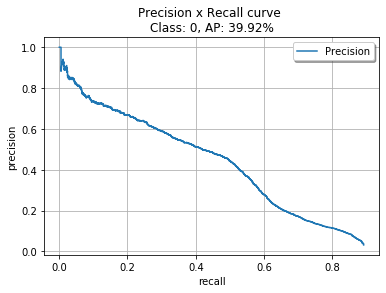

In [15]:
train_evaluater = Voc_Evaluater(args.train_image_root, args.train_target_root, pj(args.prc_root, "train"))
test_evaluater = Voc_Evaluater(args.test_image_root, args.test_target_root, pj(args.prc_root, "test"))
for epoch in range(args.max_epoch):
    train_per_epoch(model, train_data_loader, optimizer, epoch)
    
    # validate model
    if epoch != 0 and epoch % args.valid_interval == 0:
        train_ap = validate(train_evaluater, model, train_valid_data_loader, args.crop_num, num_classes=args.class_num, nms_thresh=0.5)
        test_ap = validate(test_evaluater, model, test_data_loader, args.crop_num, num_classes=args.class_num, nms_thresh=0.5)
        print("epoch: {}, train_ap={}, test_ap={}".format(epoch, train_ap, test_ap))
        if args.visdom:
            visualize(epoch+1, train_ap, win_train_acc)
            visualize(epoch+1, test_ap, win_test_acc)
    
    # save model
    if epoch != 0 and epoch % args.save_interval == 0:
        print('Saving state, epoch: ' + str(epoch))
        torch.save(model.state_dict(), args.model_root + '/RefineDet{}_{}.pth'.format(args.input_size, str(epoch)))

# final save model
print('Saving state, final')
torch.save(model.state_dict(), args.model_root + '/RefineDet{}_final.pth'.format(args.input_size))